In [1]:
print("hello")

hello


In [2]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    ScaleIntensityRangePercentilesd,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss, DiceFocalLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

print_config()

MONAI version: 1.4.0
Numpy version: 1.24.4
Pytorch version: 2.1.1+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /home/<username>/.local/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.2
Nibabel version: 5.3.2
scikit-image version: 0.22.0
scipy version: 1.11.4
Pillow version: 10.1.0
Tensorboard version: 2.19.0
gdown version: 5.2.0
TorchVision version: 0.16.1+cu118
tqdm version: 4.66.1
lmdb version: 1.6.2
psutil version: 5.9.5
pandas version: 2.2.3
einops version: 0.8.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: 1.1.3
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
import psutil

print(f"💻 Total system memory: {psutil.virtual_memory().total / (1024**3):.1f} GB")

💻 Total system memory: 1510.6 GB


In [47]:
import wandb

# === Experiment name ===
exp_name = "CADPE-exp2"
run_save_dir = "./"+exp_name
os.makedirs(run_save_dir, exist_ok=True)

# === Core Settings ===
epochs = 300
lr = 1e-4
batch_size = 4
loss_func = "DiceFocalLoss"  # <- use "DiceFocalLoss" if you switch
model = "3D UNet"
modality = "CT"
patch_size = (128, 128, 96)
patch_num_samples = 6
window_center = 100
window_width = 700
pos_neg_ratio = (2, 1)  # pos=2, neg=1
cache_rate = 1
allow_smaller = True
image_threshold = -1200
image_visual_epochs = 3
scheduler = "ReduceLROnPlateau"
val_interval = 1

# === Dataset Count ===
train_cnt, val_cnt, test_cnt = 70, 21, 0

# === Model Arch ===
channels = (16, 32, 64, 128)
strides = (2, 2, 2)
in_channels = 1
out_channels = 2

# === WandB Init ===
run = wandb.init(
    project="PE-Seg",
    name=exp_name,
    config={
        # Optimization
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        "loss_func": loss_func,
        "metric": "Dice",
        "scheduler": scheduler,

        # Data/Transform
        "window_center": window_center,
        "window_width": window_width,
        "patch_size": patch_size,
        "patch_num_samples": patch_num_samples,
        "patch_pos_neg_ratio": pos_neg_ratio,
        "cache_rate": cache_rate,
        "allow_smaller": allow_smaller,
        "image_threshold": image_threshold,

        # Model
        "model": model,
        "modality": modality,
        "model_in_channels": in_channels,
        "model_out_channels": out_channels,
        "model_channels": channels,
        "model_strides": strides,

        # Dataset counts
        "train_cnt": train_cnt,
        "val_cnt": val_cnt,
        "test_cnt": test_cnt,
    },
    reinit=True,
    settings=wandb.Settings(code_dir="")
)


train/loss,█▅▃▂▁
train/lr,▁▁▁▁▁
val/dice,▁▁▂▃█
val/loss,█▆▄▃▁
train/loss,0.65981
train/lr,0.0001
val/dice,0.00828
val/loss,0.6553


In [48]:
import glob
import os

ct_dir = "./nifti/images"
gt_dir = "./nifti/labels"

# Recursively find FLAIR and binary mask pairs
image_paths = sorted(glob.glob(os.path.join(ct_dir, "**", "*.nii.gz"), recursive=True))
label_paths = sorted(glob.glob(os.path.join(gt_dir, "**", "*.nii.gz"), recursive=True))

# Make sure they align
assert len(image_paths) == len(label_paths), "Mismatch in image and label counts!"

data_dicts = [{"image": i, "label": l} for i, l in zip(image_paths, label_paths)]

# Manual split: last N for validation
train_files = data_dicts[:-val_cnt]  # adjust N based on your total case count
val_files   = data_dicts[-val_cnt:]

print(f"✅ Total cases: {len(data_dicts)}")
print(f"📊 Training: {len(train_files)}  | Validation: {len(val_files)}")

✅ Total cases: 91
📊 Training: 70  | Validation: 21


In [49]:
set_determinism(seed=0)

In [50]:
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityRanged, Orientationd,
    Spacingd, RandCropByPosNegLabeld, SpatialPadd, LambdaD
)

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=window_center-window_width/2, a_max=window_center+window_width/2,     
            b_min=0.0, b_max=1.0,
            clip=True,
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        
        # 🔧 Pad to minimum size required for cropping
        SpatialPadd(keys=["image", "label"], spatial_size=patch_size),
        
        # Convert Instance Segmentation to Binary Segmentation mask
        LambdaD(keys=["label"], func=lambda x: (x > 0).astype(x.dtype)),
        
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=patch_size,  # Smaller patch focuses better
            pos=pos_neg_ratio[0],                      # More positives
            neg=pos_neg_ratio[1],
            num_samples=patch_num_samples,             # More tries per volume
            image_key="image",
            image_threshold=image_threshold,
            allow_smaller=allow_smaller
        ),
    ]
)

val_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=window_center-window_width/2, a_max=window_center+window_width/2,
        b_min=0.0, b_max=1.0,
        clip=True,
    ),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    # 🔧 Pad to minimum size required for cropping
    SpatialPadd(keys=["image", "label"], spatial_size=patch_size),
    # Convert Instance Segmentation to Binary Segmentation mask
    LambdaD(keys=["label"], func=lambda x: (x > 0).astype(x.dtype)),
    #Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.5), mode=("bilinear", "nearest")),
    # optionally pad if needed (some validation images might be small after spacing)
    SpatialPadd(keys=["image", "label"], spatial_size=(96, 96, 64)),
])

image shape: torch.Size([512, 512, 564]), label shape: torch.Size([512, 512, 564])
Label unique values: metatensor([0., 1.])
🧠 Non-zero label found at slice 142 with area 63.0
🧠 Non-zero label found at slice 143 with area 61.0
🧠 Non-zero label found at slice 144 with area 66.0
🧠 Non-zero label found at slice 145 with area 65.0
🧠 Non-zero label found at slice 146 with area 55.0
🧠 Non-zero label found at slice 147 with area 80.0
[142, 143, 144, 145, 146, 147]


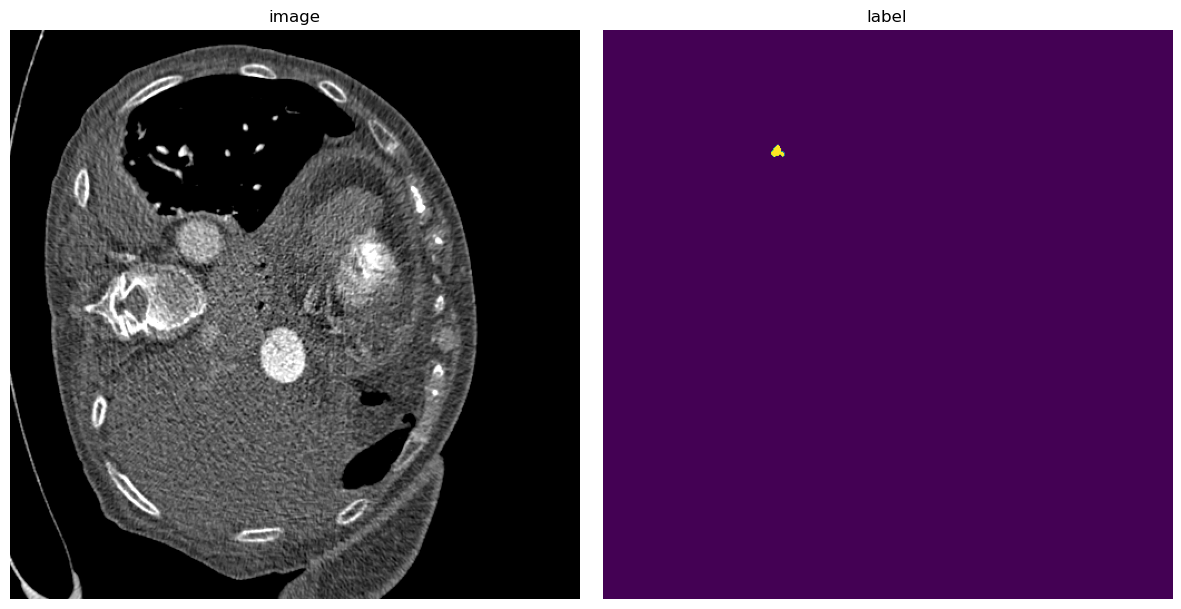

In [51]:
import matplotlib.pyplot as plt

check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
print("Label unique values:", torch.unique(label))

# Find the first slice where label is non-zero
idx = None
non_empty = []
for i in range(label.shape[-1]):
    if label[..., i].sum() > 0:
        idx = i
        print(f"🧠 Non-zero label found at slice {i} with area {label[..., i].sum()}")
        non_empty.append(i)

print(non_empty)

# If found, visualize
if idx is not None:
    plt.figure("check", figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("image")
    plt.imshow(image[:, :, idx], cmap="gray")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("label")
    plt.imshow(label[:, :, idx])
    plt.axis("off")

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No non-zero label slice found.")


In [52]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=cache_rate, num_workers=2)
#train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=cache_rate, num_workers=2)
#val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=2)

Loading dataset: 100%|██████████| 21/21 [02:04<00:00,  5.91s/it]


In [53]:
from monai.utils import first
import numpy as np

sample = first(train_loader)

print("📦 Batch shape:", sample["image"].shape)  # (B, C, H, W, D)

for i in range(sample["label"].shape[0]):
    label_patch = sample["label"][i][0]  # [0] = squeeze channel
    pe_voxels = label_patch.sum().item()
    print(f"🧠 Patch {i}: PE voxels = {pe_voxels}")

📦 Batch shape: torch.Size([12, 1, 128, 128, 96])
🧠 Patch 0: PE voxels = 47126.0
🧠 Patch 1: PE voxels = 33131.0
🧠 Patch 2: PE voxels = 0.0
🧠 Patch 3: PE voxels = 0.0
🧠 Patch 4: PE voxels = 47208.0
🧠 Patch 5: PE voxels = 62336.0
🧠 Patch 6: PE voxels = 0.0
🧠 Patch 7: PE voxels = 6212.0
🧠 Patch 8: PE voxels = 0.0
🧠 Patch 9: PE voxels = 6212.0
🧠 Patch 10: PE voxels = 4962.0
🧠 Patch 11: PE voxels = 6212.0


In [54]:
def save_checkpoint():
    torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict(),
        "epoch": epoch,
        "offset": offset,
        "best_metric": best_metric,
        "best_metric_epoch": best_metric_epoch
    }, os.path.join(run_save_dir, "checkpoint.pth"))

In [55]:
device = torch.device("cuda:0")

model = UNet(
    spatial_dims=3,
    in_channels=in_channels,
    out_channels=out_channels,
    channels=channels,
    strides=strides,
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

# 🔁 Switched loss to DiceFocalLoss
loss_function = DiceFocalLoss(to_onehot_y=True, softmax=True)

optimizer = torch.optim.Adam(model.parameters(), 1e-4)

dice_metric = DiceMetric(include_background=False, reduction="mean")

In [56]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(
    optimizer,
    mode="min",         # Since lower loss is better
    factor=0.9,         # Halve LR if no improvement
    patience=10,        # Wait 10 epochs
    verbose=True,
    min_lr=1e-5         # Don’t go below this
)

In [57]:
from tqdm import tqdm, trange
import warnings
warnings.filterwarnings("ignore", message=".*unable to generate class balanced samples.*")

In [68]:
# Optional: Load checkpoint
resume = os.path.exists(os.path.join(run_save_dir, "checkpoint.pth"))
if resume:
    checkpoint = torch.load(os.path.join(run_save_dir, "checkpoint.pth"))
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    scheduler.load_state_dict(checkpoint["scheduler_state_dict"]) 
    start_epoch = checkpoint["epoch"] + 1
    best_metric = checkpoint["best_metric"]
    best_metric_epoch = checkpoint["best_metric_epoch"]
    print(f"[🔄] Resuming from epoch {start_epoch}, best metric {best_metric:.4f}")
else:
    start_epoch = 0
    offset = 0
    best_metric = -1
    best_metric_epoch = -1

epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])
epoch_range = trange(start_epoch, start_epoch + epochs, desc="Training Epochs")

# --- Training Loop ---
for epoch in epoch_range:
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    epoch_range.set_postfix({"loss": epoch_loss})
    wandb.log({"train/loss": epoch_loss, "train/lr": optimizer.param_groups[0]["lr"]}, step=epoch)

    # --- Validation ---
    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0.0
        val_steps = 0
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = val_data["image"].to(device), val_data["label"].to(device)
                val_outputs = sliding_window_inference(val_inputs, roi_size=(160, 160, 160), sw_batch_size=4, predictor=model)
                loss = loss_function(val_outputs, val_labels)
                val_loss += loss.item()
                val_steps += 1

                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                dice_metric(y_pred=val_outputs, y=val_labels)

        val_loss /= val_steps
        metric = dice_metric.aggregate().item()
        dice_metric.reset()

        metric_values.append(metric)
        wandb.log({"val/dice": metric, "val/loss": val_loss}, step=epoch)

        if metric > best_metric:
            best_metric = metric
            best_metric_epoch = epoch + 1
            save_checkpoint()
            print("[💾] Saved new best metric model")

        if epoch % image_visual_epochs == 0:
            val_image = val_data["image"][0, 0].detach().cpu().numpy()
            val_label = val_data["label"][0, 0].detach().cpu().numpy()
            val_pred = torch.argmax(val_outputs[0], dim=0).detach().cpu().numpy()
            #mid_slice = val_image.shape[2] // 2
            mid_slice = 147
            fig, axs = plt.subplots(1, 4, figsize=(20, 5))
            axs[0].imshow(val_image[:, :, mid_slice], cmap="gray")
            axs[0].set_title("Input")
            axs[1].imshow(val_image[:, :, mid_slice], cmap="gray")
            axs[1].imshow(val_pred[:, :, mid_slice], cmap="Reds", alpha=0.4)
            axs[1].set_title("Prediction on Input")
            axs[2].imshow(val_pred[:, :, mid_slice])
            axs[2].set_title("Prediction")
            axs[3].imshow(val_label[:, :, mid_slice])
            axs[3].set_title("Ground Truth")
            plt.tight_layout()
            wandb.log({"val/visual": wandb.Image(fig)}, step=epoch)
            plt.close(fig)
        scheduler.step(val_loss)


[🔄] Resuming from epoch 1, best metric 0.0021


Training Epochs:   0%|          | 0/300 [00:00<?, ?it/s]

1/35, train_loss: 0.7266
2/35, train_loss: 0.7233
3/35, train_loss: 0.7220
4/35, train_loss: 0.7242
5/35, train_loss: 0.7223
6/35, train_loss: 0.7182
7/35, train_loss: 0.7173
8/35, train_loss: 0.7151
9/35, train_loss: 0.7177
10/35, train_loss: 0.7121
11/35, train_loss: 0.7132
12/35, train_loss: 0.7154
13/35, train_loss: 0.7145
14/35, train_loss: 0.7139
15/35, train_loss: 0.7132
16/35, train_loss: 0.7110
17/35, train_loss: 0.7054
18/35, train_loss: 0.7073
19/35, train_loss: 0.7104
20/35, train_loss: 0.6965
21/35, train_loss: 0.7056
22/35, train_loss: 0.6966
23/35, train_loss: 0.7037
24/35, train_loss: 0.7058
25/35, train_loss: 0.6943
26/35, train_loss: 0.6951
27/35, train_loss: 0.6941
28/35, train_loss: 0.6871
29/35, train_loss: 0.6935
30/35, train_loss: 0.6951
31/35, train_loss: 0.7001
32/35, train_loss: 0.6978
33/35, train_loss: 0.6787
34/35, train_loss: 0.6895
35/35, train_loss: 0.6874


Training Epochs:   0%|          | 1/300 [03:32<17:40:05, 212.73s/it, loss=0.706]

1/35, train_loss: 0.6868
2/35, train_loss: 0.6958
3/35, train_loss: 0.6923
4/35, train_loss: 0.6885
5/35, train_loss: 0.6820
6/35, train_loss: 0.6903
7/35, train_loss: 0.6888
8/35, train_loss: 0.6852
9/35, train_loss: 0.6881
10/35, train_loss: 0.6775
11/35, train_loss: 0.6770
12/35, train_loss: 0.6850
13/35, train_loss: 0.6846
14/35, train_loss: 0.6788
15/35, train_loss: 0.6783
16/35, train_loss: 0.6828
17/35, train_loss: 0.6759
18/35, train_loss: 0.6801
19/35, train_loss: 0.6808
20/35, train_loss: 0.6752
21/35, train_loss: 0.6726
22/35, train_loss: 0.6674
23/35, train_loss: 0.6762
24/35, train_loss: 0.6740
25/35, train_loss: 0.6750
26/35, train_loss: 0.6747
27/35, train_loss: 0.6628
28/35, train_loss: 0.6745
29/35, train_loss: 0.6701
30/35, train_loss: 0.6678
31/35, train_loss: 0.6725
32/35, train_loss: 0.6582
33/35, train_loss: 0.6580
34/35, train_loss: 0.6627
35/35, train_loss: 0.6712


Training Epochs:   1%|          | 2/300 [07:01<17:24:42, 210.34s/it, loss=0.677]

[💾] Saved new best metric model
1/35, train_loss: 0.6605
2/35, train_loss: 0.6656
3/35, train_loss: 0.6645
4/35, train_loss: 0.6720
5/35, train_loss: 0.6658
6/35, train_loss: 0.6609
7/35, train_loss: 0.6666
8/35, train_loss: 0.6559
9/35, train_loss: 0.6597
10/35, train_loss: 0.6665
11/35, train_loss: 0.6638
12/35, train_loss: 0.6564
13/35, train_loss: 0.6640
14/35, train_loss: 0.6506
15/35, train_loss: 0.6576
16/35, train_loss: 0.6547
17/35, train_loss: 0.6564
18/35, train_loss: 0.6567
19/35, train_loss: 0.6540
20/35, train_loss: 0.6546
21/35, train_loss: 0.6540
22/35, train_loss: 0.6514
23/35, train_loss: 0.6582
24/35, train_loss: 0.6557
25/35, train_loss: 0.6619
26/35, train_loss: 0.6542
27/35, train_loss: 0.6415
28/35, train_loss: 0.6566
29/35, train_loss: 0.6546
30/35, train_loss: 0.6544
31/35, train_loss: 0.6504
32/35, train_loss: 0.6514
33/35, train_loss: 0.6465
34/35, train_loss: 0.6539
35/35, train_loss: 0.6503


Training Epochs:   1%|          | 2/300 [08:55<17:24:42, 210.34s/it, loss=0.657]

[💾] Saved new best metric model


Training Epochs:   1%|          | 3/300 [10:37<17:33:59, 212.93s/it, loss=0.657]

1/35, train_loss: 0.6503
2/35, train_loss: 0.6460
3/35, train_loss: 0.6502
4/35, train_loss: 0.6377
5/35, train_loss: 0.6435
6/35, train_loss: 0.6501
7/35, train_loss: 0.6468
8/35, train_loss: 0.6468
9/35, train_loss: 0.6454
10/35, train_loss: 0.6338
11/35, train_loss: 0.6460
12/35, train_loss: 0.6406
13/35, train_loss: 0.6324
14/35, train_loss: 0.6489
15/35, train_loss: 0.6439
16/35, train_loss: 0.6392
17/35, train_loss: 0.6323
18/35, train_loss: 0.6351
19/35, train_loss: 0.6322
20/35, train_loss: 0.6312
21/35, train_loss: 0.6222
22/35, train_loss: 0.6367
23/35, train_loss: 0.6418
24/35, train_loss: 0.6432
25/35, train_loss: 0.6294
26/35, train_loss: 0.6396
27/35, train_loss: 0.6360
28/35, train_loss: 0.6312
29/35, train_loss: 0.6297
30/35, train_loss: 0.6141
31/35, train_loss: 0.6324
32/35, train_loss: 0.6351
33/35, train_loss: 0.6397
34/35, train_loss: 0.6145
35/35, train_loss: 0.6350


Training Epochs:   1%|▏         | 4/300 [14:07<17:24:04, 211.64s/it, loss=0.638]

[💾] Saved new best metric model
1/35, train_loss: 0.6306
2/35, train_loss: 0.6321
3/35, train_loss: 0.6212
4/35, train_loss: 0.6331
5/35, train_loss: 0.6289
6/35, train_loss: 0.6306
7/35, train_loss: 0.6286
8/35, train_loss: 0.6093
9/35, train_loss: 0.6175
10/35, train_loss: 0.6167
11/35, train_loss: 0.6349
12/35, train_loss: 0.6186
13/35, train_loss: 0.6281
14/35, train_loss: 0.6229
15/35, train_loss: 0.6256
16/35, train_loss: 0.6329
17/35, train_loss: 0.6210
18/35, train_loss: 0.6151
19/35, train_loss: 0.6077
20/35, train_loss: 0.6094
21/35, train_loss: 0.6244
22/35, train_loss: 0.6011
23/35, train_loss: 0.6059
24/35, train_loss: 0.6288
25/35, train_loss: 0.6229
26/35, train_loss: 0.6176
27/35, train_loss: 0.6285
28/35, train_loss: 0.6226
29/35, train_loss: 0.6115
30/35, train_loss: 0.6139
31/35, train_loss: 0.6061
32/35, train_loss: 0.6038
33/35, train_loss: 0.6095
34/35, train_loss: 0.6016
35/35, train_loss: 0.6232


Training Epochs:   2%|▏         | 5/300 [17:36<17:16:57, 210.91s/it, loss=0.62] 

1/35, train_loss: 0.6233
2/35, train_loss: 0.6140
3/35, train_loss: 0.6118
4/35, train_loss: 0.6198
5/35, train_loss: 0.6236
6/35, train_loss: 0.5945
7/35, train_loss: 0.6030
8/35, train_loss: 0.5916
9/35, train_loss: 0.6104
10/35, train_loss: 0.5984
11/35, train_loss: 0.6012
12/35, train_loss: 0.6065
13/35, train_loss: 0.6048
14/35, train_loss: 0.6053
15/35, train_loss: 0.6060
16/35, train_loss: 0.5714
17/35, train_loss: 0.6033
18/35, train_loss: 0.5842
19/35, train_loss: 0.6189
20/35, train_loss: 0.6186
21/35, train_loss: 0.6181
22/35, train_loss: 0.5861
23/35, train_loss: 0.6068
24/35, train_loss: 0.6100
25/35, train_loss: 0.6012
26/35, train_loss: 0.5997
27/35, train_loss: 0.5914
28/35, train_loss: 0.6086
29/35, train_loss: 0.5930
30/35, train_loss: 0.5929
31/35, train_loss: 0.6095
32/35, train_loss: 0.5737
33/35, train_loss: 0.5892
34/35, train_loss: 0.5927
35/35, train_loss: 0.5776


Training Epochs:   2%|▏         | 5/300 [19:26<17:16:57, 210.91s/it, loss=0.602]

[💾] Saved new best metric model


Training Epochs:   2%|▏         | 6/300 [21:08<17:15:17, 211.29s/it, loss=0.602]

1/35, train_loss: 0.5646
2/35, train_loss: 0.5873
3/35, train_loss: 0.6125
4/35, train_loss: 0.5831
5/35, train_loss: 0.5860
6/35, train_loss: 0.6043
7/35, train_loss: 0.5851
8/35, train_loss: 0.5880
9/35, train_loss: 0.5791
10/35, train_loss: 0.5917
11/35, train_loss: 0.5879
12/35, train_loss: 0.5983
13/35, train_loss: 0.6008
14/35, train_loss: 0.6014
15/35, train_loss: 0.5749
16/35, train_loss: 0.5730
17/35, train_loss: 0.5836
18/35, train_loss: 0.5970
19/35, train_loss: 0.5843
20/35, train_loss: 0.6005
21/35, train_loss: 0.5770
22/35, train_loss: 0.5634
23/35, train_loss: 0.5812
24/35, train_loss: 0.6044
25/35, train_loss: 0.5841
26/35, train_loss: 0.5920
27/35, train_loss: 0.5867
28/35, train_loss: 0.5999
29/35, train_loss: 0.5903
30/35, train_loss: 0.5732
31/35, train_loss: 0.5823
32/35, train_loss: 0.5787
33/35, train_loss: 0.5807
34/35, train_loss: 0.5916
35/35, train_loss: 0.5949


Training Epochs:   2%|▏         | 7/300 [24:36<17:06:41, 210.24s/it, loss=0.588]

1/35, train_loss: 0.5943
2/35, train_loss: 0.5697
3/35, train_loss: 0.5558
4/35, train_loss: 0.5848
5/35, train_loss: 0.5913
6/35, train_loss: 0.5244
7/35, train_loss: 0.5579
8/35, train_loss: 0.5508
9/35, train_loss: 0.5964
10/35, train_loss: 0.5767
11/35, train_loss: 0.5835
12/35, train_loss: 0.5565
13/35, train_loss: 0.5625
14/35, train_loss: 0.5837
15/35, train_loss: 0.5706
16/35, train_loss: 0.5569
17/35, train_loss: 0.5916
18/35, train_loss: 0.5498
19/35, train_loss: 0.5926
20/35, train_loss: 0.5627
21/35, train_loss: 0.5812
22/35, train_loss: 0.5495
23/35, train_loss: 0.5825
24/35, train_loss: 0.5765
25/35, train_loss: 0.5173
26/35, train_loss: 0.5633
27/35, train_loss: 0.5529
28/35, train_loss: 0.5904
29/35, train_loss: 0.5808
30/35, train_loss: 0.5510
31/35, train_loss: 0.5555
32/35, train_loss: 0.5869
33/35, train_loss: 0.5875
34/35, train_loss: 0.5668
35/35, train_loss: 0.5674


Training Epochs:   3%|▎         | 8/300 [28:04<16:59:04, 209.40s/it, loss=0.569]

[💾] Saved new best metric model
1/35, train_loss: 0.5684
2/35, train_loss: 0.5460
3/35, train_loss: 0.5610
4/35, train_loss: 0.5785
5/35, train_loss: 0.5815
6/35, train_loss: 0.5824
7/35, train_loss: 0.5593
8/35, train_loss: 0.5707
9/35, train_loss: 0.5275
10/35, train_loss: 0.5667
11/35, train_loss: 0.5657
12/35, train_loss: 0.5576
13/35, train_loss: 0.5565
14/35, train_loss: 0.5542
15/35, train_loss: 0.5585
16/35, train_loss: 0.5620
17/35, train_loss: 0.5530
18/35, train_loss: 0.5559
19/35, train_loss: 0.5525
20/35, train_loss: 0.5643
21/35, train_loss: 0.5651
22/35, train_loss: 0.5686
23/35, train_loss: 0.5199
24/35, train_loss: 0.5251
25/35, train_loss: 0.5793
26/35, train_loss: 0.5252
27/35, train_loss: 0.5558
28/35, train_loss: 0.5648
29/35, train_loss: 0.5113
30/35, train_loss: 0.5738
31/35, train_loss: 0.5729
32/35, train_loss: 0.5733
33/35, train_loss: 0.5665
34/35, train_loss: 0.5715
35/35, train_loss: 0.5278


Training Epochs:   3%|▎         | 8/300 [29:55<16:59:04, 209.40s/it, loss=0.558]

[💾] Saved new best metric model


Training Epochs:   3%|▎         | 9/300 [31:38<17:02:09, 210.75s/it, loss=0.558]

1/35, train_loss: 0.5688
2/35, train_loss: 0.5472
3/35, train_loss: 0.5627
4/35, train_loss: 0.5536
5/35, train_loss: 0.5058
6/35, train_loss: 0.5440
7/35, train_loss: 0.5450
8/35, train_loss: 0.5310
9/35, train_loss: 0.5361
10/35, train_loss: 0.5293
11/35, train_loss: 0.5761
12/35, train_loss: 0.5201
13/35, train_loss: 0.5735
14/35, train_loss: 0.5437
15/35, train_loss: 0.5787
16/35, train_loss: 0.5077
17/35, train_loss: 0.5625
18/35, train_loss: 0.5350
19/35, train_loss: 0.5403
20/35, train_loss: 0.5180
21/35, train_loss: 0.5498
22/35, train_loss: 0.5216
23/35, train_loss: 0.5341
24/35, train_loss: 0.4911
25/35, train_loss: 0.5499
26/35, train_loss: 0.5638
27/35, train_loss: 0.5558
28/35, train_loss: 0.5201
29/35, train_loss: 0.5277
30/35, train_loss: 0.5559
31/35, train_loss: 0.5003
32/35, train_loss: 0.5630
33/35, train_loss: 0.5535
34/35, train_loss: 0.5688
35/35, train_loss: 0.5299


Training Epochs:   3%|▎         | 10/300 [35:14<17:07:40, 212.62s/it, loss=0.542]

1/35, train_loss: 0.5342
2/35, train_loss: 0.5161
3/35, train_loss: 0.5398
4/35, train_loss: 0.5612
5/35, train_loss: 0.5219
6/35, train_loss: 0.5571
7/35, train_loss: 0.4933
8/35, train_loss: 0.4853
9/35, train_loss: 0.5289
10/35, train_loss: 0.5509
11/35, train_loss: 0.5034
12/35, train_loss: 0.5204
13/35, train_loss: 0.5236
14/35, train_loss: 0.4757
15/35, train_loss: 0.5422
16/35, train_loss: 0.5533
17/35, train_loss: 0.5219
18/35, train_loss: 0.5623
19/35, train_loss: 0.5421
20/35, train_loss: 0.5263
21/35, train_loss: 0.5193
22/35, train_loss: 0.5566
23/35, train_loss: 0.5346
24/35, train_loss: 0.5580
25/35, train_loss: 0.5509
26/35, train_loss: 0.5559
27/35, train_loss: 0.5300
28/35, train_loss: 0.5399
29/35, train_loss: 0.5375
30/35, train_loss: 0.5009
31/35, train_loss: 0.5325
32/35, train_loss: 0.5452
33/35, train_loss: 0.5506
34/35, train_loss: 0.4841
35/35, train_loss: 0.5515


Training Epochs:   4%|▎         | 11/300 [38:45<17:01:30, 212.08s/it, loss=0.532]

[💾] Saved new best metric model
1/35, train_loss: 0.5370
2/35, train_loss: 0.4808
3/35, train_loss: 0.5430
4/35, train_loss: 0.4822
5/35, train_loss: 0.5058
6/35, train_loss: 0.5530
7/35, train_loss: 0.5303
8/35, train_loss: 0.4876
9/35, train_loss: 0.5206
10/35, train_loss: 0.5290
11/35, train_loss: 0.5418
12/35, train_loss: 0.5392
13/35, train_loss: 0.5076
14/35, train_loss: 0.5346
15/35, train_loss: 0.5160
16/35, train_loss: 0.5083
17/35, train_loss: 0.5145
18/35, train_loss: 0.5333
19/35, train_loss: 0.5488
20/35, train_loss: 0.5553
21/35, train_loss: 0.5209
22/35, train_loss: 0.5491
23/35, train_loss: 0.5109
24/35, train_loss: 0.5195
25/35, train_loss: 0.4694
26/35, train_loss: 0.5317
27/35, train_loss: 0.5204
28/35, train_loss: 0.5181
29/35, train_loss: 0.5221
30/35, train_loss: 0.5520
31/35, train_loss: 0.5369
32/35, train_loss: 0.4979
33/35, train_loss: 0.5445
34/35, train_loss: 0.4836
35/35, train_loss: 0.5194


Training Epochs:   4%|▎         | 11/300 [40:32<17:01:30, 212.08s/it, loss=0.522]

[💾] Saved new best metric model


Training Epochs:   4%|▍         | 12/300 [42:14<16:52:48, 211.00s/it, loss=0.522]

1/35, train_loss: 0.5139
2/35, train_loss: 0.4986
3/35, train_loss: 0.5189
4/35, train_loss: 0.5088
5/35, train_loss: 0.5268
6/35, train_loss: 0.5445
7/35, train_loss: 0.5340
8/35, train_loss: 0.4743
9/35, train_loss: 0.5360
10/35, train_loss: 0.5085
11/35, train_loss: 0.5226
12/35, train_loss: 0.5256
13/35, train_loss: 0.4939
14/35, train_loss: 0.4597
15/35, train_loss: 0.4790
16/35, train_loss: 0.5156
17/35, train_loss: 0.4833
18/35, train_loss: 0.5037
19/35, train_loss: 0.5224
20/35, train_loss: 0.4621
21/35, train_loss: 0.5076
22/35, train_loss: 0.5490
23/35, train_loss: 0.5403
24/35, train_loss: 0.5447
25/35, train_loss: 0.4954
26/35, train_loss: 0.4706
27/35, train_loss: 0.5075
28/35, train_loss: 0.5243
29/35, train_loss: 0.4876
30/35, train_loss: 0.4645
31/35, train_loss: 0.5486
32/35, train_loss: 0.4844
33/35, train_loss: 0.5494
34/35, train_loss: 0.4831
35/35, train_loss: 0.5050


Training Epochs:   4%|▍         | 13/300 [45:49<16:55:55, 212.39s/it, loss=0.508]

1/35, train_loss: 0.5090
2/35, train_loss: 0.5006
3/35, train_loss: 0.4872
4/35, train_loss: 0.5418
5/35, train_loss: 0.4606
6/35, train_loss: 0.4865
7/35, train_loss: 0.4741
8/35, train_loss: 0.5257
9/35, train_loss: 0.5291
10/35, train_loss: 0.5474
11/35, train_loss: 0.5203
12/35, train_loss: 0.5350
13/35, train_loss: 0.4806
14/35, train_loss: 0.4972
15/35, train_loss: 0.5352
16/35, train_loss: 0.4969
17/35, train_loss: 0.4960
18/35, train_loss: 0.5289
19/35, train_loss: 0.4758
20/35, train_loss: 0.5008
21/35, train_loss: 0.4695
22/35, train_loss: 0.4949
23/35, train_loss: 0.4507
24/35, train_loss: 0.4850
25/35, train_loss: 0.5243
26/35, train_loss: 0.5269
27/35, train_loss: 0.4919
28/35, train_loss: 0.4855
29/35, train_loss: 0.5404
30/35, train_loss: 0.4731
31/35, train_loss: 0.4808
32/35, train_loss: 0.4847
33/35, train_loss: 0.5168
34/35, train_loss: 0.4948
35/35, train_loss: 0.5379


Training Epochs:   5%|▍         | 14/300 [49:18<16:47:00, 211.26s/it, loss=0.502]

1/35, train_loss: 0.5293
2/35, train_loss: 0.5291
3/35, train_loss: 0.5151
4/35, train_loss: 0.4876
5/35, train_loss: 0.5346
6/35, train_loss: 0.5302
7/35, train_loss: 0.5078
8/35, train_loss: 0.5293
9/35, train_loss: 0.4996
10/35, train_loss: 0.4940
11/35, train_loss: 0.5250
12/35, train_loss: 0.5307
13/35, train_loss: 0.4626
14/35, train_loss: 0.5210
15/35, train_loss: 0.4856
16/35, train_loss: 0.4786
17/35, train_loss: 0.5384
18/35, train_loss: 0.3992
19/35, train_loss: 0.4885
20/35, train_loss: 0.5153
21/35, train_loss: 0.4375
22/35, train_loss: 0.5032
23/35, train_loss: 0.4827
24/35, train_loss: 0.4740
25/35, train_loss: 0.4777
26/35, train_loss: 0.5393
27/35, train_loss: 0.4802
28/35, train_loss: 0.4711
29/35, train_loss: 0.4772
30/35, train_loss: 0.4790
31/35, train_loss: 0.4524
32/35, train_loss: 0.4901
33/35, train_loss: 0.4253
34/35, train_loss: 0.4874
35/35, train_loss: 0.4030


Training Epochs:   5%|▍         | 14/300 [51:10<16:47:00, 211.26s/it, loss=0.491]

[💾] Saved new best metric model


Training Epochs:   5%|▌         | 15/300 [52:53<16:48:20, 212.28s/it, loss=0.491]

1/35, train_loss: 0.4423
2/35, train_loss: 0.4387
3/35, train_loss: 0.5003
4/35, train_loss: 0.5071
5/35, train_loss: 0.5007
6/35, train_loss: 0.4693
7/35, train_loss: 0.4478
8/35, train_loss: 0.5204
9/35, train_loss: 0.4859
10/35, train_loss: 0.5268
11/35, train_loss: 0.5115
12/35, train_loss: 0.4833
13/35, train_loss: 0.5350
14/35, train_loss: 0.4783
15/35, train_loss: 0.4604
16/35, train_loss: 0.5082
17/35, train_loss: 0.4244
18/35, train_loss: 0.5105
19/35, train_loss: 0.5010
20/35, train_loss: 0.3998
21/35, train_loss: 0.5296
22/35, train_loss: 0.4781
23/35, train_loss: 0.3906
24/35, train_loss: 0.5041
25/35, train_loss: 0.5140
26/35, train_loss: 0.5222
27/35, train_loss: 0.4358
28/35, train_loss: 0.5018
29/35, train_loss: 0.4590
30/35, train_loss: 0.4829
31/35, train_loss: 0.4676
32/35, train_loss: 0.4720
33/35, train_loss: 0.5265
34/35, train_loss: 0.4868
35/35, train_loss: 0.4722


Training Epochs:   5%|▌         | 16/300 [56:22<16:40:41, 211.41s/it, loss=0.483]

1/35, train_loss: 0.5150
2/35, train_loss: 0.4866
3/35, train_loss: 0.5019
4/35, train_loss: 0.4993
5/35, train_loss: 0.4721
6/35, train_loss: 0.5156
7/35, train_loss: 0.4560
8/35, train_loss: 0.4267
9/35, train_loss: 0.4754
10/35, train_loss: 0.5164
11/35, train_loss: 0.5174
12/35, train_loss: 0.4438
13/35, train_loss: 0.4618
14/35, train_loss: 0.5231
15/35, train_loss: 0.4836
16/35, train_loss: 0.4108
17/35, train_loss: 0.4368
18/35, train_loss: 0.4414
19/35, train_loss: 0.4571
20/35, train_loss: 0.4708
21/35, train_loss: 0.3931
22/35, train_loss: 0.5041
23/35, train_loss: 0.4151
24/35, train_loss: 0.4123
25/35, train_loss: 0.5167
26/35, train_loss: 0.4690
27/35, train_loss: 0.4951
28/35, train_loss: 0.4828
29/35, train_loss: 0.4714
30/35, train_loss: 0.5222
31/35, train_loss: 0.5051
32/35, train_loss: 0.4472
33/35, train_loss: 0.4754
34/35, train_loss: 0.4986
35/35, train_loss: 0.5145


Training Epochs:   6%|▌         | 17/300 [59:53<16:37:08, 211.41s/it, loss=0.475]

1/35, train_loss: 0.4848
2/35, train_loss: 0.4855
3/35, train_loss: 0.5234
4/35, train_loss: 0.3808
5/35, train_loss: 0.5038
6/35, train_loss: 0.5150
7/35, train_loss: 0.5178
8/35, train_loss: 0.4543
9/35, train_loss: 0.4808
10/35, train_loss: 0.4812
11/35, train_loss: 0.4377
12/35, train_loss: 0.4794
13/35, train_loss: 0.5047
14/35, train_loss: 0.4597
15/35, train_loss: 0.5139
16/35, train_loss: 0.5152
17/35, train_loss: 0.5205
18/35, train_loss: 0.4715
19/35, train_loss: 0.4713
20/35, train_loss: 0.4149
21/35, train_loss: 0.5063
22/35, train_loss: 0.4920
23/35, train_loss: 0.5301
24/35, train_loss: 0.4968
25/35, train_loss: 0.4350
26/35, train_loss: 0.4587
27/35, train_loss: 0.4447
28/35, train_loss: 0.4347
29/35, train_loss: 0.4254
30/35, train_loss: 0.3650
31/35, train_loss: 0.3896
32/35, train_loss: 0.5007
33/35, train_loss: 0.4160
34/35, train_loss: 0.4610
35/35, train_loss: 0.4768


Training Epochs:   6%|▌         | 18/300 [1:03:27<16:36:51, 212.10s/it, loss=0.47]

1/35, train_loss: 0.5185
2/35, train_loss: 0.4728
3/35, train_loss: 0.4789
4/35, train_loss: 0.4684
5/35, train_loss: 0.5162
6/35, train_loss: 0.4583
7/35, train_loss: 0.4565
8/35, train_loss: 0.4690
9/35, train_loss: 0.4375
10/35, train_loss: 0.4972
11/35, train_loss: 0.4063
12/35, train_loss: 0.5170
13/35, train_loss: 0.4638
14/35, train_loss: 0.4371
15/35, train_loss: 0.4332
16/35, train_loss: 0.4411
17/35, train_loss: 0.4709
18/35, train_loss: 0.4597
19/35, train_loss: 0.4106
20/35, train_loss: 0.4395
21/35, train_loss: 0.4900
22/35, train_loss: 0.4854
23/35, train_loss: 0.5224
24/35, train_loss: 0.4957
25/35, train_loss: 0.4521
26/35, train_loss: 0.4063
27/35, train_loss: 0.4631
28/35, train_loss: 0.5112
29/35, train_loss: 0.4904
30/35, train_loss: 0.4797
31/35, train_loss: 0.3739
32/35, train_loss: 0.5069
33/35, train_loss: 0.4998
34/35, train_loss: 0.3769
35/35, train_loss: 0.4860


Training Epochs:   6%|▋         | 19/300 [1:07:00<16:33:52, 212.21s/it, loss=0.465]

[💾] Saved new best metric model
1/35, train_loss: 0.4779
2/35, train_loss: 0.3425
3/35, train_loss: 0.4201
4/35, train_loss: 0.4681
5/35, train_loss: 0.5105
6/35, train_loss: 0.4548
7/35, train_loss: 0.4338
8/35, train_loss: 0.4783
9/35, train_loss: 0.4065
10/35, train_loss: 0.4609
11/35, train_loss: 0.5124
12/35, train_loss: 0.5159
13/35, train_loss: 0.4851
14/35, train_loss: 0.4378
15/35, train_loss: 0.4673
16/35, train_loss: 0.4813
17/35, train_loss: 0.3929
18/35, train_loss: 0.3850
19/35, train_loss: 0.3719
20/35, train_loss: 0.4938
21/35, train_loss: 0.4264
22/35, train_loss: 0.4824
23/35, train_loss: 0.3806
24/35, train_loss: 0.4735
25/35, train_loss: 0.4613
26/35, train_loss: 0.4609
27/35, train_loss: 0.5026
28/35, train_loss: 0.4472
29/35, train_loss: 0.4713
30/35, train_loss: 0.4484
31/35, train_loss: 0.4831
32/35, train_loss: 0.5041
33/35, train_loss: 0.4081
34/35, train_loss: 0.4351
35/35, train_loss: 0.4993


Training Epochs:   7%|▋         | 20/300 [1:10:30<16:27:24, 211.59s/it, loss=0.454]

1/35, train_loss: 0.4710
2/35, train_loss: 0.4614
3/35, train_loss: 0.5158
4/35, train_loss: 0.4456
5/35, train_loss: 0.5136
6/35, train_loss: 0.4657
7/35, train_loss: 0.4556
8/35, train_loss: 0.3945
9/35, train_loss: 0.4826
10/35, train_loss: 0.4450
11/35, train_loss: 0.3213
12/35, train_loss: 0.4993
13/35, train_loss: 0.4497
14/35, train_loss: 0.4590
15/35, train_loss: 0.4260
16/35, train_loss: 0.4125
17/35, train_loss: 0.4460
18/35, train_loss: 0.4746
19/35, train_loss: 0.3267
20/35, train_loss: 0.4698
21/35, train_loss: 0.4946
22/35, train_loss: 0.4168
23/35, train_loss: 0.4437
24/35, train_loss: 0.5039
25/35, train_loss: 0.4225
26/35, train_loss: 0.4558
27/35, train_loss: 0.4599
28/35, train_loss: 0.4077
29/35, train_loss: 0.4945
30/35, train_loss: 0.5014
31/35, train_loss: 0.3979
32/35, train_loss: 0.4177
33/35, train_loss: 0.4337
34/35, train_loss: 0.4805
35/35, train_loss: 0.4358


Training Epochs:   7%|▋         | 21/300 [1:14:04<16:27:56, 212.46s/it, loss=0.449]

1/35, train_loss: 0.3951
2/35, train_loss: 0.4377
3/35, train_loss: 0.4707
4/35, train_loss: 0.5198
5/35, train_loss: 0.4094
6/35, train_loss: 0.3957
7/35, train_loss: 0.4012
8/35, train_loss: 0.4672
9/35, train_loss: 0.4583
10/35, train_loss: 0.4301
11/35, train_loss: 0.3767
12/35, train_loss: 0.4064
13/35, train_loss: 0.3996
14/35, train_loss: 0.4411
15/35, train_loss: 0.4580
16/35, train_loss: 0.5057
17/35, train_loss: 0.4270
18/35, train_loss: 0.4888
19/35, train_loss: 0.4548
20/35, train_loss: 0.3856
21/35, train_loss: 0.4943
22/35, train_loss: 0.5027
23/35, train_loss: 0.4992
24/35, train_loss: 0.4745
25/35, train_loss: 0.4747
26/35, train_loss: 0.4884
27/35, train_loss: 0.3478
28/35, train_loss: 0.3695
29/35, train_loss: 0.3949
30/35, train_loss: 0.4277
31/35, train_loss: 0.3875
32/35, train_loss: 0.4689
33/35, train_loss: 0.4593
34/35, train_loss: 0.4003
35/35, train_loss: 0.5182


Training Epochs:   7%|▋         | 22/300 [1:17:34<16:20:19, 211.58s/it, loss=0.441]

1/35, train_loss: 0.3516
2/35, train_loss: 0.3522
3/35, train_loss: 0.4013
4/35, train_loss: 0.4877
5/35, train_loss: 0.3925
6/35, train_loss: 0.4006
7/35, train_loss: 0.4321
8/35, train_loss: 0.4640
9/35, train_loss: 0.4576
10/35, train_loss: 0.4861
11/35, train_loss: 0.3762
12/35, train_loss: 0.4086
13/35, train_loss: 0.4788
14/35, train_loss: 0.4287
15/35, train_loss: 0.4170
16/35, train_loss: 0.4302
17/35, train_loss: 0.4873
18/35, train_loss: 0.4184
19/35, train_loss: 0.4196
20/35, train_loss: 0.4863
21/35, train_loss: 0.3931
22/35, train_loss: 0.4572
23/35, train_loss: 0.4061
24/35, train_loss: 0.4456
25/35, train_loss: 0.4901
26/35, train_loss: 0.4719
27/35, train_loss: 0.4338
28/35, train_loss: 0.4966
29/35, train_loss: 0.4281
30/35, train_loss: 0.4092
31/35, train_loss: 0.4199
32/35, train_loss: 0.4841
33/35, train_loss: 0.4883
34/35, train_loss: 0.4651
35/35, train_loss: 0.4571


Training Epochs:   8%|▊         | 23/300 [1:21:03<16:13:44, 210.92s/it, loss=0.438]

[💾] Saved new best metric model
1/35, train_loss: 0.3661
2/35, train_loss: 0.4365
3/35, train_loss: 0.3547
4/35, train_loss: 0.4765
5/35, train_loss: 0.4864
6/35, train_loss: 0.4808
7/35, train_loss: 0.4308
8/35, train_loss: 0.3650
9/35, train_loss: 0.4826
10/35, train_loss: 0.4272
11/35, train_loss: 0.3939
12/35, train_loss: 0.4224
13/35, train_loss: 0.4937
14/35, train_loss: 0.4460
15/35, train_loss: 0.3499
16/35, train_loss: 0.4107
17/35, train_loss: 0.4016
18/35, train_loss: 0.4649
19/35, train_loss: 0.5008
20/35, train_loss: 0.3889
21/35, train_loss: 0.4058
22/35, train_loss: 0.5045
23/35, train_loss: 0.4798
24/35, train_loss: 0.4468
25/35, train_loss: 0.4607
26/35, train_loss: 0.4784
27/35, train_loss: 0.3660
28/35, train_loss: 0.4814
29/35, train_loss: 0.4283
30/35, train_loss: 0.3842
31/35, train_loss: 0.3378
32/35, train_loss: 0.5053
33/35, train_loss: 0.4804
34/35, train_loss: 0.4603
35/35, train_loss: 0.5141


Training Epochs:   8%|▊         | 24/300 [1:24:34<16:10:36, 211.00s/it, loss=0.438]

1/35, train_loss: 0.4124
2/35, train_loss: 0.4461
3/35, train_loss: 0.3396
4/35, train_loss: 0.4011
5/35, train_loss: 0.4954
6/35, train_loss: 0.4912
7/35, train_loss: 0.3199
8/35, train_loss: 0.4994
9/35, train_loss: 0.3922
10/35, train_loss: 0.5150
11/35, train_loss: 0.4427
12/35, train_loss: 0.4796
13/35, train_loss: 0.3869
14/35, train_loss: 0.4042
15/35, train_loss: 0.3908
16/35, train_loss: 0.4888
17/35, train_loss: 0.4363
18/35, train_loss: 0.3785
19/35, train_loss: 0.4347
20/35, train_loss: 0.3724
21/35, train_loss: 0.3955
22/35, train_loss: 0.4867
23/35, train_loss: 0.4518
24/35, train_loss: 0.4629
25/35, train_loss: 0.3844
26/35, train_loss: 0.4737
27/35, train_loss: 0.3496
28/35, train_loss: 0.3693
29/35, train_loss: 0.4267
30/35, train_loss: 0.3742
31/35, train_loss: 0.4738
32/35, train_loss: 0.4094
33/35, train_loss: 0.3792
34/35, train_loss: 0.3799
35/35, train_loss: 0.4557


Training Epochs:   8%|▊         | 25/300 [1:28:06<16:07:47, 211.15s/it, loss=0.423]

1/35, train_loss: 0.3632
2/35, train_loss: 0.3837
3/35, train_loss: 0.5128
4/35, train_loss: 0.4495
5/35, train_loss: 0.3652
6/35, train_loss: 0.4358
7/35, train_loss: 0.4700
8/35, train_loss: 0.4475
9/35, train_loss: 0.3807
10/35, train_loss: 0.3503
11/35, train_loss: 0.3829
12/35, train_loss: 0.4796
13/35, train_loss: 0.4156
14/35, train_loss: 0.3984
15/35, train_loss: 0.3757
16/35, train_loss: 0.3535
17/35, train_loss: 0.3812
18/35, train_loss: 0.4434
19/35, train_loss: 0.4994
20/35, train_loss: 0.4710
21/35, train_loss: 0.4459
22/35, train_loss: 0.4869
23/35, train_loss: 0.3626
24/35, train_loss: 0.4376
25/35, train_loss: 0.4467
26/35, train_loss: 0.4477
27/35, train_loss: 0.4254
28/35, train_loss: 0.4921
29/35, train_loss: 0.4865
30/35, train_loss: 0.4331
31/35, train_loss: 0.3283
32/35, train_loss: 0.4876
33/35, train_loss: 0.3578
34/35, train_loss: 0.3635
35/35, train_loss: 0.4038


Training Epochs:   9%|▊         | 26/300 [1:31:39<16:06:16, 211.59s/it, loss=0.422]

1/35, train_loss: 0.3869
2/35, train_loss: 0.4425
3/35, train_loss: 0.2433
4/35, train_loss: 0.4431
5/35, train_loss: 0.4578
6/35, train_loss: 0.4043
7/35, train_loss: 0.3867
8/35, train_loss: 0.4755
9/35, train_loss: 0.4887
10/35, train_loss: 0.4225
11/35, train_loss: 0.3432
12/35, train_loss: 0.3835
13/35, train_loss: 0.3877
14/35, train_loss: 0.4286
15/35, train_loss: 0.4612
16/35, train_loss: 0.4001
17/35, train_loss: 0.4340
18/35, train_loss: 0.3410
19/35, train_loss: 0.4498
20/35, train_loss: 0.4087
21/35, train_loss: 0.2825
22/35, train_loss: 0.4977
23/35, train_loss: 0.4394
24/35, train_loss: 0.4360
25/35, train_loss: 0.4302
26/35, train_loss: 0.4926
27/35, train_loss: 0.4812
28/35, train_loss: 0.4102
29/35, train_loss: 0.4185
30/35, train_loss: 0.4682
31/35, train_loss: 0.4731
32/35, train_loss: 0.4003
33/35, train_loss: 0.3679
34/35, train_loss: 0.4247
35/35, train_loss: 0.4306


Training Epochs:   9%|▉         | 27/300 [1:35:20<16:15:38, 214.43s/it, loss=0.418]

1/35, train_loss: 0.4890
2/35, train_loss: 0.4125
3/35, train_loss: 0.4662
4/35, train_loss: 0.4785
5/35, train_loss: 0.3069
6/35, train_loss: 0.2844
7/35, train_loss: 0.3182
8/35, train_loss: 0.5010
9/35, train_loss: 0.3495
10/35, train_loss: 0.4861
11/35, train_loss: 0.3296
12/35, train_loss: 0.4406
13/35, train_loss: 0.4202
14/35, train_loss: 0.3412
15/35, train_loss: 0.5087
16/35, train_loss: 0.4517
17/35, train_loss: 0.4533
18/35, train_loss: 0.4077
19/35, train_loss: 0.3161
20/35, train_loss: 0.4002
21/35, train_loss: 0.4179
22/35, train_loss: 0.3713
23/35, train_loss: 0.4063
24/35, train_loss: 0.3423
25/35, train_loss: 0.3700
26/35, train_loss: 0.4083
27/35, train_loss: 0.4616
28/35, train_loss: 0.4094
29/35, train_loss: 0.4677
30/35, train_loss: 0.3361
31/35, train_loss: 0.4433
32/35, train_loss: 0.3796
33/35, train_loss: 0.3965
34/35, train_loss: 0.3752
35/35, train_loss: 0.4564


Training Epochs:   9%|▉         | 28/300 [1:38:49<16:05:41, 213.02s/it, loss=0.406]

1/35, train_loss: 0.4822
2/35, train_loss: 0.4805
3/35, train_loss: 0.3385
4/35, train_loss: 0.3816
5/35, train_loss: 0.4043
6/35, train_loss: 0.5006
7/35, train_loss: 0.3829
8/35, train_loss: 0.4183
9/35, train_loss: 0.4602
10/35, train_loss: 0.4136
11/35, train_loss: 0.4629
12/35, train_loss: 0.3680
13/35, train_loss: 0.3682
14/35, train_loss: 0.4175
15/35, train_loss: 0.4395
16/35, train_loss: 0.4313
17/35, train_loss: 0.3491
18/35, train_loss: 0.3642
19/35, train_loss: 0.4538
20/35, train_loss: 0.3842
21/35, train_loss: 0.3780
22/35, train_loss: 0.3812
23/35, train_loss: 0.3265
24/35, train_loss: 0.4744
25/35, train_loss: 0.3826
26/35, train_loss: 0.4400
27/35, train_loss: 0.4584
28/35, train_loss: 0.3067
29/35, train_loss: 0.4882
30/35, train_loss: 0.3626
31/35, train_loss: 0.3628
32/35, train_loss: 0.3572
33/35, train_loss: 0.3322
34/35, train_loss: 0.4799
35/35, train_loss: 0.3697


Training Epochs:  10%|▉         | 29/300 [1:42:17<15:55:08, 211.47s/it, loss=0.406]

1/35, train_loss: 0.3932
2/35, train_loss: 0.3716
3/35, train_loss: 0.5065
4/35, train_loss: 0.4569
5/35, train_loss: 0.3032
6/35, train_loss: 0.4161
7/35, train_loss: 0.3275
8/35, train_loss: 0.4020
9/35, train_loss: 0.4034
10/35, train_loss: 0.4313
11/35, train_loss: 0.4009
12/35, train_loss: 0.4690
13/35, train_loss: 0.3968
14/35, train_loss: 0.4496
15/35, train_loss: 0.3853
16/35, train_loss: 0.2956
17/35, train_loss: 0.3762
18/35, train_loss: 0.4593
19/35, train_loss: 0.3443
20/35, train_loss: 0.3769
21/35, train_loss: 0.2895
22/35, train_loss: 0.4484
23/35, train_loss: 0.3750
24/35, train_loss: 0.3298
25/35, train_loss: 0.4586
26/35, train_loss: 0.4223
27/35, train_loss: 0.4247
28/35, train_loss: 0.3744
29/35, train_loss: 0.4692
30/35, train_loss: 0.4638
31/35, train_loss: 0.3453
32/35, train_loss: 0.3876
33/35, train_loss: 0.4232
34/35, train_loss: 0.3559
35/35, train_loss: 0.4206


Training Epochs:  10%|█         | 30/300 [1:45:48<15:50:32, 211.23s/it, loss=0.399]

1/35, train_loss: 0.4354
2/35, train_loss: 0.4391
3/35, train_loss: 0.4435
4/35, train_loss: 0.4177
5/35, train_loss: 0.3025
6/35, train_loss: 0.4397
7/35, train_loss: 0.3943
8/35, train_loss: 0.3794
9/35, train_loss: 0.4942
10/35, train_loss: 0.4183
11/35, train_loss: 0.4094
12/35, train_loss: 0.3099
13/35, train_loss: 0.3323
14/35, train_loss: 0.4417
15/35, train_loss: 0.3173
16/35, train_loss: 0.4611
17/35, train_loss: 0.3924
18/35, train_loss: 0.3911
19/35, train_loss: 0.3951
20/35, train_loss: 0.3732
21/35, train_loss: 0.4472
22/35, train_loss: 0.4290
23/35, train_loss: 0.4158
24/35, train_loss: 0.4174
25/35, train_loss: 0.3502
26/35, train_loss: 0.3968
27/35, train_loss: 0.3459
28/35, train_loss: 0.3742
29/35, train_loss: 0.3490
30/35, train_loss: 0.4257
31/35, train_loss: 0.3622
32/35, train_loss: 0.4560
33/35, train_loss: 0.3440
34/35, train_loss: 0.3288
35/35, train_loss: 0.4158


Training Epochs:  10%|█         | 31/300 [1:49:17<15:44:05, 210.58s/it, loss=0.396]

1/35, train_loss: 0.3597
2/35, train_loss: 0.3819
3/35, train_loss: 0.3882
4/35, train_loss: 0.4071
5/35, train_loss: 0.4822
6/35, train_loss: 0.3975
7/35, train_loss: 0.4491
8/35, train_loss: 0.3241
9/35, train_loss: 0.4272
10/35, train_loss: 0.4344
11/35, train_loss: 0.3591
12/35, train_loss: 0.3964
13/35, train_loss: 0.3915
14/35, train_loss: 0.3517
15/35, train_loss: 0.3728
16/35, train_loss: 0.4148
17/35, train_loss: 0.4165
18/35, train_loss: 0.4373
19/35, train_loss: 0.4386
20/35, train_loss: 0.3661
21/35, train_loss: 0.3089
22/35, train_loss: 0.3358
23/35, train_loss: 0.4037
24/35, train_loss: 0.4753
25/35, train_loss: 0.2828
26/35, train_loss: 0.3643
27/35, train_loss: 0.4650
28/35, train_loss: 0.3840
29/35, train_loss: 0.3531
30/35, train_loss: 0.3626
31/35, train_loss: 0.3885
32/35, train_loss: 0.4541
33/35, train_loss: 0.3628
34/35, train_loss: 0.4196
35/35, train_loss: 0.3267


Training Epochs:  11%|█         | 32/300 [1:52:44<15:35:23, 209.42s/it, loss=0.391]

1/35, train_loss: 0.3548
2/35, train_loss: 0.4071
3/35, train_loss: 0.3523
4/35, train_loss: 0.4706
5/35, train_loss: 0.3832
6/35, train_loss: 0.3623
7/35, train_loss: 0.4167
8/35, train_loss: 0.3343
9/35, train_loss: 0.2982
10/35, train_loss: 0.3902
11/35, train_loss: 0.3432
12/35, train_loss: 0.4489
13/35, train_loss: 0.3188
14/35, train_loss: 0.3321
15/35, train_loss: 0.4541
16/35, train_loss: 0.4270
17/35, train_loss: 0.3785
18/35, train_loss: 0.3108
19/35, train_loss: 0.3446
20/35, train_loss: 0.3147
21/35, train_loss: 0.4761
22/35, train_loss: 0.3607
23/35, train_loss: 0.3565
24/35, train_loss: 0.3301
25/35, train_loss: 0.3144
26/35, train_loss: 0.4807
27/35, train_loss: 0.3179
28/35, train_loss: 0.4276
29/35, train_loss: 0.3950
30/35, train_loss: 0.4551
31/35, train_loss: 0.4086
32/35, train_loss: 0.4996
33/35, train_loss: 0.4668
34/35, train_loss: 0.3399
35/35, train_loss: 0.4886


Training Epochs:  11%|█         | 33/300 [1:56:20<15:41:00, 211.46s/it, loss=0.387]

1/35, train_loss: 0.3056
2/35, train_loss: 0.3790
3/35, train_loss: 0.3939
4/35, train_loss: 0.3715
5/35, train_loss: 0.3931
6/35, train_loss: 0.3056
7/35, train_loss: 0.3131
8/35, train_loss: 0.4256
9/35, train_loss: 0.3488
10/35, train_loss: 0.4311
11/35, train_loss: 0.3906
12/35, train_loss: 0.3646
13/35, train_loss: 0.4050
14/35, train_loss: 0.3682
15/35, train_loss: 0.4294
16/35, train_loss: 0.2723
17/35, train_loss: 0.4544
18/35, train_loss: 0.3932
19/35, train_loss: 0.3672
20/35, train_loss: 0.4253
21/35, train_loss: 0.3630
22/35, train_loss: 0.3615
23/35, train_loss: 0.4673
24/35, train_loss: 0.4090
25/35, train_loss: 0.3324
26/35, train_loss: 0.3780
27/35, train_loss: 0.3632
28/35, train_loss: 0.4005
29/35, train_loss: 0.3997
30/35, train_loss: 0.3040
31/35, train_loss: 0.3851
32/35, train_loss: 0.3475
33/35, train_loss: 0.3894
34/35, train_loss: 0.3177
35/35, train_loss: 0.4461


Training Epochs:  11%|█▏        | 34/300 [1:59:50<15:36:04, 211.15s/it, loss=0.377]

1/35, train_loss: 0.2808
2/35, train_loss: 0.3852
3/35, train_loss: 0.2656
4/35, train_loss: 0.4918
5/35, train_loss: 0.3250
6/35, train_loss: 0.2809
7/35, train_loss: 0.4526
8/35, train_loss: 0.4366
9/35, train_loss: 0.3439
10/35, train_loss: 0.3592
11/35, train_loss: 0.3862
12/35, train_loss: 0.3610
13/35, train_loss: 0.4407
14/35, train_loss: 0.3467
15/35, train_loss: 0.4302
16/35, train_loss: 0.4346
17/35, train_loss: 0.3737
18/35, train_loss: 0.3794
19/35, train_loss: 0.3313
20/35, train_loss: 0.4049
21/35, train_loss: 0.3877
22/35, train_loss: 0.2682
23/35, train_loss: 0.4996
24/35, train_loss: 0.3001
25/35, train_loss: 0.2928
26/35, train_loss: 0.4155
27/35, train_loss: 0.2583
28/35, train_loss: 0.4667
29/35, train_loss: 0.3446
30/35, train_loss: 0.3905
31/35, train_loss: 0.4415
32/35, train_loss: 0.4261
33/35, train_loss: 0.3323
34/35, train_loss: 0.4100
35/35, train_loss: 0.3957


Training Epochs:  12%|█▏        | 35/300 [2:03:18<15:27:30, 210.00s/it, loss=0.375]

1/35, train_loss: 0.4374
2/35, train_loss: 0.4327
3/35, train_loss: 0.3820
4/35, train_loss: 0.4147
5/35, train_loss: 0.2529
6/35, train_loss: 0.4539
7/35, train_loss: 0.3677
8/35, train_loss: 0.4325
9/35, train_loss: 0.4104
10/35, train_loss: 0.2438
11/35, train_loss: 0.3697
12/35, train_loss: 0.3340
13/35, train_loss: 0.4393
14/35, train_loss: 0.2944
15/35, train_loss: 0.3231
16/35, train_loss: 0.3979
17/35, train_loss: 0.3318
18/35, train_loss: 0.3721
19/35, train_loss: 0.4272
20/35, train_loss: 0.3632
21/35, train_loss: 0.4252
22/35, train_loss: 0.4764
23/35, train_loss: 0.3462
24/35, train_loss: 0.3917
25/35, train_loss: 0.2633
26/35, train_loss: 0.3487
27/35, train_loss: 0.3431
28/35, train_loss: 0.4157
29/35, train_loss: 0.3977
30/35, train_loss: 0.3238
31/35, train_loss: 0.3282
32/35, train_loss: 0.4144
33/35, train_loss: 0.3830
34/35, train_loss: 0.3936
35/35, train_loss: 0.3865


Training Epochs:  12%|█▏        | 36/300 [2:06:53<15:30:34, 211.50s/it, loss=0.375]

1/35, train_loss: 0.3036
2/35, train_loss: 0.2591
3/35, train_loss: 0.4970
4/35, train_loss: 0.4122
5/35, train_loss: 0.3370
6/35, train_loss: 0.4095
7/35, train_loss: 0.4934
8/35, train_loss: 0.4015
9/35, train_loss: 0.3928
10/35, train_loss: 0.3419
11/35, train_loss: 0.3864
12/35, train_loss: 0.3220
13/35, train_loss: 0.3342
14/35, train_loss: 0.3843
15/35, train_loss: 0.3149
16/35, train_loss: 0.3592
17/35, train_loss: 0.4142
18/35, train_loss: 0.3490
19/35, train_loss: 0.3064
20/35, train_loss: 0.3649
21/35, train_loss: 0.3069
22/35, train_loss: 0.3633
23/35, train_loss: 0.3877
24/35, train_loss: 0.3579
25/35, train_loss: 0.4479
26/35, train_loss: 0.2841
27/35, train_loss: 0.3849
28/35, train_loss: 0.3268
29/35, train_loss: 0.3829
30/35, train_loss: 0.2574
31/35, train_loss: 0.3402
32/35, train_loss: 0.3245
33/35, train_loss: 0.4493
34/35, train_loss: 0.4127
35/35, train_loss: 0.4934


Training Epochs:  12%|█▏        | 37/300 [2:10:20<15:21:05, 210.13s/it, loss=0.369]

1/35, train_loss: 0.3054
2/35, train_loss: 0.3596
3/35, train_loss: 0.3755
4/35, train_loss: 0.4262
5/35, train_loss: 0.3805
6/35, train_loss: 0.2738
7/35, train_loss: 0.4432
8/35, train_loss: 0.3131
9/35, train_loss: 0.4250
10/35, train_loss: 0.4258
11/35, train_loss: 0.3623
12/35, train_loss: 0.4608
13/35, train_loss: 0.4897
14/35, train_loss: 0.3490
15/35, train_loss: 0.3125
16/35, train_loss: 0.3919
17/35, train_loss: 0.4003
18/35, train_loss: 0.3621
19/35, train_loss: 0.2519
20/35, train_loss: 0.3160
21/35, train_loss: 0.4760
22/35, train_loss: 0.2317
23/35, train_loss: 0.4071
24/35, train_loss: 0.4082
25/35, train_loss: 0.3391
26/35, train_loss: 0.3508
27/35, train_loss: 0.3581
28/35, train_loss: 0.2981
29/35, train_loss: 0.2821
30/35, train_loss: 0.4037
31/35, train_loss: 0.3503
32/35, train_loss: 0.3255
33/35, train_loss: 0.3517
34/35, train_loss: 0.3305
35/35, train_loss: 0.3480


Training Epochs:  13%|█▎        | 38/300 [2:13:47<15:14:25, 209.41s/it, loss=0.362]

[💾] Saved new best metric model
1/35, train_loss: 0.3386
2/35, train_loss: 0.3525
3/35, train_loss: 0.3847
4/35, train_loss: 0.4196
5/35, train_loss: 0.3126
6/35, train_loss: 0.4704
7/35, train_loss: 0.3628
8/35, train_loss: 0.4215
9/35, train_loss: 0.3925
10/35, train_loss: 0.3430
11/35, train_loss: 0.3042
12/35, train_loss: 0.4300
13/35, train_loss: 0.3335
14/35, train_loss: 0.2910
15/35, train_loss: 0.3894
16/35, train_loss: 0.3789
17/35, train_loss: 0.3765
18/35, train_loss: 0.2954
19/35, train_loss: 0.3735
20/35, train_loss: 0.3942
21/35, train_loss: 0.3544
22/35, train_loss: 0.3689
23/35, train_loss: 0.4127
24/35, train_loss: 0.4552
25/35, train_loss: 0.3500
26/35, train_loss: 0.3454
27/35, train_loss: 0.2623
28/35, train_loss: 0.3660
29/35, train_loss: 0.3889
30/35, train_loss: 0.3125
31/35, train_loss: 0.3497
32/35, train_loss: 0.3202
33/35, train_loss: 0.4593
34/35, train_loss: 0.4277
35/35, train_loss: 0.3155


Training Epochs:  13%|█▎        | 39/300 [2:17:19<15:13:44, 210.05s/it, loss=0.367]

1/35, train_loss: 0.3895
2/35, train_loss: 0.2682
3/35, train_loss: 0.3243
4/35, train_loss: 0.3042
5/35, train_loss: 0.4725
6/35, train_loss: 0.2818
7/35, train_loss: 0.3883
8/35, train_loss: 0.4498
9/35, train_loss: 0.2718
10/35, train_loss: 0.2380
11/35, train_loss: 0.3926
12/35, train_loss: 0.3271
13/35, train_loss: 0.3258
14/35, train_loss: 0.4362
15/35, train_loss: 0.4135
16/35, train_loss: 0.3662
17/35, train_loss: 0.3093
18/35, train_loss: 0.3746
19/35, train_loss: 0.3056
20/35, train_loss: 0.4447
21/35, train_loss: 0.3698
22/35, train_loss: 0.3478
23/35, train_loss: 0.4489
24/35, train_loss: 0.3505
25/35, train_loss: 0.3675
26/35, train_loss: 0.4068
27/35, train_loss: 0.4029
28/35, train_loss: 0.2731
29/35, train_loss: 0.4014
30/35, train_loss: 0.3329
31/35, train_loss: 0.4278
32/35, train_loss: 0.2805
33/35, train_loss: 0.3242
34/35, train_loss: 0.3866
35/35, train_loss: 0.3411


Training Epochs:  13%|█▎        | 40/300 [2:20:47<15:08:28, 209.65s/it, loss=0.358]

1/35, train_loss: 0.4457
2/35, train_loss: 0.3426
3/35, train_loss: 0.3422
4/35, train_loss: 0.3140
5/35, train_loss: 0.3244
6/35, train_loss: 0.3198
7/35, train_loss: 0.4218
8/35, train_loss: 0.3044
9/35, train_loss: 0.3901
10/35, train_loss: 0.3142
11/35, train_loss: 0.3421
12/35, train_loss: 0.3827
13/35, train_loss: 0.3893
14/35, train_loss: 0.2899
15/35, train_loss: 0.3940
16/35, train_loss: 0.4065
17/35, train_loss: 0.4660
18/35, train_loss: 0.3880
19/35, train_loss: 0.3295
20/35, train_loss: 0.4327
21/35, train_loss: 0.3186
22/35, train_loss: 0.2996
23/35, train_loss: 0.3781
24/35, train_loss: 0.4113
25/35, train_loss: 0.3351
26/35, train_loss: 0.3621
27/35, train_loss: 0.4058
28/35, train_loss: 0.3992
29/35, train_loss: 0.2854
30/35, train_loss: 0.3286
31/35, train_loss: 0.3465
32/35, train_loss: 0.3433
33/35, train_loss: 0.4304
34/35, train_loss: 0.2990
35/35, train_loss: 0.2429


Training Epochs:  14%|█▎        | 41/300 [2:24:18<15:06:35, 210.02s/it, loss=0.358]

1/35, train_loss: 0.2681
2/35, train_loss: 0.3680
3/35, train_loss: 0.2078
4/35, train_loss: 0.3687
5/35, train_loss: 0.4271
6/35, train_loss: 0.3488
7/35, train_loss: 0.3862
8/35, train_loss: 0.2891
9/35, train_loss: 0.3385
10/35, train_loss: 0.3814
11/35, train_loss: 0.4289
12/35, train_loss: 0.3315
13/35, train_loss: 0.4310
14/35, train_loss: 0.3148
15/35, train_loss: 0.3611
16/35, train_loss: 0.3476
17/35, train_loss: 0.3324
18/35, train_loss: 0.3697
19/35, train_loss: 0.4116
20/35, train_loss: 0.3935
21/35, train_loss: 0.2927
22/35, train_loss: 0.4377
23/35, train_loss: 0.2933
24/35, train_loss: 0.2489
25/35, train_loss: 0.3702
26/35, train_loss: 0.3787
27/35, train_loss: 0.3202
28/35, train_loss: 0.4159
29/35, train_loss: 0.3790
30/35, train_loss: 0.3346
31/35, train_loss: 0.4003
32/35, train_loss: 0.4368
33/35, train_loss: 0.3677
34/35, train_loss: 0.3241
35/35, train_loss: 0.2083


Training Epochs:  14%|█▍        | 42/300 [2:27:52<15:08:16, 211.23s/it, loss=0.352]

1/35, train_loss: 0.3815
2/35, train_loss: 0.4013
3/35, train_loss: 0.3003
4/35, train_loss: 0.2637
5/35, train_loss: 0.3598
6/35, train_loss: 0.4397
7/35, train_loss: 0.2918
8/35, train_loss: 0.4010
9/35, train_loss: 0.3971
10/35, train_loss: 0.3320
11/35, train_loss: 0.3715
12/35, train_loss: 0.4156
13/35, train_loss: 0.4210
14/35, train_loss: 0.4115
15/35, train_loss: 0.3076
16/35, train_loss: 0.2948
17/35, train_loss: 0.3391
18/35, train_loss: 0.3478
19/35, train_loss: 0.4608
20/35, train_loss: 0.3561
21/35, train_loss: 0.3606
22/35, train_loss: 0.3645
23/35, train_loss: 0.3127
24/35, train_loss: 0.3546
25/35, train_loss: 0.2787
26/35, train_loss: 0.3342
27/35, train_loss: 0.3042
28/35, train_loss: 0.3714
29/35, train_loss: 0.4437
30/35, train_loss: 0.3108
31/35, train_loss: 0.3500
32/35, train_loss: 0.3331
33/35, train_loss: 0.2610
34/35, train_loss: 0.4174
35/35, train_loss: 0.3348


Training Epochs:  14%|█▍        | 43/300 [2:31:22<15:03:10, 210.86s/it, loss=0.355]

1/35, train_loss: 0.3803
2/35, train_loss: 0.3076
3/35, train_loss: 0.2354
4/35, train_loss: 0.3317
5/35, train_loss: 0.3858
6/35, train_loss: 0.3364
7/35, train_loss: 0.3181
8/35, train_loss: 0.2223
9/35, train_loss: 0.3729
10/35, train_loss: 0.4848
11/35, train_loss: 0.3148
12/35, train_loss: 0.4396
13/35, train_loss: 0.3495
14/35, train_loss: 0.3456
15/35, train_loss: 0.3990
16/35, train_loss: 0.2570
17/35, train_loss: 0.3462
18/35, train_loss: 0.2857
19/35, train_loss: 0.2996
20/35, train_loss: 0.4494
21/35, train_loss: 0.3240
22/35, train_loss: 0.3333
23/35, train_loss: 0.2954
24/35, train_loss: 0.3870
25/35, train_loss: 0.3995
26/35, train_loss: 0.3388
27/35, train_loss: 0.4820
28/35, train_loss: 0.3290
29/35, train_loss: 0.3369
30/35, train_loss: 0.3808
31/35, train_loss: 0.3631
32/35, train_loss: 0.2951
33/35, train_loss: 0.2591
34/35, train_loss: 0.3541
35/35, train_loss: 0.3559


Training Epochs:  15%|█▍        | 44/300 [2:34:49<14:53:40, 209.46s/it, loss=0.346]

1/35, train_loss: 0.3441
2/35, train_loss: 0.3604
3/35, train_loss: 0.4209
4/35, train_loss: 0.3096
5/35, train_loss: 0.3201
6/35, train_loss: 0.2818
7/35, train_loss: 0.2942
8/35, train_loss: 0.4072
9/35, train_loss: 0.3700
10/35, train_loss: 0.3832
11/35, train_loss: 0.3452
12/35, train_loss: 0.3855
13/35, train_loss: 0.4308
14/35, train_loss: 0.3439
15/35, train_loss: 0.3940
16/35, train_loss: 0.4013
17/35, train_loss: 0.3803
18/35, train_loss: 0.3311
19/35, train_loss: 0.3391
20/35, train_loss: 0.3904
21/35, train_loss: 0.3520
22/35, train_loss: 0.2794
23/35, train_loss: 0.3220
24/35, train_loss: 0.3778
25/35, train_loss: 0.3743
26/35, train_loss: 0.3299
27/35, train_loss: 0.3234
28/35, train_loss: 0.2986
29/35, train_loss: 0.2902
30/35, train_loss: 0.3999
31/35, train_loss: 0.3281
32/35, train_loss: 0.4037
33/35, train_loss: 0.2784
34/35, train_loss: 0.2829
35/35, train_loss: 0.2924


Training Epochs:  15%|█▌        | 45/300 [2:38:26<15:00:03, 211.78s/it, loss=0.348]

1/35, train_loss: 0.3670
2/35, train_loss: 0.4544
3/35, train_loss: 0.3301
4/35, train_loss: 0.4680
5/35, train_loss: 0.3232
6/35, train_loss: 0.4628
7/35, train_loss: 0.3612
8/35, train_loss: 0.2842
9/35, train_loss: 0.3666
10/35, train_loss: 0.3779
11/35, train_loss: 0.3029
12/35, train_loss: 0.3848
13/35, train_loss: 0.3064
14/35, train_loss: 0.3956
15/35, train_loss: 0.4434
16/35, train_loss: 0.3675
17/35, train_loss: 0.3536
18/35, train_loss: 0.3440
19/35, train_loss: 0.3801
20/35, train_loss: 0.3439
21/35, train_loss: 0.3242
22/35, train_loss: 0.3056
23/35, train_loss: 0.3137
24/35, train_loss: 0.4227
25/35, train_loss: 0.2582
26/35, train_loss: 0.3965
27/35, train_loss: 0.2827
28/35, train_loss: 0.4282
29/35, train_loss: 0.3929
30/35, train_loss: 0.4830
31/35, train_loss: 0.2993
32/35, train_loss: 0.3114
33/35, train_loss: 0.3436
34/35, train_loss: 0.4261
35/35, train_loss: 0.3334


Training Epochs:  15%|█▌        | 46/300 [2:41:58<14:57:29, 212.01s/it, loss=0.364]

1/35, train_loss: 0.3863
2/35, train_loss: 0.3099
3/35, train_loss: 0.3567
4/35, train_loss: 0.2808
5/35, train_loss: 0.3805
6/35, train_loss: 0.4000
7/35, train_loss: 0.3625
8/35, train_loss: 0.2606
9/35, train_loss: 0.3202
10/35, train_loss: 0.3168
11/35, train_loss: 0.3513
12/35, train_loss: 0.3056
13/35, train_loss: 0.3886
14/35, train_loss: 0.3747
15/35, train_loss: 0.2995
16/35, train_loss: 0.3319
17/35, train_loss: 0.3152
18/35, train_loss: 0.3994
19/35, train_loss: 0.4232
20/35, train_loss: 0.3408
21/35, train_loss: 0.2209
22/35, train_loss: 0.3122
23/35, train_loss: 0.3096
24/35, train_loss: 0.3356
25/35, train_loss: 0.3767
26/35, train_loss: 0.3655
27/35, train_loss: 0.4086
28/35, train_loss: 0.4677
29/35, train_loss: 0.3034
30/35, train_loss: 0.2308
31/35, train_loss: 0.3793
32/35, train_loss: 0.3146
33/35, train_loss: 0.4119
34/35, train_loss: 0.3204
35/35, train_loss: 0.3126


Training Epochs:  16%|█▌        | 47/300 [2:45:28<14:50:24, 211.16s/it, loss=0.342]

1/35, train_loss: 0.3546
2/35, train_loss: 0.5026
3/35, train_loss: 0.2159
4/35, train_loss: 0.2555
5/35, train_loss: 0.3171
6/35, train_loss: 0.2916
7/35, train_loss: 0.3847
8/35, train_loss: 0.3728
9/35, train_loss: 0.2498
10/35, train_loss: 0.3969
11/35, train_loss: 0.3801
12/35, train_loss: 0.3300
13/35, train_loss: 0.3868
14/35, train_loss: 0.4006
15/35, train_loss: 0.3900
16/35, train_loss: 0.2790
17/35, train_loss: 0.3373
18/35, train_loss: 0.4077
19/35, train_loss: 0.3106
20/35, train_loss: 0.3807
21/35, train_loss: 0.3504
22/35, train_loss: 0.2919
23/35, train_loss: 0.3493
24/35, train_loss: 0.3506
25/35, train_loss: 0.2562
26/35, train_loss: 0.3204
27/35, train_loss: 0.3082
28/35, train_loss: 0.3039
29/35, train_loss: 0.2347
30/35, train_loss: 0.3234
31/35, train_loss: 0.3750
32/35, train_loss: 0.3523
33/35, train_loss: 0.4110
34/35, train_loss: 0.3136
35/35, train_loss: 0.2746


Training Epochs:  16%|█▌        | 48/300 [2:49:01<14:49:56, 211.89s/it, loss=0.336]

1/35, train_loss: 0.3197
2/35, train_loss: 0.4035
3/35, train_loss: 0.3186
4/35, train_loss: 0.3616
5/35, train_loss: 0.2729
6/35, train_loss: 0.3983
7/35, train_loss: 0.2842
8/35, train_loss: 0.3637
9/35, train_loss: 0.2860
10/35, train_loss: 0.3154
11/35, train_loss: 0.4126
12/35, train_loss: 0.2986
13/35, train_loss: 0.3904
14/35, train_loss: 0.2805
15/35, train_loss: 0.2896
16/35, train_loss: 0.3130
17/35, train_loss: 0.2544
18/35, train_loss: 0.4095
19/35, train_loss: 0.4937
20/35, train_loss: 0.3995
21/35, train_loss: 0.2686
22/35, train_loss: 0.3191
23/35, train_loss: 0.3769
24/35, train_loss: 0.2507
25/35, train_loss: 0.2798
26/35, train_loss: 0.3437
27/35, train_loss: 0.3445
28/35, train_loss: 0.3077
29/35, train_loss: 0.3408
30/35, train_loss: 0.3123
31/35, train_loss: 0.3160
32/35, train_loss: 0.3921
33/35, train_loss: 0.3100
34/35, train_loss: 0.3917
35/35, train_loss: 0.4276


Training Epochs:  16%|█▋        | 49/300 [2:52:29<14:41:33, 210.73s/it, loss=0.338]

1/35, train_loss: 0.3508
2/35, train_loss: 0.3713
3/35, train_loss: 0.3061
4/35, train_loss: 0.3548
5/35, train_loss: 0.3690
6/35, train_loss: 0.3288
7/35, train_loss: 0.3377
8/35, train_loss: 0.3751
9/35, train_loss: 0.2317
10/35, train_loss: 0.3444
11/35, train_loss: 0.3360
12/35, train_loss: 0.3685
13/35, train_loss: 0.2510
14/35, train_loss: 0.3527
15/35, train_loss: 0.3182
16/35, train_loss: 0.3137
17/35, train_loss: 0.2487
18/35, train_loss: 0.2622
19/35, train_loss: 0.3154
20/35, train_loss: 0.4491
21/35, train_loss: 0.2983
22/35, train_loss: 0.3713
23/35, train_loss: 0.3325
24/35, train_loss: 0.2389
25/35, train_loss: 0.4012
26/35, train_loss: 0.3894
27/35, train_loss: 0.3221
28/35, train_loss: 0.3975
29/35, train_loss: 0.3862
30/35, train_loss: 0.3430
31/35, train_loss: 0.3172
32/35, train_loss: 0.3291
33/35, train_loss: 0.3104
34/35, train_loss: 0.3646
35/35, train_loss: 0.2531


Training Epochs:  17%|█▋        | 50/300 [2:55:58<14:35:08, 210.03s/it, loss=0.333]

1/35, train_loss: 0.3138
2/35, train_loss: 0.3387
3/35, train_loss: 0.2435
4/35, train_loss: 0.4121
5/35, train_loss: 0.3586
6/35, train_loss: 0.3919
7/35, train_loss: 0.3076
8/35, train_loss: 0.2839
9/35, train_loss: 0.3595
10/35, train_loss: 0.4178
11/35, train_loss: 0.4641
12/35, train_loss: 0.3110
13/35, train_loss: 0.3772
14/35, train_loss: 0.2621
15/35, train_loss: 0.2485
16/35, train_loss: 0.3459
17/35, train_loss: 0.3360
18/35, train_loss: 0.3751
19/35, train_loss: 0.4095
20/35, train_loss: 0.3617
21/35, train_loss: 0.3445
22/35, train_loss: 0.2408
23/35, train_loss: 0.2875
24/35, train_loss: 0.2715
25/35, train_loss: 0.4359
26/35, train_loss: 0.3079
27/35, train_loss: 0.2880
28/35, train_loss: 0.3034
29/35, train_loss: 0.3208
30/35, train_loss: 0.3277
31/35, train_loss: 0.3175
32/35, train_loss: 0.3088
33/35, train_loss: 0.3778
34/35, train_loss: 0.4243
35/35, train_loss: 0.3092


Training Epochs:  17%|█▋        | 51/300 [2:59:29<14:33:25, 210.46s/it, loss=0.337]

1/35, train_loss: 0.3694
2/35, train_loss: 0.3467
3/35, train_loss: 0.3949
4/35, train_loss: 0.3195
5/35, train_loss: 0.3464
6/35, train_loss: 0.3756
7/35, train_loss: 0.2460
8/35, train_loss: 0.3026
9/35, train_loss: 0.3229
10/35, train_loss: 0.3507
11/35, train_loss: 0.3309
12/35, train_loss: 0.3205
13/35, train_loss: 0.3297
14/35, train_loss: 0.3710
15/35, train_loss: 0.2842
16/35, train_loss: 0.3431
17/35, train_loss: 0.2572
18/35, train_loss: 0.3866
19/35, train_loss: 0.3013
20/35, train_loss: 0.2808
21/35, train_loss: 0.3338
22/35, train_loss: 0.3403
23/35, train_loss: 0.2700
24/35, train_loss: 0.3637
25/35, train_loss: 0.3663
26/35, train_loss: 0.3142
27/35, train_loss: 0.3163
28/35, train_loss: 0.3314
29/35, train_loss: 0.3151
30/35, train_loss: 0.2937
31/35, train_loss: 0.2499
32/35, train_loss: 0.2908
33/35, train_loss: 0.3990
34/35, train_loss: 0.2831
35/35, train_loss: 0.3422


Training Epochs:  17%|█▋        | 52/300 [3:03:04<14:35:02, 211.71s/it, loss=0.325]

1/35, train_loss: 0.3055
2/35, train_loss: 0.3076
3/35, train_loss: 0.3126
4/35, train_loss: 0.4300
5/35, train_loss: 0.3494
6/35, train_loss: 0.3983
7/35, train_loss: 0.2827
8/35, train_loss: 0.3383
9/35, train_loss: 0.3215
10/35, train_loss: 0.4066
11/35, train_loss: 0.2891
12/35, train_loss: 0.2495
13/35, train_loss: 0.3349
14/35, train_loss: 0.3581
15/35, train_loss: 0.3502
16/35, train_loss: 0.3885
17/35, train_loss: 0.2415
18/35, train_loss: 0.2556
19/35, train_loss: 0.3026
20/35, train_loss: 0.2721
21/35, train_loss: 0.4381
22/35, train_loss: 0.3877
23/35, train_loss: 0.3075
24/35, train_loss: 0.3852
25/35, train_loss: 0.3224
26/35, train_loss: 0.3585
27/35, train_loss: 0.3719
28/35, train_loss: 0.3214
29/35, train_loss: 0.2783
30/35, train_loss: 0.3650
31/35, train_loss: 0.4188
32/35, train_loss: 0.2862
33/35, train_loss: 0.2927
34/35, train_loss: 0.3808
35/35, train_loss: 0.2953


Training Epochs:  18%|█▊        | 53/300 [3:06:31<14:26:30, 210.49s/it, loss=0.334]

1/35, train_loss: 0.3576
2/35, train_loss: 0.3105
3/35, train_loss: 0.1957
4/35, train_loss: 0.3942
5/35, train_loss: 0.2823
6/35, train_loss: 0.2214
7/35, train_loss: 0.2570
8/35, train_loss: 0.3258
9/35, train_loss: 0.3491
10/35, train_loss: 0.3414
11/35, train_loss: 0.3489
12/35, train_loss: 0.2944
13/35, train_loss: 0.3172
14/35, train_loss: 0.3152
15/35, train_loss: 0.3310
16/35, train_loss: 0.3953
17/35, train_loss: 0.3435
18/35, train_loss: 0.3909
19/35, train_loss: 0.3118
20/35, train_loss: 0.3471
21/35, train_loss: 0.3012
22/35, train_loss: 0.4143
23/35, train_loss: 0.2756
24/35, train_loss: 0.3503
25/35, train_loss: 0.3516
26/35, train_loss: 0.3012
27/35, train_loss: 0.3383
28/35, train_loss: 0.3479
29/35, train_loss: 0.4188
30/35, train_loss: 0.3858
31/35, train_loss: 0.3919
32/35, train_loss: 0.3134
33/35, train_loss: 0.4243
34/35, train_loss: 0.3967
35/35, train_loss: 0.2761


Training Epochs:  18%|█▊        | 54/300 [3:10:04<14:25:46, 211.16s/it, loss=0.335]

1/35, train_loss: 0.2811
2/35, train_loss: 0.2641
3/35, train_loss: 0.3455
4/35, train_loss: 0.3979
5/35, train_loss: 0.2880
6/35, train_loss: 0.3379
7/35, train_loss: 0.2091
8/35, train_loss: 0.2841
9/35, train_loss: 0.3737
10/35, train_loss: 0.4097
11/35, train_loss: 0.3802
12/35, train_loss: 0.3294
13/35, train_loss: 0.2931
14/35, train_loss: 0.2656
15/35, train_loss: 0.3138
16/35, train_loss: 0.3378
17/35, train_loss: 0.4337
18/35, train_loss: 0.3556
19/35, train_loss: 0.2620
20/35, train_loss: 0.2195
21/35, train_loss: 0.3355
22/35, train_loss: 0.3576
23/35, train_loss: 0.3649
24/35, train_loss: 0.2909
25/35, train_loss: 0.4008
26/35, train_loss: 0.3313
27/35, train_loss: 0.3878
28/35, train_loss: 0.3231
29/35, train_loss: 0.2858
30/35, train_loss: 0.4034
31/35, train_loss: 0.2747
32/35, train_loss: 0.3193
33/35, train_loss: 0.2863
34/35, train_loss: 0.2473
35/35, train_loss: 0.3243


Training Epochs:  18%|█▊        | 55/300 [3:13:35<14:22:08, 211.14s/it, loss=0.323]

1/35, train_loss: 0.2159
2/35, train_loss: 0.2995
3/35, train_loss: 0.2825
4/35, train_loss: 0.3870
5/35, train_loss: 0.3060
6/35, train_loss: 0.3953
7/35, train_loss: 0.4418
8/35, train_loss: 0.2820
9/35, train_loss: 0.3864
10/35, train_loss: 0.2484
11/35, train_loss: 0.2662
12/35, train_loss: 0.4239
13/35, train_loss: 0.3601
14/35, train_loss: 0.3336
15/35, train_loss: 0.2424
16/35, train_loss: 0.3248
17/35, train_loss: 0.3254
18/35, train_loss: 0.2890
19/35, train_loss: 0.3893
20/35, train_loss: 0.3699
21/35, train_loss: 0.3567
22/35, train_loss: 0.3632
23/35, train_loss: 0.3281
24/35, train_loss: 0.2836
25/35, train_loss: 0.3110
26/35, train_loss: 0.2707
27/35, train_loss: 0.2267
28/35, train_loss: 0.2716
29/35, train_loss: 0.3828
30/35, train_loss: 0.3823
31/35, train_loss: 0.2922
32/35, train_loss: 0.3900
33/35, train_loss: 0.2853
34/35, train_loss: 0.2805
35/35, train_loss: 0.3990


Training Epochs:  19%|█▊        | 56/300 [3:17:07<14:19:26, 211.34s/it, loss=0.326]

1/35, train_loss: 0.2626
2/35, train_loss: 0.2625
3/35, train_loss: 0.2341
4/35, train_loss: 0.2753
5/35, train_loss: 0.2693
6/35, train_loss: 0.2817
7/35, train_loss: 0.3624
8/35, train_loss: 0.3676
9/35, train_loss: 0.3738
10/35, train_loss: 0.2432
11/35, train_loss: 0.2862
12/35, train_loss: 0.4305
13/35, train_loss: 0.3455
14/35, train_loss: 0.3520
15/35, train_loss: 0.1567
16/35, train_loss: 0.2822
17/35, train_loss: 0.3774
18/35, train_loss: 0.3058
19/35, train_loss: 0.3874
20/35, train_loss: 0.3661
21/35, train_loss: 0.3380
22/35, train_loss: 0.2884
23/35, train_loss: 0.3242
24/35, train_loss: 0.2874
25/35, train_loss: 0.3013
26/35, train_loss: 0.2956
27/35, train_loss: 0.3167
28/35, train_loss: 0.4193
29/35, train_loss: 0.2698
30/35, train_loss: 0.2962
31/35, train_loss: 0.3781
32/35, train_loss: 0.3531
33/35, train_loss: 0.2583
34/35, train_loss: 0.3344
35/35, train_loss: 0.2760


Training Epochs:  19%|█▉        | 57/300 [3:20:36<14:13:42, 210.79s/it, loss=0.313]

1/35, train_loss: 0.2631
2/35, train_loss: 0.3032
3/35, train_loss: 0.3051
4/35, train_loss: 0.3506
5/35, train_loss: 0.3438
6/35, train_loss: 0.2393
7/35, train_loss: 0.3596
8/35, train_loss: 0.3414
9/35, train_loss: 0.3070
10/35, train_loss: 0.3325
11/35, train_loss: 0.3970
12/35, train_loss: 0.3229
13/35, train_loss: 0.3111
14/35, train_loss: 0.2399
15/35, train_loss: 0.2597
16/35, train_loss: 0.3137
17/35, train_loss: 0.1830
18/35, train_loss: 0.2676
19/35, train_loss: 0.3642
20/35, train_loss: 0.3646
21/35, train_loss: 0.2509
22/35, train_loss: 0.3092
23/35, train_loss: 0.3278
24/35, train_loss: 0.3657
25/35, train_loss: 0.2877
26/35, train_loss: 0.3197
27/35, train_loss: 0.2986
28/35, train_loss: 0.2930
29/35, train_loss: 0.4210
30/35, train_loss: 0.4150
31/35, train_loss: 0.4012
32/35, train_loss: 0.3195
33/35, train_loss: 0.3267
34/35, train_loss: 0.4184
35/35, train_loss: 0.3328


Training Epochs:  19%|█▉        | 58/300 [3:24:14<14:17:55, 212.71s/it, loss=0.322]

1/35, train_loss: 0.2612
2/35, train_loss: 0.2568
3/35, train_loss: 0.3311
4/35, train_loss: 0.3210
5/35, train_loss: 0.2654
6/35, train_loss: 0.3474
7/35, train_loss: 0.3235
8/35, train_loss: 0.2494
9/35, train_loss: 0.3132
10/35, train_loss: 0.2893
11/35, train_loss: 0.3223
12/35, train_loss: 0.2540
13/35, train_loss: 0.2507
14/35, train_loss: 0.2505
15/35, train_loss: 0.3078
16/35, train_loss: 0.3402
17/35, train_loss: 0.3647
18/35, train_loss: 0.3342
19/35, train_loss: 0.3197
20/35, train_loss: 0.2469
21/35, train_loss: 0.3605
22/35, train_loss: 0.2990
23/35, train_loss: 0.3861
24/35, train_loss: 0.2980
25/35, train_loss: 0.3409
26/35, train_loss: 0.2762
27/35, train_loss: 0.2592
28/35, train_loss: 0.3933
29/35, train_loss: 0.2716
30/35, train_loss: 0.3444
31/35, train_loss: 0.2921
32/35, train_loss: 0.2546
33/35, train_loss: 0.2851
34/35, train_loss: 0.3645
35/35, train_loss: 0.4498


Training Epochs:  20%|█▉        | 59/300 [3:27:42<14:09:42, 211.54s/it, loss=0.309]

1/35, train_loss: 0.3162
2/35, train_loss: 0.2522
3/35, train_loss: 0.3210
4/35, train_loss: 0.2723
5/35, train_loss: 0.3371
6/35, train_loss: 0.3361
7/35, train_loss: 0.3632
8/35, train_loss: 0.3823
9/35, train_loss: 0.3816
10/35, train_loss: 0.3422
11/35, train_loss: 0.3795
12/35, train_loss: 0.3784
13/35, train_loss: 0.3977
14/35, train_loss: 0.2958
15/35, train_loss: 0.3109
16/35, train_loss: 0.3579
17/35, train_loss: 0.3484
18/35, train_loss: 0.3224
19/35, train_loss: 0.3432
20/35, train_loss: 0.3262
21/35, train_loss: 0.2459
22/35, train_loss: 0.2798
23/35, train_loss: 0.3073
24/35, train_loss: 0.2222
25/35, train_loss: 0.4187
26/35, train_loss: 0.2858
27/35, train_loss: 0.3104
28/35, train_loss: 0.3183
29/35, train_loss: 0.3240
30/35, train_loss: 0.2754
31/35, train_loss: 0.3821
32/35, train_loss: 0.2168
33/35, train_loss: 0.3752
34/35, train_loss: 0.2722
35/35, train_loss: 0.2020


Training Epochs:  20%|██        | 60/300 [3:31:14<14:06:22, 211.59s/it, loss=0.32] 

1/35, train_loss: 0.3105
2/35, train_loss: 0.2759
3/35, train_loss: 0.3053
4/35, train_loss: 0.2759
5/35, train_loss: 0.1563
6/35, train_loss: 0.3238
7/35, train_loss: 0.3726
8/35, train_loss: 0.2351
9/35, train_loss: 0.2629
10/35, train_loss: 0.2629
11/35, train_loss: 0.3840
12/35, train_loss: 0.3397
13/35, train_loss: 0.3605
14/35, train_loss: 0.3606
15/35, train_loss: 0.3007
16/35, train_loss: 0.3816
17/35, train_loss: 0.3332
18/35, train_loss: 0.3425
19/35, train_loss: 0.4217
20/35, train_loss: 0.3349
21/35, train_loss: 0.2668
22/35, train_loss: 0.2727
23/35, train_loss: 0.3510
24/35, train_loss: 0.2453
25/35, train_loss: 0.2339
26/35, train_loss: 0.3015
27/35, train_loss: 0.3337
28/35, train_loss: 0.3728
29/35, train_loss: 0.2795
30/35, train_loss: 0.2308
31/35, train_loss: 0.2806
32/35, train_loss: 0.3758
33/35, train_loss: 0.3210
34/35, train_loss: 0.2924
35/35, train_loss: 0.2666


Training Epochs:  20%|██        | 61/300 [3:34:49<14:06:15, 212.45s/it, loss=0.308]

1/35, train_loss: 0.3143
2/35, train_loss: 0.2761
3/35, train_loss: 0.2694
4/35, train_loss: 0.4227
5/35, train_loss: 0.2194
6/35, train_loss: 0.2847
7/35, train_loss: 0.2834
8/35, train_loss: 0.3434
9/35, train_loss: 0.3120
10/35, train_loss: 0.2765
11/35, train_loss: 0.3200
12/35, train_loss: 0.1922
13/35, train_loss: 0.2882
14/35, train_loss: 0.3182
15/35, train_loss: 0.2805
16/35, train_loss: 0.3034
17/35, train_loss: 0.4070
18/35, train_loss: 0.3525
19/35, train_loss: 0.3672
20/35, train_loss: 0.2348
21/35, train_loss: 0.3177
22/35, train_loss: 0.2366
23/35, train_loss: 0.2618
24/35, train_loss: 0.3143
25/35, train_loss: 0.3526
26/35, train_loss: 0.2827
27/35, train_loss: 0.1846
28/35, train_loss: 0.3894
29/35, train_loss: 0.2771
30/35, train_loss: 0.3007
31/35, train_loss: 0.2405
32/35, train_loss: 0.3378
33/35, train_loss: 0.3544
34/35, train_loss: 0.2787
35/35, train_loss: 0.2740


Training Epochs:  21%|██        | 62/300 [3:38:26<14:08:23, 213.88s/it, loss=0.299]

1/35, train_loss: 0.2414
2/35, train_loss: 0.2461
3/35, train_loss: 0.3391
4/35, train_loss: 0.2785
5/35, train_loss: 0.2877
6/35, train_loss: 0.3904
7/35, train_loss: 0.3543
8/35, train_loss: 0.3851
9/35, train_loss: 0.3323
10/35, train_loss: 0.3290
11/35, train_loss: 0.3170
12/35, train_loss: 0.2866
13/35, train_loss: 0.2702
14/35, train_loss: 0.2515
15/35, train_loss: 0.3090
16/35, train_loss: 0.3370
17/35, train_loss: 0.2267
18/35, train_loss: 0.3333
19/35, train_loss: 0.2711
20/35, train_loss: 0.3212
21/35, train_loss: 0.2461
22/35, train_loss: 0.4212
23/35, train_loss: 0.2922
24/35, train_loss: 0.2759
25/35, train_loss: 0.2233
26/35, train_loss: 0.1945
27/35, train_loss: 0.2527
28/35, train_loss: 0.3176
29/35, train_loss: 0.2658
30/35, train_loss: 0.3637
31/35, train_loss: 0.4140
32/35, train_loss: 0.2438
33/35, train_loss: 0.3600
34/35, train_loss: 0.2202
35/35, train_loss: 0.3305


Training Epochs:  21%|██        | 63/300 [3:42:00<14:04:43, 213.86s/it, loss=0.301]

1/35, train_loss: 0.3405
2/35, train_loss: 0.1919
3/35, train_loss: 0.2490
4/35, train_loss: 0.3823
5/35, train_loss: 0.3706
6/35, train_loss: 0.2877
7/35, train_loss: 0.3354
8/35, train_loss: 0.2221
9/35, train_loss: 0.2788
10/35, train_loss: 0.2574
11/35, train_loss: 0.3216
12/35, train_loss: 0.3303
13/35, train_loss: 0.3829
14/35, train_loss: 0.3632
15/35, train_loss: 0.2815
16/35, train_loss: 0.2288
17/35, train_loss: 0.3288
18/35, train_loss: 0.3116
19/35, train_loss: 0.2369
20/35, train_loss: 0.2758
21/35, train_loss: 0.3056
22/35, train_loss: 0.4016
23/35, train_loss: 0.2741
24/35, train_loss: 0.3156
25/35, train_loss: 0.2858
26/35, train_loss: 0.3553
27/35, train_loss: 0.3556
28/35, train_loss: 0.2756
29/35, train_loss: 0.3317
30/35, train_loss: 0.3091
31/35, train_loss: 0.3135
32/35, train_loss: 0.3572
33/35, train_loss: 0.2363
34/35, train_loss: 0.3007
35/35, train_loss: 0.2647


Training Epochs:  21%|██▏       | 64/300 [3:45:28<13:54:10, 212.08s/it, loss=0.305]

[💾] Saved new best metric model
1/35, train_loss: 0.3372
2/35, train_loss: 0.2646
3/35, train_loss: 0.2415
4/35, train_loss: 0.2945
5/35, train_loss: 0.3057
6/35, train_loss: 0.2752
7/35, train_loss: 0.2277
8/35, train_loss: 0.3322
9/35, train_loss: 0.2838
10/35, train_loss: 0.3402
11/35, train_loss: 0.2523
12/35, train_loss: 0.3622
13/35, train_loss: 0.2780
14/35, train_loss: 0.4433
15/35, train_loss: 0.3308
16/35, train_loss: 0.3631
17/35, train_loss: 0.3194
18/35, train_loss: 0.3265
19/35, train_loss: 0.3524
20/35, train_loss: 0.3174
21/35, train_loss: 0.2865
22/35, train_loss: 0.3544
23/35, train_loss: 0.2993
24/35, train_loss: 0.3613
25/35, train_loss: 0.3776
26/35, train_loss: 0.3458
27/35, train_loss: 0.2621
28/35, train_loss: 0.3449
29/35, train_loss: 0.3447
30/35, train_loss: 0.3493
31/35, train_loss: 0.3833
32/35, train_loss: 0.2794
33/35, train_loss: 0.2626
34/35, train_loss: 0.2507
35/35, train_loss: 0.2749


Training Epochs:  22%|██▏       | 65/300 [3:48:57<13:48:07, 211.44s/it, loss=0.315]

1/35, train_loss: 0.2518
2/35, train_loss: 0.2126
3/35, train_loss: 0.2774
4/35, train_loss: 0.2610
5/35, train_loss: 0.2844
6/35, train_loss: 0.2733
7/35, train_loss: 0.3058
8/35, train_loss: 0.2711
9/35, train_loss: 0.2942
10/35, train_loss: 0.3704
11/35, train_loss: 0.3490
12/35, train_loss: 0.2904
13/35, train_loss: 0.3024
14/35, train_loss: 0.3286
15/35, train_loss: 0.3601
16/35, train_loss: 0.3280
17/35, train_loss: 0.2323
18/35, train_loss: 0.3175
19/35, train_loss: 0.2607
20/35, train_loss: 0.2439
21/35, train_loss: 0.2480
22/35, train_loss: 0.2719
23/35, train_loss: 0.3816
24/35, train_loss: 0.2774
25/35, train_loss: 0.3202
26/35, train_loss: 0.2287
27/35, train_loss: 0.4100
28/35, train_loss: 0.2656
29/35, train_loss: 0.2652
30/35, train_loss: 0.2975
31/35, train_loss: 0.2486
32/35, train_loss: 0.2860
33/35, train_loss: 0.3192
34/35, train_loss: 0.3213
35/35, train_loss: 0.3374


Training Epochs:  22%|██▏       | 66/300 [3:52:27<13:41:57, 210.76s/it, loss=0.294]

1/35, train_loss: 0.1842
2/35, train_loss: 0.2929
3/35, train_loss: 0.2076
4/35, train_loss: 0.2104
5/35, train_loss: 0.3026
6/35, train_loss: 0.2728
7/35, train_loss: 0.2949
8/35, train_loss: 0.3889
9/35, train_loss: 0.2540
10/35, train_loss: 0.2676
11/35, train_loss: 0.2648
12/35, train_loss: 0.3364
13/35, train_loss: 0.3041
14/35, train_loss: 0.2858
15/35, train_loss: 0.1992
16/35, train_loss: 0.2776
17/35, train_loss: 0.2083
18/35, train_loss: 0.3678
19/35, train_loss: 0.2906
20/35, train_loss: 0.3245
21/35, train_loss: 0.2523
22/35, train_loss: 0.2917
23/35, train_loss: 0.3676
24/35, train_loss: 0.2050
25/35, train_loss: 0.2798
26/35, train_loss: 0.2872
27/35, train_loss: 0.2110
28/35, train_loss: 0.3081
29/35, train_loss: 0.3024
30/35, train_loss: 0.3274
31/35, train_loss: 0.4414
32/35, train_loss: 0.3660
33/35, train_loss: 0.3523
34/35, train_loss: 0.2870
35/35, train_loss: 0.2572


Training Epochs:  22%|██▏       | 67/300 [3:55:54<13:34:40, 209.79s/it, loss=0.288]

1/35, train_loss: 0.2315
2/35, train_loss: 0.2131
3/35, train_loss: 0.2863
4/35, train_loss: 0.3186
5/35, train_loss: 0.3560
6/35, train_loss: 0.3402
7/35, train_loss: 0.2850
8/35, train_loss: 0.3669
9/35, train_loss: 0.2403
10/35, train_loss: 0.2297
11/35, train_loss: 0.2927
12/35, train_loss: 0.2806
13/35, train_loss: 0.3460
14/35, train_loss: 0.3993
15/35, train_loss: 0.3052
16/35, train_loss: 0.2555
17/35, train_loss: 0.3813
18/35, train_loss: 0.3071
19/35, train_loss: 0.3582
20/35, train_loss: 0.3742
21/35, train_loss: 0.3433
22/35, train_loss: 0.2870
23/35, train_loss: 0.3162
24/35, train_loss: 0.3718
25/35, train_loss: 0.2920
26/35, train_loss: 0.3234
27/35, train_loss: 0.3194
28/35, train_loss: 0.3321
29/35, train_loss: 0.2812
30/35, train_loss: 0.2630
31/35, train_loss: 0.2567
32/35, train_loss: 0.4470
33/35, train_loss: 0.3100
34/35, train_loss: 0.1979
35/35, train_loss: 0.2475


Training Epochs:  23%|██▎       | 68/300 [3:59:20<13:26:31, 208.58s/it, loss=0.307]

1/35, train_loss: 0.2236
2/35, train_loss: 0.4321
3/35, train_loss: 0.2843
4/35, train_loss: 0.2970
5/35, train_loss: 0.3782
6/35, train_loss: 0.2321
7/35, train_loss: 0.3648
8/35, train_loss: 0.3297
9/35, train_loss: 0.1653
10/35, train_loss: 0.3302
11/35, train_loss: 0.1861
12/35, train_loss: 0.2856
13/35, train_loss: 0.2222
14/35, train_loss: 0.2305
15/35, train_loss: 0.2690
16/35, train_loss: 0.2642
17/35, train_loss: 0.2635
18/35, train_loss: 0.3764
19/35, train_loss: 0.2943
20/35, train_loss: 0.2653
21/35, train_loss: 0.3318
22/35, train_loss: 0.2073
23/35, train_loss: 0.2578
24/35, train_loss: 0.2944
25/35, train_loss: 0.1951
26/35, train_loss: 0.2979
27/35, train_loss: 0.2306
28/35, train_loss: 0.2366
29/35, train_loss: 0.3461
30/35, train_loss: 0.2348
31/35, train_loss: 0.2671
32/35, train_loss: 0.3238
33/35, train_loss: 0.2371
34/35, train_loss: 0.2623
35/35, train_loss: 0.2901


Training Epochs:  23%|██▎       | 69/300 [4:02:53<13:27:52, 209.84s/it, loss=0.277]

1/35, train_loss: 0.3723
2/35, train_loss: 0.2859
3/35, train_loss: 0.2813
4/35, train_loss: 0.2319
5/35, train_loss: 0.3250
6/35, train_loss: 0.3708
7/35, train_loss: 0.3991
8/35, train_loss: 0.2802
9/35, train_loss: 0.2292
10/35, train_loss: 0.2217
11/35, train_loss: 0.3568
12/35, train_loss: 0.2205
13/35, train_loss: 0.3372
14/35, train_loss: 0.2073
15/35, train_loss: 0.3011
16/35, train_loss: 0.3450
17/35, train_loss: 0.3223
18/35, train_loss: 0.2745
19/35, train_loss: 0.2703
20/35, train_loss: 0.2423
21/35, train_loss: 0.3735
22/35, train_loss: 0.2670
23/35, train_loss: 0.2558
24/35, train_loss: 0.4064
25/35, train_loss: 0.2403
26/35, train_loss: 0.2955
27/35, train_loss: 0.2540
28/35, train_loss: 0.2309
29/35, train_loss: 0.3252
30/35, train_loss: 0.1792
31/35, train_loss: 0.3783
32/35, train_loss: 0.2162
33/35, train_loss: 0.3653
34/35, train_loss: 0.3161
35/35, train_loss: 0.3244


Training Epochs:  23%|██▎       | 70/300 [4:06:25<13:26:46, 210.46s/it, loss=0.294]

[💾] Saved new best metric model
1/35, train_loss: 0.2704
2/35, train_loss: 0.3574
3/35, train_loss: 0.2535
4/35, train_loss: 0.2971
5/35, train_loss: 0.3427
6/35, train_loss: 0.3341
7/35, train_loss: 0.2173
8/35, train_loss: 0.2122
9/35, train_loss: 0.2875
10/35, train_loss: 0.2364
11/35, train_loss: 0.2177
12/35, train_loss: 0.2837
13/35, train_loss: 0.4146
14/35, train_loss: 0.3271
15/35, train_loss: 0.2742
16/35, train_loss: 0.2325
17/35, train_loss: 0.2706
18/35, train_loss: 0.2078
19/35, train_loss: 0.2451
20/35, train_loss: 0.3127
21/35, train_loss: 0.2842
22/35, train_loss: 0.3498
23/35, train_loss: 0.2995
24/35, train_loss: 0.3025
25/35, train_loss: 0.3737
26/35, train_loss: 0.2360
27/35, train_loss: 0.2688
28/35, train_loss: 0.2861
29/35, train_loss: 0.2310
30/35, train_loss: 0.2853
31/35, train_loss: 0.1932
32/35, train_loss: 0.2706
33/35, train_loss: 0.3642
34/35, train_loss: 0.2862
35/35, train_loss: 0.3125


Training Epochs:  24%|██▎       | 71/300 [4:09:53<13:21:12, 209.92s/it, loss=0.284]

1/35, train_loss: 0.2589
2/35, train_loss: 0.3568
3/35, train_loss: 0.3484
4/35, train_loss: 0.2946
5/35, train_loss: 0.3902
6/35, train_loss: 0.3607
7/35, train_loss: 0.2779
8/35, train_loss: 0.2586
9/35, train_loss: 0.3760
10/35, train_loss: 0.3523
11/35, train_loss: 0.2880
12/35, train_loss: 0.3662
13/35, train_loss: 0.2349
14/35, train_loss: 0.2916
15/35, train_loss: 0.3150
16/35, train_loss: 0.3760
17/35, train_loss: 0.2782
18/35, train_loss: 0.2134
19/35, train_loss: 0.2412
20/35, train_loss: 0.3358
21/35, train_loss: 0.3123
22/35, train_loss: 0.2791
23/35, train_loss: 0.2433
24/35, train_loss: 0.3091
25/35, train_loss: 0.1877
26/35, train_loss: 0.2849
27/35, train_loss: 0.4107
28/35, train_loss: 0.3458
29/35, train_loss: 0.2870
30/35, train_loss: 0.2754
31/35, train_loss: 0.2479
32/35, train_loss: 0.3540
33/35, train_loss: 0.2989
34/35, train_loss: 0.1894
35/35, train_loss: 0.2843


Training Epochs:  24%|██▍       | 72/300 [4:13:27<13:22:21, 211.15s/it, loss=0.301]

1/35, train_loss: 0.2633
2/35, train_loss: 0.1983
3/35, train_loss: 0.3393
4/35, train_loss: 0.2520
5/35, train_loss: 0.1998
6/35, train_loss: 0.3798
7/35, train_loss: 0.3394
8/35, train_loss: 0.2867
9/35, train_loss: 0.3207
10/35, train_loss: 0.4016
11/35, train_loss: 0.3008
12/35, train_loss: 0.3447
13/35, train_loss: 0.3186
14/35, train_loss: 0.2328
15/35, train_loss: 0.2270
16/35, train_loss: 0.3263
17/35, train_loss: 0.4263
18/35, train_loss: 0.2587
19/35, train_loss: 0.3894
20/35, train_loss: 0.2113
21/35, train_loss: 0.2868
22/35, train_loss: 0.2529
23/35, train_loss: 0.3025
24/35, train_loss: 0.2445
25/35, train_loss: 0.3204
26/35, train_loss: 0.2582
27/35, train_loss: 0.3579
28/35, train_loss: 0.2724
29/35, train_loss: 0.3201
30/35, train_loss: 0.3977
31/35, train_loss: 0.3411
32/35, train_loss: 0.3148
33/35, train_loss: 0.2265
34/35, train_loss: 0.3451
35/35, train_loss: 0.2246


Training Epochs:  24%|██▍       | 73/300 [4:16:58<13:18:01, 210.93s/it, loss=0.299]

1/35, train_loss: 0.2574
2/35, train_loss: 0.2296
3/35, train_loss: 0.2562
4/35, train_loss: 0.3009
5/35, train_loss: 0.2324
6/35, train_loss: 0.3292
7/35, train_loss: 0.2839
8/35, train_loss: 0.2656
9/35, train_loss: 0.2775
10/35, train_loss: 0.2102
11/35, train_loss: 0.2805
12/35, train_loss: 0.3000
13/35, train_loss: 0.3995
14/35, train_loss: 0.2777
15/35, train_loss: 0.3264
16/35, train_loss: 0.2976
17/35, train_loss: 0.2561
18/35, train_loss: 0.3844
19/35, train_loss: 0.1577
20/35, train_loss: 0.3687
21/35, train_loss: 0.3971
22/35, train_loss: 0.1976
23/35, train_loss: 0.2408
24/35, train_loss: 0.2363
25/35, train_loss: 0.3648
26/35, train_loss: 0.2034
27/35, train_loss: 0.4370
28/35, train_loss: 0.2628
29/35, train_loss: 0.3112
30/35, train_loss: 0.3137
31/35, train_loss: 0.2815
32/35, train_loss: 0.2913
33/35, train_loss: 0.3682
34/35, train_loss: 0.2953
35/35, train_loss: 0.3253


Training Epochs:  25%|██▍       | 74/300 [4:20:30<13:15:47, 211.27s/it, loss=0.292]

1/35, train_loss: 0.2611
2/35, train_loss: 0.2690
3/35, train_loss: 0.2663
4/35, train_loss: 0.3262
5/35, train_loss: 0.3775
6/35, train_loss: 0.2819
7/35, train_loss: 0.3115
8/35, train_loss: 0.2942
9/35, train_loss: 0.3264
10/35, train_loss: 0.2641
11/35, train_loss: 0.2473
12/35, train_loss: 0.2288
13/35, train_loss: 0.2987
14/35, train_loss: 0.3566
15/35, train_loss: 0.2053
16/35, train_loss: 0.2496
17/35, train_loss: 0.2859
18/35, train_loss: 0.2534
19/35, train_loss: 0.2280
20/35, train_loss: 0.2366
21/35, train_loss: 0.3464
22/35, train_loss: 0.2663
23/35, train_loss: 0.2546
24/35, train_loss: 0.2636
25/35, train_loss: 0.2337
26/35, train_loss: 0.2206
27/35, train_loss: 0.1917
28/35, train_loss: 0.2887
29/35, train_loss: 0.3852
30/35, train_loss: 0.2284
31/35, train_loss: 0.2180
32/35, train_loss: 0.2482
33/35, train_loss: 0.3047
34/35, train_loss: 0.4371
35/35, train_loss: 0.2691


Training Epochs:  25%|██▌       | 75/300 [4:24:02<13:13:07, 211.50s/it, loss=0.278]

1/35, train_loss: 0.3330
2/35, train_loss: 0.2048
3/35, train_loss: 0.2866
4/35, train_loss: 0.2506
5/35, train_loss: 0.2726
6/35, train_loss: 0.3725
7/35, train_loss: 0.2493
8/35, train_loss: 0.3780
9/35, train_loss: 0.3121
10/35, train_loss: 0.3176
11/35, train_loss: 0.3093
12/35, train_loss: 0.2819
13/35, train_loss: 0.2595
14/35, train_loss: 0.3932
15/35, train_loss: 0.2821
16/35, train_loss: 0.2228
17/35, train_loss: 0.2500
18/35, train_loss: 0.2259
19/35, train_loss: 0.1509
20/35, train_loss: 0.2236
21/35, train_loss: 0.3538
22/35, train_loss: 0.1809
23/35, train_loss: 0.3002
24/35, train_loss: 0.4400
25/35, train_loss: 0.3221
26/35, train_loss: 0.3121
27/35, train_loss: 0.2992
28/35, train_loss: 0.2716
29/35, train_loss: 0.2038
30/35, train_loss: 0.2854
31/35, train_loss: 0.2185
32/35, train_loss: 0.1965
33/35, train_loss: 0.2011
34/35, train_loss: 0.3944
35/35, train_loss: 0.1973


Training Epochs:  25%|██▌       | 76/300 [4:27:36<13:12:24, 212.25s/it, loss=0.279]

1/35, train_loss: 0.2984
2/35, train_loss: 0.3518
3/35, train_loss: 0.2953
4/35, train_loss: 0.3009
5/35, train_loss: 0.2326
6/35, train_loss: 0.2640
7/35, train_loss: 0.3141
8/35, train_loss: 0.2914
9/35, train_loss: 0.3779
10/35, train_loss: 0.3195
11/35, train_loss: 0.3130
12/35, train_loss: 0.3637
13/35, train_loss: 0.2693
14/35, train_loss: 0.2592
15/35, train_loss: 0.2260
16/35, train_loss: 0.3375
17/35, train_loss: 0.3868
18/35, train_loss: 0.3682
19/35, train_loss: 0.3003
20/35, train_loss: 0.2844
21/35, train_loss: 0.3500
22/35, train_loss: 0.2368
23/35, train_loss: 0.2614
24/35, train_loss: 0.2385
25/35, train_loss: 0.2418
26/35, train_loss: 0.2416
27/35, train_loss: 0.2912
28/35, train_loss: 0.2265
29/35, train_loss: 0.2080
30/35, train_loss: 0.3080
31/35, train_loss: 0.2313
32/35, train_loss: 0.2634
33/35, train_loss: 0.3049
34/35, train_loss: 0.2638
35/35, train_loss: 0.2735


Training Epochs:  26%|██▌       | 77/300 [4:31:11<13:12:05, 213.12s/it, loss=0.288]

1/35, train_loss: 0.3476
2/35, train_loss: 0.2724
3/35, train_loss: 0.3686
4/35, train_loss: 0.2325
5/35, train_loss: 0.3040
6/35, train_loss: 0.3093
7/35, train_loss: 0.3862
8/35, train_loss: 0.2416
9/35, train_loss: 0.2621
10/35, train_loss: 0.3781
11/35, train_loss: 0.2929
12/35, train_loss: 0.1655
13/35, train_loss: 0.2246
14/35, train_loss: 0.2555
15/35, train_loss: 0.2478
16/35, train_loss: 0.3130
17/35, train_loss: 0.3569
18/35, train_loss: 0.2890
19/35, train_loss: 0.3870
20/35, train_loss: 0.3615
21/35, train_loss: 0.2160
22/35, train_loss: 0.3313
23/35, train_loss: 0.3058
24/35, train_loss: 0.2919
25/35, train_loss: 0.1872
26/35, train_loss: 0.2882
27/35, train_loss: 0.4122
28/35, train_loss: 0.2454
29/35, train_loss: 0.2322
30/35, train_loss: 0.2525
31/35, train_loss: 0.2674
32/35, train_loss: 0.2350
33/35, train_loss: 0.2284
34/35, train_loss: 0.2769
35/35, train_loss: 0.2310


Training Epochs:  26%|██▌       | 78/300 [4:34:40<13:04:06, 211.92s/it, loss=0.286]

1/35, train_loss: 0.3341
2/35, train_loss: 0.2436
3/35, train_loss: 0.2623
4/35, train_loss: 0.3438
5/35, train_loss: 0.2522
6/35, train_loss: 0.3226
7/35, train_loss: 0.3788
8/35, train_loss: 0.2823
9/35, train_loss: 0.2338
10/35, train_loss: 0.2184
11/35, train_loss: 0.2946
12/35, train_loss: 0.3108
13/35, train_loss: 0.2302
14/35, train_loss: 0.2893
15/35, train_loss: 0.2901
16/35, train_loss: 0.2290
17/35, train_loss: 0.3064
18/35, train_loss: 0.2693
19/35, train_loss: 0.4067
20/35, train_loss: 0.2840
21/35, train_loss: 0.2080
22/35, train_loss: 0.1894
23/35, train_loss: 0.3541
24/35, train_loss: 0.1946
25/35, train_loss: 0.2804
26/35, train_loss: 0.3308
27/35, train_loss: 0.2800
28/35, train_loss: 0.2191
29/35, train_loss: 0.2470
30/35, train_loss: 0.3629
31/35, train_loss: 0.2564
32/35, train_loss: 0.2641
33/35, train_loss: 0.3212
34/35, train_loss: 0.1940
35/35, train_loss: 0.2976


Training Epochs:  26%|██▋       | 79/300 [4:38:08<12:56:22, 210.78s/it, loss=0.279]

1/35, train_loss: 0.2992
2/35, train_loss: 0.4422
3/35, train_loss: 0.2178
4/35, train_loss: 0.2343
5/35, train_loss: 0.3263
6/35, train_loss: 0.2506
7/35, train_loss: 0.3381
8/35, train_loss: 0.2833
9/35, train_loss: 0.2997
10/35, train_loss: 0.3293
11/35, train_loss: 0.2430
12/35, train_loss: 0.4244
13/35, train_loss: 0.3195
14/35, train_loss: 0.3023
15/35, train_loss: 0.3354
16/35, train_loss: 0.2426
17/35, train_loss: 0.3196
18/35, train_loss: 0.2024
19/35, train_loss: 0.3415
20/35, train_loss: 0.2501
21/35, train_loss: 0.2366
22/35, train_loss: 0.2529
23/35, train_loss: 0.2859
24/35, train_loss: 0.2863
25/35, train_loss: 0.2908
26/35, train_loss: 0.3496
27/35, train_loss: 0.3466
28/35, train_loss: 0.3610
29/35, train_loss: 0.1992
30/35, train_loss: 0.2845
31/35, train_loss: 0.3588
32/35, train_loss: 0.2598
33/35, train_loss: 0.2358
34/35, train_loss: 0.2945
35/35, train_loss: 0.2583


Training Epochs:  27%|██▋       | 80/300 [4:41:36<12:49:17, 209.81s/it, loss=0.294]

1/35, train_loss: 0.2548
2/35, train_loss: 0.2469
3/35, train_loss: 0.2315
4/35, train_loss: 0.3388
5/35, train_loss: 0.2663
6/35, train_loss: 0.2847
7/35, train_loss: 0.3024
8/35, train_loss: 0.2491
9/35, train_loss: 0.2292
10/35, train_loss: 0.3490
11/35, train_loss: 0.3082
12/35, train_loss: 0.2971
13/35, train_loss: 0.2921
14/35, train_loss: 0.2489
15/35, train_loss: 0.2432
16/35, train_loss: 0.2829
17/35, train_loss: 0.1797
18/35, train_loss: 0.2814
19/35, train_loss: 0.2236
20/35, train_loss: 0.3126
21/35, train_loss: 0.1990
22/35, train_loss: 0.3112
23/35, train_loss: 0.2136
24/35, train_loss: 0.2782
25/35, train_loss: 0.2616
26/35, train_loss: 0.2539
27/35, train_loss: 0.2801
28/35, train_loss: 0.3551
29/35, train_loss: 0.3643
30/35, train_loss: 0.3002
31/35, train_loss: 0.2699
32/35, train_loss: 0.4141
33/35, train_loss: 0.3161
34/35, train_loss: 0.2471
35/35, train_loss: 0.3246


Training Epochs:  27%|██▋       | 81/300 [4:45:06<12:46:03, 209.88s/it, loss=0.28] 

Epoch 00081: reducing learning rate of group 0 to 9.0000e-05.
1/35, train_loss: 0.4215
2/35, train_loss: 0.2825
3/35, train_loss: 0.2850
4/35, train_loss: 0.1925
5/35, train_loss: 0.2507
6/35, train_loss: 0.3126
7/35, train_loss: 0.2775
8/35, train_loss: 0.3287
9/35, train_loss: 0.2917
10/35, train_loss: 0.2132
11/35, train_loss: 0.3426
12/35, train_loss: 0.2972
13/35, train_loss: 0.2818
14/35, train_loss: 0.2387
15/35, train_loss: 0.2881
16/35, train_loss: 0.2526
17/35, train_loss: 0.3137
18/35, train_loss: 0.2942
19/35, train_loss: 0.3002
20/35, train_loss: 0.2950
21/35, train_loss: 0.2772
22/35, train_loss: 0.3486
23/35, train_loss: 0.2413
24/35, train_loss: 0.3280
25/35, train_loss: 0.2307
26/35, train_loss: 0.2728
27/35, train_loss: 0.1376
28/35, train_loss: 0.2762
29/35, train_loss: 0.2395
30/35, train_loss: 0.2910
31/35, train_loss: 0.3200
32/35, train_loss: 0.2637
33/35, train_loss: 0.3124
34/35, train_loss: 0.1871
35/35, train_loss: 0.3032


Training Epochs:  27%|██▋       | 82/300 [4:48:46<12:53:22, 212.86s/it, loss=0.28]

1/35, train_loss: 0.2814
2/35, train_loss: 0.3763
3/35, train_loss: 0.3250
4/35, train_loss: 0.2615
5/35, train_loss: 0.2578
6/35, train_loss: 0.2629
7/35, train_loss: 0.2495
8/35, train_loss: 0.2972
9/35, train_loss: 0.3417
10/35, train_loss: 0.3009
11/35, train_loss: 0.3738
12/35, train_loss: 0.3102
13/35, train_loss: 0.2875
14/35, train_loss: 0.3403
15/35, train_loss: 0.2761
16/35, train_loss: 0.2882
17/35, train_loss: 0.2519
18/35, train_loss: 0.4119
19/35, train_loss: 0.3209
20/35, train_loss: 0.2412
21/35, train_loss: 0.1806
22/35, train_loss: 0.3749
23/35, train_loss: 0.4307
24/35, train_loss: 0.2810
25/35, train_loss: 0.3229
26/35, train_loss: 0.2842
27/35, train_loss: 0.3397
28/35, train_loss: 0.2482
29/35, train_loss: 0.3229
30/35, train_loss: 0.2501
31/35, train_loss: 0.3467
32/35, train_loss: 0.2472
33/35, train_loss: 0.2207
34/35, train_loss: 0.2905
35/35, train_loss: 0.2880


Training Epochs:  28%|██▊       | 83/300 [4:52:15<12:45:39, 211.70s/it, loss=0.3] 

1/35, train_loss: 0.1797
2/35, train_loss: 0.2573
3/35, train_loss: 0.2612
4/35, train_loss: 0.2083
5/35, train_loss: 0.3838
6/35, train_loss: 0.3076
7/35, train_loss: 0.2820
8/35, train_loss: 0.2275
9/35, train_loss: 0.3159
10/35, train_loss: 0.2494
11/35, train_loss: 0.3314
12/35, train_loss: 0.4846
13/35, train_loss: 0.3124
14/35, train_loss: 0.3675
15/35, train_loss: 0.2601
16/35, train_loss: 0.2928
17/35, train_loss: 0.2153
18/35, train_loss: 0.2981
19/35, train_loss: 0.2447
20/35, train_loss: 0.2947
21/35, train_loss: 0.2785
22/35, train_loss: 0.3032
23/35, train_loss: 0.2445
24/35, train_loss: 0.3495
25/35, train_loss: 0.2976
26/35, train_loss: 0.4223
27/35, train_loss: 0.3026
28/35, train_loss: 0.2292
29/35, train_loss: 0.3174
30/35, train_loss: 0.1345
31/35, train_loss: 0.3172
32/35, train_loss: 0.1783
33/35, train_loss: 0.3061
34/35, train_loss: 0.1775
35/35, train_loss: 0.2221


Training Epochs:  28%|██▊       | 84/300 [4:55:43<12:38:14, 210.62s/it, loss=0.282]

1/35, train_loss: 0.2885
2/35, train_loss: 0.2180
3/35, train_loss: 0.4144
4/35, train_loss: 0.3243
5/35, train_loss: 0.1427
6/35, train_loss: 0.2057
7/35, train_loss: 0.2943
8/35, train_loss: 0.3419
9/35, train_loss: 0.3377
10/35, train_loss: 0.3136
11/35, train_loss: 0.2673
12/35, train_loss: 0.2585
13/35, train_loss: 0.2003
14/35, train_loss: 0.3937
15/35, train_loss: 0.1715
16/35, train_loss: 0.2763
17/35, train_loss: 0.3683
18/35, train_loss: 0.2243
19/35, train_loss: 0.3203
20/35, train_loss: 0.2703
21/35, train_loss: 0.2511
22/35, train_loss: 0.2508
23/35, train_loss: 0.2333
24/35, train_loss: 0.2983
25/35, train_loss: 0.2320
26/35, train_loss: 0.2259
27/35, train_loss: 0.1737
28/35, train_loss: 0.3083
29/35, train_loss: 0.2885
30/35, train_loss: 0.1879
31/35, train_loss: 0.2195
32/35, train_loss: 0.2285
33/35, train_loss: 0.2382
34/35, train_loss: 0.2294
35/35, train_loss: 0.2469


Training Epochs:  28%|██▊       | 85/300 [4:59:10<12:31:36, 209.75s/it, loss=0.264]

1/35, train_loss: 0.2702
2/35, train_loss: 0.1819
3/35, train_loss: 0.2076
4/35, train_loss: 0.2567
5/35, train_loss: 0.3117
6/35, train_loss: 0.2504
7/35, train_loss: 0.3176
8/35, train_loss: 0.3310
9/35, train_loss: 0.2724
10/35, train_loss: 0.1696
11/35, train_loss: 0.2261
12/35, train_loss: 0.4339
13/35, train_loss: 0.2712
14/35, train_loss: 0.2519
15/35, train_loss: 0.2771
16/35, train_loss: 0.2726
17/35, train_loss: 0.4067
18/35, train_loss: 0.3128
19/35, train_loss: 0.2652
20/35, train_loss: 0.3336
21/35, train_loss: 0.3879
22/35, train_loss: 0.2031
23/35, train_loss: 0.2947
24/35, train_loss: 0.2585
25/35, train_loss: 0.2529
26/35, train_loss: 0.1562
27/35, train_loss: 0.3085
28/35, train_loss: 0.2317
29/35, train_loss: 0.2803
30/35, train_loss: 0.1902
31/35, train_loss: 0.2402
32/35, train_loss: 0.2861
33/35, train_loss: 0.2371
34/35, train_loss: 0.2948
35/35, train_loss: 0.3223


Training Epochs:  29%|██▊       | 86/300 [5:02:41<12:28:40, 209.91s/it, loss=0.273]

1/35, train_loss: 0.3788
2/35, train_loss: 0.2744
3/35, train_loss: 0.3169
4/35, train_loss: 0.2401
5/35, train_loss: 0.2877
6/35, train_loss: 0.3139
7/35, train_loss: 0.1865
8/35, train_loss: 0.2032
9/35, train_loss: 0.3500
10/35, train_loss: 0.2488
11/35, train_loss: 0.2023
12/35, train_loss: 0.2423
13/35, train_loss: 0.2550
14/35, train_loss: 0.2369
15/35, train_loss: 0.2344
16/35, train_loss: 0.4385
17/35, train_loss: 0.3164
18/35, train_loss: 0.2923
19/35, train_loss: 0.3150
20/35, train_loss: 0.2223
21/35, train_loss: 0.2241
22/35, train_loss: 0.3365
23/35, train_loss: 0.2304
24/35, train_loss: 0.3639
25/35, train_loss: 0.3458
26/35, train_loss: 0.2906
27/35, train_loss: 0.2361
28/35, train_loss: 0.2282
29/35, train_loss: 0.2314
30/35, train_loss: 0.3052
31/35, train_loss: 0.2218
32/35, train_loss: 0.2186
33/35, train_loss: 0.2670
34/35, train_loss: 0.2670
35/35, train_loss: 0.3677


Training Epochs:  29%|██▉       | 87/300 [5:06:15<12:29:44, 211.19s/it, loss=0.277]

1/35, train_loss: 0.2376
2/35, train_loss: 0.3181
3/35, train_loss: 0.2867
4/35, train_loss: 0.2192
5/35, train_loss: 0.2504
6/35, train_loss: 0.3944
7/35, train_loss: 0.2298
8/35, train_loss: 0.2849
9/35, train_loss: 0.2405
10/35, train_loss: 0.3242
11/35, train_loss: 0.2133
12/35, train_loss: 0.2727
13/35, train_loss: 0.2295
14/35, train_loss: 0.2923
15/35, train_loss: 0.2577
16/35, train_loss: 0.2288
17/35, train_loss: 0.3327
18/35, train_loss: 0.2273
19/35, train_loss: 0.2493
20/35, train_loss: 0.2434
21/35, train_loss: 0.1894
22/35, train_loss: 0.3303
23/35, train_loss: 0.2910
24/35, train_loss: 0.2017
25/35, train_loss: 0.2895
26/35, train_loss: 0.3525
27/35, train_loss: 0.1949
28/35, train_loss: 0.2810
29/35, train_loss: 0.3036
30/35, train_loss: 0.2489
31/35, train_loss: 0.1514
32/35, train_loss: 0.2773
33/35, train_loss: 0.4074
34/35, train_loss: 0.2297
35/35, train_loss: 0.2449


Training Epochs:  29%|██▉       | 88/300 [5:09:44<12:23:59, 210.56s/it, loss=0.266]

1/35, train_loss: 0.2558
2/35, train_loss: 0.3038
3/35, train_loss: 0.2432
4/35, train_loss: 0.1506
5/35, train_loss: 0.3005
6/35, train_loss: 0.3692
7/35, train_loss: 0.2897
8/35, train_loss: 0.2973
9/35, train_loss: 0.4234
10/35, train_loss: 0.2697
11/35, train_loss: 0.2375
12/35, train_loss: 0.2833
13/35, train_loss: 0.3226
14/35, train_loss: 0.2599
15/35, train_loss: 0.2058
16/35, train_loss: 0.3462
17/35, train_loss: 0.2784
18/35, train_loss: 0.2747
19/35, train_loss: 0.2482
20/35, train_loss: 0.2896
21/35, train_loss: 0.3138
22/35, train_loss: 0.2011
23/35, train_loss: 0.4317
24/35, train_loss: 0.2628
25/35, train_loss: 0.2409
26/35, train_loss: 0.3261
27/35, train_loss: 0.2391
28/35, train_loss: 0.2708
29/35, train_loss: 0.2544
30/35, train_loss: 0.2285
31/35, train_loss: 0.2571
32/35, train_loss: 0.2665
33/35, train_loss: 0.3160
34/35, train_loss: 0.2297
35/35, train_loss: 0.3295


Training Epochs:  30%|██▉       | 89/300 [5:13:15<12:21:22, 210.82s/it, loss=0.28] 

1/35, train_loss: 0.3440
2/35, train_loss: 0.2468
3/35, train_loss: 0.2461
4/35, train_loss: 0.2021
5/35, train_loss: 0.2187
6/35, train_loss: 0.2679
7/35, train_loss: 0.2412
8/35, train_loss: 0.2316
9/35, train_loss: 0.2677
10/35, train_loss: 0.2717
11/35, train_loss: 0.2381
12/35, train_loss: 0.2389
13/35, train_loss: 0.2271
14/35, train_loss: 0.2648
15/35, train_loss: 0.2285
16/35, train_loss: 0.4250
17/35, train_loss: 0.1975
18/35, train_loss: 0.2730
19/35, train_loss: 0.3240
20/35, train_loss: 0.3162
21/35, train_loss: 0.3228
22/35, train_loss: 0.4069
23/35, train_loss: 0.2915
24/35, train_loss: 0.3452
25/35, train_loss: 0.2553
26/35, train_loss: 0.1720
27/35, train_loss: 0.2755
28/35, train_loss: 0.2278
29/35, train_loss: 0.2297
30/35, train_loss: 0.2097
31/35, train_loss: 0.2228
32/35, train_loss: 0.1773
33/35, train_loss: 0.3289
34/35, train_loss: 0.1862
35/35, train_loss: 0.2328


Training Epochs:  30%|███       | 90/300 [5:16:54<12:25:36, 213.03s/it, loss=0.262]

1/35, train_loss: 0.3106
2/35, train_loss: 0.1991
3/35, train_loss: 0.2001
4/35, train_loss: 0.2556
5/35, train_loss: 0.2493
6/35, train_loss: 0.2832
7/35, train_loss: 0.2816
8/35, train_loss: 0.2076
9/35, train_loss: 0.2180
10/35, train_loss: 0.2163
11/35, train_loss: 0.4211
12/35, train_loss: 0.2929
13/35, train_loss: 0.2729
14/35, train_loss: 0.2029
15/35, train_loss: 0.1717
16/35, train_loss: 0.2940
17/35, train_loss: 0.3057
18/35, train_loss: 0.2746
19/35, train_loss: 0.2390
20/35, train_loss: 0.2667
21/35, train_loss: 0.2229
22/35, train_loss: 0.4277
23/35, train_loss: 0.3378
24/35, train_loss: 0.3079
25/35, train_loss: 0.2745
26/35, train_loss: 0.2087
27/35, train_loss: 0.2926
28/35, train_loss: 0.2648
29/35, train_loss: 0.3139
30/35, train_loss: 0.2397
31/35, train_loss: 0.3074
32/35, train_loss: 0.2966
33/35, train_loss: 0.1910
34/35, train_loss: 0.2565
35/35, train_loss: 0.3217


Training Epochs:  30%|███       | 91/300 [5:20:23<12:18:08, 211.91s/it, loss=0.269]

1/35, train_loss: 0.2811
2/35, train_loss: 0.2303
3/35, train_loss: 0.2853
4/35, train_loss: 0.2343
5/35, train_loss: 0.2193
6/35, train_loss: 0.3276
7/35, train_loss: 0.3003
8/35, train_loss: 0.3613
9/35, train_loss: 0.2821
10/35, train_loss: 0.2422
11/35, train_loss: 0.2961
12/35, train_loss: 0.2794
13/35, train_loss: 0.2806
14/35, train_loss: 0.2635
15/35, train_loss: 0.2012
16/35, train_loss: 0.3760
17/35, train_loss: 0.3602
18/35, train_loss: 0.3416
19/35, train_loss: 0.2756
20/35, train_loss: 0.1881
21/35, train_loss: 0.2252
22/35, train_loss: 0.3358
23/35, train_loss: 0.2691
24/35, train_loss: 0.3352
25/35, train_loss: 0.2623
26/35, train_loss: 0.3248
27/35, train_loss: 0.2275
28/35, train_loss: 0.3260
29/35, train_loss: 0.3809
30/35, train_loss: 0.4384
31/35, train_loss: 0.3531
32/35, train_loss: 0.1989
33/35, train_loss: 0.2048
34/35, train_loss: 0.2352
35/35, train_loss: 0.2997


Training Epochs:  31%|███       | 92/300 [5:23:54<12:13:48, 211.68s/it, loss=0.287]

Epoch 00092: reducing learning rate of group 0 to 8.1000e-05.
1/35, train_loss: 0.2653
2/35, train_loss: 0.4049
3/35, train_loss: 0.3569
4/35, train_loss: 0.2230
5/35, train_loss: 0.2205
6/35, train_loss: 0.2351
7/35, train_loss: 0.1899
8/35, train_loss: 0.1879
9/35, train_loss: 0.3031
10/35, train_loss: 0.2453
11/35, train_loss: 0.2349
12/35, train_loss: 0.2626
13/35, train_loss: 0.2188
14/35, train_loss: 0.2271
15/35, train_loss: 0.3301
16/35, train_loss: 0.1973
17/35, train_loss: 0.3117
18/35, train_loss: 0.2805
19/35, train_loss: 0.2547
20/35, train_loss: 0.1872
21/35, train_loss: 0.2242
22/35, train_loss: 0.3144
23/35, train_loss: 0.2556
24/35, train_loss: 0.1995
25/35, train_loss: 0.3017
26/35, train_loss: 0.2540
27/35, train_loss: 0.2458
28/35, train_loss: 0.1980
29/35, train_loss: 0.3257
30/35, train_loss: 0.3462
31/35, train_loss: 0.2340
32/35, train_loss: 0.1362
33/35, train_loss: 0.2333
34/35, train_loss: 0.2450
35/35, train_loss: 0.2962


Training Epochs:  31%|███       | 92/300 [5:25:42<12:13:48, 211.68s/it, loss=0.256]

[💾] Saved new best metric model


Training Epochs:  31%|███       | 93/300 [5:27:25<12:09:08, 211.35s/it, loss=0.256]

1/35, train_loss: 0.2622
2/35, train_loss: 0.3635
3/35, train_loss: 0.2829
4/35, train_loss: 0.2176
5/35, train_loss: 0.1759
6/35, train_loss: 0.2840
7/35, train_loss: 0.2091
8/35, train_loss: 0.1578
9/35, train_loss: 0.2303
10/35, train_loss: 0.2894
11/35, train_loss: 0.3353
12/35, train_loss: 0.3000
13/35, train_loss: 0.2819
14/35, train_loss: 0.2968
15/35, train_loss: 0.2680
16/35, train_loss: 0.2495
17/35, train_loss: 0.2213
18/35, train_loss: 0.2979
19/35, train_loss: 0.2374
20/35, train_loss: 0.2751
21/35, train_loss: 0.3024
22/35, train_loss: 0.3260
23/35, train_loss: 0.2566
24/35, train_loss: 0.2407
25/35, train_loss: 0.3642
26/35, train_loss: 0.2826
27/35, train_loss: 0.3127
28/35, train_loss: 0.2814
29/35, train_loss: 0.1981
30/35, train_loss: 0.2022
31/35, train_loss: 0.1407
32/35, train_loss: 0.2505
33/35, train_loss: 0.2711
34/35, train_loss: 0.2489
35/35, train_loss: 0.3059


Training Epochs:  31%|███▏      | 94/300 [5:30:53<12:02:20, 210.39s/it, loss=0.263]

[💾] Saved new best metric model
1/35, train_loss: 0.3835
2/35, train_loss: 0.2085
3/35, train_loss: 0.2338
4/35, train_loss: 0.2903
5/35, train_loss: 0.2960
6/35, train_loss: 0.2374
7/35, train_loss: 0.1929
8/35, train_loss: 0.4322
9/35, train_loss: 0.2758
10/35, train_loss: 0.2233
11/35, train_loss: 0.3118
12/35, train_loss: 0.1407
13/35, train_loss: 0.3188
14/35, train_loss: 0.1760
15/35, train_loss: 0.2125
16/35, train_loss: 0.2405
17/35, train_loss: 0.4724
18/35, train_loss: 0.3826
19/35, train_loss: 0.2649
20/35, train_loss: 0.2045
21/35, train_loss: 0.2992
22/35, train_loss: 0.3607
23/35, train_loss: 0.2152
24/35, train_loss: 0.2370
25/35, train_loss: 0.1916
26/35, train_loss: 0.2337
27/35, train_loss: 0.2874
28/35, train_loss: 0.1739
29/35, train_loss: 0.2347
30/35, train_loss: 0.1819
31/35, train_loss: 0.3217
32/35, train_loss: 0.2019
33/35, train_loss: 0.3109
34/35, train_loss: 0.2834
35/35, train_loss: 0.3304


Training Epochs:  32%|███▏      | 95/300 [5:34:28<12:04:02, 211.92s/it, loss=0.267]

1/35, train_loss: 0.3372
2/35, train_loss: 0.2540
3/35, train_loss: 0.1920
4/35, train_loss: 0.2772
5/35, train_loss: 0.2203
6/35, train_loss: 0.2009
7/35, train_loss: 0.2883
8/35, train_loss: 0.2327
9/35, train_loss: 0.2810
10/35, train_loss: 0.3247
11/35, train_loss: 0.1801
12/35, train_loss: 0.2550
13/35, train_loss: 0.1986
14/35, train_loss: 0.1939
15/35, train_loss: 0.2770
16/35, train_loss: 0.2507
17/35, train_loss: 0.4572
18/35, train_loss: 0.1867
19/35, train_loss: 0.2438
20/35, train_loss: 0.3216
21/35, train_loss: 0.2915
22/35, train_loss: 0.1907
23/35, train_loss: 0.2031
24/35, train_loss: 0.2835
25/35, train_loss: 0.3701
26/35, train_loss: 0.2409
27/35, train_loss: 0.3423
28/35, train_loss: 0.1661
29/35, train_loss: 0.2560
30/35, train_loss: 0.2698
31/35, train_loss: 0.1744
32/35, train_loss: 0.2971
33/35, train_loss: 0.2853
34/35, train_loss: 0.2121
35/35, train_loss: 0.4120


Training Epochs:  32%|███▏      | 96/300 [5:37:58<11:58:02, 211.19s/it, loss=0.262]

1/35, train_loss: 0.4392
2/35, train_loss: 0.2567
3/35, train_loss: 0.2997
4/35, train_loss: 0.2970
5/35, train_loss: 0.2889
6/35, train_loss: 0.2491
7/35, train_loss: 0.2186
8/35, train_loss: 0.2976
9/35, train_loss: 0.2359
10/35, train_loss: 0.2384
11/35, train_loss: 0.1925
12/35, train_loss: 0.2517
13/35, train_loss: 0.1959
14/35, train_loss: 0.2561
15/35, train_loss: 0.2508
16/35, train_loss: 0.2678
17/35, train_loss: 0.2806
18/35, train_loss: 0.3699
19/35, train_loss: 0.2385
20/35, train_loss: 0.2180
21/35, train_loss: 0.2794
22/35, train_loss: 0.3734
23/35, train_loss: 0.2917
24/35, train_loss: 0.3560
25/35, train_loss: 0.2950
26/35, train_loss: 0.2755
27/35, train_loss: 0.2306
28/35, train_loss: 0.2635
29/35, train_loss: 0.2439
30/35, train_loss: 0.2895
31/35, train_loss: 0.2232
32/35, train_loss: 0.1572
33/35, train_loss: 0.2232
34/35, train_loss: 0.2246
35/35, train_loss: 0.2254


Training Epochs:  32%|███▏      | 97/300 [5:41:25<11:50:58, 210.14s/it, loss=0.266]

1/35, train_loss: 0.1538
2/35, train_loss: 0.2467
3/35, train_loss: 0.3680
4/35, train_loss: 0.4388
5/35, train_loss: 0.3015
6/35, train_loss: 0.3111
7/35, train_loss: 0.3086
8/35, train_loss: 0.3176
9/35, train_loss: 0.2648
10/35, train_loss: 0.1658
11/35, train_loss: 0.2085
12/35, train_loss: 0.2706
13/35, train_loss: 0.2104
14/35, train_loss: 0.2384
15/35, train_loss: 0.2671
16/35, train_loss: 0.2479
17/35, train_loss: 0.2086
18/35, train_loss: 0.2832
19/35, train_loss: 0.3163
20/35, train_loss: 0.3253
21/35, train_loss: 0.2064
22/35, train_loss: 0.3099
23/35, train_loss: 0.2460
24/35, train_loss: 0.3475
25/35, train_loss: 0.2876
26/35, train_loss: 0.3024
27/35, train_loss: 0.2723
28/35, train_loss: 0.3415
29/35, train_loss: 0.3575
30/35, train_loss: 0.2850
31/35, train_loss: 0.2742
32/35, train_loss: 0.2577
33/35, train_loss: 0.2985
34/35, train_loss: 0.2963
35/35, train_loss: 0.2361


Training Epochs:  33%|███▎      | 98/300 [5:44:52<11:43:42, 209.02s/it, loss=0.279]

1/35, train_loss: 0.2885
2/35, train_loss: 0.2532
3/35, train_loss: 0.2255
4/35, train_loss: 0.2739
5/35, train_loss: 0.2300
6/35, train_loss: 0.3821
7/35, train_loss: 0.3993
8/35, train_loss: 0.2302
9/35, train_loss: 0.2410
10/35, train_loss: 0.1875
11/35, train_loss: 0.3433
12/35, train_loss: 0.3338
13/35, train_loss: 0.3262
14/35, train_loss: 0.2897
15/35, train_loss: 0.3879
16/35, train_loss: 0.3414
17/35, train_loss: 0.2480
18/35, train_loss: 0.2107
19/35, train_loss: 0.2495
20/35, train_loss: 0.2706
21/35, train_loss: 0.1716
22/35, train_loss: 0.2685
23/35, train_loss: 0.2554
24/35, train_loss: 0.2875
25/35, train_loss: 0.2804
26/35, train_loss: 0.2958
27/35, train_loss: 0.3375
28/35, train_loss: 0.1996
29/35, train_loss: 0.2775
30/35, train_loss: 0.2708
31/35, train_loss: 0.3126
32/35, train_loss: 0.2124
33/35, train_loss: 0.2405
34/35, train_loss: 0.2302
35/35, train_loss: 0.2263


Training Epochs:  33%|███▎      | 99/300 [5:48:22<11:40:57, 209.24s/it, loss=0.274]

1/35, train_loss: 0.2708
2/35, train_loss: 0.3170
3/35, train_loss: 0.2189
4/35, train_loss: 0.2887
5/35, train_loss: 0.1848
6/35, train_loss: 0.3646
7/35, train_loss: 0.3230
8/35, train_loss: 0.3095
9/35, train_loss: 0.2013
10/35, train_loss: 0.2275
11/35, train_loss: 0.2404
12/35, train_loss: 0.4038
13/35, train_loss: 0.2285
14/35, train_loss: 0.2808
15/35, train_loss: 0.1897
16/35, train_loss: 0.2199
17/35, train_loss: 0.1834
18/35, train_loss: 0.3138
19/35, train_loss: 0.1605
20/35, train_loss: 0.2549
21/35, train_loss: 0.1963
22/35, train_loss: 0.1873
23/35, train_loss: 0.1763
24/35, train_loss: 0.2413
25/35, train_loss: 0.3061
26/35, train_loss: 0.2760
27/35, train_loss: 0.1877
28/35, train_loss: 0.2906
29/35, train_loss: 0.3040
30/35, train_loss: 0.2906
31/35, train_loss: 0.2876
32/35, train_loss: 0.2852
33/35, train_loss: 0.1276
34/35, train_loss: 0.2887
35/35, train_loss: 0.2054


Training Epochs:  33%|███▎      | 100/300 [5:51:51<11:37:14, 209.17s/it, loss=0.252]

1/35, train_loss: 0.1920
2/35, train_loss: 0.1808
3/35, train_loss: 0.2393
4/35, train_loss: 0.3274
5/35, train_loss: 0.2163
6/35, train_loss: 0.2669
7/35, train_loss: 0.2176
8/35, train_loss: 0.1927
9/35, train_loss: 0.2321
10/35, train_loss: 0.2473
11/35, train_loss: 0.2610
12/35, train_loss: 0.4186
13/35, train_loss: 0.2323
14/35, train_loss: 0.1763
15/35, train_loss: 0.2182
16/35, train_loss: 0.2506
17/35, train_loss: 0.1684
18/35, train_loss: 0.2095
19/35, train_loss: 0.2084
20/35, train_loss: 0.2179
21/35, train_loss: 0.3918
22/35, train_loss: 0.2548
23/35, train_loss: 0.3361
24/35, train_loss: 0.2004
25/35, train_loss: 0.4035
26/35, train_loss: 0.2942
27/35, train_loss: 0.1785
28/35, train_loss: 0.2243
29/35, train_loss: 0.2496
30/35, train_loss: 0.2560
31/35, train_loss: 0.3657
32/35, train_loss: 0.3051
33/35, train_loss: 0.2199
34/35, train_loss: 0.1991
35/35, train_loss: 0.2620


Training Epochs:  34%|███▎      | 101/300 [5:55:18<11:31:47, 208.58s/it, loss=0.252]

1/35, train_loss: 0.3223
2/35, train_loss: 0.3078
3/35, train_loss: 0.1781
4/35, train_loss: 0.2379
5/35, train_loss: 0.2508
6/35, train_loss: 0.2451
7/35, train_loss: 0.2194
8/35, train_loss: 0.2414
9/35, train_loss: 0.2852
10/35, train_loss: 0.3480
11/35, train_loss: 0.2139
12/35, train_loss: 0.3032
13/35, train_loss: 0.2745
14/35, train_loss: 0.2813
15/35, train_loss: 0.3175
16/35, train_loss: 0.2947
17/35, train_loss: 0.2577
18/35, train_loss: 0.2689
19/35, train_loss: 0.2889
20/35, train_loss: 0.2057
21/35, train_loss: 0.3237
22/35, train_loss: 0.4004
23/35, train_loss: 0.3094
24/35, train_loss: 0.3399
25/35, train_loss: 0.3432
26/35, train_loss: 0.3815
27/35, train_loss: 0.2923
28/35, train_loss: 0.3141
29/35, train_loss: 0.3563
30/35, train_loss: 0.1552
31/35, train_loss: 0.3548
32/35, train_loss: 0.2961
33/35, train_loss: 0.1758
34/35, train_loss: 0.3473
35/35, train_loss: 0.2634


Training Epochs:  34%|███▍      | 102/300 [5:58:51<11:33:02, 210.01s/it, loss=0.286]

1/35, train_loss: 0.1492
2/35, train_loss: 0.1622
3/35, train_loss: 0.2773
4/35, train_loss: 0.2903
5/35, train_loss: 0.2627
6/35, train_loss: 0.2933
7/35, train_loss: 0.1762
8/35, train_loss: 0.2180
9/35, train_loss: 0.2348
10/35, train_loss: 0.2343
11/35, train_loss: 0.2901
12/35, train_loss: 0.2676
13/35, train_loss: 0.2272
14/35, train_loss: 0.2282
15/35, train_loss: 0.2867
16/35, train_loss: 0.2865
17/35, train_loss: 0.3047
18/35, train_loss: 0.2532
19/35, train_loss: 0.2261
20/35, train_loss: 0.3135
21/35, train_loss: 0.3286
22/35, train_loss: 0.3438
23/35, train_loss: 0.2420
24/35, train_loss: 0.2431
25/35, train_loss: 0.3152
26/35, train_loss: 0.2165
27/35, train_loss: 0.1770
28/35, train_loss: 0.2061
29/35, train_loss: 0.2121
30/35, train_loss: 0.3112
31/35, train_loss: 0.2568
32/35, train_loss: 0.2619
33/35, train_loss: 0.2859
34/35, train_loss: 0.2542
35/35, train_loss: 0.3009


Training Epochs:  34%|███▍      | 103/300 [6:02:25<11:33:35, 211.25s/it, loss=0.255]

[💾] Saved new best metric model
1/35, train_loss: 0.2528
2/35, train_loss: 0.2397
3/35, train_loss: 0.1141
4/35, train_loss: 0.2530
5/35, train_loss: 0.2764
6/35, train_loss: 0.2421
7/35, train_loss: 0.3116
8/35, train_loss: 0.2268
9/35, train_loss: 0.4160
10/35, train_loss: 0.1839
11/35, train_loss: 0.3143
12/35, train_loss: 0.2589
13/35, train_loss: 0.3820
14/35, train_loss: 0.3094
15/35, train_loss: 0.2198
16/35, train_loss: 0.2249
17/35, train_loss: 0.2229
18/35, train_loss: 0.2399
19/35, train_loss: 0.1956
20/35, train_loss: 0.2452
21/35, train_loss: 0.2612
22/35, train_loss: 0.2612
23/35, train_loss: 0.2500
24/35, train_loss: 0.3453
25/35, train_loss: 0.2669
26/35, train_loss: 0.2201
27/35, train_loss: 0.1963
28/35, train_loss: 0.2408
29/35, train_loss: 0.2945
30/35, train_loss: 0.2299
31/35, train_loss: 0.2113
32/35, train_loss: 0.2038
33/35, train_loss: 0.2722
34/35, train_loss: 0.2140
35/35, train_loss: 0.3447


Training Epochs:  35%|███▍      | 104/300 [6:05:53<11:26:52, 210.27s/it, loss=0.255]

1/35, train_loss: 0.1786
2/35, train_loss: 0.2677
3/35, train_loss: 0.2225
4/35, train_loss: 0.3332
5/35, train_loss: 0.2839
6/35, train_loss: 0.1923
7/35, train_loss: 0.3502
8/35, train_loss: 0.2145
9/35, train_loss: 0.4193
10/35, train_loss: 0.3009
11/35, train_loss: 0.2721
12/35, train_loss: 0.3035
13/35, train_loss: 0.2469
14/35, train_loss: 0.2790
15/35, train_loss: 0.2439
16/35, train_loss: 0.3555
17/35, train_loss: 0.2787
18/35, train_loss: 0.2734
19/35, train_loss: 0.3179
20/35, train_loss: 0.2872
21/35, train_loss: 0.4292
22/35, train_loss: 0.2013
23/35, train_loss: 0.1652
24/35, train_loss: 0.2636
25/35, train_loss: 0.2275
26/35, train_loss: 0.3134
27/35, train_loss: 0.3682
28/35, train_loss: 0.2295
29/35, train_loss: 0.2927
30/35, train_loss: 0.2807
31/35, train_loss: 0.2354
32/35, train_loss: 0.2939
33/35, train_loss: 0.2390
34/35, train_loss: 0.2731
35/35, train_loss: 0.2471


Training Epochs:  35%|███▌      | 105/300 [6:09:29<11:28:25, 211.82s/it, loss=0.277]

1/35, train_loss: 0.2756
2/35, train_loss: 0.2196
3/35, train_loss: 0.2019
4/35, train_loss: 0.2131
5/35, train_loss: 0.2342
6/35, train_loss: 0.2577
7/35, train_loss: 0.1999
8/35, train_loss: 0.2783
9/35, train_loss: 0.2778
10/35, train_loss: 0.2115
11/35, train_loss: 0.1827
12/35, train_loss: 0.2196
13/35, train_loss: 0.2557
14/35, train_loss: 0.2246
15/35, train_loss: 0.2140
16/35, train_loss: 0.2107
17/35, train_loss: 0.2059
18/35, train_loss: 0.1698
19/35, train_loss: 0.3513
20/35, train_loss: 0.2316
21/35, train_loss: 0.2277
22/35, train_loss: 0.2950
23/35, train_loss: 0.2971
24/35, train_loss: 0.1643
25/35, train_loss: 0.2237
26/35, train_loss: 0.2321
27/35, train_loss: 0.2176
28/35, train_loss: 0.3088
29/35, train_loss: 0.3430
30/35, train_loss: 0.2393
31/35, train_loss: 0.4311
32/35, train_loss: 0.2811
33/35, train_loss: 0.3772
34/35, train_loss: 0.3291
35/35, train_loss: 0.2333


Training Epochs:  35%|███▌      | 106/300 [6:13:03<11:26:58, 212.47s/it, loss=0.252]

1/35, train_loss: 0.1956
2/35, train_loss: 0.2616
3/35, train_loss: 0.2191
4/35, train_loss: 0.2523
5/35, train_loss: 0.2915
6/35, train_loss: 0.1488
7/35, train_loss: 0.2496
8/35, train_loss: 0.2318
9/35, train_loss: 0.2179
10/35, train_loss: 0.2790
11/35, train_loss: 0.1847
12/35, train_loss: 0.1605
13/35, train_loss: 0.2097
14/35, train_loss: 0.2218
15/35, train_loss: 0.1470
16/35, train_loss: 0.2472
17/35, train_loss: 0.3644
18/35, train_loss: 0.3726
19/35, train_loss: 0.1604
20/35, train_loss: 0.2780
21/35, train_loss: 0.2974
22/35, train_loss: 0.2376
23/35, train_loss: 0.2097
24/35, train_loss: 0.2522
25/35, train_loss: 0.2042
26/35, train_loss: 0.2514
27/35, train_loss: 0.2109
28/35, train_loss: 0.3293
29/35, train_loss: 0.3324
30/35, train_loss: 0.2764
31/35, train_loss: 0.2157
32/35, train_loss: 0.1746
33/35, train_loss: 0.3308
34/35, train_loss: 0.2507
35/35, train_loss: 0.2585


Training Epochs:  36%|███▌      | 107/300 [6:16:32<11:20:16, 211.48s/it, loss=0.244]

1/35, train_loss: 0.2308
2/35, train_loss: 0.2439
3/35, train_loss: 0.1300
4/35, train_loss: 0.2363
5/35, train_loss: 0.2900
6/35, train_loss: 0.3075
7/35, train_loss: 0.2352
8/35, train_loss: 0.2631
9/35, train_loss: 0.2385
10/35, train_loss: 0.2760
11/35, train_loss: 0.1905
12/35, train_loss: 0.2978
13/35, train_loss: 0.4180
14/35, train_loss: 0.2028
15/35, train_loss: 0.2753
16/35, train_loss: 0.2381
17/35, train_loss: 0.1958
18/35, train_loss: 0.2441
19/35, train_loss: 0.2499
20/35, train_loss: 0.2093
21/35, train_loss: 0.3229
22/35, train_loss: 0.1524
23/35, train_loss: 0.3430
24/35, train_loss: 0.2091
25/35, train_loss: 0.2925
26/35, train_loss: 0.3049
27/35, train_loss: 0.3056
28/35, train_loss: 0.2377
29/35, train_loss: 0.3242
30/35, train_loss: 0.3855
31/35, train_loss: 0.1655
32/35, train_loss: 0.2657
33/35, train_loss: 0.1935
34/35, train_loss: 0.2453
35/35, train_loss: 0.2630


Training Epochs:  36%|███▌      | 108/300 [6:20:03<11:16:12, 211.31s/it, loss=0.257]

1/35, train_loss: 0.2192
2/35, train_loss: 0.2618
3/35, train_loss: 0.3043
4/35, train_loss: 0.1947
5/35, train_loss: 0.2953
6/35, train_loss: 0.4235
7/35, train_loss: 0.2087
8/35, train_loss: 0.3189
9/35, train_loss: 0.2249
10/35, train_loss: 0.2891
11/35, train_loss: 0.3118
12/35, train_loss: 0.2277
13/35, train_loss: 0.3187
14/35, train_loss: 0.2626
15/35, train_loss: 0.2885
16/35, train_loss: 0.2631
17/35, train_loss: 0.2576
18/35, train_loss: 0.2318
19/35, train_loss: 0.3292
20/35, train_loss: 0.3413
21/35, train_loss: 0.3039
22/35, train_loss: 0.2630
23/35, train_loss: 0.2900
24/35, train_loss: 0.2670
25/35, train_loss: 0.2742
26/35, train_loss: 0.2654
27/35, train_loss: 0.2724
28/35, train_loss: 0.1979
29/35, train_loss: 0.3366
30/35, train_loss: 0.3151
31/35, train_loss: 0.2976
32/35, train_loss: 0.2263
33/35, train_loss: 0.1841
34/35, train_loss: 0.2504
35/35, train_loss: 0.1726


Training Epochs:  36%|███▋      | 109/300 [6:23:31<11:09:53, 210.44s/it, loss=0.271]

1/35, train_loss: 0.3561
2/35, train_loss: 0.2160
3/35, train_loss: 0.2340
4/35, train_loss: 0.2246
5/35, train_loss: 0.2695
6/35, train_loss: 0.2272
7/35, train_loss: 0.3371
8/35, train_loss: 0.2115
9/35, train_loss: 0.2797
10/35, train_loss: 0.2217
11/35, train_loss: 0.3179
12/35, train_loss: 0.1881
13/35, train_loss: 0.3435
14/35, train_loss: 0.2083
15/35, train_loss: 0.1977
16/35, train_loss: 0.1778
17/35, train_loss: 0.2396
18/35, train_loss: 0.2681
19/35, train_loss: 0.2498
20/35, train_loss: 0.3157
21/35, train_loss: 0.2261
22/35, train_loss: 0.2983
23/35, train_loss: 0.2088
24/35, train_loss: 0.3511
25/35, train_loss: 0.3531
26/35, train_loss: 0.2373
27/35, train_loss: 0.2889
28/35, train_loss: 0.1963
29/35, train_loss: 0.2008
30/35, train_loss: 0.2272
31/35, train_loss: 0.3504
32/35, train_loss: 0.2775
33/35, train_loss: 0.2329
34/35, train_loss: 0.2975
35/35, train_loss: 0.2013


Training Epochs:  37%|███▋      | 110/300 [6:26:58<11:03:07, 209.41s/it, loss=0.258]

1/35, train_loss: 0.2200
2/35, train_loss: 0.3450
3/35, train_loss: 0.2044
4/35, train_loss: 0.2233
5/35, train_loss: 0.2893
6/35, train_loss: 0.2763
7/35, train_loss: 0.2938
8/35, train_loss: 0.2407
9/35, train_loss: 0.2497
10/35, train_loss: 0.1660
11/35, train_loss: 0.1870
12/35, train_loss: 0.2403
13/35, train_loss: 0.3097
14/35, train_loss: 0.2947
15/35, train_loss: 0.3778
16/35, train_loss: 0.3385
17/35, train_loss: 0.2447
18/35, train_loss: 0.2587
19/35, train_loss: 0.2255
20/35, train_loss: 0.2136
21/35, train_loss: 0.2634
22/35, train_loss: 0.2680
23/35, train_loss: 0.2445
24/35, train_loss: 0.2985
25/35, train_loss: 0.2946
26/35, train_loss: 0.3483
27/35, train_loss: 0.2172
28/35, train_loss: 0.1564
29/35, train_loss: 0.2423
30/35, train_loss: 0.2139
31/35, train_loss: 0.3360
32/35, train_loss: 0.2977
33/35, train_loss: 0.2057
34/35, train_loss: 0.2079
35/35, train_loss: 0.2920


Training Epochs:  37%|███▋      | 111/300 [6:30:28<10:59:49, 209.47s/it, loss=0.26] 

1/35, train_loss: 0.1376
2/35, train_loss: 0.2624
3/35, train_loss: 0.2183
4/35, train_loss: 0.2653
5/35, train_loss: 0.3003
6/35, train_loss: 0.2134
7/35, train_loss: 0.2382
8/35, train_loss: 0.2990
9/35, train_loss: 0.2853
10/35, train_loss: 0.1956
11/35, train_loss: 0.2026
12/35, train_loss: 0.2793
13/35, train_loss: 0.3373
14/35, train_loss: 0.2523
15/35, train_loss: 0.2396
16/35, train_loss: 0.2765
17/35, train_loss: 0.2608
18/35, train_loss: 0.2455
19/35, train_loss: 0.1866
20/35, train_loss: 0.2321
21/35, train_loss: 0.3235
22/35, train_loss: 0.1820
23/35, train_loss: 0.3311
24/35, train_loss: 0.3778
25/35, train_loss: 0.3650
26/35, train_loss: 0.2424
27/35, train_loss: 0.2924
28/35, train_loss: 0.2165
29/35, train_loss: 0.1825
30/35, train_loss: 0.3668
31/35, train_loss: 0.2557
32/35, train_loss: 0.2310
33/35, train_loss: 0.2336
34/35, train_loss: 0.2670
35/35, train_loss: 0.2717


Training Epochs:  37%|███▋      | 112/300 [6:33:54<10:53:02, 208.42s/it, loss=0.259]

1/35, train_loss: 0.2924
2/35, train_loss: 0.1811
3/35, train_loss: 0.2581
4/35, train_loss: 0.3280
5/35, train_loss: 0.2365
6/35, train_loss: 0.3116
7/35, train_loss: 0.3550
8/35, train_loss: 0.2550
9/35, train_loss: 0.1962
10/35, train_loss: 0.4029
11/35, train_loss: 0.2107
12/35, train_loss: 0.3664
13/35, train_loss: 0.2857
14/35, train_loss: 0.2406
15/35, train_loss: 0.2395
16/35, train_loss: 0.2871
17/35, train_loss: 0.1828
18/35, train_loss: 0.2418
19/35, train_loss: 0.2111
20/35, train_loss: 0.2539
21/35, train_loss: 0.2464
22/35, train_loss: 0.2320
23/35, train_loss: 0.2105
24/35, train_loss: 0.2255
25/35, train_loss: 0.2536
26/35, train_loss: 0.2416
27/35, train_loss: 0.3039
28/35, train_loss: 0.2158
29/35, train_loss: 0.3030
30/35, train_loss: 0.1708
31/35, train_loss: 0.2397
32/35, train_loss: 0.2380
33/35, train_loss: 0.1988
34/35, train_loss: 0.2191
35/35, train_loss: 0.1658


Training Epochs:  38%|███▊      | 113/300 [6:37:26<10:53:14, 209.60s/it, loss=0.251]

1/35, train_loss: 0.2645
2/35, train_loss: 0.2712
3/35, train_loss: 0.2483
4/35, train_loss: 0.4742
5/35, train_loss: 0.2357
6/35, train_loss: 0.2368
7/35, train_loss: 0.2006
8/35, train_loss: 0.2145
9/35, train_loss: 0.1789
10/35, train_loss: 0.2375
11/35, train_loss: 0.2031
12/35, train_loss: 0.2858
13/35, train_loss: 0.2433
14/35, train_loss: 0.2135
15/35, train_loss: 0.1855
16/35, train_loss: 0.2692
17/35, train_loss: 0.3474
18/35, train_loss: 0.2944
19/35, train_loss: 0.3554
20/35, train_loss: 0.1759
21/35, train_loss: 0.2728
22/35, train_loss: 0.2960
23/35, train_loss: 0.2613
24/35, train_loss: 0.2914
25/35, train_loss: 0.2653
26/35, train_loss: 0.2993
27/35, train_loss: 0.1528
28/35, train_loss: 0.2660
29/35, train_loss: 0.1703
30/35, train_loss: 0.1939
31/35, train_loss: 0.2892
32/35, train_loss: 0.2067
33/35, train_loss: 0.2240
34/35, train_loss: 0.3098
35/35, train_loss: 0.2153


Training Epochs:  38%|███▊      | 114/300 [6:40:56<10:50:07, 209.72s/it, loss=0.253]

1/35, train_loss: 0.2860
2/35, train_loss: 0.2848
3/35, train_loss: 0.3746
4/35, train_loss: 0.1916
5/35, train_loss: 0.2199
6/35, train_loss: 0.1441
7/35, train_loss: 0.1979
8/35, train_loss: 0.1710
9/35, train_loss: 0.3036
10/35, train_loss: 0.1305
11/35, train_loss: 0.2124
12/35, train_loss: 0.3017
13/35, train_loss: 0.2401
14/35, train_loss: 0.3567
15/35, train_loss: 0.2505
16/35, train_loss: 0.3195
17/35, train_loss: 0.2729
18/35, train_loss: 0.2175
19/35, train_loss: 0.3314
20/35, train_loss: 0.2456
21/35, train_loss: 0.2941
22/35, train_loss: 0.1873
23/35, train_loss: 0.2704
24/35, train_loss: 0.2968
25/35, train_loss: 0.3188
26/35, train_loss: 0.2166
27/35, train_loss: 0.2683
28/35, train_loss: 0.2836
29/35, train_loss: 0.2596
30/35, train_loss: 0.2490
31/35, train_loss: 0.3339
32/35, train_loss: 0.2366
33/35, train_loss: 0.2025
34/35, train_loss: 0.2633
35/35, train_loss: 0.3055


Training Epochs:  38%|███▊      | 115/300 [6:44:23<10:43:49, 208.81s/it, loss=0.258]

1/35, train_loss: 0.2366
2/35, train_loss: 0.1589
3/35, train_loss: 0.2695
4/35, train_loss: 0.3505
5/35, train_loss: 0.2866
6/35, train_loss: 0.2943
7/35, train_loss: 0.2307
8/35, train_loss: 0.2054
9/35, train_loss: 0.3083
10/35, train_loss: 0.2642
11/35, train_loss: 0.1590
12/35, train_loss: 0.2286
13/35, train_loss: 0.3153
14/35, train_loss: 0.3230
15/35, train_loss: 0.2963
16/35, train_loss: 0.3241
17/35, train_loss: 0.2548
18/35, train_loss: 0.2348
19/35, train_loss: 0.3050
20/35, train_loss: 0.2339
21/35, train_loss: 0.3541
22/35, train_loss: 0.2471
23/35, train_loss: 0.2908
24/35, train_loss: 0.1987
25/35, train_loss: 0.3472
26/35, train_loss: 0.2906
27/35, train_loss: 0.3285
28/35, train_loss: 0.2318
29/35, train_loss: 0.2349
30/35, train_loss: 0.2562
31/35, train_loss: 0.1164
32/35, train_loss: 0.2488
33/35, train_loss: 0.3099
34/35, train_loss: 0.3203
35/35, train_loss: 0.2414


Training Epochs:  39%|███▊      | 116/300 [6:47:52<10:40:37, 208.90s/it, loss=0.266]

1/35, train_loss: 0.3240
2/35, train_loss: 0.3760
3/35, train_loss: 0.2516
4/35, train_loss: 0.2016
5/35, train_loss: 0.2875
6/35, train_loss: 0.2866
7/35, train_loss: 0.1639
8/35, train_loss: 0.4166
9/35, train_loss: 0.2821
10/35, train_loss: 0.2915
11/35, train_loss: 0.1922
12/35, train_loss: 0.2344
13/35, train_loss: 0.1425
14/35, train_loss: 0.2673
15/35, train_loss: 0.2334
16/35, train_loss: 0.2144
17/35, train_loss: 0.2129
18/35, train_loss: 0.2457
19/35, train_loss: 0.2365
20/35, train_loss: 0.1728
21/35, train_loss: 0.4359
22/35, train_loss: 0.2421
23/35, train_loss: 0.2305
24/35, train_loss: 0.2251
25/35, train_loss: 0.1767
26/35, train_loss: 0.2643
27/35, train_loss: 0.2476
28/35, train_loss: 0.1964
29/35, train_loss: 0.2250
30/35, train_loss: 0.2235
31/35, train_loss: 0.2573
32/35, train_loss: 0.2187
33/35, train_loss: 0.2985
34/35, train_loss: 0.3024
35/35, train_loss: 0.3190


Training Epochs:  39%|███▉      | 117/300 [6:51:22<10:37:59, 209.18s/it, loss=0.254]

1/35, train_loss: 0.3268
2/35, train_loss: 0.2172
3/35, train_loss: 0.2833
4/35, train_loss: 0.1616
5/35, train_loss: 0.2732
6/35, train_loss: 0.2029
7/35, train_loss: 0.2732
8/35, train_loss: 0.2356
9/35, train_loss: 0.2865
10/35, train_loss: 0.2705
11/35, train_loss: 0.2971
12/35, train_loss: 0.3163
13/35, train_loss: 0.2534
14/35, train_loss: 0.2154
15/35, train_loss: 0.2769
16/35, train_loss: 0.3012
17/35, train_loss: 0.2725
18/35, train_loss: 0.2988
19/35, train_loss: 0.2531
20/35, train_loss: 0.1277
21/35, train_loss: 0.2515
22/35, train_loss: 0.2106
23/35, train_loss: 0.2899
24/35, train_loss: 0.2171
25/35, train_loss: 0.3122
26/35, train_loss: 0.3119
27/35, train_loss: 0.2891
28/35, train_loss: 0.2088
29/35, train_loss: 0.2377
30/35, train_loss: 0.2734
31/35, train_loss: 0.1646
32/35, train_loss: 0.2876
33/35, train_loss: 0.2522
34/35, train_loss: 0.3092
35/35, train_loss: 0.2559


Training Epochs:  39%|███▉      | 118/300 [6:54:49<10:33:00, 208.68s/it, loss=0.258]

Epoch 00118: reducing learning rate of group 0 to 7.2900e-05.
1/35, train_loss: 0.2567
2/35, train_loss: 0.3016
3/35, train_loss: 0.3386
4/35, train_loss: 0.2766
5/35, train_loss: 0.2627
6/35, train_loss: 0.2152
7/35, train_loss: 0.1919
8/35, train_loss: 0.2149
9/35, train_loss: 0.3090
10/35, train_loss: 0.2455
11/35, train_loss: 0.2104
12/35, train_loss: 0.1204
13/35, train_loss: 0.2533
14/35, train_loss: 0.2104
15/35, train_loss: 0.2501
16/35, train_loss: 0.2745
17/35, train_loss: 0.2790
18/35, train_loss: 0.2895
19/35, train_loss: 0.2758
20/35, train_loss: 0.2124
21/35, train_loss: 0.3717
22/35, train_loss: 0.2490
23/35, train_loss: 0.2361
24/35, train_loss: 0.3094
25/35, train_loss: 0.3759
26/35, train_loss: 0.2397
27/35, train_loss: 0.1847
28/35, train_loss: 0.2799
29/35, train_loss: 0.2804
30/35, train_loss: 0.2119
31/35, train_loss: 0.1883
32/35, train_loss: 0.2327
33/35, train_loss: 0.2248
34/35, train_loss: 0.3682
35/35, train_loss: 0.2637


Training Epochs:  40%|███▉      | 119/300 [6:58:27<10:38:06, 211.53s/it, loss=0.257]

1/35, train_loss: 0.1065
2/35, train_loss: 0.2702
3/35, train_loss: 0.2359
4/35, train_loss: 0.2118
5/35, train_loss: 0.3447
6/35, train_loss: 0.1965
7/35, train_loss: 0.2583
8/35, train_loss: 0.2855
9/35, train_loss: 0.2492
10/35, train_loss: 0.2558
11/35, train_loss: 0.2866
12/35, train_loss: 0.2221
13/35, train_loss: 0.3785
14/35, train_loss: 0.2776
15/35, train_loss: 0.2667
16/35, train_loss: 0.1674
17/35, train_loss: 0.2728
18/35, train_loss: 0.2614
19/35, train_loss: 0.3154
20/35, train_loss: 0.4633
21/35, train_loss: 0.2146
22/35, train_loss: 0.1085
23/35, train_loss: 0.1392
24/35, train_loss: 0.2500
25/35, train_loss: 0.2172
26/35, train_loss: 0.2074
27/35, train_loss: 0.2626
28/35, train_loss: 0.2512
29/35, train_loss: 0.4341
30/35, train_loss: 0.3040
31/35, train_loss: 0.2285
32/35, train_loss: 0.1700
33/35, train_loss: 0.2228
34/35, train_loss: 0.2340
35/35, train_loss: 0.2421


Training Epochs:  40%|████      | 120/300 [7:01:58<10:33:21, 211.12s/it, loss=0.252]

1/35, train_loss: 0.2555
2/35, train_loss: 0.3061
3/35, train_loss: 0.2252
4/35, train_loss: 0.3128
5/35, train_loss: 0.3327
6/35, train_loss: 0.2006
7/35, train_loss: 0.2446
8/35, train_loss: 0.2695
9/35, train_loss: 0.3319
10/35, train_loss: 0.1704
11/35, train_loss: 0.2757
12/35, train_loss: 0.2774
13/35, train_loss: 0.1850
14/35, train_loss: 0.1949
15/35, train_loss: 0.3265
16/35, train_loss: 0.1597
17/35, train_loss: 0.2475
18/35, train_loss: 0.3297
19/35, train_loss: 0.2377
20/35, train_loss: 0.2599
21/35, train_loss: 0.2500
22/35, train_loss: 0.2177
23/35, train_loss: 0.1679
24/35, train_loss: 0.2384
25/35, train_loss: 0.1819
26/35, train_loss: 0.3062
27/35, train_loss: 0.1623
28/35, train_loss: 0.2810
29/35, train_loss: 0.2670
30/35, train_loss: 0.3743
31/35, train_loss: 0.2505
32/35, train_loss: 0.2428
33/35, train_loss: 0.1363
34/35, train_loss: 0.2649
35/35, train_loss: 0.2224


Training Epochs:  40%|████      | 121/300 [7:05:29<10:30:00, 211.18s/it, loss=0.249]

[💾] Saved new best metric model
1/35, train_loss: 0.1708
2/35, train_loss: 0.2991
3/35, train_loss: 0.2085
4/35, train_loss: 0.2720
5/35, train_loss: 0.3111
6/35, train_loss: 0.1937
7/35, train_loss: 0.2390
8/35, train_loss: 0.2935
9/35, train_loss: 0.2134
10/35, train_loss: 0.3190
11/35, train_loss: 0.2786
12/35, train_loss: 0.1964
13/35, train_loss: 0.2429
14/35, train_loss: 0.1971
15/35, train_loss: 0.2835
16/35, train_loss: 0.1771
17/35, train_loss: 0.2523
18/35, train_loss: 0.2227
19/35, train_loss: 0.1520
20/35, train_loss: 0.3443
21/35, train_loss: 0.2640
22/35, train_loss: 0.2252
23/35, train_loss: 0.2361
24/35, train_loss: 0.1970
25/35, train_loss: 0.2286
26/35, train_loss: 0.2501
27/35, train_loss: 0.1873
28/35, train_loss: 0.3478
29/35, train_loss: 0.2112
30/35, train_loss: 0.1449
31/35, train_loss: 0.2378
32/35, train_loss: 0.2208
33/35, train_loss: 0.2516
34/35, train_loss: 0.2687
35/35, train_loss: 0.3714


Training Epochs:  41%|████      | 122/300 [7:09:02<10:28:02, 211.70s/it, loss=0.243]

[💾] Saved new best metric model
1/35, train_loss: 0.3385
2/35, train_loss: 0.1589
3/35, train_loss: 0.1997
4/35, train_loss: 0.2549
5/35, train_loss: 0.2069
6/35, train_loss: 0.2673
7/35, train_loss: 0.2444
8/35, train_loss: 0.2618
9/35, train_loss: 0.2706
10/35, train_loss: 0.1678
11/35, train_loss: 0.2015
12/35, train_loss: 0.3118
13/35, train_loss: 0.3037
14/35, train_loss: 0.2609
15/35, train_loss: 0.3787
16/35, train_loss: 0.1580
17/35, train_loss: 0.2737
18/35, train_loss: 0.2160
19/35, train_loss: 0.2954
20/35, train_loss: 0.2777
21/35, train_loss: 0.2871
22/35, train_loss: 0.2519
23/35, train_loss: 0.2557
24/35, train_loss: 0.3388
25/35, train_loss: 0.3010
26/35, train_loss: 0.2267
27/35, train_loss: 0.3682
28/35, train_loss: 0.2573
29/35, train_loss: 0.3357
30/35, train_loss: 0.2947
31/35, train_loss: 0.2787
32/35, train_loss: 0.2457
33/35, train_loss: 0.2793
34/35, train_loss: 0.2890
35/35, train_loss: 0.2801


Training Epochs:  41%|████      | 122/300 [7:10:47<10:28:02, 211.70s/it, loss=0.267]

[💾] Saved new best metric model


Training Epochs:  41%|████      | 123/300 [7:12:30<10:21:19, 210.62s/it, loss=0.267]

1/35, train_loss: 0.2071
2/35, train_loss: 0.2816
3/35, train_loss: 0.2253
4/35, train_loss: 0.3192
5/35, train_loss: 0.3022
6/35, train_loss: 0.3186
7/35, train_loss: 0.3025
8/35, train_loss: 0.2338
9/35, train_loss: 0.2973
10/35, train_loss: 0.1636
11/35, train_loss: 0.2320
12/35, train_loss: 0.2077
13/35, train_loss: 0.2056
14/35, train_loss: 0.2164
15/35, train_loss: 0.2997
16/35, train_loss: 0.1967
17/35, train_loss: 0.2226
18/35, train_loss: 0.2651
19/35, train_loss: 0.2629
20/35, train_loss: 0.3129
21/35, train_loss: 0.2295
22/35, train_loss: 0.2182
23/35, train_loss: 0.3431
24/35, train_loss: 0.2593
25/35, train_loss: 0.2255
26/35, train_loss: 0.1430
27/35, train_loss: 0.2576
28/35, train_loss: 0.1628
29/35, train_loss: 0.3430
30/35, train_loss: 0.2477
31/35, train_loss: 0.2408
32/35, train_loss: 0.2890
33/35, train_loss: 0.1742
34/35, train_loss: 0.4117
35/35, train_loss: 0.2322


Training Epochs:  41%|████▏     | 124/300 [7:16:00<10:17:20, 210.46s/it, loss=0.253]

1/35, train_loss: 0.1671
2/35, train_loss: 0.1619
3/35, train_loss: 0.2032
4/35, train_loss: 0.2541
5/35, train_loss: 0.3129
6/35, train_loss: 0.2721
7/35, train_loss: 0.2507
8/35, train_loss: 0.3226
9/35, train_loss: 0.1897
10/35, train_loss: 0.1928
11/35, train_loss: 0.1302
12/35, train_loss: 0.2829
13/35, train_loss: 0.1800
14/35, train_loss: 0.1992
15/35, train_loss: 0.3114
16/35, train_loss: 0.2618
17/35, train_loss: 0.4039
18/35, train_loss: 0.2220
19/35, train_loss: 0.2451
20/35, train_loss: 0.2960
21/35, train_loss: 0.2057
22/35, train_loss: 0.3346
23/35, train_loss: 0.1796
24/35, train_loss: 0.3024
25/35, train_loss: 0.1978
26/35, train_loss: 0.4138
27/35, train_loss: 0.3414
28/35, train_loss: 0.2335
29/35, train_loss: 0.2376
30/35, train_loss: 0.2649
31/35, train_loss: 0.2849
32/35, train_loss: 0.2489
33/35, train_loss: 0.1759
34/35, train_loss: 0.2822
35/35, train_loss: 0.2621


Training Epochs:  42%|████▏     | 125/300 [7:19:31<10:14:13, 210.59s/it, loss=0.252]

1/35, train_loss: 0.2908
2/35, train_loss: 0.2030
3/35, train_loss: 0.2653
4/35, train_loss: 0.1866
5/35, train_loss: 0.3392
6/35, train_loss: 0.1720
7/35, train_loss: 0.2273
8/35, train_loss: 0.2941
9/35, train_loss: 0.2793
10/35, train_loss: 0.2036
11/35, train_loss: 0.2166
12/35, train_loss: 0.1542
13/35, train_loss: 0.2416
14/35, train_loss: 0.2413
15/35, train_loss: 0.3423
16/35, train_loss: 0.1729
17/35, train_loss: 0.2428
18/35, train_loss: 0.2553
19/35, train_loss: 0.2411
20/35, train_loss: 0.3008
21/35, train_loss: 0.2494
22/35, train_loss: 0.2623
23/35, train_loss: 0.2794
24/35, train_loss: 0.2613
25/35, train_loss: 0.2715
26/35, train_loss: 0.2684
27/35, train_loss: 0.2014
28/35, train_loss: 0.1507
29/35, train_loss: 0.2196
30/35, train_loss: 0.3801
31/35, train_loss: 0.2148
32/35, train_loss: 0.1398
33/35, train_loss: 0.2732
34/35, train_loss: 0.2388
35/35, train_loss: 0.2413


Training Epochs:  42%|████▏     | 126/300 [7:23:02<10:11:15, 210.78s/it, loss=0.243]

1/35, train_loss: 0.3096
2/35, train_loss: 0.2163
3/35, train_loss: 0.3388
4/35, train_loss: 0.2802
5/35, train_loss: 0.3379
6/35, train_loss: 0.2996
7/35, train_loss: 0.2076
8/35, train_loss: 0.2429
9/35, train_loss: 0.2096
10/35, train_loss: 0.2209
11/35, train_loss: 0.2271
12/35, train_loss: 0.2771
13/35, train_loss: 0.5003
14/35, train_loss: 0.3064
15/35, train_loss: 0.2590
16/35, train_loss: 0.3249
17/35, train_loss: 0.3006
18/35, train_loss: 0.2499
19/35, train_loss: 0.2010
20/35, train_loss: 0.2019
21/35, train_loss: 0.2028
22/35, train_loss: 0.2406
23/35, train_loss: 0.2623
24/35, train_loss: 0.2507
25/35, train_loss: 0.2106
26/35, train_loss: 0.2179
27/35, train_loss: 0.2847
28/35, train_loss: 0.1401
29/35, train_loss: 0.2341
30/35, train_loss: 0.2292
31/35, train_loss: 0.1489
32/35, train_loss: 0.2185
33/35, train_loss: 0.2863
34/35, train_loss: 0.1846
35/35, train_loss: 0.2290


Training Epochs:  42%|████▏     | 127/300 [7:26:35<10:09:33, 211.41s/it, loss=0.253]

[💾] Saved new best metric model
1/35, train_loss: 0.2002
2/35, train_loss: 0.3570
3/35, train_loss: 0.1679
4/35, train_loss: 0.2230
5/35, train_loss: 0.2944
6/35, train_loss: 0.2869
7/35, train_loss: 0.3735
8/35, train_loss: 0.1554
9/35, train_loss: 0.2821
10/35, train_loss: 0.3006
11/35, train_loss: 0.2487
12/35, train_loss: 0.3057
13/35, train_loss: 0.2694
14/35, train_loss: 0.3829
15/35, train_loss: 0.1561
16/35, train_loss: 0.2123
17/35, train_loss: 0.2990
18/35, train_loss: 0.2915
19/35, train_loss: 0.2584
20/35, train_loss: 0.2531
21/35, train_loss: 0.2439
22/35, train_loss: 0.1564
23/35, train_loss: 0.2073
24/35, train_loss: 0.1966
25/35, train_loss: 0.2315
26/35, train_loss: 0.2075
27/35, train_loss: 0.2568
28/35, train_loss: 0.2082
29/35, train_loss: 0.2755
30/35, train_loss: 0.2997
31/35, train_loss: 0.2805
32/35, train_loss: 0.2953
33/35, train_loss: 0.2727
34/35, train_loss: 0.2583
35/35, train_loss: 0.1934


Training Epochs:  43%|████▎     | 128/300 [7:30:04<10:03:44, 210.61s/it, loss=0.254]

1/35, train_loss: 0.2938
2/35, train_loss: 0.2083
3/35, train_loss: 0.2087
4/35, train_loss: 0.2163
5/35, train_loss: 0.1901
6/35, train_loss: 0.1542
7/35, train_loss: 0.2260
8/35, train_loss: 0.1520
9/35, train_loss: 0.2689
10/35, train_loss: 0.2744
11/35, train_loss: 0.2324
12/35, train_loss: 0.2223
13/35, train_loss: 0.2644
14/35, train_loss: 0.2470
15/35, train_loss: 0.1372
16/35, train_loss: 0.2722
17/35, train_loss: 0.3007
18/35, train_loss: 0.2692
19/35, train_loss: 0.2663
20/35, train_loss: 0.1880
21/35, train_loss: 0.2831
22/35, train_loss: 0.3638
23/35, train_loss: 0.1568
24/35, train_loss: 0.2972
25/35, train_loss: 0.2469
26/35, train_loss: 0.1534
27/35, train_loss: 0.2954
28/35, train_loss: 0.3745
29/35, train_loss: 0.2523
30/35, train_loss: 0.2393
31/35, train_loss: 0.2476
32/35, train_loss: 0.1852
33/35, train_loss: 0.3756
34/35, train_loss: 0.2380
35/35, train_loss: 0.2091


Training Epochs:  43%|████▎     | 129/300 [7:33:35<10:00:36, 210.74s/it, loss=0.243]

1/35, train_loss: 0.3084
2/35, train_loss: 0.4296
3/35, train_loss: 0.2749
4/35, train_loss: 0.2899
5/35, train_loss: 0.2440
6/35, train_loss: 0.2896
7/35, train_loss: 0.3659
8/35, train_loss: 0.3322
9/35, train_loss: 0.3425
10/35, train_loss: 0.2818
11/35, train_loss: 0.2781
12/35, train_loss: 0.1532
13/35, train_loss: 0.2706
14/35, train_loss: 0.2847
15/35, train_loss: 0.2260
16/35, train_loss: 0.1946
17/35, train_loss: 0.3224
18/35, train_loss: 0.1767
19/35, train_loss: 0.3017
20/35, train_loss: 0.2713
21/35, train_loss: 0.2741
22/35, train_loss: 0.2356
23/35, train_loss: 0.3075
24/35, train_loss: 0.1650
25/35, train_loss: 0.2425
26/35, train_loss: 0.2803
27/35, train_loss: 0.2712
28/35, train_loss: 0.1684
29/35, train_loss: 0.3677
30/35, train_loss: 0.2757
31/35, train_loss: 0.1770
32/35, train_loss: 0.3410
33/35, train_loss: 0.2682
34/35, train_loss: 0.1471
35/35, train_loss: 0.3124


Training Epochs:  43%|████▎     | 130/300 [7:37:07<9:58:32, 211.25s/it, loss=0.271] 

1/35, train_loss: 0.1934
2/35, train_loss: 0.2128
3/35, train_loss: 0.2798
4/35, train_loss: 0.2138
5/35, train_loss: 0.1898
6/35, train_loss: 0.2617
7/35, train_loss: 0.2040
8/35, train_loss: 0.2235
9/35, train_loss: 0.2255
10/35, train_loss: 0.3019
11/35, train_loss: 0.3380
12/35, train_loss: 0.3230
13/35, train_loss: 0.2019
14/35, train_loss: 0.2388
15/35, train_loss: 0.2741
16/35, train_loss: 0.1944
17/35, train_loss: 0.2492
18/35, train_loss: 0.2916
19/35, train_loss: 0.1736
20/35, train_loss: 0.2716
21/35, train_loss: 0.3355
22/35, train_loss: 0.1813
23/35, train_loss: 0.2371
24/35, train_loss: 0.2447
25/35, train_loss: 0.2487
26/35, train_loss: 0.2605
27/35, train_loss: 0.2131
28/35, train_loss: 0.1830
29/35, train_loss: 0.2419
30/35, train_loss: 0.2175
31/35, train_loss: 0.4225
32/35, train_loss: 0.2437
33/35, train_loss: 0.2630
34/35, train_loss: 0.3081
35/35, train_loss: 0.3457


Training Epochs:  44%|████▎     | 131/300 [7:40:35<9:52:22, 210.31s/it, loss=0.252]

[💾] Saved new best metric model
1/35, train_loss: 0.2140
2/35, train_loss: 0.2132
3/35, train_loss: 0.1922
4/35, train_loss: 0.2525
5/35, train_loss: 0.2905
6/35, train_loss: 0.2934
7/35, train_loss: 0.1410
8/35, train_loss: 0.2525
9/35, train_loss: 0.2575
10/35, train_loss: 0.3061
11/35, train_loss: 0.3349
12/35, train_loss: 0.4044
13/35, train_loss: 0.1551
14/35, train_loss: 0.1658
15/35, train_loss: 0.2978
16/35, train_loss: 0.2643
17/35, train_loss: 0.3321
18/35, train_loss: 0.1531
19/35, train_loss: 0.2089
20/35, train_loss: 0.4395
21/35, train_loss: 0.2350
22/35, train_loss: 0.2051
23/35, train_loss: 0.2012
24/35, train_loss: 0.1976
25/35, train_loss: 0.2817
26/35, train_loss: 0.2434
27/35, train_loss: 0.2690
28/35, train_loss: 0.3076
29/35, train_loss: 0.3441
30/35, train_loss: 0.2174
31/35, train_loss: 0.2876
32/35, train_loss: 0.1839
33/35, train_loss: 0.1669
34/35, train_loss: 0.3943
35/35, train_loss: 0.2490


Training Epochs:  44%|████▍     | 132/300 [7:44:05<9:48:08, 210.05s/it, loss=0.256]

1/35, train_loss: 0.1914
2/35, train_loss: 0.3725
3/35, train_loss: 0.2676
4/35, train_loss: 0.2780
5/35, train_loss: 0.2896
6/35, train_loss: 0.1216
7/35, train_loss: 0.2123
8/35, train_loss: 0.2003
9/35, train_loss: 0.2383
10/35, train_loss: 0.2178
11/35, train_loss: 0.1280
12/35, train_loss: 0.2447
13/35, train_loss: 0.2712
14/35, train_loss: 0.3171
15/35, train_loss: 0.1984
16/35, train_loss: 0.2638
17/35, train_loss: 0.2142
18/35, train_loss: 0.2555
19/35, train_loss: 0.2511
20/35, train_loss: 0.2277
21/35, train_loss: 0.2045
22/35, train_loss: 0.1997
23/35, train_loss: 0.3382
24/35, train_loss: 0.2362
25/35, train_loss: 0.2207
26/35, train_loss: 0.2500
27/35, train_loss: 0.2253
28/35, train_loss: 0.4094
29/35, train_loss: 0.2341
30/35, train_loss: 0.1720
31/35, train_loss: 0.1687
32/35, train_loss: 0.2128
33/35, train_loss: 0.1466
34/35, train_loss: 0.2495
35/35, train_loss: 0.2191


Training Epochs:  44%|████▍     | 133/300 [7:47:34<9:43:45, 209.73s/it, loss=0.236]

1/35, train_loss: 0.1693
2/35, train_loss: 0.2657
3/35, train_loss: 0.3048
4/35, train_loss: 0.2185
5/35, train_loss: 0.2470
6/35, train_loss: 0.3336
7/35, train_loss: 0.2710
8/35, train_loss: 0.2590
9/35, train_loss: 0.1993
10/35, train_loss: 0.1908
11/35, train_loss: 0.2255
12/35, train_loss: 0.1826
13/35, train_loss: 0.2020
14/35, train_loss: 0.2140
15/35, train_loss: 0.1754
16/35, train_loss: 0.1910
17/35, train_loss: 0.1962
18/35, train_loss: 0.2393
19/35, train_loss: 0.2459
20/35, train_loss: 0.2446
21/35, train_loss: 0.2343
22/35, train_loss: 0.3492
23/35, train_loss: 0.2049
24/35, train_loss: 0.3201
25/35, train_loss: 0.2941
26/35, train_loss: 0.2292
27/35, train_loss: 0.2615
28/35, train_loss: 0.1900
29/35, train_loss: 0.2072
30/35, train_loss: 0.2154
31/35, train_loss: 0.2298
32/35, train_loss: 0.3304
33/35, train_loss: 0.3439
34/35, train_loss: 0.2108
35/35, train_loss: 0.2530


Training Epochs:  45%|████▍     | 134/300 [7:51:15<9:49:30, 213.08s/it, loss=0.241]

1/35, train_loss: 0.1608
2/35, train_loss: 0.2399
3/35, train_loss: 0.1205
4/35, train_loss: 0.2066
5/35, train_loss: 0.2182
6/35, train_loss: 0.2396
7/35, train_loss: 0.2292
8/35, train_loss: 0.2522
9/35, train_loss: 0.3315
10/35, train_loss: 0.2588
11/35, train_loss: 0.2295
12/35, train_loss: 0.3422
13/35, train_loss: 0.2362
14/35, train_loss: 0.3389
15/35, train_loss: 0.2592
16/35, train_loss: 0.2227
17/35, train_loss: 0.2447
18/35, train_loss: 0.2452
19/35, train_loss: 0.3031
20/35, train_loss: 0.2238
21/35, train_loss: 0.3029
22/35, train_loss: 0.3083
23/35, train_loss: 0.1167
24/35, train_loss: 0.3000
25/35, train_loss: 0.2040
26/35, train_loss: 0.2340
27/35, train_loss: 0.2441
28/35, train_loss: 0.1970
29/35, train_loss: 0.2257
30/35, train_loss: 0.2397
31/35, train_loss: 0.1547
32/35, train_loss: 0.1894
33/35, train_loss: 0.1854
34/35, train_loss: 0.1937
35/35, train_loss: 0.3337


Training Epochs:  45%|████▌     | 135/300 [7:54:46<9:44:36, 212.59s/it, loss=0.238]

1/35, train_loss: 0.2640
2/35, train_loss: 0.2297
3/35, train_loss: 0.2503
4/35, train_loss: 0.1808
5/35, train_loss: 0.3194
6/35, train_loss: 0.2320
7/35, train_loss: 0.2297
8/35, train_loss: 0.2503
9/35, train_loss: 0.1887
10/35, train_loss: 0.2466
11/35, train_loss: 0.2115
12/35, train_loss: 0.3330
13/35, train_loss: 0.2789
14/35, train_loss: 0.2468
15/35, train_loss: 0.1510
16/35, train_loss: 0.2572
17/35, train_loss: 0.2165
18/35, train_loss: 0.4306
19/35, train_loss: 0.2911
20/35, train_loss: 0.1298
21/35, train_loss: 0.2756
22/35, train_loss: 0.2204
23/35, train_loss: 0.1755
24/35, train_loss: 0.2347
25/35, train_loss: 0.2433
26/35, train_loss: 0.4023
27/35, train_loss: 0.2480
28/35, train_loss: 0.2977
29/35, train_loss: 0.1397
30/35, train_loss: 0.3139
31/35, train_loss: 0.3331
32/35, train_loss: 0.1438
33/35, train_loss: 0.2533
34/35, train_loss: 0.2776
35/35, train_loss: 0.2226


Training Epochs:  45%|████▌     | 136/300 [7:58:12<9:35:47, 210.65s/it, loss=0.249]

1/35, train_loss: 0.2322
2/35, train_loss: 0.2315
3/35, train_loss: 0.3665
4/35, train_loss: 0.3068
5/35, train_loss: 0.2551
6/35, train_loss: 0.2381
7/35, train_loss: 0.1419
8/35, train_loss: 0.2953
9/35, train_loss: 0.1740
10/35, train_loss: 0.2636
11/35, train_loss: 0.2479
12/35, train_loss: 0.2844
13/35, train_loss: 0.4336
14/35, train_loss: 0.2391
15/35, train_loss: 0.2068
16/35, train_loss: 0.2278
17/35, train_loss: 0.2261
18/35, train_loss: 0.2590
19/35, train_loss: 0.2905
20/35, train_loss: 0.2560
21/35, train_loss: 0.1868
22/35, train_loss: 0.2281
23/35, train_loss: 0.2265
24/35, train_loss: 0.2569
25/35, train_loss: 0.2582
26/35, train_loss: 0.1305
27/35, train_loss: 0.2279
28/35, train_loss: 0.1653
29/35, train_loss: 0.2378
30/35, train_loss: 0.2562
31/35, train_loss: 0.3469
32/35, train_loss: 0.2185
33/35, train_loss: 0.1509
34/35, train_loss: 0.2109
35/35, train_loss: 0.1988


Training Epochs:  46%|████▌     | 137/300 [8:01:42<9:31:26, 210.35s/it, loss=0.242]

1/35, train_loss: 0.2742
2/35, train_loss: 0.2493
3/35, train_loss: 0.2429
4/35, train_loss: 0.2620
5/35, train_loss: 0.1619
6/35, train_loss: 0.2716
7/35, train_loss: 0.3402
8/35, train_loss: 0.2407
9/35, train_loss: 0.1702
10/35, train_loss: 0.1476
11/35, train_loss: 0.2264
12/35, train_loss: 0.1626
13/35, train_loss: 0.3127
14/35, train_loss: 0.2306
15/35, train_loss: 0.2263
16/35, train_loss: 0.2688
17/35, train_loss: 0.2509
18/35, train_loss: 0.2258
19/35, train_loss: 0.2040
20/35, train_loss: 0.3213
21/35, train_loss: 0.2590
22/35, train_loss: 0.2741
23/35, train_loss: 0.2395
24/35, train_loss: 0.2016
25/35, train_loss: 0.2551
26/35, train_loss: 0.2716
27/35, train_loss: 0.1782
28/35, train_loss: 0.2312
29/35, train_loss: 0.2238
30/35, train_loss: 0.1941
31/35, train_loss: 0.1915
32/35, train_loss: 0.2344
33/35, train_loss: 0.3066
34/35, train_loss: 0.3779
35/35, train_loss: 0.4039


Training Epochs:  46%|████▌     | 138/300 [8:05:14<9:29:14, 210.83s/it, loss=0.247]

1/35, train_loss: 0.2976
2/35, train_loss: 0.1835
3/35, train_loss: 0.2683
4/35, train_loss: 0.2110
5/35, train_loss: 0.1762
6/35, train_loss: 0.2302
7/35, train_loss: 0.2359
8/35, train_loss: 0.2189
9/35, train_loss: 0.2077
10/35, train_loss: 0.4387
11/35, train_loss: 0.1421
12/35, train_loss: 0.2694
13/35, train_loss: 0.2541
14/35, train_loss: 0.2590
15/35, train_loss: 0.2010
16/35, train_loss: 0.1961
17/35, train_loss: 0.1089
18/35, train_loss: 0.3080
19/35, train_loss: 0.2301
20/35, train_loss: 0.2382
21/35, train_loss: 0.2401
22/35, train_loss: 0.1785
23/35, train_loss: 0.2299
24/35, train_loss: 0.2722
25/35, train_loss: 0.2856
26/35, train_loss: 0.2237
27/35, train_loss: 0.2658
28/35, train_loss: 0.2809
29/35, train_loss: 0.3353
30/35, train_loss: 0.3977
31/35, train_loss: 0.3356
32/35, train_loss: 0.2948
33/35, train_loss: 0.2026
34/35, train_loss: 0.2388
35/35, train_loss: 0.2229


Training Epochs:  46%|████▋     | 139/300 [8:08:42<9:23:33, 210.02s/it, loss=0.248]

1/35, train_loss: 0.1799
2/35, train_loss: 0.2096
3/35, train_loss: 0.4003
4/35, train_loss: 0.2848
5/35, train_loss: 0.3070
6/35, train_loss: 0.3052
7/35, train_loss: 0.1889
8/35, train_loss: 0.1810
9/35, train_loss: 0.3004
10/35, train_loss: 0.3045
11/35, train_loss: 0.2329
12/35, train_loss: 0.2565
13/35, train_loss: 0.3166
14/35, train_loss: 0.3860
15/35, train_loss: 0.2421
16/35, train_loss: 0.3067
17/35, train_loss: 0.2243
18/35, train_loss: 0.2935
19/35, train_loss: 0.3022
20/35, train_loss: 0.1387
21/35, train_loss: 0.1598
22/35, train_loss: 0.2200
23/35, train_loss: 0.2585
24/35, train_loss: 0.2713
25/35, train_loss: 0.2793
26/35, train_loss: 0.3065
27/35, train_loss: 0.2694
28/35, train_loss: 0.2795
29/35, train_loss: 0.1813
30/35, train_loss: 0.2433
31/35, train_loss: 0.2838
32/35, train_loss: 0.2888
33/35, train_loss: 0.2665
34/35, train_loss: 0.2491
35/35, train_loss: 0.2238


Training Epochs:  47%|████▋     | 140/300 [8:12:13<9:20:28, 210.18s/it, loss=0.261]

1/35, train_loss: 0.1898
2/35, train_loss: 0.2032
3/35, train_loss: 0.2564
4/35, train_loss: 0.2229
5/35, train_loss: 0.3213
6/35, train_loss: 0.2106
7/35, train_loss: 0.2620
8/35, train_loss: 0.1762
9/35, train_loss: 0.1130
10/35, train_loss: 0.2395
11/35, train_loss: 0.2562
12/35, train_loss: 0.2705
13/35, train_loss: 0.2184
14/35, train_loss: 0.2778
15/35, train_loss: 0.2377
16/35, train_loss: 0.2397
17/35, train_loss: 0.2440
18/35, train_loss: 0.2263
19/35, train_loss: 0.2694
20/35, train_loss: 0.2257
21/35, train_loss: 0.2188
22/35, train_loss: 0.3054
23/35, train_loss: 0.2232
24/35, train_loss: 0.2375
25/35, train_loss: 0.3057
26/35, train_loss: 0.1917
27/35, train_loss: 0.2727
28/35, train_loss: 0.2353
29/35, train_loss: 0.3535
30/35, train_loss: 0.2379
31/35, train_loss: 0.2453
32/35, train_loss: 0.2592
33/35, train_loss: 0.2324
34/35, train_loss: 0.2576
35/35, train_loss: 0.1794


Training Epochs:  47%|████▋     | 141/300 [8:15:44<9:18:00, 210.57s/it, loss=0.24] 

1/35, train_loss: 0.2552
2/35, train_loss: 0.3972
3/35, train_loss: 0.2328
4/35, train_loss: 0.2527
5/35, train_loss: 0.2693
6/35, train_loss: 0.2613
7/35, train_loss: 0.4044
8/35, train_loss: 0.1764
9/35, train_loss: 0.1706
10/35, train_loss: 0.2123
11/35, train_loss: 0.3341
12/35, train_loss: 0.2369
13/35, train_loss: 0.2447
14/35, train_loss: 0.2185
15/35, train_loss: 0.2711
16/35, train_loss: 0.2747
17/35, train_loss: 0.1178
18/35, train_loss: 0.3395
19/35, train_loss: 0.2729
20/35, train_loss: 0.1695
21/35, train_loss: 0.2025
22/35, train_loss: 0.2282
23/35, train_loss: 0.2348
24/35, train_loss: 0.1814
25/35, train_loss: 0.2726
26/35, train_loss: 0.1828
27/35, train_loss: 0.1939
28/35, train_loss: 0.1796
29/35, train_loss: 0.3332
30/35, train_loss: 0.2578
31/35, train_loss: 0.2327
32/35, train_loss: 0.3000
33/35, train_loss: 0.2377
34/35, train_loss: 0.2058
35/35, train_loss: 0.2787


Training Epochs:  47%|████▋     | 142/300 [8:19:14<9:13:44, 210.28s/it, loss=0.247]

1/35, train_loss: 0.2926
2/35, train_loss: 0.2520
3/35, train_loss: 0.2080
4/35, train_loss: 0.2237
5/35, train_loss: 0.3133
6/35, train_loss: 0.1779
7/35, train_loss: 0.1956
8/35, train_loss: 0.3645
9/35, train_loss: 0.2723
10/35, train_loss: 0.1733
11/35, train_loss: 0.2875
12/35, train_loss: 0.2011
13/35, train_loss: 0.2576
14/35, train_loss: 0.1754
15/35, train_loss: 0.1587
16/35, train_loss: 0.1789
17/35, train_loss: 0.2897
18/35, train_loss: 0.3030
19/35, train_loss: 0.2571
20/35, train_loss: 0.2638
21/35, train_loss: 0.2655
22/35, train_loss: 0.2241
23/35, train_loss: 0.2088
24/35, train_loss: 0.2784
25/35, train_loss: 0.2878
26/35, train_loss: 0.3468
27/35, train_loss: 0.1525
28/35, train_loss: 0.2949
29/35, train_loss: 0.2211
30/35, train_loss: 0.1984
31/35, train_loss: 0.2849
32/35, train_loss: 0.1838
33/35, train_loss: 0.1588
34/35, train_loss: 0.2011
35/35, train_loss: 0.1972


Training Epochs:  48%|████▊     | 143/300 [8:22:48<9:13:05, 211.37s/it, loss=0.239]

1/35, train_loss: 0.2033
2/35, train_loss: 0.2244
3/35, train_loss: 0.2245
4/35, train_loss: 0.2105
5/35, train_loss: 0.2448
6/35, train_loss: 0.2559
7/35, train_loss: 0.2412
8/35, train_loss: 0.2580
9/35, train_loss: 0.3083
10/35, train_loss: 0.1984
11/35, train_loss: 0.1955
12/35, train_loss: 0.2803
13/35, train_loss: 0.2634
14/35, train_loss: 0.2195
15/35, train_loss: 0.1871
16/35, train_loss: 0.3002
17/35, train_loss: 0.2688
18/35, train_loss: 0.2185
19/35, train_loss: 0.3400
20/35, train_loss: 0.2750
21/35, train_loss: 0.4367
22/35, train_loss: 0.3113
23/35, train_loss: 0.1916
24/35, train_loss: 0.1905
25/35, train_loss: 0.2569
26/35, train_loss: 0.2615
27/35, train_loss: 0.3722
28/35, train_loss: 0.2117
29/35, train_loss: 0.2118
30/35, train_loss: 0.2014
31/35, train_loss: 0.2457
32/35, train_loss: 0.3975
33/35, train_loss: 0.2213
34/35, train_loss: 0.1925
35/35, train_loss: 0.2205


Training Epochs:  48%|████▊     | 144/300 [8:26:16<9:07:32, 210.59s/it, loss=0.253]

1/35, train_loss: 0.2044
2/35, train_loss: 0.2729
3/35, train_loss: 0.1801
4/35, train_loss: 0.1751
5/35, train_loss: 0.3587
6/35, train_loss: 0.2653
7/35, train_loss: 0.2675
8/35, train_loss: 0.2135
9/35, train_loss: 0.1853
10/35, train_loss: 0.2053
11/35, train_loss: 0.1224
12/35, train_loss: 0.2490
13/35, train_loss: 0.2281
14/35, train_loss: 0.2798
15/35, train_loss: 0.2087
16/35, train_loss: 0.3357
17/35, train_loss: 0.2572
18/35, train_loss: 0.1632
19/35, train_loss: 0.3113
20/35, train_loss: 0.2246
21/35, train_loss: 0.3737
22/35, train_loss: 0.3057
23/35, train_loss: 0.3096
24/35, train_loss: 0.3069
25/35, train_loss: 0.2996
26/35, train_loss: 0.1458
27/35, train_loss: 0.1873
28/35, train_loss: 0.3737
29/35, train_loss: 0.2193
30/35, train_loss: 0.3122
31/35, train_loss: 0.2997
32/35, train_loss: 0.1590
33/35, train_loss: 0.3287
34/35, train_loss: 0.1934
35/35, train_loss: 0.2036


Training Epochs:  48%|████▊     | 145/300 [8:29:45<9:02:50, 210.13s/it, loss=0.249]

1/35, train_loss: 0.2362
2/35, train_loss: 0.2898
3/35, train_loss: 0.2372
4/35, train_loss: 0.2475
5/35, train_loss: 0.3401
6/35, train_loss: 0.1775
7/35, train_loss: 0.2056
8/35, train_loss: 0.1444
9/35, train_loss: 0.2661
10/35, train_loss: 0.1921
11/35, train_loss: 0.2596
12/35, train_loss: 0.3811
13/35, train_loss: 0.2033
14/35, train_loss: 0.3413
15/35, train_loss: 0.2397
16/35, train_loss: 0.2693
17/35, train_loss: 0.2818
18/35, train_loss: 0.3541
19/35, train_loss: 0.2693
20/35, train_loss: 0.1266
21/35, train_loss: 0.2434
22/35, train_loss: 0.2656
23/35, train_loss: 0.3104
24/35, train_loss: 0.2152
25/35, train_loss: 0.2096
26/35, train_loss: 0.2591
27/35, train_loss: 0.2029
28/35, train_loss: 0.2953
29/35, train_loss: 0.3089
30/35, train_loss: 0.1918
31/35, train_loss: 0.2378
32/35, train_loss: 0.1486
33/35, train_loss: 0.1561
34/35, train_loss: 0.2133
35/35, train_loss: 0.2378


Training Epochs:  49%|████▊     | 146/300 [8:33:20<9:03:01, 211.57s/it, loss=0.245]

1/35, train_loss: 0.3814
2/35, train_loss: 0.2835
3/35, train_loss: 0.2566
4/35, train_loss: 0.1295
5/35, train_loss: 0.2509
6/35, train_loss: 0.1393
7/35, train_loss: 0.2218
8/35, train_loss: 0.2127
9/35, train_loss: 0.2381
10/35, train_loss: 0.1945
11/35, train_loss: 0.3485
12/35, train_loss: 0.2252
13/35, train_loss: 0.2090
14/35, train_loss: 0.2677
15/35, train_loss: 0.2743
16/35, train_loss: 0.1844
17/35, train_loss: 0.2070
18/35, train_loss: 0.2908
19/35, train_loss: 0.3285
20/35, train_loss: 0.2012
21/35, train_loss: 0.1718
22/35, train_loss: 0.1714
23/35, train_loss: 0.3044
24/35, train_loss: 0.2130
25/35, train_loss: 0.2645
26/35, train_loss: 0.2340
27/35, train_loss: 0.1929
28/35, train_loss: 0.2791
29/35, train_loss: 0.3685
30/35, train_loss: 0.3279
31/35, train_loss: 0.2210
32/35, train_loss: 0.2489
33/35, train_loss: 0.2036
34/35, train_loss: 0.2738
35/35, train_loss: 0.2805


Training Epochs:  49%|████▉     | 147/300 [8:36:55<9:01:54, 212.52s/it, loss=0.246]

Epoch 00147: reducing learning rate of group 0 to 6.5610e-05.
1/35, train_loss: 0.1698
2/35, train_loss: 0.2274
3/35, train_loss: 0.2916
4/35, train_loss: 0.2661
5/35, train_loss: 0.2699
6/35, train_loss: 0.3110
7/35, train_loss: 0.2286
8/35, train_loss: 0.3282
9/35, train_loss: 0.2182
10/35, train_loss: 0.1725
11/35, train_loss: 0.3074
12/35, train_loss: 0.2086
13/35, train_loss: 0.2957
14/35, train_loss: 0.2195
15/35, train_loss: 0.2161
16/35, train_loss: 0.2758
17/35, train_loss: 0.2702
18/35, train_loss: 0.2518
19/35, train_loss: 0.2461
20/35, train_loss: 0.2058
21/35, train_loss: 0.1553
22/35, train_loss: 0.1588
23/35, train_loss: 0.2419
24/35, train_loss: 0.3431
25/35, train_loss: 0.3818
26/35, train_loss: 0.1958
27/35, train_loss: 0.2101
28/35, train_loss: 0.2521
29/35, train_loss: 0.2298
30/35, train_loss: 0.2159
31/35, train_loss: 0.2212
32/35, train_loss: 0.2587
33/35, train_loss: 0.1668
34/35, train_loss: 0.2793
35/35, train_loss: 0.2858


Training Epochs:  49%|████▉     | 148/300 [8:40:28<8:58:25, 212.53s/it, loss=0.245]

1/35, train_loss: 0.3113
2/35, train_loss: 0.3392
3/35, train_loss: 0.2409
4/35, train_loss: 0.1621
5/35, train_loss: 0.2694
6/35, train_loss: 0.2506
7/35, train_loss: 0.1986
8/35, train_loss: 0.2080
9/35, train_loss: 0.2210
10/35, train_loss: 0.2235
11/35, train_loss: 0.3026
12/35, train_loss: 0.3095
13/35, train_loss: 0.2548
14/35, train_loss: 0.2040
15/35, train_loss: 0.2732
16/35, train_loss: 0.2784
17/35, train_loss: 0.1775
18/35, train_loss: 0.2355
19/35, train_loss: 0.2192
20/35, train_loss: 0.2679
21/35, train_loss: 0.1881
22/35, train_loss: 0.1859
23/35, train_loss: 0.2215
24/35, train_loss: 0.2734
25/35, train_loss: 0.2347
26/35, train_loss: 0.2252
27/35, train_loss: 0.2124
28/35, train_loss: 0.1803
29/35, train_loss: 0.3635
30/35, train_loss: 0.2044
31/35, train_loss: 0.1174
32/35, train_loss: 0.1774
33/35, train_loss: 0.1781
34/35, train_loss: 0.1808
35/35, train_loss: 0.3230


Training Epochs:  50%|████▉     | 149/300 [8:43:59<8:53:55, 212.15s/it, loss=0.235]

1/35, train_loss: 0.3407
2/35, train_loss: 0.2350
3/35, train_loss: 0.2179
4/35, train_loss: 0.2885
5/35, train_loss: 0.2888
6/35, train_loss: 0.1730
7/35, train_loss: 0.2558
8/35, train_loss: 0.3421
9/35, train_loss: 0.1626
10/35, train_loss: 0.1990
11/35, train_loss: 0.2575
12/35, train_loss: 0.2338
13/35, train_loss: 0.3307
14/35, train_loss: 0.2599
15/35, train_loss: 0.2122
16/35, train_loss: 0.2124
17/35, train_loss: 0.1939
18/35, train_loss: 0.3284
19/35, train_loss: 0.1684
20/35, train_loss: 0.3299
21/35, train_loss: 0.2275
22/35, train_loss: 0.2176
23/35, train_loss: 0.1642
24/35, train_loss: 0.1932
25/35, train_loss: 0.1490
26/35, train_loss: 0.2690
27/35, train_loss: 0.3029
28/35, train_loss: 0.0838
29/35, train_loss: 0.2802
30/35, train_loss: 0.3003
31/35, train_loss: 0.2883
32/35, train_loss: 0.1733
33/35, train_loss: 0.1430
34/35, train_loss: 0.2367
35/35, train_loss: 0.1968


Training Epochs:  50%|█████     | 150/300 [8:47:34<8:52:34, 213.03s/it, loss=0.236]

1/35, train_loss: 0.3024
2/35, train_loss: 0.1654
3/35, train_loss: 0.2871
4/35, train_loss: 0.2196
5/35, train_loss: 0.2304
6/35, train_loss: 0.2072
7/35, train_loss: 0.2520
8/35, train_loss: 0.2720
9/35, train_loss: 0.2693
10/35, train_loss: 0.3528
11/35, train_loss: 0.2009
12/35, train_loss: 0.3292
13/35, train_loss: 0.2592
14/35, train_loss: 0.4000
15/35, train_loss: 0.1957
16/35, train_loss: 0.3005
17/35, train_loss: 0.1650
18/35, train_loss: 0.2671
19/35, train_loss: 0.2698
20/35, train_loss: 0.2064
21/35, train_loss: 0.2024
22/35, train_loss: 0.1939
23/35, train_loss: 0.2660
24/35, train_loss: 0.1847
25/35, train_loss: 0.3904
26/35, train_loss: 0.2108
27/35, train_loss: 0.2628
28/35, train_loss: 0.2699
29/35, train_loss: 0.1854
30/35, train_loss: 0.3639
31/35, train_loss: 0.2012
32/35, train_loss: 0.2654
33/35, train_loss: 0.3884
34/35, train_loss: 0.2288
35/35, train_loss: 0.2416


Training Epochs:  50%|█████     | 151/300 [8:51:03<8:46:10, 211.88s/it, loss=0.257]

1/35, train_loss: 0.1516
2/35, train_loss: 0.2093
3/35, train_loss: 0.2835
4/35, train_loss: 0.1799
5/35, train_loss: 0.2202
6/35, train_loss: 0.2607
7/35, train_loss: 0.3039
8/35, train_loss: 0.3590
9/35, train_loss: 0.2149
10/35, train_loss: 0.2404
11/35, train_loss: 0.2599
12/35, train_loss: 0.1256
13/35, train_loss: 0.2275
14/35, train_loss: 0.2258
15/35, train_loss: 0.1520
16/35, train_loss: 0.2619
17/35, train_loss: 0.2719
18/35, train_loss: 0.1343
19/35, train_loss: 0.1814
20/35, train_loss: 0.3299
21/35, train_loss: 0.2766
22/35, train_loss: 0.1938
23/35, train_loss: 0.2865
24/35, train_loss: 0.2577
25/35, train_loss: 0.2723
26/35, train_loss: 0.2172
27/35, train_loss: 0.1756
28/35, train_loss: 0.2974
29/35, train_loss: 0.2486
30/35, train_loss: 0.1339
31/35, train_loss: 0.3142
32/35, train_loss: 0.2254
33/35, train_loss: 0.1796
34/35, train_loss: 0.3687
35/35, train_loss: 0.2886


Training Epochs:  51%|█████     | 152/300 [8:54:31<8:39:45, 210.71s/it, loss=0.238]

1/35, train_loss: 0.2602
2/35, train_loss: 0.1851
3/35, train_loss: 0.2930
4/35, train_loss: 0.2926
5/35, train_loss: 0.2492
6/35, train_loss: 0.2447
7/35, train_loss: 0.1404
8/35, train_loss: 0.2974
9/35, train_loss: 0.1747
10/35, train_loss: 0.2214
11/35, train_loss: 0.2126
12/35, train_loss: 0.3424
13/35, train_loss: 0.4336
14/35, train_loss: 0.3293
15/35, train_loss: 0.1685
16/35, train_loss: 0.2096
17/35, train_loss: 0.2435
18/35, train_loss: 0.2779
19/35, train_loss: 0.4014
20/35, train_loss: 0.2358
21/35, train_loss: 0.2438
22/35, train_loss: 0.2224
23/35, train_loss: 0.1517
24/35, train_loss: 0.3073
25/35, train_loss: 0.2403
26/35, train_loss: 0.1335
27/35, train_loss: 0.2708
28/35, train_loss: 0.2282
29/35, train_loss: 0.1764
30/35, train_loss: 0.2144
31/35, train_loss: 0.2399
32/35, train_loss: 0.2255
33/35, train_loss: 0.1646
34/35, train_loss: 0.2443
35/35, train_loss: 0.3408


Training Epochs:  51%|█████     | 153/300 [8:58:05<8:38:53, 211.80s/it, loss=0.246]

1/35, train_loss: 0.3381
2/35, train_loss: 0.2889
3/35, train_loss: 0.3291
4/35, train_loss: 0.2613
5/35, train_loss: 0.2318
6/35, train_loss: 0.2948
7/35, train_loss: 0.2266
8/35, train_loss: 0.2121
9/35, train_loss: 0.2365
10/35, train_loss: 0.3157
11/35, train_loss: 0.1406
12/35, train_loss: 0.3220
13/35, train_loss: 0.2769
14/35, train_loss: 0.1888
15/35, train_loss: 0.2353
16/35, train_loss: 0.2093
17/35, train_loss: 0.2924
18/35, train_loss: 0.2155
19/35, train_loss: 0.2628
20/35, train_loss: 0.3087
21/35, train_loss: 0.3312
22/35, train_loss: 0.1783
23/35, train_loss: 0.1890
24/35, train_loss: 0.3755
25/35, train_loss: 0.1511
26/35, train_loss: 0.1935
27/35, train_loss: 0.1967
28/35, train_loss: 0.2704
29/35, train_loss: 0.2659
30/35, train_loss: 0.2203
31/35, train_loss: 0.1677
32/35, train_loss: 0.2203
33/35, train_loss: 0.3325
34/35, train_loss: 0.1925
35/35, train_loss: 0.3712


Training Epochs:  51%|█████▏    | 154/300 [9:01:34<8:32:59, 210.82s/it, loss=0.253]

1/35, train_loss: 0.2221
2/35, train_loss: 0.2610
3/35, train_loss: 0.3682
4/35, train_loss: 0.2501
5/35, train_loss: 0.1673
6/35, train_loss: 0.2851
7/35, train_loss: 0.2637
8/35, train_loss: 0.2454
9/35, train_loss: 0.2130
10/35, train_loss: 0.2380
11/35, train_loss: 0.1845
12/35, train_loss: 0.1725
13/35, train_loss: 0.2304
14/35, train_loss: 0.3766
15/35, train_loss: 0.2130
16/35, train_loss: 0.2102
17/35, train_loss: 0.1290
18/35, train_loss: 0.2667
19/35, train_loss: 0.4507
20/35, train_loss: 0.1708
21/35, train_loss: 0.2054
22/35, train_loss: 0.2414
23/35, train_loss: 0.3284
24/35, train_loss: 0.1534
25/35, train_loss: 0.3160
26/35, train_loss: 0.2186
27/35, train_loss: 0.2162
28/35, train_loss: 0.2271
29/35, train_loss: 0.2731
30/35, train_loss: 0.2890
31/35, train_loss: 0.2659
32/35, train_loss: 0.1250
33/35, train_loss: 0.2471
34/35, train_loss: 0.1570
35/35, train_loss: 0.2384


Training Epochs:  52%|█████▏    | 155/300 [9:05:03<8:28:05, 210.25s/it, loss=0.241]

1/35, train_loss: 0.2059
2/35, train_loss: 0.2599
3/35, train_loss: 0.2997
4/35, train_loss: 0.2692
5/35, train_loss: 0.2599
6/35, train_loss: 0.2042
7/35, train_loss: 0.2377
8/35, train_loss: 0.2699
9/35, train_loss: 0.2647
10/35, train_loss: 0.1948
11/35, train_loss: 0.1465
12/35, train_loss: 0.3795
13/35, train_loss: 0.1472
14/35, train_loss: 0.2338
15/35, train_loss: 0.2168
16/35, train_loss: 0.1965
17/35, train_loss: 0.2421
18/35, train_loss: 0.2086
19/35, train_loss: 0.1702
20/35, train_loss: 0.1762
21/35, train_loss: 0.2752
22/35, train_loss: 0.1448
23/35, train_loss: 0.3957
24/35, train_loss: 0.2507
25/35, train_loss: 0.1672
26/35, train_loss: 0.1742
27/35, train_loss: 0.1862
28/35, train_loss: 0.2627
29/35, train_loss: 0.1358
30/35, train_loss: 0.2759
31/35, train_loss: 0.2744
32/35, train_loss: 0.2197
33/35, train_loss: 0.2615
34/35, train_loss: 0.1462
35/35, train_loss: 0.2042


Training Epochs:  52%|█████▏    | 156/300 [9:08:32<8:23:47, 209.91s/it, loss=0.227]

1/35, train_loss: 0.2402
2/35, train_loss: 0.2345
3/35, train_loss: 0.3947
4/35, train_loss: 0.2150
5/35, train_loss: 0.1736
6/35, train_loss: 0.2290
7/35, train_loss: 0.2279
8/35, train_loss: 0.1401
9/35, train_loss: 0.2246
10/35, train_loss: 0.1871
11/35, train_loss: 0.1852
12/35, train_loss: 0.1879
13/35, train_loss: 0.2432
14/35, train_loss: 0.2443
15/35, train_loss: 0.1955
16/35, train_loss: 0.2531
17/35, train_loss: 0.2395
18/35, train_loss: 0.1759
19/35, train_loss: 0.3557
20/35, train_loss: 0.1820
21/35, train_loss: 0.2529
22/35, train_loss: 0.2737
23/35, train_loss: 0.2643
24/35, train_loss: 0.1594
25/35, train_loss: 0.1822
26/35, train_loss: 0.1223
27/35, train_loss: 0.1929
28/35, train_loss: 0.2655
29/35, train_loss: 0.2269
30/35, train_loss: 0.3284
31/35, train_loss: 0.1772
32/35, train_loss: 0.2073
33/35, train_loss: 0.2798
34/35, train_loss: 0.3961
35/35, train_loss: 0.2000


Training Epochs:  52%|█████▏    | 157/300 [9:12:02<8:20:14, 209.89s/it, loss=0.23] 

1/35, train_loss: 0.3012
2/35, train_loss: 0.2566
3/35, train_loss: 0.2384
4/35, train_loss: 0.2643
5/35, train_loss: 0.2818
6/35, train_loss: 0.2344
7/35, train_loss: 0.2237
8/35, train_loss: 0.2833
9/35, train_loss: 0.1721
10/35, train_loss: 0.2088
11/35, train_loss: 0.1927
12/35, train_loss: 0.1602
13/35, train_loss: 0.2443
14/35, train_loss: 0.2349
15/35, train_loss: 0.2256
16/35, train_loss: 0.3074
17/35, train_loss: 0.2809
18/35, train_loss: 0.2331
19/35, train_loss: 0.1988
20/35, train_loss: 0.2204
21/35, train_loss: 0.2678
22/35, train_loss: 0.2493
23/35, train_loss: 0.1653
24/35, train_loss: 0.1860
25/35, train_loss: 0.2948
26/35, train_loss: 0.2285
27/35, train_loss: 0.2764
28/35, train_loss: 0.1108
29/35, train_loss: 0.3381
30/35, train_loss: 0.2330
31/35, train_loss: 0.2276
32/35, train_loss: 0.1856
33/35, train_loss: 0.2185
34/35, train_loss: 0.1822
35/35, train_loss: 0.4119


Training Epochs:  53%|█████▎    | 158/300 [9:15:32<8:17:05, 210.04s/it, loss=0.238]

Epoch 00158: reducing learning rate of group 0 to 5.9049e-05.
1/35, train_loss: 0.1923
2/35, train_loss: 0.2182
3/35, train_loss: 0.3030
4/35, train_loss: 0.3128
5/35, train_loss: 0.2174
6/35, train_loss: 0.1973
7/35, train_loss: 0.2817
8/35, train_loss: 0.2092
9/35, train_loss: 0.2044
10/35, train_loss: 0.2070
11/35, train_loss: 0.4042
12/35, train_loss: 0.2419
13/35, train_loss: 0.1552
14/35, train_loss: 0.2327
15/35, train_loss: 0.2388
16/35, train_loss: 0.2782
17/35, train_loss: 0.2966
18/35, train_loss: 0.1388
19/35, train_loss: 0.2286
20/35, train_loss: 0.1276
21/35, train_loss: 0.1496
22/35, train_loss: 0.1877
23/35, train_loss: 0.2367
24/35, train_loss: 0.2819
25/35, train_loss: 0.2395
26/35, train_loss: 0.2274
27/35, train_loss: 0.2718
28/35, train_loss: 0.1970
29/35, train_loss: 0.1654
30/35, train_loss: 0.2364
31/35, train_loss: 0.2730
32/35, train_loss: 0.1980
33/35, train_loss: 0.3075
34/35, train_loss: 0.2116
35/35, train_loss: 0.1981


Training Epochs:  53%|█████▎    | 159/300 [9:19:05<8:15:35, 210.89s/it, loss=0.23] 

1/35, train_loss: 0.3267
2/35, train_loss: 0.1825
3/35, train_loss: 0.3012
4/35, train_loss: 0.2064
5/35, train_loss: 0.2413
6/35, train_loss: 0.1393
7/35, train_loss: 0.2271
8/35, train_loss: 0.1835
9/35, train_loss: 0.1914
10/35, train_loss: 0.3246
11/35, train_loss: 0.2054
12/35, train_loss: 0.3417
13/35, train_loss: 0.1997
14/35, train_loss: 0.2220
15/35, train_loss: 0.1537
16/35, train_loss: 0.3037
17/35, train_loss: 0.2001
18/35, train_loss: 0.1883
19/35, train_loss: 0.2201
20/35, train_loss: 0.2909
21/35, train_loss: 0.2655
22/35, train_loss: 0.2141
23/35, train_loss: 0.1547
24/35, train_loss: 0.2307
25/35, train_loss: 0.3147
26/35, train_loss: 0.2541
27/35, train_loss: 0.1950
28/35, train_loss: 0.1999
29/35, train_loss: 0.1783
30/35, train_loss: 0.2754
31/35, train_loss: 0.2381
32/35, train_loss: 0.2225
33/35, train_loss: 0.2338
34/35, train_loss: 0.2348
35/35, train_loss: 0.1190


Training Epochs:  53%|█████▎    | 160/300 [9:22:34<8:11:01, 210.44s/it, loss=0.228]

1/35, train_loss: 0.1874
2/35, train_loss: 0.2139
3/35, train_loss: 0.2207
4/35, train_loss: 0.2630
5/35, train_loss: 0.2983
6/35, train_loss: 0.2433
7/35, train_loss: 0.2086
8/35, train_loss: 0.1792
9/35, train_loss: 0.1419
10/35, train_loss: 0.1607
11/35, train_loss: 0.2732
12/35, train_loss: 0.2793
13/35, train_loss: 0.3339
14/35, train_loss: 0.1901
15/35, train_loss: 0.3125
16/35, train_loss: 0.2602
17/35, train_loss: 0.2944
18/35, train_loss: 0.3092
19/35, train_loss: 0.2765
20/35, train_loss: 0.2200
21/35, train_loss: 0.2287
22/35, train_loss: 0.4357
23/35, train_loss: 0.3161
24/35, train_loss: 0.2282
25/35, train_loss: 0.2365
26/35, train_loss: 0.0739
27/35, train_loss: 0.3025
28/35, train_loss: 0.2491
29/35, train_loss: 0.2451
30/35, train_loss: 0.2799
31/35, train_loss: 0.2198
32/35, train_loss: 0.2956
33/35, train_loss: 0.1959
34/35, train_loss: 0.2266
35/35, train_loss: 0.1429


Training Epochs:  54%|█████▎    | 161/300 [9:26:01<8:04:59, 209.35s/it, loss=0.244]

1/35, train_loss: 0.2413
2/35, train_loss: 0.2066
3/35, train_loss: 0.1432
4/35, train_loss: 0.2429
5/35, train_loss: 0.1410
6/35, train_loss: 0.2587
7/35, train_loss: 0.2274
8/35, train_loss: 0.2784
9/35, train_loss: 0.2391
10/35, train_loss: 0.2709
11/35, train_loss: 0.2338
12/35, train_loss: 0.2700
13/35, train_loss: 0.3286
14/35, train_loss: 0.2349
15/35, train_loss: 0.3731
16/35, train_loss: 0.1057
17/35, train_loss: 0.3090
18/35, train_loss: 0.1693
19/35, train_loss: 0.2571
20/35, train_loss: 0.2701
21/35, train_loss: 0.2076
22/35, train_loss: 0.2106
23/35, train_loss: 0.4654
24/35, train_loss: 0.1942
25/35, train_loss: 0.1599
26/35, train_loss: 0.2543
27/35, train_loss: 0.3083
28/35, train_loss: 0.3365
29/35, train_loss: 0.2445
30/35, train_loss: 0.1926
31/35, train_loss: 0.2586
32/35, train_loss: 0.3641
33/35, train_loss: 0.2990
34/35, train_loss: 0.3387
35/35, train_loss: 0.3040


Training Epochs:  54%|█████▎    | 161/300 [9:27:48<8:04:59, 209.35s/it, loss=0.255]

[💾] Saved new best metric model


Training Epochs:  54%|█████▍    | 162/300 [9:29:30<8:01:16, 209.25s/it, loss=0.255]

1/35, train_loss: 0.1738
2/35, train_loss: 0.1930
3/35, train_loss: 0.2831
4/35, train_loss: 0.2815
5/35, train_loss: 0.2510
6/35, train_loss: 0.2053
7/35, train_loss: 0.2586
8/35, train_loss: 0.2081
9/35, train_loss: 0.1977
10/35, train_loss: 0.1282
11/35, train_loss: 0.2215
12/35, train_loss: 0.3297
13/35, train_loss: 0.2051
14/35, train_loss: 0.2796
15/35, train_loss: 0.2409
16/35, train_loss: 0.1921
17/35, train_loss: 0.1614
18/35, train_loss: 0.2309
19/35, train_loss: 0.3272
20/35, train_loss: 0.2972
21/35, train_loss: 0.2110
22/35, train_loss: 0.3425
23/35, train_loss: 0.1668
24/35, train_loss: 0.2664
25/35, train_loss: 0.1776
26/35, train_loss: 0.1723
27/35, train_loss: 0.2649
28/35, train_loss: 0.3333
29/35, train_loss: 0.1904
30/35, train_loss: 0.1275
31/35, train_loss: 0.2617
32/35, train_loss: 0.2310
33/35, train_loss: 0.3695
34/35, train_loss: 0.2884
35/35, train_loss: 0.1370


Training Epochs:  54%|█████▍    | 163/300 [9:33:01<7:58:39, 209.63s/it, loss=0.234]

1/35, train_loss: 0.3002
2/35, train_loss: 0.2236
3/35, train_loss: 0.2180
4/35, train_loss: 0.1557
5/35, train_loss: 0.1470
6/35, train_loss: 0.1839
7/35, train_loss: 0.2538
8/35, train_loss: 0.2202
9/35, train_loss: 0.2389
10/35, train_loss: 0.2855
11/35, train_loss: 0.2884
12/35, train_loss: 0.2806
13/35, train_loss: 0.2100
14/35, train_loss: 0.2477
15/35, train_loss: 0.1146
16/35, train_loss: 0.1993
17/35, train_loss: 0.2324
18/35, train_loss: 0.2282
19/35, train_loss: 0.4026
20/35, train_loss: 0.2491
21/35, train_loss: 0.3669
22/35, train_loss: 0.1982
23/35, train_loss: 0.2673
24/35, train_loss: 0.2331
25/35, train_loss: 0.1587
26/35, train_loss: 0.1834
27/35, train_loss: 0.2354
28/35, train_loss: 0.3302
29/35, train_loss: 0.2272
30/35, train_loss: 0.2666
31/35, train_loss: 0.1579
32/35, train_loss: 0.2552
33/35, train_loss: 0.2146
34/35, train_loss: 0.1292
35/35, train_loss: 0.2676


Training Epochs:  55%|█████▍    | 164/300 [9:36:29<7:54:15, 209.23s/it, loss=0.233]

1/35, train_loss: 0.1644
2/35, train_loss: 0.2460
3/35, train_loss: 0.1648
4/35, train_loss: 0.3060
5/35, train_loss: 0.1922
6/35, train_loss: 0.1706
7/35, train_loss: 0.2867
8/35, train_loss: 0.3681
9/35, train_loss: 0.1720
10/35, train_loss: 0.3192
11/35, train_loss: 0.1793
12/35, train_loss: 0.2221
13/35, train_loss: 0.1525
14/35, train_loss: 0.3463
15/35, train_loss: 0.3401
16/35, train_loss: 0.3039
17/35, train_loss: 0.2190
18/35, train_loss: 0.2418
19/35, train_loss: 0.2735
20/35, train_loss: 0.3363
21/35, train_loss: 0.3234
22/35, train_loss: 0.2142
23/35, train_loss: 0.3639
24/35, train_loss: 0.2338
25/35, train_loss: 0.2006
26/35, train_loss: 0.2285
27/35, train_loss: 0.2411
28/35, train_loss: 0.1653
29/35, train_loss: 0.3064
30/35, train_loss: 0.3054
31/35, train_loss: 0.1690
32/35, train_loss: 0.4345
33/35, train_loss: 0.2164
34/35, train_loss: 0.1963
35/35, train_loss: 0.2561


Training Epochs:  55%|█████▌    | 165/300 [9:39:59<7:51:28, 209.55s/it, loss=0.253]

1/35, train_loss: 0.2377
2/35, train_loss: 0.2658
3/35, train_loss: 0.3127
4/35, train_loss: 0.1213
5/35, train_loss: 0.1682
6/35, train_loss: 0.1697
7/35, train_loss: 0.2106
8/35, train_loss: 0.2593
9/35, train_loss: 0.2593
10/35, train_loss: 0.2350
11/35, train_loss: 0.2965
12/35, train_loss: 0.1849
13/35, train_loss: 0.2026
14/35, train_loss: 0.2168
15/35, train_loss: 0.1925
16/35, train_loss: 0.1925
17/35, train_loss: 0.1854
18/35, train_loss: 0.2539
19/35, train_loss: 0.4378
20/35, train_loss: 0.2638
21/35, train_loss: 0.2358
22/35, train_loss: 0.3114
23/35, train_loss: 0.1770
24/35, train_loss: 0.1527
25/35, train_loss: 0.2304
26/35, train_loss: 0.2805
27/35, train_loss: 0.2449
28/35, train_loss: 0.1693
29/35, train_loss: 0.2281
30/35, train_loss: 0.2005
31/35, train_loss: 0.2397
32/35, train_loss: 0.2678
33/35, train_loss: 0.2374
34/35, train_loss: 0.2988
35/35, train_loss: 0.3191


Training Epochs:  55%|█████▌    | 166/300 [9:43:32<7:49:52, 210.39s/it, loss=0.236]

1/35, train_loss: 0.2110
2/35, train_loss: 0.2082
3/35, train_loss: 0.2045
4/35, train_loss: 0.5003
5/35, train_loss: 0.1947
6/35, train_loss: 0.2994
7/35, train_loss: 0.1946
8/35, train_loss: 0.2998
9/35, train_loss: 0.1881
10/35, train_loss: 0.1966
11/35, train_loss: 0.2708
12/35, train_loss: 0.2288
13/35, train_loss: 0.2688
14/35, train_loss: 0.2028
15/35, train_loss: 0.2617
16/35, train_loss: 0.1284
17/35, train_loss: 0.2399
18/35, train_loss: 0.2286
19/35, train_loss: 0.2220
20/35, train_loss: 0.2833
21/35, train_loss: 0.1351
22/35, train_loss: 0.1887
23/35, train_loss: 0.2253
24/35, train_loss: 0.1819
25/35, train_loss: 0.2571
26/35, train_loss: 0.4024
27/35, train_loss: 0.2135
28/35, train_loss: 0.1550
29/35, train_loss: 0.2695
30/35, train_loss: 0.2364
31/35, train_loss: 0.1402
32/35, train_loss: 0.1614
33/35, train_loss: 0.2499
34/35, train_loss: 0.1856
35/35, train_loss: 0.2580


Training Epochs:  56%|█████▌    | 167/300 [9:47:01<7:45:42, 210.10s/it, loss=0.231]

1/35, train_loss: 0.2022
2/35, train_loss: 0.1935
3/35, train_loss: 0.2365
4/35, train_loss: 0.1714
5/35, train_loss: 0.1215
6/35, train_loss: 0.2142
7/35, train_loss: 0.5004
8/35, train_loss: 0.2472
9/35, train_loss: 0.2146
10/35, train_loss: 0.2149
11/35, train_loss: 0.1363
12/35, train_loss: 0.2481
13/35, train_loss: 0.2446
14/35, train_loss: 0.1400
15/35, train_loss: 0.2694
16/35, train_loss: 0.1872
17/35, train_loss: 0.3191
18/35, train_loss: 0.2886
19/35, train_loss: 0.2569
20/35, train_loss: 0.2205
21/35, train_loss: 0.1832
22/35, train_loss: 0.2658
23/35, train_loss: 0.2376
24/35, train_loss: 0.1544
25/35, train_loss: 0.1288
26/35, train_loss: 0.1763
27/35, train_loss: 0.3989
28/35, train_loss: 0.2339
29/35, train_loss: 0.3427
30/35, train_loss: 0.1197
31/35, train_loss: 0.2368
32/35, train_loss: 0.2379
33/35, train_loss: 0.2658
34/35, train_loss: 0.1779
35/35, train_loss: 0.2972


Training Epochs:  56%|█████▌    | 168/300 [9:50:37<7:46:10, 211.90s/it, loss=0.231]

1/35, train_loss: 0.1708
2/35, train_loss: 0.2576
3/35, train_loss: 0.2402
4/35, train_loss: 0.2727
5/35, train_loss: 0.2657
6/35, train_loss: 0.2420
7/35, train_loss: 0.1654
8/35, train_loss: 0.2121
9/35, train_loss: 0.2525
10/35, train_loss: 0.2195
11/35, train_loss: 0.3460
12/35, train_loss: 0.2412
13/35, train_loss: 0.1463
14/35, train_loss: 0.3040
15/35, train_loss: 0.2957
16/35, train_loss: 0.2618
17/35, train_loss: 0.1611
18/35, train_loss: 0.1769
19/35, train_loss: 0.1816
20/35, train_loss: 0.3343
21/35, train_loss: 0.2109
22/35, train_loss: 0.1965
23/35, train_loss: 0.2699
24/35, train_loss: 0.2911
25/35, train_loss: 0.2710
26/35, train_loss: 0.2244
27/35, train_loss: 0.2814
28/35, train_loss: 0.2617
29/35, train_loss: 0.2250
30/35, train_loss: 0.2758
31/35, train_loss: 0.2140
32/35, train_loss: 0.3494
33/35, train_loss: 0.3587
34/35, train_loss: 0.1856
35/35, train_loss: 0.2494


Training Epochs:  56%|█████▋    | 169/300 [9:54:04<7:38:59, 210.22s/it, loss=0.246]

1/35, train_loss: 0.2316
2/35, train_loss: 0.1979
3/35, train_loss: 0.2676
4/35, train_loss: 0.3000
5/35, train_loss: 0.2663
6/35, train_loss: 0.2588
7/35, train_loss: 0.2634
8/35, train_loss: 0.2348
9/35, train_loss: 0.2549
10/35, train_loss: 0.3779
11/35, train_loss: 0.1567
12/35, train_loss: 0.3032
13/35, train_loss: 0.1732
14/35, train_loss: 0.2013
15/35, train_loss: 0.1615
16/35, train_loss: 0.2125
17/35, train_loss: 0.2995
18/35, train_loss: 0.2553
19/35, train_loss: 0.1744
20/35, train_loss: 0.1562
21/35, train_loss: 0.3046
22/35, train_loss: 0.2346
23/35, train_loss: 0.2191
24/35, train_loss: 0.2698
25/35, train_loss: 0.1998
26/35, train_loss: 0.1859
27/35, train_loss: 0.4435
28/35, train_loss: 0.2788
29/35, train_loss: 0.2963
30/35, train_loss: 0.2694
31/35, train_loss: 0.2669
32/35, train_loss: 0.1921
33/35, train_loss: 0.2812
34/35, train_loss: 0.3504
35/35, train_loss: 0.1767


Training Epochs:  57%|█████▋    | 170/300 [9:57:37<7:37:28, 211.14s/it, loss=0.249]

1/35, train_loss: 0.3383
2/35, train_loss: 0.2080
3/35, train_loss: 0.4138
4/35, train_loss: 0.2014
5/35, train_loss: 0.2513
6/35, train_loss: 0.3085
7/35, train_loss: 0.2392
8/35, train_loss: 0.3352
9/35, train_loss: 0.2170
10/35, train_loss: 0.0863
11/35, train_loss: 0.2317
12/35, train_loss: 0.3446
13/35, train_loss: 0.2799
14/35, train_loss: 0.2005
15/35, train_loss: 0.2050
16/35, train_loss: 0.2617
17/35, train_loss: 0.2715
18/35, train_loss: 0.2376
19/35, train_loss: 0.2266
20/35, train_loss: 0.2746
21/35, train_loss: 0.2655
22/35, train_loss: 0.2622
23/35, train_loss: 0.2324
24/35, train_loss: 0.2186
25/35, train_loss: 0.2197
26/35, train_loss: 0.2379
27/35, train_loss: 0.2967
28/35, train_loss: 0.1987
29/35, train_loss: 0.2549
30/35, train_loss: 0.2109
31/35, train_loss: 0.2298
32/35, train_loss: 0.2265
33/35, train_loss: 0.2882
34/35, train_loss: 0.1411
35/35, train_loss: 0.2721


Training Epochs:  57%|█████▋    | 171/300 [10:01:10<7:34:57, 211.61s/it, loss=0.248]

1/35, train_loss: 0.1239
2/35, train_loss: 0.1319
3/35, train_loss: 0.2239
4/35, train_loss: 0.1554
5/35, train_loss: 0.3194
6/35, train_loss: 0.1846
7/35, train_loss: 0.2011
8/35, train_loss: 0.2702
9/35, train_loss: 0.1912
10/35, train_loss: 0.2189
11/35, train_loss: 0.2006
12/35, train_loss: 0.2325
13/35, train_loss: 0.2978
14/35, train_loss: 0.1945
15/35, train_loss: 0.1566
16/35, train_loss: 0.1471
17/35, train_loss: 0.2189
18/35, train_loss: 0.2740
19/35, train_loss: 0.3515
20/35, train_loss: 0.2065
21/35, train_loss: 0.2360
22/35, train_loss: 0.3774
23/35, train_loss: 0.2650
24/35, train_loss: 0.2794
25/35, train_loss: 0.2369
26/35, train_loss: 0.1524
27/35, train_loss: 0.2280
28/35, train_loss: 0.2297
29/35, train_loss: 0.2938
30/35, train_loss: 0.3378
31/35, train_loss: 0.2678
32/35, train_loss: 0.2443
33/35, train_loss: 0.1915
34/35, train_loss: 0.1893
35/35, train_loss: 0.2039


Training Epochs:  57%|█████▋    | 172/300 [10:04:39<7:30:19, 211.09s/it, loss=0.23] 

1/35, train_loss: 0.4071
2/35, train_loss: 0.1379
3/35, train_loss: 0.3222
4/35, train_loss: 0.1602
5/35, train_loss: 0.1870
6/35, train_loss: 0.1449
7/35, train_loss: 0.2031
8/35, train_loss: 0.1997
9/35, train_loss: 0.1890
10/35, train_loss: 0.1638
11/35, train_loss: 0.2563
12/35, train_loss: 0.2683
13/35, train_loss: 0.1688
14/35, train_loss: 0.3137
15/35, train_loss: 0.2474
16/35, train_loss: 0.3014
17/35, train_loss: 0.1931
18/35, train_loss: 0.2316
19/35, train_loss: 0.2939
20/35, train_loss: 0.2664
21/35, train_loss: 0.2148
22/35, train_loss: 0.2367
23/35, train_loss: 0.3588
24/35, train_loss: 0.2406
25/35, train_loss: 0.2638
26/35, train_loss: 0.2714
27/35, train_loss: 0.3357
28/35, train_loss: 0.2068
29/35, train_loss: 0.1861
30/35, train_loss: 0.2370
31/35, train_loss: 0.2969
32/35, train_loss: 0.3936
33/35, train_loss: 0.2647
34/35, train_loss: 0.2587
35/35, train_loss: 0.1920


Training Epochs:  58%|█████▊    | 173/300 [10:08:11<7:27:13, 211.29s/it, loss=0.246]

[💾] Saved new best metric model
1/35, train_loss: 0.1311
2/35, train_loss: 0.1884
3/35, train_loss: 0.1032
4/35, train_loss: 0.3433
5/35, train_loss: 0.2132
6/35, train_loss: 0.1742
7/35, train_loss: 0.1780
8/35, train_loss: 0.5000
9/35, train_loss: 0.2295
10/35, train_loss: 0.2490
11/35, train_loss: 0.2396
12/35, train_loss: 0.1807
13/35, train_loss: 0.1862
14/35, train_loss: 0.2937
15/35, train_loss: 0.2130
16/35, train_loss: 0.2679
17/35, train_loss: 0.2659
18/35, train_loss: 0.2399
19/35, train_loss: 0.1717
20/35, train_loss: 0.1922
21/35, train_loss: 0.1931
22/35, train_loss: 0.4317
23/35, train_loss: 0.2005
24/35, train_loss: 0.1758
25/35, train_loss: 0.2576
26/35, train_loss: 0.2333
27/35, train_loss: 0.2785
28/35, train_loss: 0.1591
29/35, train_loss: 0.2202
30/35, train_loss: 0.2936
31/35, train_loss: 0.1341
32/35, train_loss: 0.2016
33/35, train_loss: 0.2312
34/35, train_loss: 0.2415
35/35, train_loss: 0.2471


Training Epochs:  58%|█████▊    | 174/300 [10:11:43<7:23:41, 211.28s/it, loss=0.23] 

1/35, train_loss: 0.1789
2/35, train_loss: 0.1946
3/35, train_loss: 0.1001
4/35, train_loss: 0.2300
5/35, train_loss: 0.2214
6/35, train_loss: 0.2483
7/35, train_loss: 0.2716
8/35, train_loss: 0.2137
9/35, train_loss: 0.1609
10/35, train_loss: 0.2028
11/35, train_loss: 0.2300
12/35, train_loss: 0.1810
13/35, train_loss: 0.1917
14/35, train_loss: 0.2584
15/35, train_loss: 0.2624
16/35, train_loss: 0.1730
17/35, train_loss: 0.1708
18/35, train_loss: 0.2552
19/35, train_loss: 0.3393
20/35, train_loss: 0.3276
21/35, train_loss: 0.1971
22/35, train_loss: 0.1871
23/35, train_loss: 0.3704
24/35, train_loss: 0.2940
25/35, train_loss: 0.2993
26/35, train_loss: 0.2370
27/35, train_loss: 0.1882
28/35, train_loss: 0.2910
29/35, train_loss: 0.2380
30/35, train_loss: 0.1476
31/35, train_loss: 0.1744
32/35, train_loss: 0.3333
33/35, train_loss: 0.2335
34/35, train_loss: 0.2098
35/35, train_loss: 0.1932


Training Epochs:  58%|█████▊    | 175/300 [10:15:10<7:17:44, 210.12s/it, loss=0.229]

1/35, train_loss: 0.3006
2/35, train_loss: 0.1862
3/35, train_loss: 0.3960
4/35, train_loss: 0.2256
5/35, train_loss: 0.2328
6/35, train_loss: 0.2309
7/35, train_loss: 0.3048
8/35, train_loss: 0.2643
9/35, train_loss: 0.2286
10/35, train_loss: 0.1374
11/35, train_loss: 0.3284
12/35, train_loss: 0.1817
13/35, train_loss: 0.3384
14/35, train_loss: 0.3439
15/35, train_loss: 0.2525
16/35, train_loss: 0.1688
17/35, train_loss: 0.2632
18/35, train_loss: 0.2133
19/35, train_loss: 0.1280
20/35, train_loss: 0.2208
21/35, train_loss: 0.2407
22/35, train_loss: 0.1878
23/35, train_loss: 0.2475
24/35, train_loss: 0.1867
25/35, train_loss: 0.1514
26/35, train_loss: 0.2756
27/35, train_loss: 0.2428
28/35, train_loss: 0.4362
29/35, train_loss: 0.1642
30/35, train_loss: 0.2513
31/35, train_loss: 0.2353
32/35, train_loss: 0.2894
33/35, train_loss: 0.2739
34/35, train_loss: 0.1879
35/35, train_loss: 0.1312


Training Epochs:  59%|█████▊    | 176/300 [10:18:39<7:13:33, 209.78s/it, loss=0.241]

[💾] Saved new best metric model
1/35, train_loss: 0.2950
2/35, train_loss: 0.1360
3/35, train_loss: 0.3230
4/35, train_loss: 0.2898
5/35, train_loss: 0.2176
6/35, train_loss: 0.2290
7/35, train_loss: 0.1041
8/35, train_loss: 0.3328
9/35, train_loss: 0.2758
10/35, train_loss: 0.3170
11/35, train_loss: 0.2605
12/35, train_loss: 0.1552
13/35, train_loss: 0.1437
14/35, train_loss: 0.2252
15/35, train_loss: 0.1774
16/35, train_loss: 0.1617
17/35, train_loss: 0.1954
18/35, train_loss: 0.1658
19/35, train_loss: 0.2423
20/35, train_loss: 0.2611
21/35, train_loss: 0.1933
22/35, train_loss: 0.2564
23/35, train_loss: 0.2014
24/35, train_loss: 0.2037
25/35, train_loss: 0.3333
26/35, train_loss: 0.2347
27/35, train_loss: 0.4359
28/35, train_loss: 0.3027
29/35, train_loss: 0.2181
30/35, train_loss: 0.2041
31/35, train_loss: 0.2421
32/35, train_loss: 0.1356
33/35, train_loss: 0.3696
34/35, train_loss: 0.2632
35/35, train_loss: 0.2561


Training Epochs:  59%|█████▉    | 177/300 [10:22:10<7:10:36, 210.06s/it, loss=0.239]

1/35, train_loss: 0.3988
2/35, train_loss: 0.2147
3/35, train_loss: 0.1947
4/35, train_loss: 0.1232
5/35, train_loss: 0.2106
6/35, train_loss: 0.3557
7/35, train_loss: 0.2235
8/35, train_loss: 0.2633
9/35, train_loss: 0.2310
10/35, train_loss: 0.3045
11/35, train_loss: 0.1981
12/35, train_loss: 0.2197
13/35, train_loss: 0.2408
14/35, train_loss: 0.3391
15/35, train_loss: 0.3189
16/35, train_loss: 0.3374
17/35, train_loss: 0.2131
18/35, train_loss: 0.2648
19/35, train_loss: 0.2198
20/35, train_loss: 0.3376
21/35, train_loss: 0.1618
22/35, train_loss: 0.2260
23/35, train_loss: 0.3105
24/35, train_loss: 0.2705
25/35, train_loss: 0.2255
26/35, train_loss: 0.1825
27/35, train_loss: 0.1991
28/35, train_loss: 0.3230
29/35, train_loss: 0.3115
30/35, train_loss: 0.2145
31/35, train_loss: 0.2205
32/35, train_loss: 0.1936
33/35, train_loss: 0.2389
34/35, train_loss: 0.2605
35/35, train_loss: 0.2728


Training Epochs:  59%|█████▉    | 178/300 [10:25:47<7:11:42, 212.32s/it, loss=0.252]

1/35, train_loss: 0.2013
2/35, train_loss: 0.2007
3/35, train_loss: 0.2472
4/35, train_loss: 0.2933
5/35, train_loss: 0.1309
6/35, train_loss: 0.1961
7/35, train_loss: 0.1917
8/35, train_loss: 0.1646
9/35, train_loss: 0.2068
10/35, train_loss: 0.1037
11/35, train_loss: 0.3641
12/35, train_loss: 0.2449
13/35, train_loss: 0.2400
14/35, train_loss: 0.1945
15/35, train_loss: 0.2195
16/35, train_loss: 0.2677
17/35, train_loss: 0.2358
18/35, train_loss: 0.2936
19/35, train_loss: 0.2953
20/35, train_loss: 0.1583
21/35, train_loss: 0.1982
22/35, train_loss: 0.1774
23/35, train_loss: 0.2261
24/35, train_loss: 0.2437
25/35, train_loss: 0.1873
26/35, train_loss: 0.2414
27/35, train_loss: 0.2677
28/35, train_loss: 0.1547
29/35, train_loss: 0.2424
30/35, train_loss: 0.1895
31/35, train_loss: 0.3565
32/35, train_loss: 0.1234
33/35, train_loss: 0.1495
34/35, train_loss: 0.2363
35/35, train_loss: 0.1773


Training Epochs:  60%|█████▉    | 179/300 [10:29:14<7:04:52, 210.68s/it, loss=0.218]

1/35, train_loss: 0.2322
2/35, train_loss: 0.1389
3/35, train_loss: 0.2350
4/35, train_loss: 0.2106
5/35, train_loss: 0.1662
6/35, train_loss: 0.1047
7/35, train_loss: 0.2914
8/35, train_loss: 0.1988
9/35, train_loss: 0.3610
10/35, train_loss: 0.1299
11/35, train_loss: 0.2567
12/35, train_loss: 0.2426
13/35, train_loss: 0.2285
14/35, train_loss: 0.2960
15/35, train_loss: 0.1944
16/35, train_loss: 0.3253
17/35, train_loss: 0.2541
18/35, train_loss: 0.2216
19/35, train_loss: 0.2039
20/35, train_loss: 0.0937
21/35, train_loss: 0.1694
22/35, train_loss: 0.3017
23/35, train_loss: 0.2192
24/35, train_loss: 0.1864
25/35, train_loss: 0.2919
26/35, train_loss: 0.1985
27/35, train_loss: 0.2055
28/35, train_loss: 0.2773
29/35, train_loss: 0.2818
30/35, train_loss: 0.3054
31/35, train_loss: 0.1614
32/35, train_loss: 0.1580
33/35, train_loss: 0.2166
34/35, train_loss: 0.2059
35/35, train_loss: 0.2396


Training Epochs:  60%|██████    | 180/300 [10:32:45<7:01:42, 210.86s/it, loss=0.223]

1/35, train_loss: 0.3829
2/35, train_loss: 0.1951
3/35, train_loss: 0.1790
4/35, train_loss: 0.3369
5/35, train_loss: 0.4094
6/35, train_loss: 0.3195
7/35, train_loss: 0.2091
8/35, train_loss: 0.3104
9/35, train_loss: 0.2212
10/35, train_loss: 0.0999
11/35, train_loss: 0.3322
12/35, train_loss: 0.1630
13/35, train_loss: 0.1427
14/35, train_loss: 0.2618
15/35, train_loss: 0.2638
16/35, train_loss: 0.2653
17/35, train_loss: 0.0788
18/35, train_loss: 0.1470
19/35, train_loss: 0.2307
20/35, train_loss: 0.2706
21/35, train_loss: 0.2383
22/35, train_loss: 0.2676
23/35, train_loss: 0.1902
24/35, train_loss: 0.2473
25/35, train_loss: 0.2915
26/35, train_loss: 0.2482
27/35, train_loss: 0.1796
28/35, train_loss: 0.3324
29/35, train_loss: 0.3079
30/35, train_loss: 0.1455
31/35, train_loss: 0.2351
32/35, train_loss: 0.2865
33/35, train_loss: 0.2264
34/35, train_loss: 0.2594
35/35, train_loss: 0.2291


Training Epochs:  60%|██████    | 181/300 [10:36:13<6:56:16, 209.89s/it, loss=0.243]

1/35, train_loss: 0.1615
2/35, train_loss: 0.2515
3/35, train_loss: 0.1897
4/35, train_loss: 0.2711
5/35, train_loss: 0.2483
6/35, train_loss: 0.3191
7/35, train_loss: 0.1472
8/35, train_loss: 0.1668
9/35, train_loss: 0.2498
10/35, train_loss: 0.2997
11/35, train_loss: 0.3187
12/35, train_loss: 0.2186
13/35, train_loss: 0.2622
14/35, train_loss: 0.2441
15/35, train_loss: 0.2899
16/35, train_loss: 0.3343
17/35, train_loss: 0.1402
18/35, train_loss: 0.1581
19/35, train_loss: 0.2318
20/35, train_loss: 0.2390
21/35, train_loss: 0.2581
22/35, train_loss: 0.1766
23/35, train_loss: 0.3311
24/35, train_loss: 0.2459
25/35, train_loss: 0.2000
26/35, train_loss: 0.1528
27/35, train_loss: 0.3642
28/35, train_loss: 0.2714
29/35, train_loss: 0.1571
30/35, train_loss: 0.1267
31/35, train_loss: 0.3090
32/35, train_loss: 0.2970
33/35, train_loss: 0.2963
34/35, train_loss: 0.2219
35/35, train_loss: 0.2839


Training Epochs:  61%|██████    | 182/300 [10:39:40<6:51:13, 209.09s/it, loss=0.241]

1/35, train_loss: 0.2502
2/35, train_loss: 0.2094
3/35, train_loss: 0.2869
4/35, train_loss: 0.2036
5/35, train_loss: 0.2846
6/35, train_loss: 0.2016
7/35, train_loss: 0.2906
8/35, train_loss: 0.2036
9/35, train_loss: 0.2541
10/35, train_loss: 0.2460
11/35, train_loss: 0.2682
12/35, train_loss: 0.3141
13/35, train_loss: 0.2007
14/35, train_loss: 0.2674
15/35, train_loss: 0.2371
16/35, train_loss: 0.1996
17/35, train_loss: 0.2250
18/35, train_loss: 0.1636
19/35, train_loss: 0.2240
20/35, train_loss: 0.2224
21/35, train_loss: 0.2327
22/35, train_loss: 0.1258
23/35, train_loss: 0.2329
24/35, train_loss: 0.2030
25/35, train_loss: 0.3654
26/35, train_loss: 0.2378
27/35, train_loss: 0.1963
28/35, train_loss: 0.1620
29/35, train_loss: 0.3464
30/35, train_loss: 0.1227
31/35, train_loss: 0.1861
32/35, train_loss: 0.2017
33/35, train_loss: 0.2489
34/35, train_loss: 0.2167
35/35, train_loss: 0.3545


Training Epochs:  61%|██████    | 183/300 [10:43:12<6:49:22, 209.94s/it, loss=0.234]

1/35, train_loss: 0.3633
2/35, train_loss: 0.1943
3/35, train_loss: 0.2189
4/35, train_loss: 0.2620
5/35, train_loss: 0.2293
6/35, train_loss: 0.2090
7/35, train_loss: 0.2457
8/35, train_loss: 0.1882
9/35, train_loss: 0.2021
10/35, train_loss: 0.2307
11/35, train_loss: 0.2799
12/35, train_loss: 0.2070
13/35, train_loss: 0.2416
14/35, train_loss: 0.3645
15/35, train_loss: 0.1465
16/35, train_loss: 0.2514
17/35, train_loss: 0.2943
18/35, train_loss: 0.2831
19/35, train_loss: 0.3154
20/35, train_loss: 0.2322
21/35, train_loss: 0.2173
22/35, train_loss: 0.2729
23/35, train_loss: 0.2405
24/35, train_loss: 0.1372
25/35, train_loss: 0.1235
26/35, train_loss: 0.4057
27/35, train_loss: 0.2334
28/35, train_loss: 0.2327
29/35, train_loss: 0.1439
30/35, train_loss: 0.1690
31/35, train_loss: 0.1745
32/35, train_loss: 0.2999
33/35, train_loss: 0.3508
34/35, train_loss: 0.1778
35/35, train_loss: 0.2517


Training Epochs:  61%|██████▏   | 184/300 [10:46:45<6:47:37, 210.84s/it, loss=0.24] 

1/35, train_loss: 0.1589
2/35, train_loss: 0.1299
3/35, train_loss: 0.2163
4/35, train_loss: 0.1607
5/35, train_loss: 0.2352
6/35, train_loss: 0.3092
7/35, train_loss: 0.2902
8/35, train_loss: 0.2405
9/35, train_loss: 0.2638
10/35, train_loss: 0.2749
11/35, train_loss: 0.2276
12/35, train_loss: 0.3494
13/35, train_loss: 0.0792
14/35, train_loss: 0.3041
15/35, train_loss: 0.1136
16/35, train_loss: 0.4015
17/35, train_loss: 0.2638
18/35, train_loss: 0.2017
19/35, train_loss: 0.3694
20/35, train_loss: 0.2709
21/35, train_loss: 0.2549
22/35, train_loss: 0.2054
23/35, train_loss: 0.2300
24/35, train_loss: 0.3180
25/35, train_loss: 0.3049
26/35, train_loss: 0.1651
27/35, train_loss: 0.3495
28/35, train_loss: 0.2385
29/35, train_loss: 0.1239
30/35, train_loss: 0.2716
31/35, train_loss: 0.2293
32/35, train_loss: 0.2337
33/35, train_loss: 0.2206
34/35, train_loss: 0.1901
35/35, train_loss: 0.1329


Training Epochs:  62%|██████▏   | 185/300 [10:50:12<6:41:51, 209.66s/it, loss=0.238]

1/35, train_loss: 0.2472
2/35, train_loss: 0.2936
3/35, train_loss: 0.2236
4/35, train_loss: 0.2447
5/35, train_loss: 0.3384
6/35, train_loss: 0.2015
7/35, train_loss: 0.2374
8/35, train_loss: 0.4661
9/35, train_loss: 0.1917
10/35, train_loss: 0.2192
11/35, train_loss: 0.1914
12/35, train_loss: 0.2014
13/35, train_loss: 0.2295
14/35, train_loss: 0.2309
15/35, train_loss: 0.2068
16/35, train_loss: 0.3053
17/35, train_loss: 0.2282
18/35, train_loss: 0.2560
19/35, train_loss: 0.2365
20/35, train_loss: 0.2333
21/35, train_loss: 0.2031
22/35, train_loss: 0.1908
23/35, train_loss: 0.2134
24/35, train_loss: 0.1828
25/35, train_loss: 0.2217
26/35, train_loss: 0.2296
27/35, train_loss: 0.1797
28/35, train_loss: 0.1459
29/35, train_loss: 0.2588
30/35, train_loss: 0.2794
31/35, train_loss: 0.2580
32/35, train_loss: 0.1846
33/35, train_loss: 0.1365
34/35, train_loss: 0.2945
35/35, train_loss: 0.2200


Training Epochs:  62%|██████▏   | 186/300 [10:53:48<6:42:16, 211.72s/it, loss=0.234]

1/35, train_loss: 0.2634
2/35, train_loss: 0.1541
3/35, train_loss: 0.2431
4/35, train_loss: 0.4008
5/35, train_loss: 0.2262
6/35, train_loss: 0.2828
7/35, train_loss: 0.2041
8/35, train_loss: 0.1718
9/35, train_loss: 0.3143
10/35, train_loss: 0.2060
11/35, train_loss: 0.1790
12/35, train_loss: 0.2680
13/35, train_loss: 0.1965
14/35, train_loss: 0.2313
15/35, train_loss: 0.3685
16/35, train_loss: 0.2251
17/35, train_loss: 0.1173
18/35, train_loss: 0.1199
19/35, train_loss: 0.3420
20/35, train_loss: 0.1854
21/35, train_loss: 0.2213
22/35, train_loss: 0.2771
23/35, train_loss: 0.2018
24/35, train_loss: 0.2991
25/35, train_loss: 0.2699
26/35, train_loss: 0.2149
27/35, train_loss: 0.2165
28/35, train_loss: 0.1534
29/35, train_loss: 0.1800
30/35, train_loss: 0.1936
31/35, train_loss: 0.2292
32/35, train_loss: 0.2290
33/35, train_loss: 0.2607
34/35, train_loss: 0.3090
35/35, train_loss: 0.1929


Training Epochs:  62%|██████▏   | 187/300 [10:57:20<6:38:25, 211.55s/it, loss=0.233]

1/35, train_loss: 0.2017
2/35, train_loss: 0.1883
3/35, train_loss: 0.2653
4/35, train_loss: 0.2604
5/35, train_loss: 0.1686
6/35, train_loss: 0.2612
7/35, train_loss: 0.2857
8/35, train_loss: 0.2277
9/35, train_loss: 0.2128
10/35, train_loss: 0.3065
11/35, train_loss: 0.1706
12/35, train_loss: 0.2160
13/35, train_loss: 0.1638
14/35, train_loss: 0.3201
15/35, train_loss: 0.2584
16/35, train_loss: 0.1912
17/35, train_loss: 0.2148
18/35, train_loss: 0.2182
19/35, train_loss: 0.2476
20/35, train_loss: 0.1549
21/35, train_loss: 0.2933
22/35, train_loss: 0.2654
23/35, train_loss: 0.3309
24/35, train_loss: 0.2620
25/35, train_loss: 0.1546
26/35, train_loss: 0.3600
27/35, train_loss: 0.2697
28/35, train_loss: 0.1882
29/35, train_loss: 0.2648
30/35, train_loss: 0.2428
31/35, train_loss: 0.2313
32/35, train_loss: 0.2865
33/35, train_loss: 0.2769
34/35, train_loss: 0.2422
35/35, train_loss: 0.2451


Training Epochs:  63%|██████▎   | 188/300 [11:00:48<6:33:20, 210.72s/it, loss=0.241]

1/35, train_loss: 0.2364
2/35, train_loss: 0.1613
3/35, train_loss: 0.2391
4/35, train_loss: 0.2443
5/35, train_loss: 0.2478
6/35, train_loss: 0.1842
7/35, train_loss: 0.3244
8/35, train_loss: 0.2763
9/35, train_loss: 0.2221
10/35, train_loss: 0.1878
11/35, train_loss: 0.3002
12/35, train_loss: 0.2374
13/35, train_loss: 0.0773
14/35, train_loss: 0.2700
15/35, train_loss: 0.2942
16/35, train_loss: 0.2115
17/35, train_loss: 0.1568
18/35, train_loss: 0.1937
19/35, train_loss: 0.2581
20/35, train_loss: 0.1836
21/35, train_loss: 0.3689
22/35, train_loss: 0.1571
23/35, train_loss: 0.1953
24/35, train_loss: 0.2278
25/35, train_loss: 0.1720
26/35, train_loss: 0.1979
27/35, train_loss: 0.1176
28/35, train_loss: 0.2358
29/35, train_loss: 0.1010
30/35, train_loss: 0.3129
31/35, train_loss: 0.2519
32/35, train_loss: 0.1937
33/35, train_loss: 0.2492
34/35, train_loss: 0.2002
35/35, train_loss: 0.2161


Training Epochs:  63%|██████▎   | 188/300 [11:02:35<6:33:20, 210.72s/it, loss=0.22] 

[💾] Saved new best metric model


Training Epochs:  63%|██████▎   | 189/300 [11:04:18<6:29:15, 210.41s/it, loss=0.22]

1/35, train_loss: 0.2919
2/35, train_loss: 0.3413
3/35, train_loss: 0.2660
4/35, train_loss: 0.2872
5/35, train_loss: 0.2254
6/35, train_loss: 0.2971
7/35, train_loss: 0.3386
8/35, train_loss: 0.2647
9/35, train_loss: 0.2433
10/35, train_loss: 0.2124
11/35, train_loss: 0.0965
12/35, train_loss: 0.2181
13/35, train_loss: 0.2046
14/35, train_loss: 0.4678
15/35, train_loss: 0.1194
16/35, train_loss: 0.2143
17/35, train_loss: 0.3291
18/35, train_loss: 0.2078
19/35, train_loss: 0.2388
20/35, train_loss: 0.1906
21/35, train_loss: 0.1603
22/35, train_loss: 0.2041
23/35, train_loss: 0.4312
24/35, train_loss: 0.2311
25/35, train_loss: 0.2239
26/35, train_loss: 0.2251
27/35, train_loss: 0.2898
28/35, train_loss: 0.2398
29/35, train_loss: 0.2366
30/35, train_loss: 0.1969
31/35, train_loss: 0.1524
32/35, train_loss: 0.2761
33/35, train_loss: 0.1757
34/35, train_loss: 0.2984
35/35, train_loss: 0.1887


Training Epochs:  63%|██████▎   | 190/300 [11:07:50<6:26:19, 210.72s/it, loss=0.245]

1/35, train_loss: 0.2274
2/35, train_loss: 0.2916
3/35, train_loss: 0.2926
4/35, train_loss: 0.2437
5/35, train_loss: 0.2697
6/35, train_loss: 0.2633
7/35, train_loss: 0.2588
8/35, train_loss: 0.2019
9/35, train_loss: 0.3292
10/35, train_loss: 0.1978
11/35, train_loss: 0.2274
12/35, train_loss: 0.1402
13/35, train_loss: 0.1608
14/35, train_loss: 0.1926
15/35, train_loss: 0.2256
16/35, train_loss: 0.1966
17/35, train_loss: 0.2149
18/35, train_loss: 0.1872
19/35, train_loss: 0.1350
20/35, train_loss: 0.1988
21/35, train_loss: 0.1333
22/35, train_loss: 0.2387
23/35, train_loss: 0.1575
24/35, train_loss: 0.2648
25/35, train_loss: 0.2451
26/35, train_loss: 0.1750
27/35, train_loss: 0.3250
28/35, train_loss: 0.2333
29/35, train_loss: 0.1173
30/35, train_loss: 0.2834
31/35, train_loss: 0.2009
32/35, train_loss: 0.2018
33/35, train_loss: 0.2136
34/35, train_loss: 0.1663
35/35, train_loss: 0.2237


Training Epochs:  64%|██████▎   | 191/300 [11:11:19<6:21:53, 210.21s/it, loss=0.218]

1/35, train_loss: 0.2458
2/35, train_loss: 0.1378
3/35, train_loss: 0.1875
4/35, train_loss: 0.2729
5/35, train_loss: 0.2009
6/35, train_loss: 0.2395
7/35, train_loss: 0.1985
8/35, train_loss: 0.1623
9/35, train_loss: 0.2004
10/35, train_loss: 0.2039
11/35, train_loss: 0.2765
12/35, train_loss: 0.2370
13/35, train_loss: 0.2383
14/35, train_loss: 0.3150
15/35, train_loss: 0.1195
16/35, train_loss: 0.3267
17/35, train_loss: 0.2038
18/35, train_loss: 0.1698
19/35, train_loss: 0.1960
20/35, train_loss: 0.1995
21/35, train_loss: 0.2606
22/35, train_loss: 0.2418
23/35, train_loss: 0.2787
24/35, train_loss: 0.3328
25/35, train_loss: 0.2862
26/35, train_loss: 0.2789
27/35, train_loss: 0.3209
28/35, train_loss: 0.2167
29/35, train_loss: 0.2991
30/35, train_loss: 0.1941
31/35, train_loss: 0.1823
32/35, train_loss: 0.2890
33/35, train_loss: 0.2960
34/35, train_loss: 0.2681
35/35, train_loss: 0.2454


Training Epochs:  64%|██████▍   | 192/300 [11:14:51<6:19:24, 210.78s/it, loss=0.238]

1/35, train_loss: 0.2206
2/35, train_loss: 0.1697
3/35, train_loss: 0.2279
4/35, train_loss: 0.2636
5/35, train_loss: 0.2420
6/35, train_loss: 0.1720
7/35, train_loss: 0.2311
8/35, train_loss: 0.2164
9/35, train_loss: 0.2958
10/35, train_loss: 0.2477
11/35, train_loss: 0.2318
12/35, train_loss: 0.1856
13/35, train_loss: 0.2497
14/35, train_loss: 0.1975
15/35, train_loss: 0.2682
16/35, train_loss: 0.3019
17/35, train_loss: 0.2796
18/35, train_loss: 0.1756
19/35, train_loss: 0.2228
20/35, train_loss: 0.1599
21/35, train_loss: 0.2693
22/35, train_loss: 0.3738
23/35, train_loss: 0.3706
24/35, train_loss: 0.3142
25/35, train_loss: 0.1913
26/35, train_loss: 0.2116
27/35, train_loss: 0.3627
28/35, train_loss: 0.2684
29/35, train_loss: 0.1359
30/35, train_loss: 0.3018
31/35, train_loss: 0.2188
32/35, train_loss: 0.2397
33/35, train_loss: 0.2608
34/35, train_loss: 0.2091
35/35, train_loss: 0.1651


Training Epochs:  64%|██████▍   | 193/300 [11:18:16<6:13:06, 209.22s/it, loss=0.242]

1/35, train_loss: 0.2822
2/35, train_loss: 0.1864
3/35, train_loss: 0.1650
4/35, train_loss: 0.3274
5/35, train_loss: 0.2627
6/35, train_loss: 0.2108
7/35, train_loss: 0.2689
8/35, train_loss: 0.1850
9/35, train_loss: 0.1919
10/35, train_loss: 0.3317
11/35, train_loss: 0.2394
12/35, train_loss: 0.2265
13/35, train_loss: 0.2390
14/35, train_loss: 0.2172
15/35, train_loss: 0.3771
16/35, train_loss: 0.2203
17/35, train_loss: 0.2236
18/35, train_loss: 0.2008
19/35, train_loss: 0.2642
20/35, train_loss: 0.2942
21/35, train_loss: 0.2067
22/35, train_loss: 0.3321
23/35, train_loss: 0.1610
24/35, train_loss: 0.1634
25/35, train_loss: 0.2663
26/35, train_loss: 0.1933
27/35, train_loss: 0.1464
28/35, train_loss: 0.2792
29/35, train_loss: 0.2335
30/35, train_loss: 0.3243
31/35, train_loss: 0.1577
32/35, train_loss: 0.2876
33/35, train_loss: 0.2047
34/35, train_loss: 0.2495
35/35, train_loss: 0.2998


Training Epochs:  65%|██████▍   | 194/300 [11:21:43<6:08:17, 208.46s/it, loss=0.241]

1/35, train_loss: 0.2509
2/35, train_loss: 0.2651
3/35, train_loss: 0.2048
4/35, train_loss: 0.1736
5/35, train_loss: 0.2551
6/35, train_loss: 0.2604
7/35, train_loss: 0.2454
8/35, train_loss: 0.2406
9/35, train_loss: 0.2158
10/35, train_loss: 0.2363
11/35, train_loss: 0.2073
12/35, train_loss: 0.1557
13/35, train_loss: 0.4017
14/35, train_loss: 0.2835
15/35, train_loss: 0.2643
16/35, train_loss: 0.2758
17/35, train_loss: 0.2391
18/35, train_loss: 0.2589
19/35, train_loss: 0.3364
20/35, train_loss: 0.1796
21/35, train_loss: 0.2539
22/35, train_loss: 0.3267
23/35, train_loss: 0.2897
24/35, train_loss: 0.1763
25/35, train_loss: 0.1662
26/35, train_loss: 0.3618
27/35, train_loss: 0.2617
28/35, train_loss: 0.1604
29/35, train_loss: 0.2267
30/35, train_loss: 0.2384
31/35, train_loss: 0.2443
32/35, train_loss: 0.2632
33/35, train_loss: 0.2339
34/35, train_loss: 0.2251
35/35, train_loss: 0.2374


Training Epochs:  65%|██████▌   | 195/300 [11:25:18<6:08:26, 210.54s/it, loss=0.246]

1/35, train_loss: 0.2232
2/35, train_loss: 0.2619
3/35, train_loss: 0.1917
4/35, train_loss: 0.3067
5/35, train_loss: 0.2594
6/35, train_loss: 0.3737
7/35, train_loss: 0.2403
8/35, train_loss: 0.3100
9/35, train_loss: 0.2365
10/35, train_loss: 0.2510
11/35, train_loss: 0.2047
12/35, train_loss: 0.2178
13/35, train_loss: 0.2990
14/35, train_loss: 0.3335
15/35, train_loss: 0.2487
16/35, train_loss: 0.1885
17/35, train_loss: 0.1795
18/35, train_loss: 0.1462
19/35, train_loss: 0.2094
20/35, train_loss: 0.2112
21/35, train_loss: 0.2187
22/35, train_loss: 0.2536
23/35, train_loss: 0.1770
24/35, train_loss: 0.1970
25/35, train_loss: 0.1554
26/35, train_loss: 0.3039
27/35, train_loss: 0.2193
28/35, train_loss: 0.2587
29/35, train_loss: 0.1738
30/35, train_loss: 0.2186
31/35, train_loss: 0.4046
32/35, train_loss: 0.2699
33/35, train_loss: 0.2058
34/35, train_loss: 0.1963
35/35, train_loss: 0.1663


Training Epochs:  65%|██████▌   | 196/300 [11:28:49<6:04:47, 210.45s/it, loss=0.237]

1/35, train_loss: 0.2451
2/35, train_loss: 0.3660
3/35, train_loss: 0.1648
4/35, train_loss: 0.2755
5/35, train_loss: 0.2492
6/35, train_loss: 0.3960
7/35, train_loss: 0.3045
8/35, train_loss: 0.2208
9/35, train_loss: 0.3208
10/35, train_loss: 0.1431
11/35, train_loss: 0.2664
12/35, train_loss: 0.2393
13/35, train_loss: 0.3078
14/35, train_loss: 0.1618
15/35, train_loss: 0.2041
16/35, train_loss: 0.1620
17/35, train_loss: 0.2499
18/35, train_loss: 0.2925
19/35, train_loss: 0.2180
20/35, train_loss: 0.2943
21/35, train_loss: 0.2159
22/35, train_loss: 0.1592
23/35, train_loss: 0.2529
24/35, train_loss: 0.3161
25/35, train_loss: 0.1819
26/35, train_loss: 0.1525
27/35, train_loss: 0.2564
28/35, train_loss: 0.1661
29/35, train_loss: 0.2474
30/35, train_loss: 0.2207
31/35, train_loss: 0.1447
32/35, train_loss: 0.2563
33/35, train_loss: 0.2499
34/35, train_loss: 0.2636
35/35, train_loss: 0.2859


Training Epochs:  66%|██████▌   | 197/300 [11:32:22<6:02:58, 211.44s/it, loss=0.241]

1/35, train_loss: 0.1479
2/35, train_loss: 0.3933
3/35, train_loss: 0.1705
4/35, train_loss: 0.2838
5/35, train_loss: 0.2513
6/35, train_loss: 0.3814
7/35, train_loss: 0.1277
8/35, train_loss: 0.3121
9/35, train_loss: 0.2439
10/35, train_loss: 0.2586
11/35, train_loss: 0.2220
12/35, train_loss: 0.2922
13/35, train_loss: 0.2050
14/35, train_loss: 0.2950
15/35, train_loss: 0.1862
16/35, train_loss: 0.1666
17/35, train_loss: 0.2909
18/35, train_loss: 0.2616
19/35, train_loss: 0.2256
20/35, train_loss: 0.2493
21/35, train_loss: 0.3895
22/35, train_loss: 0.2406
23/35, train_loss: 0.1151
24/35, train_loss: 0.2635
25/35, train_loss: 0.1941
26/35, train_loss: 0.2469
27/35, train_loss: 0.1426
28/35, train_loss: 0.2575
29/35, train_loss: 0.2743
30/35, train_loss: 0.2677
31/35, train_loss: 0.1005
32/35, train_loss: 0.1848
33/35, train_loss: 0.2113
34/35, train_loss: 0.1827
35/35, train_loss: 0.2843


Training Epochs:  66%|██████▌   | 198/300 [11:35:55<6:00:16, 211.93s/it, loss=0.238]

1/35, train_loss: 0.1836
2/35, train_loss: 0.1322
3/35, train_loss: 0.1462
4/35, train_loss: 0.1783
5/35, train_loss: 0.2881
6/35, train_loss: 0.1758
7/35, train_loss: 0.2729
8/35, train_loss: 0.3167
9/35, train_loss: 0.1688
10/35, train_loss: 0.1838
11/35, train_loss: 0.3077
12/35, train_loss: 0.1410
13/35, train_loss: 0.2360
14/35, train_loss: 0.3709
15/35, train_loss: 0.1709
16/35, train_loss: 0.2087
17/35, train_loss: 0.1996
18/35, train_loss: 0.1899
19/35, train_loss: 0.2685
20/35, train_loss: 0.2769
21/35, train_loss: 0.2759
22/35, train_loss: 0.1425
23/35, train_loss: 0.2992
24/35, train_loss: 0.1195
25/35, train_loss: 0.1734
26/35, train_loss: 0.1863
27/35, train_loss: 0.2649
28/35, train_loss: 0.2616
29/35, train_loss: 0.3249
30/35, train_loss: 0.3281
31/35, train_loss: 0.1848
32/35, train_loss: 0.2125
33/35, train_loss: 0.1811
34/35, train_loss: 0.2320
35/35, train_loss: 0.1621


Training Epochs:  66%|██████▋   | 199/300 [11:39:29<5:57:31, 212.39s/it, loss=0.222]

1/35, train_loss: 0.1746
2/35, train_loss: 0.3342
3/35, train_loss: 0.2311
4/35, train_loss: 0.1380
5/35, train_loss: 0.2349
6/35, train_loss: 0.3295
7/35, train_loss: 0.2014
8/35, train_loss: 0.1935
9/35, train_loss: 0.1769
10/35, train_loss: 0.2374
11/35, train_loss: 0.1506
12/35, train_loss: 0.1753
13/35, train_loss: 0.2406
14/35, train_loss: 0.2201
15/35, train_loss: 0.2964
16/35, train_loss: 0.3029
17/35, train_loss: 0.2585
18/35, train_loss: 0.1974
19/35, train_loss: 0.2289
20/35, train_loss: 0.2556
21/35, train_loss: 0.2763
22/35, train_loss: 0.1892
23/35, train_loss: 0.2224
24/35, train_loss: 0.2045
25/35, train_loss: 0.1848
26/35, train_loss: 0.2067
27/35, train_loss: 0.1913
28/35, train_loss: 0.2560
29/35, train_loss: 0.2329
30/35, train_loss: 0.2744
31/35, train_loss: 0.1917
32/35, train_loss: 0.1633
33/35, train_loss: 0.3782
34/35, train_loss: 0.1966
35/35, train_loss: 0.2610


Training Epochs:  67%|██████▋   | 200/300 [11:43:02<5:54:32, 212.73s/it, loss=0.229]

[💾] Saved new best metric model
1/35, train_loss: 0.1937
2/35, train_loss: 0.2177
3/35, train_loss: 0.2229
4/35, train_loss: 0.1499
5/35, train_loss: 0.2382
6/35, train_loss: 0.1589
7/35, train_loss: 0.2572
8/35, train_loss: 0.2171
9/35, train_loss: 0.2052
10/35, train_loss: 0.1677
11/35, train_loss: 0.3631
12/35, train_loss: 0.2151
13/35, train_loss: 0.2281
14/35, train_loss: 0.2470
15/35, train_loss: 0.1917
16/35, train_loss: 0.1928
17/35, train_loss: 0.2872
18/35, train_loss: 0.3639
19/35, train_loss: 0.1183
20/35, train_loss: 0.1995
21/35, train_loss: 0.2741
22/35, train_loss: 0.2596
23/35, train_loss: 0.2675
24/35, train_loss: 0.2166
25/35, train_loss: 0.1836
26/35, train_loss: 0.3323
27/35, train_loss: 0.2961
28/35, train_loss: 0.2651
29/35, train_loss: 0.2447
30/35, train_loss: 0.3293
31/35, train_loss: 0.3311
32/35, train_loss: 0.2026
33/35, train_loss: 0.2369
34/35, train_loss: 0.3273
35/35, train_loss: 0.1960


Training Epochs:  67%|██████▋   | 201/300 [11:46:35<5:50:50, 212.63s/it, loss=0.24] 

1/35, train_loss: 0.1800
2/35, train_loss: 0.2944
3/35, train_loss: 0.2199
4/35, train_loss: 0.2045
5/35, train_loss: 0.1885
6/35, train_loss: 0.3157
7/35, train_loss: 0.1749
8/35, train_loss: 0.1659
9/35, train_loss: 0.1869
10/35, train_loss: 0.3166
11/35, train_loss: 0.3323
12/35, train_loss: 0.2726
13/35, train_loss: 0.1937
14/35, train_loss: 0.2993
15/35, train_loss: 0.1715
16/35, train_loss: 0.1832
17/35, train_loss: 0.1899
18/35, train_loss: 0.3003
19/35, train_loss: 0.1981
20/35, train_loss: 0.1453
21/35, train_loss: 0.2339
22/35, train_loss: 0.2961
23/35, train_loss: 0.3005
24/35, train_loss: 0.3003
25/35, train_loss: 0.2551
26/35, train_loss: 0.1844
27/35, train_loss: 0.1839
28/35, train_loss: 0.1978
29/35, train_loss: 0.2203
30/35, train_loss: 0.1855
31/35, train_loss: 0.1460
32/35, train_loss: 0.1955
33/35, train_loss: 0.5002
34/35, train_loss: 0.1957
35/35, train_loss: 0.2670


Training Epochs:  67%|██████▋   | 202/300 [11:50:03<5:45:08, 211.31s/it, loss=0.234]

1/35, train_loss: 0.2588
2/35, train_loss: 0.2782
3/35, train_loss: 0.2257
4/35, train_loss: 0.2078
5/35, train_loss: 0.2439
6/35, train_loss: 0.2524
7/35, train_loss: 0.2525
8/35, train_loss: 0.2281
9/35, train_loss: 0.2421
10/35, train_loss: 0.2907
11/35, train_loss: 0.2567
12/35, train_loss: 0.1789
13/35, train_loss: 0.1990
14/35, train_loss: 0.3067
15/35, train_loss: 0.2200
16/35, train_loss: 0.2931
17/35, train_loss: 0.1773
18/35, train_loss: 0.3007
19/35, train_loss: 0.3292
20/35, train_loss: 0.2872
21/35, train_loss: 0.1985
22/35, train_loss: 0.1710
23/35, train_loss: 0.2771
24/35, train_loss: 0.2980
25/35, train_loss: 0.2150
26/35, train_loss: 0.2537
27/35, train_loss: 0.2164
28/35, train_loss: 0.3346
29/35, train_loss: 0.2352
30/35, train_loss: 0.2606
31/35, train_loss: 0.2360
32/35, train_loss: 0.2012
33/35, train_loss: 0.1877
34/35, train_loss: 0.1959
35/35, train_loss: 0.2512


Training Epochs:  68%|██████▊   | 203/300 [11:53:35<5:41:46, 211.41s/it, loss=0.245]

1/35, train_loss: 0.1823
2/35, train_loss: 0.2101
3/35, train_loss: 0.2476
4/35, train_loss: 0.2429
5/35, train_loss: 0.2537
6/35, train_loss: 0.1749
7/35, train_loss: 0.1692
8/35, train_loss: 0.2155
9/35, train_loss: 0.1617
10/35, train_loss: 0.2436
11/35, train_loss: 0.3311
12/35, train_loss: 0.2241
13/35, train_loss: 0.3095
14/35, train_loss: 0.3511
15/35, train_loss: 0.2673
16/35, train_loss: 0.1418
17/35, train_loss: 0.2705
18/35, train_loss: 0.1580
19/35, train_loss: 0.3297
20/35, train_loss: 0.2773
21/35, train_loss: 0.2590
22/35, train_loss: 0.2268
23/35, train_loss: 0.3757
24/35, train_loss: 0.1821
25/35, train_loss: 0.1888
26/35, train_loss: 0.2494
27/35, train_loss: 0.2514
28/35, train_loss: 0.2948
29/35, train_loss: 0.1583
30/35, train_loss: 0.1825
31/35, train_loss: 0.1540
32/35, train_loss: 0.2573
33/35, train_loss: 0.1501
34/35, train_loss: 0.1669
35/35, train_loss: 0.2502


Training Epochs:  68%|██████▊   | 204/300 [11:57:02<5:36:15, 210.16s/it, loss=0.232]

1/35, train_loss: 0.2268
2/35, train_loss: 0.2160
3/35, train_loss: 0.2297
4/35, train_loss: 0.2455
5/35, train_loss: 0.3425
6/35, train_loss: 0.2674
7/35, train_loss: 0.2624
8/35, train_loss: 0.2657
9/35, train_loss: 0.3314
10/35, train_loss: 0.2593
11/35, train_loss: 0.2301
12/35, train_loss: 0.2004
13/35, train_loss: 0.2467
14/35, train_loss: 0.2772
15/35, train_loss: 0.2224
16/35, train_loss: 0.2424
17/35, train_loss: 0.3255
18/35, train_loss: 0.1956
19/35, train_loss: 0.1998
20/35, train_loss: 0.1825
21/35, train_loss: 0.2451
22/35, train_loss: 0.2082
23/35, train_loss: 0.2291
24/35, train_loss: 0.4323
25/35, train_loss: 0.3082
26/35, train_loss: 0.2123
27/35, train_loss: 0.2004
28/35, train_loss: 0.2310
29/35, train_loss: 0.2385
30/35, train_loss: 0.1716
31/35, train_loss: 0.1911
32/35, train_loss: 0.1932
33/35, train_loss: 0.2322
34/35, train_loss: 0.1954
35/35, train_loss: 0.1901


Training Epochs:  68%|██████▊   | 205/300 [12:00:34<5:33:34, 210.68s/it, loss=0.241]

1/35, train_loss: 0.2535
2/35, train_loss: 0.2092
3/35, train_loss: 0.1232
4/35, train_loss: 0.1403
5/35, train_loss: 0.2263
6/35, train_loss: 0.2150
7/35, train_loss: 0.2267
8/35, train_loss: 0.1735
9/35, train_loss: 0.1661
10/35, train_loss: 0.2427
11/35, train_loss: 0.2394
12/35, train_loss: 0.1650
13/35, train_loss: 0.1612
14/35, train_loss: 0.3290
15/35, train_loss: 0.2707
16/35, train_loss: 0.3632
17/35, train_loss: 0.2310
18/35, train_loss: 0.1989
19/35, train_loss: 0.2285
20/35, train_loss: 0.1471
21/35, train_loss: 0.1513
22/35, train_loss: 0.2240
23/35, train_loss: 0.2138
24/35, train_loss: 0.1902
25/35, train_loss: 0.3359
26/35, train_loss: 0.1915
27/35, train_loss: 0.1961
28/35, train_loss: 0.1802
29/35, train_loss: 0.1608
30/35, train_loss: 0.0862
31/35, train_loss: 0.2094
32/35, train_loss: 0.2926
33/35, train_loss: 0.1680
34/35, train_loss: 0.1634
35/35, train_loss: 0.1915


Training Epochs:  69%|██████▊   | 206/300 [12:04:00<5:28:04, 209.41s/it, loss=0.208]

1/35, train_loss: 0.2086
2/35, train_loss: 0.1887
3/35, train_loss: 0.2256
4/35, train_loss: 0.1934
5/35, train_loss: 0.1567
6/35, train_loss: 0.2528
7/35, train_loss: 0.1865
8/35, train_loss: 0.1297
9/35, train_loss: 0.2701
10/35, train_loss: 0.2006
11/35, train_loss: 0.2305
12/35, train_loss: 0.2724
13/35, train_loss: 0.1318
14/35, train_loss: 0.1779
15/35, train_loss: 0.3287
16/35, train_loss: 0.2526
17/35, train_loss: 0.1994
18/35, train_loss: 0.2671
19/35, train_loss: 0.2429
20/35, train_loss: 0.3087
21/35, train_loss: 0.2581
22/35, train_loss: 0.1755
23/35, train_loss: 0.3272
24/35, train_loss: 0.2030
25/35, train_loss: 0.1891
26/35, train_loss: 0.2105
27/35, train_loss: 0.2381
28/35, train_loss: 0.1500
29/35, train_loss: 0.1335
30/35, train_loss: 0.2046
31/35, train_loss: 0.3993
32/35, train_loss: 0.2238
33/35, train_loss: 0.2510
34/35, train_loss: 0.2330
35/35, train_loss: 0.1429


Training Epochs:  69%|██████▉   | 207/300 [12:07:39<5:28:55, 212.21s/it, loss=0.222]

1/35, train_loss: 0.1849
2/35, train_loss: 0.2351
3/35, train_loss: 0.2920
4/35, train_loss: 0.2005
5/35, train_loss: 0.1150
6/35, train_loss: 0.2004
7/35, train_loss: 0.1142
8/35, train_loss: 0.1594
9/35, train_loss: 0.2036
10/35, train_loss: 0.2637
11/35, train_loss: 0.1571
12/35, train_loss: 0.2607
13/35, train_loss: 0.1716
14/35, train_loss: 0.2557
15/35, train_loss: 0.2810
16/35, train_loss: 0.2199
17/35, train_loss: 0.2005
18/35, train_loss: 0.1904
19/35, train_loss: 0.2756
20/35, train_loss: 0.1226
21/35, train_loss: 0.2235
22/35, train_loss: 0.2288
23/35, train_loss: 0.2189
24/35, train_loss: 0.1961
25/35, train_loss: 0.3069
26/35, train_loss: 0.1300
27/35, train_loss: 0.3267
28/35, train_loss: 0.1718
29/35, train_loss: 0.2153
30/35, train_loss: 0.2432
31/35, train_loss: 0.2401
32/35, train_loss: 0.1848
33/35, train_loss: 0.3005
34/35, train_loss: 0.3419
35/35, train_loss: 0.1554


Training Epochs:  69%|██████▉   | 208/300 [12:11:13<5:26:19, 212.82s/it, loss=0.217]

1/35, train_loss: 0.2374
2/35, train_loss: 0.1772
3/35, train_loss: 0.1326
4/35, train_loss: 0.3210
5/35, train_loss: 0.3105
6/35, train_loss: 0.2448
7/35, train_loss: 0.1802
8/35, train_loss: 0.2492
9/35, train_loss: 0.2665
10/35, train_loss: 0.1608
11/35, train_loss: 0.2648
12/35, train_loss: 0.2099
13/35, train_loss: 0.2492
14/35, train_loss: 0.1816
15/35, train_loss: 0.1444
16/35, train_loss: 0.2178
17/35, train_loss: 0.1767
18/35, train_loss: 0.1885
19/35, train_loss: 0.3976
20/35, train_loss: 0.2677
21/35, train_loss: 0.2494
22/35, train_loss: 0.3612
23/35, train_loss: 0.2069
24/35, train_loss: 0.2684
25/35, train_loss: 0.2622
26/35, train_loss: 0.1293
27/35, train_loss: 0.2266
28/35, train_loss: 0.2623
29/35, train_loss: 0.2619
30/35, train_loss: 0.1202
31/35, train_loss: 0.2560
32/35, train_loss: 0.1816
33/35, train_loss: 0.2762
34/35, train_loss: 0.2302
35/35, train_loss: 0.3273


Training Epochs:  70%|██████▉   | 209/300 [12:14:40<5:20:14, 211.15s/it, loss=0.234]

1/35, train_loss: 0.2450
2/35, train_loss: 0.2666
3/35, train_loss: 0.2991
4/35, train_loss: 0.1825
5/35, train_loss: 0.2609
6/35, train_loss: 0.3438
7/35, train_loss: 0.2188
8/35, train_loss: 0.2620
9/35, train_loss: 0.2050
10/35, train_loss: 0.1716
11/35, train_loss: 0.2090
12/35, train_loss: 0.2648
13/35, train_loss: 0.2968
14/35, train_loss: 0.2406
15/35, train_loss: 0.1394
16/35, train_loss: 0.3521
17/35, train_loss: 0.1600
18/35, train_loss: 0.2298
19/35, train_loss: 0.2284
20/35, train_loss: 0.2041
21/35, train_loss: 0.1885
22/35, train_loss: 0.1571
23/35, train_loss: 0.1903
24/35, train_loss: 0.1749
25/35, train_loss: 0.2576
26/35, train_loss: 0.2648
27/35, train_loss: 0.1919
28/35, train_loss: 0.2591
29/35, train_loss: 0.2265
30/35, train_loss: 0.1335
31/35, train_loss: 0.2335
32/35, train_loss: 0.1635
33/35, train_loss: 0.2834
34/35, train_loss: 0.2749
35/35, train_loss: 0.1639


Training Epochs:  70%|███████   | 210/300 [12:18:14<5:17:39, 211.77s/it, loss=0.227]

1/35, train_loss: 0.2323
2/35, train_loss: 0.2126
3/35, train_loss: 0.2135
4/35, train_loss: 0.1789
5/35, train_loss: 0.1569
6/35, train_loss: 0.2385
7/35, train_loss: 0.3694
8/35, train_loss: 0.1789
9/35, train_loss: 0.2107
10/35, train_loss: 0.2156
11/35, train_loss: 0.1967
12/35, train_loss: 0.2225
13/35, train_loss: 0.3197
14/35, train_loss: 0.1832
15/35, train_loss: 0.1841
16/35, train_loss: 0.2638
17/35, train_loss: 0.0953
18/35, train_loss: 0.3020
19/35, train_loss: 0.3467
20/35, train_loss: 0.2463
21/35, train_loss: 0.2276
22/35, train_loss: 0.2988
23/35, train_loss: 0.3129
24/35, train_loss: 0.2253
25/35, train_loss: 0.2254
26/35, train_loss: 0.2188
27/35, train_loss: 0.1579
28/35, train_loss: 0.1208
29/35, train_loss: 0.2320
30/35, train_loss: 0.2187
31/35, train_loss: 0.1829
32/35, train_loss: 0.3033
33/35, train_loss: 0.2916
34/35, train_loss: 0.1809
35/35, train_loss: 0.5008


Training Epochs:  70%|███████   | 211/300 [12:21:41<5:12:07, 210.43s/it, loss=0.236]

1/35, train_loss: 0.1062
2/35, train_loss: 0.2440
3/35, train_loss: 0.1924
4/35, train_loss: 0.3462
5/35, train_loss: 0.1584
6/35, train_loss: 0.2157
7/35, train_loss: 0.2807
8/35, train_loss: 0.1979
9/35, train_loss: 0.3678
10/35, train_loss: 0.3129
11/35, train_loss: 0.2439
12/35, train_loss: 0.1998
13/35, train_loss: 0.1655
14/35, train_loss: 0.2011
15/35, train_loss: 0.2651
16/35, train_loss: 0.2258
17/35, train_loss: 0.2236
18/35, train_loss: 0.3190
19/35, train_loss: 0.2375
20/35, train_loss: 0.2469
21/35, train_loss: 0.2191
22/35, train_loss: 0.2359
23/35, train_loss: 0.2784
24/35, train_loss: 0.2040
25/35, train_loss: 0.1774
26/35, train_loss: 0.2258
27/35, train_loss: 0.2197
28/35, train_loss: 0.2448
29/35, train_loss: 0.2499
30/35, train_loss: 0.3113
31/35, train_loss: 0.2469
32/35, train_loss: 0.2547
33/35, train_loss: 0.1309
34/35, train_loss: 0.1965
35/35, train_loss: 0.1956


Training Epochs:  71%|███████   | 212/300 [12:25:11<5:08:13, 210.15s/it, loss=0.233]

1/35, train_loss: 0.2601
2/35, train_loss: 0.2737
3/35, train_loss: 0.3614
4/35, train_loss: 0.3287
5/35, train_loss: 0.3228
6/35, train_loss: 0.2617
7/35, train_loss: 0.2056
8/35, train_loss: 0.2210
9/35, train_loss: 0.1185
10/35, train_loss: 0.3642
11/35, train_loss: 0.2442
12/35, train_loss: 0.2074
13/35, train_loss: 0.0875
14/35, train_loss: 0.1714
15/35, train_loss: 0.3301
16/35, train_loss: 0.2208
17/35, train_loss: 0.3317
18/35, train_loss: 0.2493
19/35, train_loss: 0.1585
20/35, train_loss: 0.2637
21/35, train_loss: 0.2490
22/35, train_loss: 0.2275
23/35, train_loss: 0.1858
24/35, train_loss: 0.2048
25/35, train_loss: 0.1870
26/35, train_loss: 0.2411
27/35, train_loss: 0.2479
28/35, train_loss: 0.2342
29/35, train_loss: 0.2583
30/35, train_loss: 0.1736
31/35, train_loss: 0.1942
32/35, train_loss: 0.2259
33/35, train_loss: 0.1978
34/35, train_loss: 0.1489
35/35, train_loss: 0.2609


Training Epochs:  71%|███████   | 213/300 [12:28:41<5:04:46, 210.18s/it, loss=0.235]

1/35, train_loss: 0.2285
2/35, train_loss: 0.1585
3/35, train_loss: 0.2474
4/35, train_loss: 0.1872
5/35, train_loss: 0.1974
6/35, train_loss: 0.2918
7/35, train_loss: 0.1468
8/35, train_loss: 0.2603
9/35, train_loss: 0.2057
10/35, train_loss: 0.1460
11/35, train_loss: 0.1321
12/35, train_loss: 0.2229
13/35, train_loss: 0.2157
14/35, train_loss: 0.3530
15/35, train_loss: 0.2233
16/35, train_loss: 0.1124
17/35, train_loss: 0.1583
18/35, train_loss: 0.2027
19/35, train_loss: 0.2646
20/35, train_loss: 0.1399
21/35, train_loss: 0.4007
22/35, train_loss: 0.2638
23/35, train_loss: 0.2034
24/35, train_loss: 0.1907
25/35, train_loss: 0.2327
26/35, train_loss: 0.1945
27/35, train_loss: 0.2220
28/35, train_loss: 0.2252
29/35, train_loss: 0.1520
30/35, train_loss: 0.2508
31/35, train_loss: 0.2472
32/35, train_loss: 0.2410
33/35, train_loss: 0.2692
34/35, train_loss: 0.2979
35/35, train_loss: 0.1702


Training Epochs:  71%|███████▏  | 214/300 [12:32:11<5:01:21, 210.25s/it, loss=0.219]

1/35, train_loss: 0.2455
2/35, train_loss: 0.2522
3/35, train_loss: 0.2481
4/35, train_loss: 0.2489
5/35, train_loss: 0.2581
6/35, train_loss: 0.1940
7/35, train_loss: 0.2597
8/35, train_loss: 0.2594
9/35, train_loss: 0.1555
10/35, train_loss: 0.2810
11/35, train_loss: 0.1844
12/35, train_loss: 0.1982
13/35, train_loss: 0.3140
14/35, train_loss: 0.1895
15/35, train_loss: 0.1362
16/35, train_loss: 0.1920
17/35, train_loss: 0.2646
18/35, train_loss: 0.1804
19/35, train_loss: 0.2521
20/35, train_loss: 0.1378
21/35, train_loss: 0.1869
22/35, train_loss: 0.2493
23/35, train_loss: 0.2645
24/35, train_loss: 0.2402
25/35, train_loss: 0.1746
26/35, train_loss: 0.3391
27/35, train_loss: 0.3280
28/35, train_loss: 0.3106
29/35, train_loss: 0.2634
30/35, train_loss: 0.2620
31/35, train_loss: 0.1941
32/35, train_loss: 0.3089
33/35, train_loss: 0.2982
34/35, train_loss: 0.2214
35/35, train_loss: 0.2316


Training Epochs:  72%|███████▏  | 215/300 [12:35:44<4:59:05, 211.13s/it, loss=0.238]

1/35, train_loss: 0.2193
2/35, train_loss: 0.2646
3/35, train_loss: 0.1656
4/35, train_loss: 0.2096
5/35, train_loss: 0.2522
6/35, train_loss: 0.2576
7/35, train_loss: 0.2601
8/35, train_loss: 0.2308
9/35, train_loss: 0.2144
10/35, train_loss: 0.2186
11/35, train_loss: 0.1674
12/35, train_loss: 0.2581
13/35, train_loss: 0.2174
14/35, train_loss: 0.4304
15/35, train_loss: 0.2988
16/35, train_loss: 0.2498
17/35, train_loss: 0.2224
18/35, train_loss: 0.2057
19/35, train_loss: 0.2238
20/35, train_loss: 0.2816
21/35, train_loss: 0.2923
22/35, train_loss: 0.2347
23/35, train_loss: 0.2956
24/35, train_loss: 0.2055
25/35, train_loss: 0.2044
26/35, train_loss: 0.1905
27/35, train_loss: 0.2695
28/35, train_loss: 0.2126
29/35, train_loss: 0.2854
30/35, train_loss: 0.2041
31/35, train_loss: 0.1761
32/35, train_loss: 0.1565
33/35, train_loss: 0.1890
34/35, train_loss: 0.2423
35/35, train_loss: 0.2978


Training Epochs:  72%|███████▏  | 216/300 [12:39:17<4:56:12, 211.58s/it, loss=0.237]

1/35, train_loss: 0.2554
2/35, train_loss: 0.0963
3/35, train_loss: 0.1579
4/35, train_loss: 0.2938
5/35, train_loss: 0.3527
6/35, train_loss: 0.1865
7/35, train_loss: 0.2706
8/35, train_loss: 0.1947
9/35, train_loss: 0.2965
10/35, train_loss: 0.2177
11/35, train_loss: 0.1664
12/35, train_loss: 0.1251
13/35, train_loss: 0.2373
14/35, train_loss: 0.2131
15/35, train_loss: 0.2166
16/35, train_loss: 0.2180
17/35, train_loss: 0.1663
18/35, train_loss: 0.2862
19/35, train_loss: 0.2627
20/35, train_loss: 0.3202
21/35, train_loss: 0.2936
22/35, train_loss: 0.2484
23/35, train_loss: 0.2325
24/35, train_loss: 0.1952
25/35, train_loss: 0.2615
26/35, train_loss: 0.1454
27/35, train_loss: 0.2120
28/35, train_loss: 0.3126
29/35, train_loss: 0.2583
30/35, train_loss: 0.2069
31/35, train_loss: 0.2347
32/35, train_loss: 0.2114
33/35, train_loss: 0.1303
34/35, train_loss: 0.1308
35/35, train_loss: 0.1787


Training Epochs:  72%|███████▏  | 217/300 [12:42:46<4:51:36, 210.81s/it, loss=0.222]

Epoch 00217: reducing learning rate of group 0 to 5.3144e-05.
1/35, train_loss: 0.2556
2/35, train_loss: 0.2372
3/35, train_loss: 0.1488
4/35, train_loss: 0.2272
5/35, train_loss: 0.3010
6/35, train_loss: 0.2213
7/35, train_loss: 0.2362
8/35, train_loss: 0.1663
9/35, train_loss: 0.1897
10/35, train_loss: 0.2104
11/35, train_loss: 0.1870
12/35, train_loss: 0.3008
13/35, train_loss: 0.2135
14/35, train_loss: 0.2478
15/35, train_loss: 0.1998
16/35, train_loss: 0.2380
17/35, train_loss: 0.2599
18/35, train_loss: 0.1922
19/35, train_loss: 0.1855
20/35, train_loss: 0.2006
21/35, train_loss: 0.2500
22/35, train_loss: 0.2162
23/35, train_loss: 0.1147
24/35, train_loss: 0.2569
25/35, train_loss: 0.2315
26/35, train_loss: 0.1914
27/35, train_loss: 0.3279
28/35, train_loss: 0.3778
29/35, train_loss: 0.1604
30/35, train_loss: 0.1869
31/35, train_loss: 0.1988
32/35, train_loss: 0.1832
33/35, train_loss: 0.2468
34/35, train_loss: 0.3307
35/35, train_loss: 0.1842


Training Epochs:  73%|███████▎  | 218/300 [12:46:14<4:46:59, 210.00s/it, loss=0.225]

1/35, train_loss: 0.2422
2/35, train_loss: 0.1983
3/35, train_loss: 0.2250
4/35, train_loss: 0.1773
5/35, train_loss: 0.2221
6/35, train_loss: 0.1736
7/35, train_loss: 0.1829
8/35, train_loss: 0.1939
9/35, train_loss: 0.2262
10/35, train_loss: 0.2654
11/35, train_loss: 0.2396
12/35, train_loss: 0.2410
13/35, train_loss: 0.2545
14/35, train_loss: 0.3643
15/35, train_loss: 0.2240
16/35, train_loss: 0.2685
17/35, train_loss: 0.2510
18/35, train_loss: 0.2126
19/35, train_loss: 0.3350
20/35, train_loss: 0.1176
21/35, train_loss: 0.2564
22/35, train_loss: 0.3350
23/35, train_loss: 0.1969
24/35, train_loss: 0.1671
25/35, train_loss: 0.1754
26/35, train_loss: 0.1576
27/35, train_loss: 0.2001
28/35, train_loss: 0.1901
29/35, train_loss: 0.2919
30/35, train_loss: 0.2451
31/35, train_loss: 0.2948
32/35, train_loss: 0.1548
33/35, train_loss: 0.1293
34/35, train_loss: 0.2485
35/35, train_loss: 0.3007


Training Epochs:  73%|███████▎  | 219/300 [12:49:45<4:43:46, 210.21s/it, loss=0.227]

1/35, train_loss: 0.1488
2/35, train_loss: 0.2813
3/35, train_loss: 0.1621
4/35, train_loss: 0.2486
5/35, train_loss: 0.2648
6/35, train_loss: 0.3028
7/35, train_loss: 0.2482
8/35, train_loss: 0.2423
9/35, train_loss: 0.2593
10/35, train_loss: 0.0787
11/35, train_loss: 0.2159
12/35, train_loss: 0.2306
13/35, train_loss: 0.3648
14/35, train_loss: 0.2748
15/35, train_loss: 0.1120
16/35, train_loss: 0.3659
17/35, train_loss: 0.2601
18/35, train_loss: 0.1271
19/35, train_loss: 0.2492
20/35, train_loss: 0.2935
21/35, train_loss: 0.2062
22/35, train_loss: 0.1664
23/35, train_loss: 0.2161
24/35, train_loss: 0.3216
25/35, train_loss: 0.3315
26/35, train_loss: 0.2471
27/35, train_loss: 0.1926
28/35, train_loss: 0.2301
29/35, train_loss: 0.2962
30/35, train_loss: 0.1947
31/35, train_loss: 0.3086
32/35, train_loss: 0.2176
33/35, train_loss: 0.2007
34/35, train_loss: 0.3124
35/35, train_loss: 0.1262


Training Epochs:  73%|███████▎  | 220/300 [12:53:15<4:40:16, 210.21s/it, loss=0.237]

1/35, train_loss: 0.1748
2/35, train_loss: 0.1468
3/35, train_loss: 0.2547
4/35, train_loss: 0.2602
5/35, train_loss: 0.1917
6/35, train_loss: 0.1327
7/35, train_loss: 0.1479
8/35, train_loss: 0.1481
9/35, train_loss: 0.3044
10/35, train_loss: 0.2642
11/35, train_loss: 0.1973
12/35, train_loss: 0.2838
13/35, train_loss: 0.2251
14/35, train_loss: 0.3657
15/35, train_loss: 0.2933
16/35, train_loss: 0.3257
17/35, train_loss: 0.2735
18/35, train_loss: 0.1886
19/35, train_loss: 0.2253
20/35, train_loss: 0.2331
21/35, train_loss: 0.1611
22/35, train_loss: 0.1856
23/35, train_loss: 0.2103
24/35, train_loss: 0.2211
25/35, train_loss: 0.1228
26/35, train_loss: 0.1007
27/35, train_loss: 0.3997
28/35, train_loss: 0.3695
29/35, train_loss: 0.1813
30/35, train_loss: 0.2650
31/35, train_loss: 0.1600
32/35, train_loss: 0.2544
33/35, train_loss: 0.2753
34/35, train_loss: 0.1535
35/35, train_loss: 0.2192


Training Epochs:  74%|███████▎  | 221/300 [12:56:43<4:36:04, 209.68s/it, loss=0.226]

1/35, train_loss: 0.3843
2/35, train_loss: 0.1960
3/35, train_loss: 0.2072
4/35, train_loss: 0.2804
5/35, train_loss: 0.2607
6/35, train_loss: 0.1594
7/35, train_loss: 0.1082
8/35, train_loss: 0.2244
9/35, train_loss: 0.2067
10/35, train_loss: 0.1508
11/35, train_loss: 0.2623
12/35, train_loss: 0.4036
13/35, train_loss: 0.2443
14/35, train_loss: 0.2031
15/35, train_loss: 0.2069
16/35, train_loss: 0.2337
17/35, train_loss: 0.1354
18/35, train_loss: 0.2108
19/35, train_loss: 0.2670
20/35, train_loss: 0.1976
21/35, train_loss: 0.2852
22/35, train_loss: 0.2574
23/35, train_loss: 0.2081
24/35, train_loss: 0.1585
25/35, train_loss: 0.2289
26/35, train_loss: 0.1886
27/35, train_loss: 0.2189
28/35, train_loss: 0.2906
29/35, train_loss: 0.1639
30/35, train_loss: 0.2630
31/35, train_loss: 0.2130
32/35, train_loss: 0.1833
33/35, train_loss: 0.1975
34/35, train_loss: 0.2918
35/35, train_loss: 0.1956


Training Epochs:  74%|███████▍  | 222/300 [13:00:15<4:33:13, 210.18s/it, loss=0.225]

1/35, train_loss: 0.2210
2/35, train_loss: 0.5002
3/35, train_loss: 0.2637
4/35, train_loss: 0.3304
5/35, train_loss: 0.2326
6/35, train_loss: 0.1882
7/35, train_loss: 0.1856
8/35, train_loss: 0.1455
9/35, train_loss: 0.2367
10/35, train_loss: 0.3256
11/35, train_loss: 0.2944
12/35, train_loss: 0.2349
13/35, train_loss: 0.2371
14/35, train_loss: 0.2717
15/35, train_loss: 0.1313
16/35, train_loss: 0.2585
17/35, train_loss: 0.2705
18/35, train_loss: 0.2298
19/35, train_loss: 0.2031
20/35, train_loss: 0.1754
21/35, train_loss: 0.2389
22/35, train_loss: 0.1888
23/35, train_loss: 0.2421
24/35, train_loss: 0.1558
25/35, train_loss: 0.2544
26/35, train_loss: 0.2956
27/35, train_loss: 0.1756
28/35, train_loss: 0.2839
29/35, train_loss: 0.1209
30/35, train_loss: 0.1820
31/35, train_loss: 0.1942
32/35, train_loss: 0.2259
33/35, train_loss: 0.1338
34/35, train_loss: 0.2309
35/35, train_loss: 0.2601


Training Epochs:  74%|███████▍  | 223/300 [13:03:45<4:29:44, 210.19s/it, loss=0.232]

1/35, train_loss: 0.2013
2/35, train_loss: 0.3699
3/35, train_loss: 0.2581
4/35, train_loss: 0.2552
5/35, train_loss: 0.2214
6/35, train_loss: 0.2163
7/35, train_loss: 0.1583
8/35, train_loss: 0.2550
9/35, train_loss: 0.3083
10/35, train_loss: 0.2240
11/35, train_loss: 0.2265
12/35, train_loss: 0.2232
13/35, train_loss: 0.4038
14/35, train_loss: 0.2959
15/35, train_loss: 0.3080
16/35, train_loss: 0.2284
17/35, train_loss: 0.1849
18/35, train_loss: 0.2507
19/35, train_loss: 0.2106
20/35, train_loss: 0.2111
21/35, train_loss: 0.1492
22/35, train_loss: 0.2142
23/35, train_loss: 0.2292
24/35, train_loss: 0.2304
25/35, train_loss: 0.2623
26/35, train_loss: 0.1594
27/35, train_loss: 0.2173
28/35, train_loss: 0.1894
29/35, train_loss: 0.2656
30/35, train_loss: 0.2879
31/35, train_loss: 0.2205
32/35, train_loss: 0.2546
33/35, train_loss: 0.2524
34/35, train_loss: 0.3074
35/35, train_loss: 0.1270


Training Epochs:  75%|███████▍  | 224/300 [13:07:15<4:25:58, 209.99s/it, loss=0.239]

1/35, train_loss: 0.2600
2/35, train_loss: 0.2196
3/35, train_loss: 0.1848
4/35, train_loss: 0.4304
5/35, train_loss: 0.2259
6/35, train_loss: 0.2219
7/35, train_loss: 0.1755
8/35, train_loss: 0.3075
9/35, train_loss: 0.2958
10/35, train_loss: 0.2867
11/35, train_loss: 0.2538
12/35, train_loss: 0.1846
13/35, train_loss: 0.1840
14/35, train_loss: 0.2552
15/35, train_loss: 0.2299
16/35, train_loss: 0.1454
17/35, train_loss: 0.2397
18/35, train_loss: 0.1754
19/35, train_loss: 0.2208
20/35, train_loss: 0.2213
21/35, train_loss: 0.2200
22/35, train_loss: 0.1916
23/35, train_loss: 0.2820
24/35, train_loss: 0.2450
25/35, train_loss: 0.4054
26/35, train_loss: 0.2729
27/35, train_loss: 0.2144
28/35, train_loss: 0.2693
29/35, train_loss: 0.2365
30/35, train_loss: 0.2622
31/35, train_loss: 0.3334
32/35, train_loss: 0.1847
33/35, train_loss: 0.3219
34/35, train_loss: 0.1886
35/35, train_loss: 0.2201


Training Epochs:  75%|███████▌  | 225/300 [13:10:46<4:23:04, 210.46s/it, loss=0.245]

1/35, train_loss: 0.3002
2/35, train_loss: 0.3663
3/35, train_loss: 0.1513
4/35, train_loss: 0.2256
5/35, train_loss: 0.2270
6/35, train_loss: 0.1775
7/35, train_loss: 0.2339
8/35, train_loss: 0.1440
9/35, train_loss: 0.2207
10/35, train_loss: 0.2710
11/35, train_loss: 0.1688
12/35, train_loss: 0.2241
13/35, train_loss: 0.1146
14/35, train_loss: 0.2246
15/35, train_loss: 0.1648
16/35, train_loss: 0.1503
17/35, train_loss: 0.2576
18/35, train_loss: 0.2614
19/35, train_loss: 0.1790
20/35, train_loss: 0.2204
21/35, train_loss: 0.3375
22/35, train_loss: 0.2380
23/35, train_loss: 0.1876
24/35, train_loss: 0.2541
25/35, train_loss: 0.2085
26/35, train_loss: 0.2839
27/35, train_loss: 0.2038
28/35, train_loss: 0.2227
29/35, train_loss: 0.1894
30/35, train_loss: 0.2592
31/35, train_loss: 0.3295
32/35, train_loss: 0.1199
33/35, train_loss: 0.1825
34/35, train_loss: 0.2321
35/35, train_loss: 0.1459


Training Epochs:  75%|███████▌  | 226/300 [13:14:14<4:18:31, 209.61s/it, loss=0.219]

1/35, train_loss: 0.1773
2/35, train_loss: 0.2407
3/35, train_loss: 0.2912
4/35, train_loss: 0.1608
5/35, train_loss: 0.2247
6/35, train_loss: 0.2538
7/35, train_loss: 0.1069
8/35, train_loss: 0.2194
9/35, train_loss: 0.1481
10/35, train_loss: 0.2188
11/35, train_loss: 0.2209
12/35, train_loss: 0.2626
13/35, train_loss: 0.2581
14/35, train_loss: 0.2237
15/35, train_loss: 0.2385
16/35, train_loss: 0.2520
17/35, train_loss: 0.2132
18/35, train_loss: 0.1726
19/35, train_loss: 0.2879
20/35, train_loss: 0.3794
21/35, train_loss: 0.2446
22/35, train_loss: 0.3261
23/35, train_loss: 0.3088
24/35, train_loss: 0.1957
25/35, train_loss: 0.1976
26/35, train_loss: 0.1780
27/35, train_loss: 0.1378
28/35, train_loss: 0.2952
29/35, train_loss: 0.2300
30/35, train_loss: 0.0914
31/35, train_loss: 0.3017
32/35, train_loss: 0.1986
33/35, train_loss: 0.1342
34/35, train_loss: 0.4503
35/35, train_loss: 0.2946


Training Epochs:  76%|███████▌  | 227/300 [13:17:48<4:16:48, 211.08s/it, loss=0.232]

1/35, train_loss: 0.1813
2/35, train_loss: 0.1911
3/35, train_loss: 0.1281
4/35, train_loss: 0.2754
5/35, train_loss: 0.2379
6/35, train_loss: 0.1982
7/35, train_loss: 0.1926
8/35, train_loss: 0.2265
9/35, train_loss: 0.1626
10/35, train_loss: 0.1733
11/35, train_loss: 0.2502
12/35, train_loss: 0.1270
13/35, train_loss: 0.2846
14/35, train_loss: 0.2197
15/35, train_loss: 0.2842
16/35, train_loss: 0.1697
17/35, train_loss: 0.1989
18/35, train_loss: 0.2401
19/35, train_loss: 0.3608
20/35, train_loss: 0.2497
21/35, train_loss: 0.2259
22/35, train_loss: 0.2069
23/35, train_loss: 0.2042
24/35, train_loss: 0.2977
25/35, train_loss: 0.2558
26/35, train_loss: 0.1798
27/35, train_loss: 0.1480
28/35, train_loss: 0.2933
29/35, train_loss: 0.2278
30/35, train_loss: 0.2477
31/35, train_loss: 0.1241
32/35, train_loss: 0.3292
33/35, train_loss: 0.1760
34/35, train_loss: 0.1755
35/35, train_loss: 0.1154


Training Epochs:  76%|███████▌  | 228/300 [13:21:20<4:13:22, 211.14s/it, loss=0.216]

Epoch 00228: reducing learning rate of group 0 to 4.7830e-05.
1/35, train_loss: 0.2719
2/35, train_loss: 0.2508
3/35, train_loss: 0.3321
4/35, train_loss: 0.2522
5/35, train_loss: 0.1581
6/35, train_loss: 0.3369
7/35, train_loss: 0.2147
8/35, train_loss: 0.2271
9/35, train_loss: 0.1198
10/35, train_loss: 0.1724
11/35, train_loss: 0.2337
12/35, train_loss: 0.2203
13/35, train_loss: 0.1666
14/35, train_loss: 0.2757
15/35, train_loss: 0.1228
16/35, train_loss: 0.1495
17/35, train_loss: 0.2111
18/35, train_loss: 0.2170
19/35, train_loss: 0.1330
20/35, train_loss: 0.4158
21/35, train_loss: 0.2250
22/35, train_loss: 0.3305
23/35, train_loss: 0.4119
24/35, train_loss: 0.2790
25/35, train_loss: 0.1753
26/35, train_loss: 0.1938
27/35, train_loss: 0.2557
28/35, train_loss: 0.1952
29/35, train_loss: 0.2388
30/35, train_loss: 0.2757
31/35, train_loss: 0.2289
32/35, train_loss: 0.3957
33/35, train_loss: 0.1153
34/35, train_loss: 0.1721
35/35, train_loss: 0.1600


Training Epochs:  76%|███████▋  | 229/300 [13:24:55<4:11:27, 212.50s/it, loss=0.232]

1/35, train_loss: 0.2550
2/35, train_loss: 0.2776
3/35, train_loss: 0.1822
4/35, train_loss: 0.2951
5/35, train_loss: 0.2606
6/35, train_loss: 0.3976
7/35, train_loss: 0.1543
8/35, train_loss: 0.2286
9/35, train_loss: 0.1625
10/35, train_loss: 0.3065
11/35, train_loss: 0.1770
12/35, train_loss: 0.2816
13/35, train_loss: 0.2696
14/35, train_loss: 0.1823
15/35, train_loss: 0.2733
16/35, train_loss: 0.2705
17/35, train_loss: 0.2736
18/35, train_loss: 0.2598
19/35, train_loss: 0.2926
20/35, train_loss: 0.1138
21/35, train_loss: 0.2298
22/35, train_loss: 0.1916
23/35, train_loss: 0.1817
24/35, train_loss: 0.1271
25/35, train_loss: 0.1970
26/35, train_loss: 0.3229
27/35, train_loss: 0.3692
28/35, train_loss: 0.2236
29/35, train_loss: 0.1232
30/35, train_loss: 0.2095
31/35, train_loss: 0.2626
32/35, train_loss: 0.1781
33/35, train_loss: 0.1791
34/35, train_loss: 0.3078
35/35, train_loss: 0.2599


Training Epochs:  77%|███████▋  | 230/300 [13:28:26<4:07:15, 211.93s/it, loss=0.236]

1/35, train_loss: 0.2000
2/35, train_loss: 0.1925
3/35, train_loss: 0.3202
4/35, train_loss: 0.1281
5/35, train_loss: 0.2358
6/35, train_loss: 0.3018
7/35, train_loss: 0.2823
8/35, train_loss: 0.1859
9/35, train_loss: 0.1901
10/35, train_loss: 0.1050
11/35, train_loss: 0.2239
12/35, train_loss: 0.1935
13/35, train_loss: 0.2277
14/35, train_loss: 0.1793
15/35, train_loss: 0.1539
16/35, train_loss: 0.2826
17/35, train_loss: 0.2231
18/35, train_loss: 0.2637
19/35, train_loss: 0.2297
20/35, train_loss: 0.1751
21/35, train_loss: 0.1331
22/35, train_loss: 0.2098
23/35, train_loss: 0.3935
24/35, train_loss: 0.2609
25/35, train_loss: 0.4083
26/35, train_loss: 0.2344
27/35, train_loss: 0.2323
28/35, train_loss: 0.1703
29/35, train_loss: 0.1798
30/35, train_loss: 0.2663
31/35, train_loss: 0.2704
32/35, train_loss: 0.2911
33/35, train_loss: 0.3624
34/35, train_loss: 0.2640
35/35, train_loss: 0.2994


Training Epochs:  77%|███████▋  | 230/300 [13:30:15<4:07:15, 211.93s/it, loss=0.236]

[💾] Saved new best metric model


Training Epochs:  77%|███████▋  | 231/300 [13:31:57<4:03:38, 211.86s/it, loss=0.236]

1/35, train_loss: 0.2171
2/35, train_loss: 0.2303
3/35, train_loss: 0.3241
4/35, train_loss: 0.1859
5/35, train_loss: 0.1835
6/35, train_loss: 0.1966
7/35, train_loss: 0.1519
8/35, train_loss: 0.3155
9/35, train_loss: 0.1492
10/35, train_loss: 0.1960
11/35, train_loss: 0.3298
12/35, train_loss: 0.2080
13/35, train_loss: 0.3330
14/35, train_loss: 0.1382
15/35, train_loss: 0.2006
16/35, train_loss: 0.2395
17/35, train_loss: 0.2391
18/35, train_loss: 0.3291
19/35, train_loss: 0.2826
20/35, train_loss: 0.2929
21/35, train_loss: 0.2490
22/35, train_loss: 0.2776
23/35, train_loss: 0.2056
24/35, train_loss: 0.2451
25/35, train_loss: 0.2656
26/35, train_loss: 0.2948
27/35, train_loss: 0.1280
28/35, train_loss: 0.0727
29/35, train_loss: 0.2385
30/35, train_loss: 0.1876
31/35, train_loss: 0.2001
32/35, train_loss: 0.1590
33/35, train_loss: 0.1927
34/35, train_loss: 0.1461
35/35, train_loss: 0.3400


Training Epochs:  77%|███████▋  | 232/300 [13:35:29<4:00:07, 211.88s/it, loss=0.227]

1/35, train_loss: 0.3112
2/35, train_loss: 0.1862
3/35, train_loss: 0.3310
4/35, train_loss: 0.4023
5/35, train_loss: 0.1510
6/35, train_loss: 0.2632
7/35, train_loss: 0.2114
8/35, train_loss: 0.3014
9/35, train_loss: 0.2271
10/35, train_loss: 0.1913
11/35, train_loss: 0.1003
12/35, train_loss: 0.1046
13/35, train_loss: 0.2537
14/35, train_loss: 0.2139
15/35, train_loss: 0.2649
16/35, train_loss: 0.2521
17/35, train_loss: 0.1640
18/35, train_loss: 0.1543
19/35, train_loss: 0.1836
20/35, train_loss: 0.2322
21/35, train_loss: 0.2951
22/35, train_loss: 0.2031
23/35, train_loss: 0.2649
24/35, train_loss: 0.1464
25/35, train_loss: 0.1721
26/35, train_loss: 0.2161
27/35, train_loss: 0.2419
28/35, train_loss: 0.1652
29/35, train_loss: 0.1835
30/35, train_loss: 0.2861
31/35, train_loss: 0.1692
32/35, train_loss: 0.2427
33/35, train_loss: 0.2275
34/35, train_loss: 0.2576
35/35, train_loss: 0.2645


Training Epochs:  78%|███████▊  | 233/300 [13:39:02<3:56:46, 212.04s/it, loss=0.224]

1/35, train_loss: 0.1778
2/35, train_loss: 0.2146
3/35, train_loss: 0.2083
4/35, train_loss: 0.3073
5/35, train_loss: 0.2227
6/35, train_loss: 0.1259
7/35, train_loss: 0.1887
8/35, train_loss: 0.1490
9/35, train_loss: 0.1849
10/35, train_loss: 0.2488
11/35, train_loss: 0.1518
12/35, train_loss: 0.2395
13/35, train_loss: 0.3086
14/35, train_loss: 0.2275
15/35, train_loss: 0.3058
16/35, train_loss: 0.2020
17/35, train_loss: 0.2016
18/35, train_loss: 0.2189
19/35, train_loss: 0.2744
20/35, train_loss: 0.2082
21/35, train_loss: 0.3526
22/35, train_loss: 0.2268
23/35, train_loss: 0.2749
24/35, train_loss: 0.2372
25/35, train_loss: 0.2542
26/35, train_loss: 0.2301
27/35, train_loss: 0.2567
28/35, train_loss: 0.3007
29/35, train_loss: 0.2214
30/35, train_loss: 0.2842
31/35, train_loss: 0.3320
32/35, train_loss: 0.3003
33/35, train_loss: 0.1989
34/35, train_loss: 0.2287
35/35, train_loss: 0.2694


Training Epochs:  78%|███████▊  | 234/300 [13:42:31<3:52:20, 211.22s/it, loss=0.238]

1/35, train_loss: 0.3488
2/35, train_loss: 0.2274
3/35, train_loss: 0.4312
4/35, train_loss: 0.2583
5/35, train_loss: 0.2643
6/35, train_loss: 0.2767
7/35, train_loss: 0.1443
8/35, train_loss: 0.2613
9/35, train_loss: 0.2424
10/35, train_loss: 0.1534
11/35, train_loss: 0.2735
12/35, train_loss: 0.2299
13/35, train_loss: 0.2751
14/35, train_loss: 0.0721
15/35, train_loss: 0.1666
16/35, train_loss: 0.2589
17/35, train_loss: 0.2965
18/35, train_loss: 0.2267
19/35, train_loss: 0.2251
20/35, train_loss: 0.2920
21/35, train_loss: 0.1627
22/35, train_loss: 0.2161
23/35, train_loss: 0.2232
24/35, train_loss: 0.1861
25/35, train_loss: 0.2983
26/35, train_loss: 0.2829
27/35, train_loss: 0.2105
28/35, train_loss: 0.2997
29/35, train_loss: 0.2207
30/35, train_loss: 0.2197
31/35, train_loss: 0.2059
32/35, train_loss: 0.3272
33/35, train_loss: 0.3557
34/35, train_loss: 0.2100
35/35, train_loss: 0.2433


Training Epochs:  78%|███████▊  | 235/300 [13:46:00<3:48:04, 210.54s/it, loss=0.245]

1/35, train_loss: 0.2060
2/35, train_loss: 0.2455
3/35, train_loss: 0.1367
4/35, train_loss: 0.2418
5/35, train_loss: 0.1363
6/35, train_loss: 0.3552
7/35, train_loss: 0.1065
8/35, train_loss: 0.1985
9/35, train_loss: 0.2282
10/35, train_loss: 0.2000
11/35, train_loss: 0.1904
12/35, train_loss: 0.1459
13/35, train_loss: 0.3282
14/35, train_loss: 0.2094
15/35, train_loss: 0.3161
16/35, train_loss: 0.2212
17/35, train_loss: 0.1766
18/35, train_loss: 0.1512
19/35, train_loss: 0.2906
20/35, train_loss: 0.1701
21/35, train_loss: 0.1991
22/35, train_loss: 0.1945
23/35, train_loss: 0.3508
24/35, train_loss: 0.1260
25/35, train_loss: 0.2059
26/35, train_loss: 0.1533
27/35, train_loss: 0.2147
28/35, train_loss: 0.1837
29/35, train_loss: 0.1533
30/35, train_loss: 0.2634
31/35, train_loss: 0.2384
32/35, train_loss: 0.3466
33/35, train_loss: 0.2286
34/35, train_loss: 0.2142
35/35, train_loss: 0.2100


Training Epochs:  79%|███████▊  | 236/300 [13:49:38<3:46:55, 212.74s/it, loss=0.215]

1/35, train_loss: 0.2214
2/35, train_loss: 0.1946
3/35, train_loss: 0.2203
4/35, train_loss: 0.2533
5/35, train_loss: 0.2075
6/35, train_loss: 0.1754
7/35, train_loss: 0.1238
8/35, train_loss: 0.2299
9/35, train_loss: 0.2196
10/35, train_loss: 0.2195
11/35, train_loss: 0.2185
12/35, train_loss: 0.2183
13/35, train_loss: 0.1604
14/35, train_loss: 0.1487
15/35, train_loss: 0.1927
16/35, train_loss: 0.1786
17/35, train_loss: 0.2183
18/35, train_loss: 0.2705
19/35, train_loss: 0.3697
20/35, train_loss: 0.2253
21/35, train_loss: 0.3510
22/35, train_loss: 0.2367
23/35, train_loss: 0.1885
24/35, train_loss: 0.2059
25/35, train_loss: 0.2016
26/35, train_loss: 0.2029
27/35, train_loss: 0.2539
28/35, train_loss: 0.2226
29/35, train_loss: 0.2336
30/35, train_loss: 0.1602
31/35, train_loss: 0.2500
32/35, train_loss: 0.1920
33/35, train_loss: 0.2584
34/35, train_loss: 0.1473
35/35, train_loss: 0.2026


Training Epochs:  79%|███████▉  | 237/300 [13:53:10<3:43:16, 212.65s/it, loss=0.216]

1/35, train_loss: 0.2303
2/35, train_loss: 0.2354
3/35, train_loss: 0.3664
4/35, train_loss: 0.1972
5/35, train_loss: 0.1816
6/35, train_loss: 0.3102
7/35, train_loss: 0.2668
8/35, train_loss: 0.2945
9/35, train_loss: 0.3574
10/35, train_loss: 0.2014
11/35, train_loss: 0.1727
12/35, train_loss: 0.1187
13/35, train_loss: 0.2896
14/35, train_loss: 0.2166
15/35, train_loss: 0.2123
16/35, train_loss: 0.2684
17/35, train_loss: 0.1346
18/35, train_loss: 0.2839
19/35, train_loss: 0.2722
20/35, train_loss: 0.2395
21/35, train_loss: 0.1933
22/35, train_loss: 0.2688
23/35, train_loss: 0.2809
24/35, train_loss: 0.1803
25/35, train_loss: 0.1939
26/35, train_loss: 0.2529
27/35, train_loss: 0.1965
28/35, train_loss: 0.2243
29/35, train_loss: 0.3491
30/35, train_loss: 0.2267
31/35, train_loss: 0.3310
32/35, train_loss: 0.2095
33/35, train_loss: 0.1951
34/35, train_loss: 0.2702
35/35, train_loss: 0.2969


Training Epochs:  79%|███████▉  | 238/300 [13:56:43<3:39:39, 212.58s/it, loss=0.243]

1/35, train_loss: 0.3434
2/35, train_loss: 0.2305
3/35, train_loss: 0.3233
4/35, train_loss: 0.3482
5/35, train_loss: 0.2487
6/35, train_loss: 0.3297
7/35, train_loss: 0.2654
8/35, train_loss: 0.2022
9/35, train_loss: 0.2437
10/35, train_loss: 0.1441
11/35, train_loss: 0.3257
12/35, train_loss: 0.2746
13/35, train_loss: 0.2382
14/35, train_loss: 0.2913
15/35, train_loss: 0.1839
16/35, train_loss: 0.2669
17/35, train_loss: 0.1950
18/35, train_loss: 0.2074
19/35, train_loss: 0.1375
20/35, train_loss: 0.3587
21/35, train_loss: 0.2207
22/35, train_loss: 0.3041
23/35, train_loss: 0.1915
24/35, train_loss: 0.2032
25/35, train_loss: 0.2599
26/35, train_loss: 0.2046
27/35, train_loss: 0.1181
28/35, train_loss: 0.3032
29/35, train_loss: 0.3044
30/35, train_loss: 0.2187
31/35, train_loss: 0.2117
32/35, train_loss: 0.1516
33/35, train_loss: 0.1253
34/35, train_loss: 0.1928
35/35, train_loss: 0.2232


Training Epochs:  80%|███████▉  | 239/300 [14:00:10<3:34:20, 210.83s/it, loss=0.24] 

1/35, train_loss: 0.2092
2/35, train_loss: 0.3328
3/35, train_loss: 0.1192
4/35, train_loss: 0.2245
5/35, train_loss: 0.2785
6/35, train_loss: 0.2238
7/35, train_loss: 0.3434
8/35, train_loss: 0.2967
9/35, train_loss: 0.3614
10/35, train_loss: 0.1089
11/35, train_loss: 0.3650
12/35, train_loss: 0.2002
13/35, train_loss: 0.2362
14/35, train_loss: 0.1756
15/35, train_loss: 0.2797
16/35, train_loss: 0.1563
17/35, train_loss: 0.1617
18/35, train_loss: 0.2151
19/35, train_loss: 0.1443
20/35, train_loss: 0.1623
21/35, train_loss: 0.2679
22/35, train_loss: 0.1738
23/35, train_loss: 0.3252
24/35, train_loss: 0.2241
25/35, train_loss: 0.1163
26/35, train_loss: 0.2192
27/35, train_loss: 0.1208
28/35, train_loss: 0.2201
29/35, train_loss: 0.2305
30/35, train_loss: 0.1929
31/35, train_loss: 0.1710
32/35, train_loss: 0.3028
33/35, train_loss: 0.2257
34/35, train_loss: 0.2278
35/35, train_loss: 0.2610


Training Epochs:  80%|████████  | 240/300 [14:03:38<3:30:03, 210.06s/it, loss=0.225]

1/35, train_loss: 0.2209
2/35, train_loss: 0.2953
3/35, train_loss: 0.2241
4/35, train_loss: 0.2169
5/35, train_loss: 0.2273
6/35, train_loss: 0.2013
7/35, train_loss: 0.2267
8/35, train_loss: 0.2411
9/35, train_loss: 0.2140
10/35, train_loss: 0.2009
11/35, train_loss: 0.1795
12/35, train_loss: 0.2927
13/35, train_loss: 0.1785
14/35, train_loss: 0.2902
15/35, train_loss: 0.1812
16/35, train_loss: 0.2812
17/35, train_loss: 0.2534
18/35, train_loss: 0.2665
19/35, train_loss: 0.2173
20/35, train_loss: 0.1806
21/35, train_loss: 0.3206
22/35, train_loss: 0.2363
23/35, train_loss: 0.1922
24/35, train_loss: 0.2240
25/35, train_loss: 0.1832
26/35, train_loss: 0.1259
27/35, train_loss: 0.3608
28/35, train_loss: 0.1595
29/35, train_loss: 0.3944
30/35, train_loss: 0.2100
31/35, train_loss: 0.3385
32/35, train_loss: 0.2305
33/35, train_loss: 0.2313
34/35, train_loss: 0.2758
35/35, train_loss: 0.2260


Training Epochs:  80%|████████  | 241/300 [14:07:12<3:27:46, 211.30s/it, loss=0.237]

[💾] Saved new best metric model
1/35, train_loss: 0.3571
2/35, train_loss: 0.1345
3/35, train_loss: 0.3337
4/35, train_loss: 0.2284
5/35, train_loss: 0.2645
6/35, train_loss: 0.1941
7/35, train_loss: 0.3949
8/35, train_loss: 0.2104
9/35, train_loss: 0.2515
10/35, train_loss: 0.3231
11/35, train_loss: 0.1867
12/35, train_loss: 0.1360
13/35, train_loss: 0.2359
14/35, train_loss: 0.1994
15/35, train_loss: 0.3048
16/35, train_loss: 0.2167
17/35, train_loss: 0.1658
18/35, train_loss: 0.2083
19/35, train_loss: 0.2780
20/35, train_loss: 0.3368
21/35, train_loss: 0.3048
22/35, train_loss: 0.2521
23/35, train_loss: 0.1873
24/35, train_loss: 0.1589
25/35, train_loss: 0.3650
26/35, train_loss: 0.2507
27/35, train_loss: 0.2215
28/35, train_loss: 0.1820
29/35, train_loss: 0.1895
30/35, train_loss: 0.2262
31/35, train_loss: 0.2178
32/35, train_loss: 0.2187
33/35, train_loss: 0.2594
34/35, train_loss: 0.3504
35/35, train_loss: 0.2311


Training Epochs:  81%|████████  | 242/300 [14:10:39<3:23:06, 210.12s/it, loss=0.245]

1/35, train_loss: 0.1733
2/35, train_loss: 0.2183
3/35, train_loss: 0.1588
4/35, train_loss: 0.2144
5/35, train_loss: 0.2493
6/35, train_loss: 0.1531
7/35, train_loss: 0.1922
8/35, train_loss: 0.3975
9/35, train_loss: 0.1854
10/35, train_loss: 0.2964
11/35, train_loss: 0.2698
12/35, train_loss: 0.3929
13/35, train_loss: 0.2959
14/35, train_loss: 0.2434
15/35, train_loss: 0.1776
16/35, train_loss: 0.2269
17/35, train_loss: 0.1602
18/35, train_loss: 0.1794
19/35, train_loss: 0.2088
20/35, train_loss: 0.2146
21/35, train_loss: 0.2189
22/35, train_loss: 0.1532
23/35, train_loss: 0.3652
24/35, train_loss: 0.2933
25/35, train_loss: 0.1741
26/35, train_loss: 0.2474
27/35, train_loss: 0.2825
28/35, train_loss: 0.2879
29/35, train_loss: 0.1471
30/35, train_loss: 0.1612
31/35, train_loss: 0.3322
32/35, train_loss: 0.2023
33/35, train_loss: 0.2147
34/35, train_loss: 0.1832
35/35, train_loss: 0.1534


Training Epochs:  81%|████████  | 243/300 [14:14:07<3:18:59, 209.46s/it, loss=0.229]

1/35, train_loss: 0.2556
2/35, train_loss: 0.2264
3/35, train_loss: 0.2190
4/35, train_loss: 0.2616
5/35, train_loss: 0.2844
6/35, train_loss: 0.3680
7/35, train_loss: 0.2340
8/35, train_loss: 0.2987
9/35, train_loss: 0.1902
10/35, train_loss: 0.1859
11/35, train_loss: 0.2139
12/35, train_loss: 0.2483
13/35, train_loss: 0.2550
14/35, train_loss: 0.2939
15/35, train_loss: 0.3009
16/35, train_loss: 0.1803
17/35, train_loss: 0.2537
18/35, train_loss: 0.1290
19/35, train_loss: 0.2346
20/35, train_loss: 0.1322
21/35, train_loss: 0.2283
22/35, train_loss: 0.2045
23/35, train_loss: 0.2161
24/35, train_loss: 0.2766
25/35, train_loss: 0.2527
26/35, train_loss: 0.3667
27/35, train_loss: 0.3244
28/35, train_loss: 0.2966
29/35, train_loss: 0.2120
30/35, train_loss: 0.2399
31/35, train_loss: 0.1697
32/35, train_loss: 0.2599
33/35, train_loss: 0.3693
34/35, train_loss: 0.2224
35/35, train_loss: 0.2701


Training Epochs:  81%|████████▏ | 244/300 [14:17:37<3:15:32, 209.50s/it, loss=0.248]

1/35, train_loss: 0.4054
2/35, train_loss: 0.2193
3/35, train_loss: 0.2944
4/35, train_loss: 0.2048
5/35, train_loss: 0.1789
6/35, train_loss: 0.2675
7/35, train_loss: 0.1832
8/35, train_loss: 0.2050
9/35, train_loss: 0.1553
10/35, train_loss: 0.3008
11/35, train_loss: 0.2401
12/35, train_loss: 0.1830
13/35, train_loss: 0.2910
14/35, train_loss: 0.1863
15/35, train_loss: 0.2541
16/35, train_loss: 0.2287
17/35, train_loss: 0.1972
18/35, train_loss: 0.2199
19/35, train_loss: 0.2318
20/35, train_loss: 0.2745
21/35, train_loss: 0.1660
22/35, train_loss: 0.2013
23/35, train_loss: 0.2273
24/35, train_loss: 0.3694
25/35, train_loss: 0.2999
26/35, train_loss: 0.1241
27/35, train_loss: 0.3006
28/35, train_loss: 0.2148
29/35, train_loss: 0.2827
30/35, train_loss: 0.3359
31/35, train_loss: 0.1785
32/35, train_loss: 0.1286
33/35, train_loss: 0.1674
34/35, train_loss: 0.1580
35/35, train_loss: 0.1273


Training Epochs:  82%|████████▏ | 245/300 [14:21:05<3:11:41, 209.11s/it, loss=0.229]

1/35, train_loss: 0.1673
2/35, train_loss: 0.1963
3/35, train_loss: 0.2132
4/35, train_loss: 0.2789
5/35, train_loss: 0.1096
6/35, train_loss: 0.2226
7/35, train_loss: 0.3232
8/35, train_loss: 0.2326
9/35, train_loss: 0.1222
10/35, train_loss: 0.1382
11/35, train_loss: 0.1847
12/35, train_loss: 0.2142
13/35, train_loss: 0.2794
14/35, train_loss: 0.2922
15/35, train_loss: 0.1519
16/35, train_loss: 0.2626
17/35, train_loss: 0.1593
18/35, train_loss: 0.1594
19/35, train_loss: 0.2882
20/35, train_loss: 0.3040
21/35, train_loss: 0.1527
22/35, train_loss: 0.4359
23/35, train_loss: 0.4420
24/35, train_loss: 0.2926
25/35, train_loss: 0.2620
26/35, train_loss: 0.1455
27/35, train_loss: 0.2016
28/35, train_loss: 0.2436
29/35, train_loss: 0.2234
30/35, train_loss: 0.2375
31/35, train_loss: 0.1908
32/35, train_loss: 0.2219
33/35, train_loss: 0.3391
34/35, train_loss: 0.2799
35/35, train_loss: 0.1188


Training Epochs:  82%|████████▏ | 246/300 [14:24:35<3:08:31, 209.47s/it, loss=0.231]

1/35, train_loss: 0.2186
2/35, train_loss: 0.2478
3/35, train_loss: 0.3126
4/35, train_loss: 0.2987
5/35, train_loss: 0.1851
6/35, train_loss: 0.2811
7/35, train_loss: 0.1593
8/35, train_loss: 0.1525
9/35, train_loss: 0.3949
10/35, train_loss: 0.2212
11/35, train_loss: 0.2040
12/35, train_loss: 0.2298
13/35, train_loss: 0.2833
14/35, train_loss: 0.2674
15/35, train_loss: 0.2608
16/35, train_loss: 0.3400
17/35, train_loss: 0.2223
18/35, train_loss: 0.2311
19/35, train_loss: 0.3305
20/35, train_loss: 0.1466
21/35, train_loss: 0.2936
22/35, train_loss: 0.3405
23/35, train_loss: 0.1955
24/35, train_loss: 0.2248
25/35, train_loss: 0.2245
26/35, train_loss: 0.1687
27/35, train_loss: 0.2170
28/35, train_loss: 0.2217
29/35, train_loss: 0.1650
30/35, train_loss: 0.1333
31/35, train_loss: 0.2723
32/35, train_loss: 0.2802
33/35, train_loss: 0.1698
34/35, train_loss: 0.2471
35/35, train_loss: 0.1653


Training Epochs:  82%|████████▏ | 247/300 [14:28:04<3:04:50, 209.26s/it, loss=0.237]

1/35, train_loss: 0.3278
2/35, train_loss: 0.2049
3/35, train_loss: 0.2830
4/35, train_loss: 0.2378
5/35, train_loss: 0.1344
6/35, train_loss: 0.2233
7/35, train_loss: 0.2033
8/35, train_loss: 0.2230
9/35, train_loss: 0.2227
10/35, train_loss: 0.3314
11/35, train_loss: 0.2880
12/35, train_loss: 0.2625
13/35, train_loss: 0.1897
14/35, train_loss: 0.2825
15/35, train_loss: 0.1851
16/35, train_loss: 0.2988
17/35, train_loss: 0.2644
18/35, train_loss: 0.2184
19/35, train_loss: 0.4069
20/35, train_loss: 0.2700
21/35, train_loss: 0.1917
22/35, train_loss: 0.0876
23/35, train_loss: 0.1692
24/35, train_loss: 0.1993
25/35, train_loss: 0.1158
26/35, train_loss: 0.1365
27/35, train_loss: 0.1900
28/35, train_loss: 0.3356
29/35, train_loss: 0.1768
30/35, train_loss: 0.3196
31/35, train_loss: 0.2308
32/35, train_loss: 0.1711
33/35, train_loss: 0.2249
34/35, train_loss: 0.3403
35/35, train_loss: 0.2782


Training Epochs:  83%|████████▎ | 248/300 [14:31:33<3:01:21, 209.26s/it, loss=0.235]

1/35, train_loss: 0.2098
2/35, train_loss: 0.2997
3/35, train_loss: 0.1872
4/35, train_loss: 0.1900
5/35, train_loss: 0.2055
6/35, train_loss: 0.1955
7/35, train_loss: 0.2268
8/35, train_loss: 0.1517
9/35, train_loss: 0.2086
10/35, train_loss: 0.1841
11/35, train_loss: 0.2367
12/35, train_loss: 0.3245
13/35, train_loss: 0.1454
14/35, train_loss: 0.1726
15/35, train_loss: 0.2620
16/35, train_loss: 0.1794
17/35, train_loss: 0.2207
18/35, train_loss: 0.3609
19/35, train_loss: 0.2981
20/35, train_loss: 0.1507
21/35, train_loss: 0.2676
22/35, train_loss: 0.2355
23/35, train_loss: 0.1914
24/35, train_loss: 0.1981
25/35, train_loss: 0.2237
26/35, train_loss: 0.3605
27/35, train_loss: 0.3240
28/35, train_loss: 0.2324
29/35, train_loss: 0.1233
30/35, train_loss: 0.2315
31/35, train_loss: 0.1677
32/35, train_loss: 0.1778
33/35, train_loss: 0.1565
34/35, train_loss: 0.1930
35/35, train_loss: 0.2606


Training Epochs:  83%|████████▎ | 249/300 [14:35:12<3:00:17, 212.11s/it, loss=0.222]

1/35, train_loss: 0.3232
2/35, train_loss: 0.2571
3/35, train_loss: 0.0928
4/35, train_loss: 0.2775
5/35, train_loss: 0.2472
6/35, train_loss: 0.1737
7/35, train_loss: 0.1001
8/35, train_loss: 0.2984
9/35, train_loss: 0.2104
10/35, train_loss: 0.2523
11/35, train_loss: 0.2255
12/35, train_loss: 0.1572
13/35, train_loss: 0.1906
14/35, train_loss: 0.2649
15/35, train_loss: 0.2187
16/35, train_loss: 0.2535
17/35, train_loss: 0.1998
18/35, train_loss: 0.1981
19/35, train_loss: 0.2588
20/35, train_loss: 0.1857
21/35, train_loss: 0.4353
22/35, train_loss: 0.2087
23/35, train_loss: 0.4330
24/35, train_loss: 0.1724
25/35, train_loss: 0.2897
26/35, train_loss: 0.1881
27/35, train_loss: 0.2622
28/35, train_loss: 0.2637
29/35, train_loss: 0.1561
30/35, train_loss: 0.2280
31/35, train_loss: 0.1617
32/35, train_loss: 0.1845
33/35, train_loss: 0.2502
34/35, train_loss: 0.2476
35/35, train_loss: 0.1832


Training Epochs:  83%|████████▎ | 250/300 [14:38:49<2:57:49, 213.40s/it, loss=0.23] 

1/35, train_loss: 0.2720
2/35, train_loss: 0.2248
3/35, train_loss: 0.1883
4/35, train_loss: 0.3009
5/35, train_loss: 0.2525
6/35, train_loss: 0.1499
7/35, train_loss: 0.2960
8/35, train_loss: 0.1442
9/35, train_loss: 0.1495
10/35, train_loss: 0.1403
11/35, train_loss: 0.1823
12/35, train_loss: 0.2396
13/35, train_loss: 0.1774
14/35, train_loss: 0.2607
15/35, train_loss: 0.1755
16/35, train_loss: 0.1669
17/35, train_loss: 0.2981
18/35, train_loss: 0.1612
19/35, train_loss: 0.2228
20/35, train_loss: 0.2040
21/35, train_loss: 0.2647
22/35, train_loss: 0.3979
23/35, train_loss: 0.3321
24/35, train_loss: 0.1800
25/35, train_loss: 0.1503
26/35, train_loss: 0.1956
27/35, train_loss: 0.2528
28/35, train_loss: 0.2521
29/35, train_loss: 0.2605
30/35, train_loss: 0.2585
31/35, train_loss: 0.1612
32/35, train_loss: 0.1565
33/35, train_loss: 0.1869
34/35, train_loss: 0.2042
35/35, train_loss: 0.1903


Training Epochs:  84%|████████▎ | 251/300 [14:42:17<2:53:08, 212.01s/it, loss=0.219]

1/35, train_loss: 0.1764
2/35, train_loss: 0.4064
3/35, train_loss: 0.3983
4/35, train_loss: 0.1547
5/35, train_loss: 0.1875
6/35, train_loss: 0.2126
7/35, train_loss: 0.2411
8/35, train_loss: 0.1945
9/35, train_loss: 0.2385
10/35, train_loss: 0.2615
11/35, train_loss: 0.2306
12/35, train_loss: 0.2527
13/35, train_loss: 0.1704
14/35, train_loss: 0.2553
15/35, train_loss: 0.2036
16/35, train_loss: 0.2277
17/35, train_loss: 0.2425
18/35, train_loss: 0.1038
19/35, train_loss: 0.2316
20/35, train_loss: 0.1642
21/35, train_loss: 0.0763
22/35, train_loss: 0.2314
23/35, train_loss: 0.2192
24/35, train_loss: 0.3212
25/35, train_loss: 0.2231
26/35, train_loss: 0.2189
27/35, train_loss: 0.1593
28/35, train_loss: 0.3722
29/35, train_loss: 0.1634
30/35, train_loss: 0.2726
31/35, train_loss: 0.1864
32/35, train_loss: 0.2204
33/35, train_loss: 0.3253
34/35, train_loss: 0.1369
35/35, train_loss: 0.3336


Training Epochs:  84%|████████▎ | 251/300 [14:44:04<2:53:08, 212.01s/it, loss=0.229]

[💾] Saved new best metric model


Training Epochs:  84%|████████▍ | 252/300 [14:45:47<2:48:59, 211.24s/it, loss=0.229]

Epoch 00252: reducing learning rate of group 0 to 4.3047e-05.
1/35, train_loss: 0.1739
2/35, train_loss: 0.2211
3/35, train_loss: 0.1573
4/35, train_loss: 0.1990
5/35, train_loss: 0.1691
6/35, train_loss: 0.1973
7/35, train_loss: 0.2964
8/35, train_loss: 0.1941
9/35, train_loss: 0.2255
10/35, train_loss: 0.2345
11/35, train_loss: 0.2250
12/35, train_loss: 0.2162
13/35, train_loss: 0.2271
14/35, train_loss: 0.2944
15/35, train_loss: 0.1861
16/35, train_loss: 0.3586
17/35, train_loss: 0.1746
18/35, train_loss: 0.1853
19/35, train_loss: 0.1714
20/35, train_loss: 0.1900
21/35, train_loss: 0.2019
22/35, train_loss: 0.2596
23/35, train_loss: 0.1648
24/35, train_loss: 0.1960
25/35, train_loss: 0.2163
26/35, train_loss: 0.2376
27/35, train_loss: 0.2559
28/35, train_loss: 0.1679
29/35, train_loss: 0.2471
30/35, train_loss: 0.1512
31/35, train_loss: 0.2188
32/35, train_loss: 0.2800
33/35, train_loss: 0.3971
34/35, train_loss: 0.2041
35/35, train_loss: 0.1395


Training Epochs:  84%|████████▍ | 253/300 [14:49:17<2:45:14, 210.95s/it, loss=0.218]

[💾] Saved new best metric model
1/35, train_loss: 0.2182
2/35, train_loss: 0.1467
3/35, train_loss: 0.2092
4/35, train_loss: 0.1766
5/35, train_loss: 0.2190
6/35, train_loss: 0.2009
7/35, train_loss: 0.1639
8/35, train_loss: 0.1371
9/35, train_loss: 0.1846
10/35, train_loss: 0.2295
11/35, train_loss: 0.1812
12/35, train_loss: 0.2221
13/35, train_loss: 0.1987
14/35, train_loss: 0.2823
15/35, train_loss: 0.2581
16/35, train_loss: 0.4060
17/35, train_loss: 0.2737
18/35, train_loss: 0.1735
19/35, train_loss: 0.3380
20/35, train_loss: 0.2217
21/35, train_loss: 0.3637
22/35, train_loss: 0.1450
23/35, train_loss: 0.1910
24/35, train_loss: 0.2125
25/35, train_loss: 0.1460
26/35, train_loss: 0.3346
27/35, train_loss: 0.1737
28/35, train_loss: 0.2658
29/35, train_loss: 0.1784
30/35, train_loss: 0.1492
31/35, train_loss: 0.1938
32/35, train_loss: 0.2539
33/35, train_loss: 0.1483
34/35, train_loss: 0.1949
35/35, train_loss: 0.2926


Training Epochs:  85%|████████▍ | 254/300 [14:52:46<2:41:18, 210.40s/it, loss=0.22] 

1/35, train_loss: 0.1900
2/35, train_loss: 0.2172
3/35, train_loss: 0.3634
4/35, train_loss: 0.2290
5/35, train_loss: 0.2171
6/35, train_loss: 0.2016
7/35, train_loss: 0.2788
8/35, train_loss: 0.1879
9/35, train_loss: 0.1810
10/35, train_loss: 0.2384
11/35, train_loss: 0.2126
12/35, train_loss: 0.2415
13/35, train_loss: 0.2289
14/35, train_loss: 0.1415
15/35, train_loss: 0.1739
16/35, train_loss: 0.2411
17/35, train_loss: 0.2838
18/35, train_loss: 0.2502
19/35, train_loss: 0.1377
20/35, train_loss: 0.2620
21/35, train_loss: 0.1925
22/35, train_loss: 0.2279
23/35, train_loss: 0.1788
24/35, train_loss: 0.2714
25/35, train_loss: 0.1983
26/35, train_loss: 0.2213
27/35, train_loss: 0.2846
28/35, train_loss: 0.1944
29/35, train_loss: 0.2238
30/35, train_loss: 0.3254
31/35, train_loss: 0.2111
32/35, train_loss: 0.1640
33/35, train_loss: 0.1289
34/35, train_loss: 0.1867
35/35, train_loss: 0.2397


Training Epochs:  85%|████████▌ | 255/300 [14:56:18<2:38:05, 210.79s/it, loss=0.221]

1/35, train_loss: 0.2126
2/35, train_loss: 0.1666
3/35, train_loss: 0.1444
4/35, train_loss: 0.1792
5/35, train_loss: 0.1885
6/35, train_loss: 0.2357
7/35, train_loss: 0.2750
8/35, train_loss: 0.2636
9/35, train_loss: 0.1758
10/35, train_loss: 0.4414
11/35, train_loss: 0.1972
12/35, train_loss: 0.4279
13/35, train_loss: 0.1923
14/35, train_loss: 0.2954
15/35, train_loss: 0.1694
16/35, train_loss: 0.2628
17/35, train_loss: 0.1641
18/35, train_loss: 0.2410
19/35, train_loss: 0.1890
20/35, train_loss: 0.3865
21/35, train_loss: 0.2724
22/35, train_loss: 0.1412
23/35, train_loss: 0.1884
24/35, train_loss: 0.2575
25/35, train_loss: 0.1840
26/35, train_loss: 0.1949
27/35, train_loss: 0.2287
28/35, train_loss: 0.1731
29/35, train_loss: 0.3631
30/35, train_loss: 0.2153
31/35, train_loss: 0.1804
32/35, train_loss: 0.2887
33/35, train_loss: 0.2580
34/35, train_loss: 0.1753
35/35, train_loss: 0.2300


Training Epochs:  85%|████████▌ | 256/300 [14:59:47<2:34:12, 210.28s/it, loss=0.233]

[💾] Saved new best metric model
1/35, train_loss: 0.3587
2/35, train_loss: 0.1303
3/35, train_loss: 0.1644
4/35, train_loss: 0.2199
5/35, train_loss: 0.2295
6/35, train_loss: 0.1961
7/35, train_loss: 0.2924
8/35, train_loss: 0.2292
9/35, train_loss: 0.1459
10/35, train_loss: 0.2437
11/35, train_loss: 0.2509
12/35, train_loss: 0.1887
13/35, train_loss: 0.1518
14/35, train_loss: 0.2073
15/35, train_loss: 0.2241
16/35, train_loss: 0.1622
17/35, train_loss: 0.3490
18/35, train_loss: 0.1996
19/35, train_loss: 0.3080
20/35, train_loss: 0.2408
21/35, train_loss: 0.2228
22/35, train_loss: 0.1856
23/35, train_loss: 0.2210
24/35, train_loss: 0.1544
25/35, train_loss: 0.1777
26/35, train_loss: 0.2257
27/35, train_loss: 0.2270
28/35, train_loss: 0.1848
29/35, train_loss: 0.2203
30/35, train_loss: 0.2255
31/35, train_loss: 0.2195
32/35, train_loss: 0.3187
33/35, train_loss: 0.2362
34/35, train_loss: 0.2267
35/35, train_loss: 0.2030


Training Epochs:  86%|████████▌ | 257/300 [15:03:14<2:29:54, 209.17s/it, loss=0.221]

[💾] Saved new best metric model
1/35, train_loss: 0.1217
2/35, train_loss: 0.2253
3/35, train_loss: 0.1412
4/35, train_loss: 0.0871
5/35, train_loss: 0.2990
6/35, train_loss: 0.2246
7/35, train_loss: 0.1751
8/35, train_loss: 0.2273
9/35, train_loss: 0.2307
10/35, train_loss: 0.2335
11/35, train_loss: 0.2610
12/35, train_loss: 0.3237
13/35, train_loss: 0.2521
14/35, train_loss: 0.2510
15/35, train_loss: 0.2140
16/35, train_loss: 0.2171
17/35, train_loss: 0.1547
18/35, train_loss: 0.3023
19/35, train_loss: 0.1588
20/35, train_loss: 0.1774
21/35, train_loss: 0.2443
22/35, train_loss: 0.1599
23/35, train_loss: 0.2613
24/35, train_loss: 0.2407
25/35, train_loss: 0.1867
26/35, train_loss: 0.2201
27/35, train_loss: 0.1921
28/35, train_loss: 0.1879
29/35, train_loss: 0.1546
30/35, train_loss: 0.1990
31/35, train_loss: 0.1917
32/35, train_loss: 0.1696
33/35, train_loss: 0.2912
34/35, train_loss: 0.2157
35/35, train_loss: 0.3562


Training Epochs:  86%|████████▌ | 258/300 [15:06:44<2:26:44, 209.63s/it, loss=0.216]

1/35, train_loss: 0.2546
2/35, train_loss: 0.2033
3/35, train_loss: 0.2614
4/35, train_loss: 0.2095
5/35, train_loss: 0.2537
6/35, train_loss: 0.3668
7/35, train_loss: 0.3095
8/35, train_loss: 0.2032
9/35, train_loss: 0.0897
10/35, train_loss: 0.2701
11/35, train_loss: 0.1861
12/35, train_loss: 0.2430
13/35, train_loss: 0.3957
14/35, train_loss: 0.2844
15/35, train_loss: 0.1811
16/35, train_loss: 0.2269
17/35, train_loss: 0.1908
18/35, train_loss: 0.1659
19/35, train_loss: 0.1615
20/35, train_loss: 0.1702
21/35, train_loss: 0.3560
22/35, train_loss: 0.2142
23/35, train_loss: 0.2611
24/35, train_loss: 0.1515
25/35, train_loss: 0.1547
26/35, train_loss: 0.1907
27/35, train_loss: 0.2669
28/35, train_loss: 0.1705
29/35, train_loss: 0.1164
30/35, train_loss: 0.2189
31/35, train_loss: 0.1382
32/35, train_loss: 0.2190
33/35, train_loss: 0.3320
34/35, train_loss: 0.1958
35/35, train_loss: 0.3047


Training Epochs:  86%|████████▋ | 259/300 [15:10:19<2:24:23, 211.29s/it, loss=0.226]

1/35, train_loss: 0.2191
2/35, train_loss: 0.2317
3/35, train_loss: 0.2868
4/35, train_loss: 0.1504
5/35, train_loss: 0.2596
6/35, train_loss: 0.2234
7/35, train_loss: 0.1150
8/35, train_loss: 0.1218
9/35, train_loss: 0.2814
10/35, train_loss: 0.1882
11/35, train_loss: 0.1885
12/35, train_loss: 0.2273
13/35, train_loss: 0.2233
14/35, train_loss: 0.1939
15/35, train_loss: 0.1829
16/35, train_loss: 0.1883
17/35, train_loss: 0.1620
18/35, train_loss: 0.2253
19/35, train_loss: 0.1940
20/35, train_loss: 0.2684
21/35, train_loss: 0.1961
22/35, train_loss: 0.1746
23/35, train_loss: 0.3452
24/35, train_loss: 0.4067
25/35, train_loss: 0.1801
26/35, train_loss: 0.2209
27/35, train_loss: 0.2641
28/35, train_loss: 0.2271
29/35, train_loss: 0.3061
30/35, train_loss: 0.2204
31/35, train_loss: 0.3022
32/35, train_loss: 0.1642
33/35, train_loss: 0.3056
34/35, train_loss: 0.2622
35/35, train_loss: 0.1495


Training Epochs:  87%|████████▋ | 260/300 [15:13:48<2:20:22, 210.57s/it, loss=0.224]

1/35, train_loss: 0.2170
2/35, train_loss: 0.2217
3/35, train_loss: 0.1650
4/35, train_loss: 0.1852
5/35, train_loss: 0.2566
6/35, train_loss: 0.2682
7/35, train_loss: 0.2566
8/35, train_loss: 0.1744
9/35, train_loss: 0.2637
10/35, train_loss: 0.1825
11/35, train_loss: 0.2748
12/35, train_loss: 0.2566
13/35, train_loss: 0.2174
14/35, train_loss: 0.1734
15/35, train_loss: 0.1751
16/35, train_loss: 0.3620
17/35, train_loss: 0.2878
18/35, train_loss: 0.3617
19/35, train_loss: 0.2318
20/35, train_loss: 0.1763
21/35, train_loss: 0.3585
22/35, train_loss: 0.2512
23/35, train_loss: 0.2923
24/35, train_loss: 0.2470
25/35, train_loss: 0.1772
26/35, train_loss: 0.2560
27/35, train_loss: 0.1945
28/35, train_loss: 0.2688
29/35, train_loss: 0.2123
30/35, train_loss: 0.2906
31/35, train_loss: 0.2175
32/35, train_loss: 0.1871
33/35, train_loss: 0.2550
34/35, train_loss: 0.2356
35/35, train_loss: 0.2117


Training Epochs:  87%|████████▋ | 261/300 [15:17:19<2:16:54, 210.63s/it, loss=0.239]

1/35, train_loss: 0.2535
2/35, train_loss: 0.2374
3/35, train_loss: 0.2395
4/35, train_loss: 0.2692
5/35, train_loss: 0.3075
6/35, train_loss: 0.1778
7/35, train_loss: 0.1944
8/35, train_loss: 0.2618
9/35, train_loss: 0.2854
10/35, train_loss: 0.2330
11/35, train_loss: 0.2326
12/35, train_loss: 0.3304
13/35, train_loss: 0.1807
14/35, train_loss: 0.2354
15/35, train_loss: 0.0827
16/35, train_loss: 0.2335
17/35, train_loss: 0.1836
18/35, train_loss: 0.2333
19/35, train_loss: 0.1502
20/35, train_loss: 0.2382
21/35, train_loss: 0.2508
22/35, train_loss: 0.3960
23/35, train_loss: 0.3379
24/35, train_loss: 0.3238
25/35, train_loss: 0.1785
26/35, train_loss: 0.1975
27/35, train_loss: 0.1461
28/35, train_loss: 0.1175
29/35, train_loss: 0.2125
30/35, train_loss: 0.1737
31/35, train_loss: 0.2929
32/35, train_loss: 0.2367
33/35, train_loss: 0.1438
34/35, train_loss: 0.2592
35/35, train_loss: 0.1693


Training Epochs:  87%|████████▋ | 262/300 [15:20:53<2:14:04, 211.70s/it, loss=0.228]

1/35, train_loss: 0.2939
2/35, train_loss: 0.2297
3/35, train_loss: 0.2396
4/35, train_loss: 0.2525
5/35, train_loss: 0.2935
6/35, train_loss: 0.1688
7/35, train_loss: 0.2246
8/35, train_loss: 0.1535
9/35, train_loss: 0.1330
10/35, train_loss: 0.1892
11/35, train_loss: 0.1968
12/35, train_loss: 0.1893
13/35, train_loss: 0.1905
14/35, train_loss: 0.1208
15/35, train_loss: 0.1476
16/35, train_loss: 0.1497
17/35, train_loss: 0.2136
18/35, train_loss: 0.2440
19/35, train_loss: 0.2250
20/35, train_loss: 0.1359
21/35, train_loss: 0.1635
22/35, train_loss: 0.1801
23/35, train_loss: 0.2241
24/35, train_loss: 0.1567
25/35, train_loss: 0.2930
26/35, train_loss: 0.2002
27/35, train_loss: 0.2659
28/35, train_loss: 0.2029
29/35, train_loss: 0.2997
30/35, train_loss: 0.1559
31/35, train_loss: 0.1831
32/35, train_loss: 0.2432
33/35, train_loss: 0.3675
34/35, train_loss: 0.0895
35/35, train_loss: 0.2544


Training Epochs:  88%|████████▊ | 263/300 [15:24:24<2:10:22, 211.42s/it, loss=0.208]

1/35, train_loss: 0.2815
2/35, train_loss: 0.2251
3/35, train_loss: 0.1720
4/35, train_loss: 0.1421
5/35, train_loss: 0.1665
6/35, train_loss: 0.1376
7/35, train_loss: 0.1698
8/35, train_loss: 0.4291
9/35, train_loss: 0.2250
10/35, train_loss: 0.2598
11/35, train_loss: 0.2348
12/35, train_loss: 0.2014
13/35, train_loss: 0.2129
14/35, train_loss: 0.1938
15/35, train_loss: 0.2303
16/35, train_loss: 0.2538
17/35, train_loss: 0.1509
18/35, train_loss: 0.2554
19/35, train_loss: 0.2711
20/35, train_loss: 0.1828
21/35, train_loss: 0.3457
22/35, train_loss: 0.2103
23/35, train_loss: 0.2353
24/35, train_loss: 0.2742
25/35, train_loss: 0.2180
26/35, train_loss: 0.2225
27/35, train_loss: 0.3684
28/35, train_loss: 0.2662
29/35, train_loss: 0.1733
30/35, train_loss: 0.2311
31/35, train_loss: 0.1524
32/35, train_loss: 0.1681
33/35, train_loss: 0.1884
34/35, train_loss: 0.1155
35/35, train_loss: 0.1135


Training Epochs:  88%|████████▊ | 264/300 [15:27:58<2:07:20, 212.23s/it, loss=0.219]

1/35, train_loss: 0.2330
2/35, train_loss: 0.2144
3/35, train_loss: 0.1429
4/35, train_loss: 0.1795
5/35, train_loss: 0.1901
6/35, train_loss: 0.2108
7/35, train_loss: 0.3261
8/35, train_loss: 0.1879
9/35, train_loss: 0.2077
10/35, train_loss: 0.2561
11/35, train_loss: 0.2309
12/35, train_loss: 0.2248
13/35, train_loss: 0.1891
14/35, train_loss: 0.1765
15/35, train_loss: 0.2627
16/35, train_loss: 0.2618
17/35, train_loss: 0.1893
18/35, train_loss: 0.2804
19/35, train_loss: 0.2225
20/35, train_loss: 0.2185
21/35, train_loss: 0.2872
22/35, train_loss: 0.3647
23/35, train_loss: 0.1384
24/35, train_loss: 0.2150
25/35, train_loss: 0.1972
26/35, train_loss: 0.1459
27/35, train_loss: 0.1870
28/35, train_loss: 0.1541
29/35, train_loss: 0.2350
30/35, train_loss: 0.2900
31/35, train_loss: 0.1918
32/35, train_loss: 0.2048
33/35, train_loss: 0.2614
34/35, train_loss: 0.2668
35/35, train_loss: 0.3040


Training Epochs:  88%|████████▊ | 265/300 [15:31:25<2:02:49, 210.55s/it, loss=0.224]

1/35, train_loss: 0.2971
2/35, train_loss: 0.3385
3/35, train_loss: 0.1770
4/35, train_loss: 0.2148
5/35, train_loss: 0.2480
6/35, train_loss: 0.2607
7/35, train_loss: 0.2244
8/35, train_loss: 0.3225
9/35, train_loss: 0.1902
10/35, train_loss: 0.2269
11/35, train_loss: 0.2282
12/35, train_loss: 0.2363
13/35, train_loss: 0.2982
14/35, train_loss: 0.2615
15/35, train_loss: 0.1721
16/35, train_loss: 0.2889
17/35, train_loss: 0.2603
18/35, train_loss: 0.2507
19/35, train_loss: 0.1858
20/35, train_loss: 0.2158
21/35, train_loss: 0.1278
22/35, train_loss: 0.1711
23/35, train_loss: 0.2194
24/35, train_loss: 0.1856
25/35, train_loss: 0.2120
26/35, train_loss: 0.2185
27/35, train_loss: 0.2068
28/35, train_loss: 0.2228
29/35, train_loss: 0.1916
30/35, train_loss: 0.2169
31/35, train_loss: 0.3567
32/35, train_loss: 0.2335
33/35, train_loss: 0.3414
34/35, train_loss: 0.3149
35/35, train_loss: 0.3214


Training Epochs:  89%|████████▊ | 266/300 [15:34:59<1:59:55, 211.63s/it, loss=0.241]

1/35, train_loss: 0.1928
2/35, train_loss: 0.1798
3/35, train_loss: 0.3952
4/35, train_loss: 0.2874
5/35, train_loss: 0.2524
6/35, train_loss: 0.2259
7/35, train_loss: 0.1512
8/35, train_loss: 0.2768
9/35, train_loss: 0.1784
10/35, train_loss: 0.1931
11/35, train_loss: 0.2859
12/35, train_loss: 0.2999
13/35, train_loss: 0.3025
14/35, train_loss: 0.2173
15/35, train_loss: 0.3088
16/35, train_loss: 0.3033
17/35, train_loss: 0.2143
18/35, train_loss: 0.2174
19/35, train_loss: 0.2742
20/35, train_loss: 0.3227
21/35, train_loss: 0.1870
22/35, train_loss: 0.1536
23/35, train_loss: 0.2224
24/35, train_loss: 0.2212
25/35, train_loss: 0.2911
26/35, train_loss: 0.1720
27/35, train_loss: 0.1970
28/35, train_loss: 0.2670
29/35, train_loss: 0.1626
30/35, train_loss: 0.1784
31/35, train_loss: 0.2646
32/35, train_loss: 0.3897
33/35, train_loss: 0.2597
34/35, train_loss: 0.1675
35/35, train_loss: 0.2348


Training Epochs:  89%|████████▉ | 267/300 [15:38:35<1:57:04, 212.86s/it, loss=0.241]

1/35, train_loss: 0.1856
2/35, train_loss: 0.2473
3/35, train_loss: 0.1848
4/35, train_loss: 0.2362
5/35, train_loss: 0.2022
6/35, train_loss: 0.2211
7/35, train_loss: 0.2606
8/35, train_loss: 0.2652
9/35, train_loss: 0.3130
10/35, train_loss: 0.2136
11/35, train_loss: 0.1739
12/35, train_loss: 0.2371
13/35, train_loss: 0.3470
14/35, train_loss: 0.1965
15/35, train_loss: 0.2161
16/35, train_loss: 0.1857
17/35, train_loss: 0.2261
18/35, train_loss: 0.2473
19/35, train_loss: 0.1625
20/35, train_loss: 0.1843
21/35, train_loss: 0.2559
22/35, train_loss: 0.1602
23/35, train_loss: 0.1825
24/35, train_loss: 0.1839
25/35, train_loss: 0.2018
26/35, train_loss: 0.2144
27/35, train_loss: 0.2753
28/35, train_loss: 0.2299
29/35, train_loss: 0.1604
30/35, train_loss: 0.2145
31/35, train_loss: 0.3309
32/35, train_loss: 0.2140
33/35, train_loss: 0.1917
34/35, train_loss: 0.1425
35/35, train_loss: 0.2599


Training Epochs:  89%|████████▉ | 268/300 [15:42:02<1:52:37, 211.18s/it, loss=0.221]

Epoch 00268: reducing learning rate of group 0 to 3.8742e-05.
1/35, train_loss: 0.1278
2/35, train_loss: 0.2695
3/35, train_loss: 0.1200
4/35, train_loss: 0.1407
5/35, train_loss: 0.2689
6/35, train_loss: 0.3098
7/35, train_loss: 0.3311
8/35, train_loss: 0.1921
9/35, train_loss: 0.2906
10/35, train_loss: 0.2155
11/35, train_loss: 0.1637
12/35, train_loss: 0.2512
13/35, train_loss: 0.1715
14/35, train_loss: 0.1234
15/35, train_loss: 0.3052
16/35, train_loss: 0.2825
17/35, train_loss: 0.1393
18/35, train_loss: 0.2485
19/35, train_loss: 0.2224
20/35, train_loss: 0.2668
21/35, train_loss: 0.2409
22/35, train_loss: 0.2292
23/35, train_loss: 0.2525
24/35, train_loss: 0.2363
25/35, train_loss: 0.2017
26/35, train_loss: 0.2344
27/35, train_loss: 0.2284
28/35, train_loss: 0.2087
29/35, train_loss: 0.1517
30/35, train_loss: 0.2200
31/35, train_loss: 0.1440
32/35, train_loss: 0.1628
33/35, train_loss: 0.1554
34/35, train_loss: 0.1750
35/35, train_loss: 0.2604


Training Epochs:  90%|████████▉ | 269/300 [15:45:32<1:48:59, 210.95s/it, loss=0.215]

1/35, train_loss: 0.2291
2/35, train_loss: 0.1736
3/35, train_loss: 0.2453
4/35, train_loss: 0.2927
5/35, train_loss: 0.2424
6/35, train_loss: 0.2529
7/35, train_loss: 0.2354
8/35, train_loss: 0.4147
9/35, train_loss: 0.2486
10/35, train_loss: 0.2666
11/35, train_loss: 0.2757
12/35, train_loss: 0.2235
13/35, train_loss: 0.2286
14/35, train_loss: 0.1495
15/35, train_loss: 0.3595
16/35, train_loss: 0.2034
17/35, train_loss: 0.2953
18/35, train_loss: 0.3663
19/35, train_loss: 0.1863
20/35, train_loss: 0.2284
21/35, train_loss: 0.1453
22/35, train_loss: 0.1630
23/35, train_loss: 0.4308
24/35, train_loss: 0.2162
25/35, train_loss: 0.1944
26/35, train_loss: 0.1860
27/35, train_loss: 0.1977
28/35, train_loss: 0.2541
29/35, train_loss: 0.2973
30/35, train_loss: 0.1551
31/35, train_loss: 0.2211
32/35, train_loss: 0.2803
33/35, train_loss: 0.1836
34/35, train_loss: 0.2142
35/35, train_loss: 0.2647


Training Epochs:  90%|█████████ | 270/300 [15:49:04<1:45:37, 211.24s/it, loss=0.243]

1/35, train_loss: 0.2743
2/35, train_loss: 0.1940
3/35, train_loss: 0.2368
4/35, train_loss: 0.3057
5/35, train_loss: 0.1413
6/35, train_loss: 0.1120
7/35, train_loss: 0.2409
8/35, train_loss: 0.2336
9/35, train_loss: 0.2864
10/35, train_loss: 0.1564
11/35, train_loss: 0.3947
12/35, train_loss: 0.1771
13/35, train_loss: 0.2963
14/35, train_loss: 0.2013
15/35, train_loss: 0.3254
16/35, train_loss: 0.1791
17/35, train_loss: 0.3062
18/35, train_loss: 0.3652
19/35, train_loss: 0.1792
20/35, train_loss: 0.2094
21/35, train_loss: 0.1883
22/35, train_loss: 0.2414
23/35, train_loss: 0.1847
24/35, train_loss: 0.1172
25/35, train_loss: 0.1767
26/35, train_loss: 0.1793
27/35, train_loss: 0.1765
28/35, train_loss: 0.3268
29/35, train_loss: 0.2811
30/35, train_loss: 0.1723
31/35, train_loss: 0.2646
32/35, train_loss: 0.2602
33/35, train_loss: 0.1808
34/35, train_loss: 0.2642
35/35, train_loss: 0.2162


Training Epochs:  90%|█████████ | 271/300 [15:52:34<1:41:49, 210.67s/it, loss=0.23] 

1/35, train_loss: 0.2230
2/35, train_loss: 0.1621
3/35, train_loss: 0.1673
4/35, train_loss: 0.2544
5/35, train_loss: 0.0997
6/35, train_loss: 0.1684
7/35, train_loss: 0.1846
8/35, train_loss: 0.1494
9/35, train_loss: 0.2851
10/35, train_loss: 0.2956
11/35, train_loss: 0.2660
12/35, train_loss: 0.3994
13/35, train_loss: 0.2640
14/35, train_loss: 0.1571
15/35, train_loss: 0.2785
16/35, train_loss: 0.2917
17/35, train_loss: 0.2443
18/35, train_loss: 0.1795
19/35, train_loss: 0.1284
20/35, train_loss: 0.3269
21/35, train_loss: 0.1822
22/35, train_loss: 0.1975
23/35, train_loss: 0.2056
24/35, train_loss: 0.1786
25/35, train_loss: 0.1767
26/35, train_loss: 0.1117
27/35, train_loss: 0.1688
28/35, train_loss: 0.2624
29/35, train_loss: 0.1426
30/35, train_loss: 0.1802
31/35, train_loss: 0.2579
32/35, train_loss: 0.2406
33/35, train_loss: 0.3260
34/35, train_loss: 0.1819
35/35, train_loss: 0.1916


Training Epochs:  91%|█████████ | 272/300 [15:56:15<1:39:46, 213.79s/it, loss=0.215]

1/35, train_loss: 0.1857
2/35, train_loss: 0.1217
3/35, train_loss: 0.2153
4/35, train_loss: 0.1816
5/35, train_loss: 0.2165
6/35, train_loss: 0.3609
7/35, train_loss: 0.1934
8/35, train_loss: 0.1775
9/35, train_loss: 0.4011
10/35, train_loss: 0.2399
11/35, train_loss: 0.3644
12/35, train_loss: 0.1159
13/35, train_loss: 0.1823
14/35, train_loss: 0.2552
15/35, train_loss: 0.2254
16/35, train_loss: 0.3627
17/35, train_loss: 0.1861
18/35, train_loss: 0.1906
19/35, train_loss: 0.1897
20/35, train_loss: 0.2970
21/35, train_loss: 0.2389
22/35, train_loss: 0.2966
23/35, train_loss: 0.3294
24/35, train_loss: 0.2820
25/35, train_loss: 0.2665
26/35, train_loss: 0.2534
27/35, train_loss: 0.3415
28/35, train_loss: 0.2650
29/35, train_loss: 0.2124
30/35, train_loss: 0.1375
31/35, train_loss: 0.1793
32/35, train_loss: 0.1506
33/35, train_loss: 0.1925
34/35, train_loss: 0.2601
35/35, train_loss: 0.2445


Training Epochs:  91%|█████████ | 273/300 [15:59:46<1:35:50, 212.98s/it, loss=0.238]

1/35, train_loss: 0.1898
2/35, train_loss: 0.2316
3/35, train_loss: 0.2162
4/35, train_loss: 0.2240
5/35, train_loss: 0.3196
6/35, train_loss: 0.1702
7/35, train_loss: 0.2255
8/35, train_loss: 0.2260
9/35, train_loss: 0.2438
10/35, train_loss: 0.2702
11/35, train_loss: 0.4090
12/35, train_loss: 0.1958
13/35, train_loss: 0.2631
14/35, train_loss: 0.2325
15/35, train_loss: 0.2096
16/35, train_loss: 0.1798
17/35, train_loss: 0.1899
18/35, train_loss: 0.1817
19/35, train_loss: 0.1855
20/35, train_loss: 0.1881
21/35, train_loss: 0.2262
22/35, train_loss: 0.2144
23/35, train_loss: 0.2118
24/35, train_loss: 0.2647
25/35, train_loss: 0.0755
26/35, train_loss: 0.2888
27/35, train_loss: 0.1964
28/35, train_loss: 0.2300
29/35, train_loss: 0.1523
30/35, train_loss: 0.1725
31/35, train_loss: 0.3064
32/35, train_loss: 0.1561
33/35, train_loss: 0.3530
34/35, train_loss: 0.1981
35/35, train_loss: 0.1737


Training Epochs:  91%|█████████▏| 274/300 [16:03:13<1:31:36, 211.39s/it, loss=0.222]

1/35, train_loss: 0.2488
2/35, train_loss: 0.3229
3/35, train_loss: 0.1886
4/35, train_loss: 0.1185
5/35, train_loss: 0.1772
6/35, train_loss: 0.2111
7/35, train_loss: 0.2778
8/35, train_loss: 0.2099
9/35, train_loss: 0.0698
10/35, train_loss: 0.1609
11/35, train_loss: 0.2040
12/35, train_loss: 0.1556
13/35, train_loss: 0.1494
14/35, train_loss: 0.1890
15/35, train_loss: 0.3169
16/35, train_loss: 0.3391
17/35, train_loss: 0.1888
18/35, train_loss: 0.2073
19/35, train_loss: 0.1843
20/35, train_loss: 0.3216
21/35, train_loss: 0.1277
22/35, train_loss: 0.2464
23/35, train_loss: 0.1835
24/35, train_loss: 0.2295
25/35, train_loss: 0.2284
26/35, train_loss: 0.1555
27/35, train_loss: 0.2823
28/35, train_loss: 0.2634
29/35, train_loss: 0.2673
30/35, train_loss: 0.4177
31/35, train_loss: 0.1372
32/35, train_loss: 0.2106
33/35, train_loss: 0.1102
34/35, train_loss: 0.2239
35/35, train_loss: 0.2361


Training Epochs:  92%|█████████▏| 275/300 [16:06:43<1:27:47, 210.71s/it, loss=0.216]

1/35, train_loss: 0.2568
2/35, train_loss: 0.2575
3/35, train_loss: 0.2674
4/35, train_loss: 0.2724
5/35, train_loss: 0.1481
6/35, train_loss: 0.2649
7/35, train_loss: 0.2257
8/35, train_loss: 0.0819
9/35, train_loss: 0.3718
10/35, train_loss: 0.2957
11/35, train_loss: 0.2652
12/35, train_loss: 0.2293
13/35, train_loss: 0.1240
14/35, train_loss: 0.1771
15/35, train_loss: 0.3631
16/35, train_loss: 0.1455
17/35, train_loss: 0.3550
18/35, train_loss: 0.2046
19/35, train_loss: 0.1872
20/35, train_loss: 0.2225
21/35, train_loss: 0.1530
22/35, train_loss: 0.2276
23/35, train_loss: 0.2797
24/35, train_loss: 0.1509
25/35, train_loss: 0.3917
26/35, train_loss: 0.1192
27/35, train_loss: 0.2350
28/35, train_loss: 0.2189
29/35, train_loss: 0.2975
30/35, train_loss: 0.1546
31/35, train_loss: 0.2111
32/35, train_loss: 0.1636
33/35, train_loss: 0.2086
34/35, train_loss: 0.1905
35/35, train_loss: 0.1764


Training Epochs:  92%|█████████▏| 276/300 [16:10:16<1:24:37, 211.55s/it, loss=0.226]

1/35, train_loss: 0.3336
2/35, train_loss: 0.2596
3/35, train_loss: 0.2056
4/35, train_loss: 0.2393
5/35, train_loss: 0.1170
6/35, train_loss: 0.2843
7/35, train_loss: 0.2073
8/35, train_loss: 0.1814
9/35, train_loss: 0.3269
10/35, train_loss: 0.1517
11/35, train_loss: 0.2329
12/35, train_loss: 0.2985
13/35, train_loss: 0.1115
14/35, train_loss: 0.1814
15/35, train_loss: 0.1849
16/35, train_loss: 0.1906
17/35, train_loss: 0.1862
18/35, train_loss: 0.2615
19/35, train_loss: 0.1958
20/35, train_loss: 0.4007
21/35, train_loss: 0.2504
22/35, train_loss: 0.1445
23/35, train_loss: 0.1450
24/35, train_loss: 0.1795
25/35, train_loss: 0.2122
26/35, train_loss: 0.1619
27/35, train_loss: 0.2373
28/35, train_loss: 0.2996
29/35, train_loss: 0.2318
30/35, train_loss: 0.3004
31/35, train_loss: 0.2930
32/35, train_loss: 0.2682
33/35, train_loss: 0.1916
34/35, train_loss: 0.1889
35/35, train_loss: 0.2512


Training Epochs:  92%|█████████▏| 277/300 [16:13:45<1:20:45, 210.68s/it, loss=0.226]

1/35, train_loss: 0.1603
2/35, train_loss: 0.1328
3/35, train_loss: 0.1456
4/35, train_loss: 0.2386
5/35, train_loss: 0.1466
6/35, train_loss: 0.2279
7/35, train_loss: 0.2686
8/35, train_loss: 0.1942
9/35, train_loss: 0.4270
10/35, train_loss: 0.3220
11/35, train_loss: 0.2578
12/35, train_loss: 0.3251
13/35, train_loss: 0.2027
14/35, train_loss: 0.1719
15/35, train_loss: 0.1969
16/35, train_loss: 0.2364
17/35, train_loss: 0.3945
18/35, train_loss: 0.2934
19/35, train_loss: 0.2203
20/35, train_loss: 0.2199
21/35, train_loss: 0.2930
22/35, train_loss: 0.2220
23/35, train_loss: 0.2182
24/35, train_loss: 0.2016
25/35, train_loss: 0.1846
26/35, train_loss: 0.2770
27/35, train_loss: 0.1808
28/35, train_loss: 0.2134
29/35, train_loss: 0.1627
30/35, train_loss: 0.1956
31/35, train_loss: 0.2147
32/35, train_loss: 0.2322
33/35, train_loss: 0.2504
34/35, train_loss: 0.1928
35/35, train_loss: 0.2272


Training Epochs:  93%|█████████▎| 278/300 [16:17:11<1:16:47, 209.45s/it, loss=0.23] 

1/35, train_loss: 0.2657
2/35, train_loss: 0.3940
3/35, train_loss: 0.1715
4/35, train_loss: 0.1305
5/35, train_loss: 0.3304
6/35, train_loss: 0.2770
7/35, train_loss: 0.1328
8/35, train_loss: 0.2284
9/35, train_loss: 0.1876
10/35, train_loss: 0.2548
11/35, train_loss: 0.2291
12/35, train_loss: 0.2225
13/35, train_loss: 0.2053
14/35, train_loss: 0.2217
15/35, train_loss: 0.2168
16/35, train_loss: 0.2091
17/35, train_loss: 0.2059
18/35, train_loss: 0.2951
19/35, train_loss: 0.1832
20/35, train_loss: 0.3303
21/35, train_loss: 0.1927
22/35, train_loss: 0.1893
23/35, train_loss: 0.1448
24/35, train_loss: 0.1923
25/35, train_loss: 0.3677
26/35, train_loss: 0.2849
27/35, train_loss: 0.2612
28/35, train_loss: 0.1816
29/35, train_loss: 0.1207
30/35, train_loss: 0.1529
31/35, train_loss: 0.1767
32/35, train_loss: 0.2184
33/35, train_loss: 0.2956
34/35, train_loss: 0.2144
35/35, train_loss: 0.3339


Training Epochs:  93%|█████████▎| 279/300 [16:20:40<1:13:10, 209.09s/it, loss=0.229]

Epoch 00279: reducing learning rate of group 0 to 3.4868e-05.
1/35, train_loss: 0.2635
2/35, train_loss: 0.1151
3/35, train_loss: 0.1070
4/35, train_loss: 0.1649
5/35, train_loss: 0.3260
6/35, train_loss: 0.1804
7/35, train_loss: 0.1918
8/35, train_loss: 0.3980
9/35, train_loss: 0.1444
10/35, train_loss: 0.1821
11/35, train_loss: 0.1481
12/35, train_loss: 0.1390
13/35, train_loss: 0.2029
14/35, train_loss: 0.2018
15/35, train_loss: 0.1257
16/35, train_loss: 0.2094
17/35, train_loss: 0.1306
18/35, train_loss: 0.1456
19/35, train_loss: 0.1839
20/35, train_loss: 0.3015
21/35, train_loss: 0.2352
22/35, train_loss: 0.2818
23/35, train_loss: 0.2318
24/35, train_loss: 0.2716
25/35, train_loss: 0.2676
26/35, train_loss: 0.1868
27/35, train_loss: 0.2267
28/35, train_loss: 0.1834
29/35, train_loss: 0.2186
30/35, train_loss: 0.2307
31/35, train_loss: 0.2020
32/35, train_loss: 0.3052
33/35, train_loss: 0.1576
34/35, train_loss: 0.3264
35/35, train_loss: 0.1933


Training Epochs:  93%|█████████▎| 280/300 [16:24:09<1:09:42, 209.12s/it, loss=0.211]

1/35, train_loss: 0.2182
2/35, train_loss: 0.1525
3/35, train_loss: 0.3272
4/35, train_loss: 0.3237
5/35, train_loss: 0.1771
6/35, train_loss: 0.1514
7/35, train_loss: 0.1627
8/35, train_loss: 0.2954
9/35, train_loss: 0.2554
10/35, train_loss: 0.2328
11/35, train_loss: 0.1736
12/35, train_loss: 0.2724
13/35, train_loss: 0.1132
14/35, train_loss: 0.3048
15/35, train_loss: 0.1684
16/35, train_loss: 0.2181
17/35, train_loss: 0.2335
18/35, train_loss: 0.1366
19/35, train_loss: 0.1802
20/35, train_loss: 0.2155
21/35, train_loss: 0.2563
22/35, train_loss: 0.2298
23/35, train_loss: 0.2537
24/35, train_loss: 0.2931
25/35, train_loss: 0.2831
26/35, train_loss: 0.2440
27/35, train_loss: 0.3268
28/35, train_loss: 0.3856
29/35, train_loss: 0.1899
30/35, train_loss: 0.2510
31/35, train_loss: 0.1711
32/35, train_loss: 0.2301
33/35, train_loss: 0.1855
34/35, train_loss: 0.3159
35/35, train_loss: 0.3281


Training Epochs:  94%|█████████▎| 281/300 [16:27:39<1:06:18, 209.41s/it, loss=0.236]

1/35, train_loss: 0.1625
2/35, train_loss: 0.3131
3/35, train_loss: 0.1847
4/35, train_loss: 0.1547
5/35, train_loss: 0.1936
6/35, train_loss: 0.2180
7/35, train_loss: 0.2231
8/35, train_loss: 0.1706
9/35, train_loss: 0.1614
10/35, train_loss: 0.3506
11/35, train_loss: 0.1870
12/35, train_loss: 0.2053
13/35, train_loss: 0.2439
14/35, train_loss: 0.2613
15/35, train_loss: 0.1011
16/35, train_loss: 0.1892
17/35, train_loss: 0.2169
18/35, train_loss: 0.2893
19/35, train_loss: 0.2536
20/35, train_loss: 0.2436
21/35, train_loss: 0.1548
22/35, train_loss: 0.2162
23/35, train_loss: 0.1372
24/35, train_loss: 0.1569
25/35, train_loss: 0.2882
26/35, train_loss: 0.2922
27/35, train_loss: 0.2231
28/35, train_loss: 0.2440
29/35, train_loss: 0.2556
30/35, train_loss: 0.1565
31/35, train_loss: 0.2952
32/35, train_loss: 0.2321
33/35, train_loss: 0.0883
34/35, train_loss: 0.3025
35/35, train_loss: 0.1904


Training Epochs:  94%|█████████▍| 282/300 [16:31:15<1:03:27, 211.52s/it, loss=0.216]

1/35, train_loss: 0.2604
2/35, train_loss: 0.2350
3/35, train_loss: 0.2218
4/35, train_loss: 0.2546
5/35, train_loss: 0.1734
6/35, train_loss: 0.2291
7/35, train_loss: 0.2930
8/35, train_loss: 0.1851
9/35, train_loss: 0.1500
10/35, train_loss: 0.2973
11/35, train_loss: 0.1515
12/35, train_loss: 0.2251
13/35, train_loss: 0.1513
14/35, train_loss: 0.1630
15/35, train_loss: 0.2559
16/35, train_loss: 0.1541
17/35, train_loss: 0.1495
18/35, train_loss: 0.1984
19/35, train_loss: 0.1827
20/35, train_loss: 0.2595
21/35, train_loss: 0.2701
22/35, train_loss: 0.1669
23/35, train_loss: 0.1808
24/35, train_loss: 0.1931
25/35, train_loss: 0.2451
26/35, train_loss: 0.2146
27/35, train_loss: 0.1517
28/35, train_loss: 0.1833
29/35, train_loss: 0.1580
30/35, train_loss: 0.2370
31/35, train_loss: 0.3835
32/35, train_loss: 0.2221
33/35, train_loss: 0.2524
34/35, train_loss: 0.1690
35/35, train_loss: 0.1904


Training Epochs:  94%|█████████▍| 283/300 [16:34:46<59:51, 211.25s/it, loss=0.212]  

1/35, train_loss: 0.2516
2/35, train_loss: 0.2799
3/35, train_loss: 0.2234
4/35, train_loss: 0.2671
5/35, train_loss: 0.2373
6/35, train_loss: 0.1549
7/35, train_loss: 0.1993
8/35, train_loss: 0.2824
9/35, train_loss: 0.1500
10/35, train_loss: 0.2289
11/35, train_loss: 0.2909
12/35, train_loss: 0.1840
13/35, train_loss: 0.2251
14/35, train_loss: 0.2036
15/35, train_loss: 0.1601
16/35, train_loss: 0.2575
17/35, train_loss: 0.1932
18/35, train_loss: 0.2811
19/35, train_loss: 0.2711
20/35, train_loss: 0.1969
21/35, train_loss: 0.2867
22/35, train_loss: 0.1857
23/35, train_loss: 0.2892
24/35, train_loss: 0.2577
25/35, train_loss: 0.2673
26/35, train_loss: 0.1957
27/35, train_loss: 0.1789
28/35, train_loss: 0.1962
29/35, train_loss: 0.2811
30/35, train_loss: 0.2133
31/35, train_loss: 0.1708
32/35, train_loss: 0.3542
33/35, train_loss: 0.2900
34/35, train_loss: 0.2285
35/35, train_loss: 0.2564


Training Epochs:  95%|█████████▍| 284/300 [16:38:13<56:01, 210.09s/it, loss=0.234]

1/35, train_loss: 0.1559
2/35, train_loss: 0.3586
3/35, train_loss: 0.3546
4/35, train_loss: 0.1395
5/35, train_loss: 0.1806
6/35, train_loss: 0.1934
7/35, train_loss: 0.2206
8/35, train_loss: 0.1921
9/35, train_loss: 0.2485
10/35, train_loss: 0.2460
11/35, train_loss: 0.1713
12/35, train_loss: 0.1786
13/35, train_loss: 0.3138
14/35, train_loss: 0.2205
15/35, train_loss: 0.2033
16/35, train_loss: 0.2275
17/35, train_loss: 0.1522
18/35, train_loss: 0.2893
19/35, train_loss: 0.2193
20/35, train_loss: 0.1485
21/35, train_loss: 0.4137
22/35, train_loss: 0.2953
23/35, train_loss: 0.1830
24/35, train_loss: 0.1884
25/35, train_loss: 0.1893
26/35, train_loss: 0.1690
27/35, train_loss: 0.1904
28/35, train_loss: 0.2668
29/35, train_loss: 0.2245
30/35, train_loss: 0.2828
31/35, train_loss: 0.2574
32/35, train_loss: 0.1788
33/35, train_loss: 0.2614
34/35, train_loss: 0.1952
35/35, train_loss: 0.1701


Training Epochs:  95%|█████████▌| 285/300 [16:41:44<52:32, 210.18s/it, loss=0.225]

1/35, train_loss: 0.2054
2/35, train_loss: 0.1566
3/35, train_loss: 0.1607
4/35, train_loss: 0.3676
5/35, train_loss: 0.2278
6/35, train_loss: 0.1975
7/35, train_loss: 0.1498
8/35, train_loss: 0.2498
9/35, train_loss: 0.2929
10/35, train_loss: 0.1685
11/35, train_loss: 0.3063
12/35, train_loss: 0.1139
13/35, train_loss: 0.2218
14/35, train_loss: 0.2336
15/35, train_loss: 0.1236
16/35, train_loss: 0.1379
17/35, train_loss: 0.2170
18/35, train_loss: 0.3898
19/35, train_loss: 0.2525
20/35, train_loss: 0.3572
21/35, train_loss: 0.2652
22/35, train_loss: 0.1675
23/35, train_loss: 0.1883
24/35, train_loss: 0.1908
25/35, train_loss: 0.2557
26/35, train_loss: 0.2725
27/35, train_loss: 0.2247
28/35, train_loss: 0.1844
29/35, train_loss: 0.1622
30/35, train_loss: 0.1887
31/35, train_loss: 0.1528
32/35, train_loss: 0.3229
33/35, train_loss: 0.1521
34/35, train_loss: 0.2107
35/35, train_loss: 0.2524


Training Epochs:  95%|█████████▌| 286/300 [16:45:17<49:14, 211.06s/it, loss=0.221]

1/35, train_loss: 0.1436
2/35, train_loss: 0.1922
3/35, train_loss: 0.2281
4/35, train_loss: 0.1385
5/35, train_loss: 0.2823
6/35, train_loss: 0.2357
7/35, train_loss: 0.3262
8/35, train_loss: 0.2162
9/35, train_loss: 0.1669
10/35, train_loss: 0.2112
11/35, train_loss: 0.2611
12/35, train_loss: 0.2783
13/35, train_loss: 0.1913
14/35, train_loss: 0.2226
15/35, train_loss: 0.2517
16/35, train_loss: 0.1598
17/35, train_loss: 0.2589
18/35, train_loss: 0.2522
19/35, train_loss: 0.2108
20/35, train_loss: 0.1548
21/35, train_loss: 0.1748
22/35, train_loss: 0.3114
23/35, train_loss: 0.2093
24/35, train_loss: 0.1583
25/35, train_loss: 0.2402
26/35, train_loss: 0.2514
27/35, train_loss: 0.1810
28/35, train_loss: 0.1442
29/35, train_loss: 0.2142
30/35, train_loss: 0.1756
31/35, train_loss: 0.1851
32/35, train_loss: 0.1781
33/35, train_loss: 0.2311
34/35, train_loss: 0.2613
35/35, train_loss: 0.2252


Training Epochs:  96%|█████████▌| 287/300 [16:48:46<45:38, 210.65s/it, loss=0.215]

1/35, train_loss: 0.1311
2/35, train_loss: 0.3714
3/35, train_loss: 0.2311
4/35, train_loss: 0.2557
5/35, train_loss: 0.2901
6/35, train_loss: 0.1118
7/35, train_loss: 0.1626
8/35, train_loss: 0.1910
9/35, train_loss: 0.2904
10/35, train_loss: 0.1788
11/35, train_loss: 0.2123
12/35, train_loss: 0.2103
13/35, train_loss: 0.2243
14/35, train_loss: 0.2821
15/35, train_loss: 0.1300
16/35, train_loss: 0.2283
17/35, train_loss: 0.1436
18/35, train_loss: 0.2364
19/35, train_loss: 0.1828
20/35, train_loss: 0.2896
21/35, train_loss: 0.0951
22/35, train_loss: 0.3988
23/35, train_loss: 0.2662
24/35, train_loss: 0.2517
25/35, train_loss: 0.1496
26/35, train_loss: 0.2579
27/35, train_loss: 0.1745
28/35, train_loss: 0.1958
29/35, train_loss: 0.1717
30/35, train_loss: 0.1901
31/35, train_loss: 0.1745
32/35, train_loss: 0.1787
33/35, train_loss: 0.1954
34/35, train_loss: 0.1460
35/35, train_loss: 0.1238


Training Epochs:  96%|█████████▌| 288/300 [16:52:22<42:26, 212.17s/it, loss=0.209]

1/35, train_loss: 0.1696
2/35, train_loss: 0.1935
3/35, train_loss: 0.1570
4/35, train_loss: 0.1433
5/35, train_loss: 0.1099
6/35, train_loss: 0.1477
7/35, train_loss: 0.1221
8/35, train_loss: 0.2267
9/35, train_loss: 0.2260
10/35, train_loss: 0.2236
11/35, train_loss: 0.2276
12/35, train_loss: 0.2321
13/35, train_loss: 0.2900
14/35, train_loss: 0.2557
15/35, train_loss: 0.1831
16/35, train_loss: 0.2177
17/35, train_loss: 0.1938
18/35, train_loss: 0.3010
19/35, train_loss: 0.1904
20/35, train_loss: 0.2110
21/35, train_loss: 0.1817
22/35, train_loss: 0.2896
23/35, train_loss: 0.3705
24/35, train_loss: 0.2413
25/35, train_loss: 0.2095
26/35, train_loss: 0.1971
27/35, train_loss: 0.2956
28/35, train_loss: 0.2070
29/35, train_loss: 0.2234
30/35, train_loss: 0.2551
31/35, train_loss: 0.1139
32/35, train_loss: 0.2151
33/35, train_loss: 0.1907
34/35, train_loss: 0.2213
35/35, train_loss: 0.3229


Training Epochs:  96%|█████████▋| 289/300 [16:55:50<38:39, 210.83s/it, loss=0.216]

1/35, train_loss: 0.2243
2/35, train_loss: 0.3031
3/35, train_loss: 0.1180
4/35, train_loss: 0.1975
5/35, train_loss: 0.3582
6/35, train_loss: 0.2039
7/35, train_loss: 0.1107
8/35, train_loss: 0.1549
9/35, train_loss: 0.1809
10/35, train_loss: 0.2194
11/35, train_loss: 0.2656
12/35, train_loss: 0.2192
13/35, train_loss: 0.1742
14/35, train_loss: 0.3560
15/35, train_loss: 0.2510
16/35, train_loss: 0.0982
17/35, train_loss: 0.1862
18/35, train_loss: 0.2461
19/35, train_loss: 0.2231
20/35, train_loss: 0.1696
21/35, train_loss: 0.1363
22/35, train_loss: 0.1519
23/35, train_loss: 0.1918
24/35, train_loss: 0.2598
25/35, train_loss: 0.2640
26/35, train_loss: 0.2271
27/35, train_loss: 0.1726
28/35, train_loss: 0.2486
29/35, train_loss: 0.2062
30/35, train_loss: 0.1443
31/35, train_loss: 0.2795
32/35, train_loss: 0.1479
33/35, train_loss: 0.0932
34/35, train_loss: 0.2567
35/35, train_loss: 0.1526


Training Epochs:  97%|█████████▋| 290/300 [16:59:23<35:15, 211.60s/it, loss=0.206]

Epoch 00290: reducing learning rate of group 0 to 3.1381e-05.
1/35, train_loss: 0.1473
2/35, train_loss: 0.2639
3/35, train_loss: 0.1995
4/35, train_loss: 0.1811
5/35, train_loss: 0.2073
6/35, train_loss: 0.1932
7/35, train_loss: 0.1744
8/35, train_loss: 0.2458
9/35, train_loss: 0.3603
10/35, train_loss: 0.1862
11/35, train_loss: 0.1566
12/35, train_loss: 0.3603
13/35, train_loss: 0.1946
14/35, train_loss: 0.2290
15/35, train_loss: 0.2384
16/35, train_loss: 0.1995
17/35, train_loss: 0.2881
18/35, train_loss: 0.1678
19/35, train_loss: 0.1548
20/35, train_loss: 0.3646
21/35, train_loss: 0.1780
22/35, train_loss: 0.1547
23/35, train_loss: 0.1806
24/35, train_loss: 0.2492
25/35, train_loss: 0.2197
26/35, train_loss: 0.2041
27/35, train_loss: 0.2994
28/35, train_loss: 0.1429
29/35, train_loss: 0.3778
30/35, train_loss: 0.1938
31/35, train_loss: 0.1905
32/35, train_loss: 0.1851
33/35, train_loss: 0.2649
34/35, train_loss: 0.1748
35/35, train_loss: 0.1809


Training Epochs:  97%|█████████▋| 291/300 [17:02:55<31:43, 211.50s/it, loss=0.22] 

1/35, train_loss: 0.2098
2/35, train_loss: 0.2317
3/35, train_loss: 0.2815
4/35, train_loss: 0.1595
5/35, train_loss: 0.2569
6/35, train_loss: 0.1549
7/35, train_loss: 0.1499
8/35, train_loss: 0.1763
9/35, train_loss: 0.2475
10/35, train_loss: 0.1512
11/35, train_loss: 0.2902
12/35, train_loss: 0.1821
13/35, train_loss: 0.2280
14/35, train_loss: 0.2550
15/35, train_loss: 0.3525
16/35, train_loss: 0.2654
17/35, train_loss: 0.1059
18/35, train_loss: 0.2434
19/35, train_loss: 0.2216
20/35, train_loss: 0.3071
21/35, train_loss: 0.3229
22/35, train_loss: 0.2954
23/35, train_loss: 0.2937
24/35, train_loss: 0.1751
25/35, train_loss: 0.2434
26/35, train_loss: 0.2949
27/35, train_loss: 0.1938
28/35, train_loss: 0.2100
29/35, train_loss: 0.1586
30/35, train_loss: 0.2618
31/35, train_loss: 0.1606
32/35, train_loss: 0.1787
33/35, train_loss: 0.3637
34/35, train_loss: 0.1453
35/35, train_loss: 0.2180


Training Epochs:  97%|█████████▋| 292/300 [17:06:23<28:04, 210.59s/it, loss=0.228]

1/35, train_loss: 0.2862
2/35, train_loss: 0.2442
3/35, train_loss: 0.1536
4/35, train_loss: 0.2138
5/35, train_loss: 0.2124
6/35, train_loss: 0.3216
7/35, train_loss: 0.2220
8/35, train_loss: 0.2887
9/35, train_loss: 0.3812
10/35, train_loss: 0.2334
11/35, train_loss: 0.1430
12/35, train_loss: 0.2924
13/35, train_loss: 0.1936
14/35, train_loss: 0.2281
15/35, train_loss: 0.2527
16/35, train_loss: 0.2329
17/35, train_loss: 0.2139
18/35, train_loss: 0.2148
19/35, train_loss: 0.1884
20/35, train_loss: 0.1839
21/35, train_loss: 0.2929
22/35, train_loss: 0.3590
23/35, train_loss: 0.3367
24/35, train_loss: 0.1799
25/35, train_loss: 0.1533
26/35, train_loss: 0.1111
27/35, train_loss: 0.2056
28/35, train_loss: 0.3548
29/35, train_loss: 0.1860
30/35, train_loss: 0.1571
31/35, train_loss: 0.3279
32/35, train_loss: 0.1670
33/35, train_loss: 0.1322
34/35, train_loss: 0.1378
35/35, train_loss: 0.2471


Training Epochs:  98%|█████████▊| 293/300 [17:09:54<24:35, 210.75s/it, loss=0.23] 

1/35, train_loss: 0.1681
2/35, train_loss: 0.1889
3/35, train_loss: 0.3084
4/35, train_loss: 0.2112
5/35, train_loss: 0.1953
6/35, train_loss: 0.2461
7/35, train_loss: 0.1206
8/35, train_loss: 0.1834
9/35, train_loss: 0.1912
10/35, train_loss: 0.2268
11/35, train_loss: 0.2892
12/35, train_loss: 0.1825
13/35, train_loss: 0.2130
14/35, train_loss: 0.2580
15/35, train_loss: 0.2941
16/35, train_loss: 0.1516
17/35, train_loss: 0.2841
18/35, train_loss: 0.2097
19/35, train_loss: 0.3001
20/35, train_loss: 0.4660
21/35, train_loss: 0.2809
22/35, train_loss: 0.1713
23/35, train_loss: 0.1902
24/35, train_loss: 0.2182
25/35, train_loss: 0.1864
26/35, train_loss: 0.1452
27/35, train_loss: 0.1777
28/35, train_loss: 0.2667
29/35, train_loss: 0.4037
30/35, train_loss: 0.2854
31/35, train_loss: 0.2238
32/35, train_loss: 0.2906
33/35, train_loss: 0.2181
34/35, train_loss: 0.2475
35/35, train_loss: 0.1369


Training Epochs:  98%|█████████▊| 294/300 [17:13:28<21:10, 211.73s/it, loss=0.232]

1/35, train_loss: 0.2419
2/35, train_loss: 0.2295
3/35, train_loss: 0.2411
4/35, train_loss: 0.2891
5/35, train_loss: 0.3543
6/35, train_loss: 0.2156
7/35, train_loss: 0.1651
8/35, train_loss: 0.1936
9/35, train_loss: 0.1617
10/35, train_loss: 0.2571
11/35, train_loss: 0.1458
12/35, train_loss: 0.2168
13/35, train_loss: 0.1172
14/35, train_loss: 0.2238
15/35, train_loss: 0.1977
16/35, train_loss: 0.2078
17/35, train_loss: 0.1644
18/35, train_loss: 0.2815
19/35, train_loss: 0.2547
20/35, train_loss: 0.2502
21/35, train_loss: 0.2792
22/35, train_loss: 0.2291
23/35, train_loss: 0.3238
24/35, train_loss: 0.1861
25/35, train_loss: 0.2492
26/35, train_loss: 0.1943
27/35, train_loss: 0.3010
28/35, train_loss: 0.1869
29/35, train_loss: 0.2267
30/35, train_loss: 0.2194
31/35, train_loss: 0.1823
32/35, train_loss: 0.2009
33/35, train_loss: 0.2311
34/35, train_loss: 0.3589
35/35, train_loss: 0.2232


Training Epochs:  98%|█████████▊| 295/300 [17:16:57<17:33, 210.73s/it, loss=0.229]

1/35, train_loss: 0.3175
2/35, train_loss: 0.2831
3/35, train_loss: 0.1386
4/35, train_loss: 0.2576
5/35, train_loss: 0.2519
6/35, train_loss: 0.2506
7/35, train_loss: 0.1631
8/35, train_loss: 0.3252
9/35, train_loss: 0.2075
10/35, train_loss: 0.1481
11/35, train_loss: 0.2631
12/35, train_loss: 0.1967
13/35, train_loss: 0.2190
14/35, train_loss: 0.1935
15/35, train_loss: 0.2979
16/35, train_loss: 0.2273
17/35, train_loss: 0.1683
18/35, train_loss: 0.1682
19/35, train_loss: 0.2344
20/35, train_loss: 0.1698
21/35, train_loss: 0.2476
22/35, train_loss: 0.2270
23/35, train_loss: 0.1621
24/35, train_loss: 0.2300
25/35, train_loss: 0.2781
26/35, train_loss: 0.2475
27/35, train_loss: 0.2196
28/35, train_loss: 0.1770
29/35, train_loss: 0.2871
30/35, train_loss: 0.2553
31/35, train_loss: 0.2487
32/35, train_loss: 0.2172
33/35, train_loss: 0.2260
34/35, train_loss: 0.3995
35/35, train_loss: 0.1756


Training Epochs:  99%|█████████▊| 296/300 [17:20:31<14:07, 211.90s/it, loss=0.231]

1/35, train_loss: 0.3283
2/35, train_loss: 0.2391
3/35, train_loss: 0.1522
4/35, train_loss: 0.1580
5/35, train_loss: 0.1522
6/35, train_loss: 0.2187
7/35, train_loss: 0.1954
8/35, train_loss: 0.1943
9/35, train_loss: 0.1024
10/35, train_loss: 0.1655
11/35, train_loss: 0.2127
12/35, train_loss: 0.1724
13/35, train_loss: 0.1855
14/35, train_loss: 0.1904
15/35, train_loss: 0.2232
16/35, train_loss: 0.3210
17/35, train_loss: 0.1435
18/35, train_loss: 0.3275
19/35, train_loss: 0.2552
20/35, train_loss: 0.2999
21/35, train_loss: 0.1516
22/35, train_loss: 0.2561
23/35, train_loss: 0.2273
24/35, train_loss: 0.2029
25/35, train_loss: 0.2357
26/35, train_loss: 0.3257
27/35, train_loss: 0.0813
28/35, train_loss: 0.2139
29/35, train_loss: 0.2464
30/35, train_loss: 0.2524
31/35, train_loss: 0.2700
32/35, train_loss: 0.2040
33/35, train_loss: 0.3262
34/35, train_loss: 0.1946
35/35, train_loss: 0.1813


Training Epochs:  99%|█████████▉| 297/300 [17:24:07<10:39, 213.09s/it, loss=0.217]

1/35, train_loss: 0.1864
2/35, train_loss: 0.3570
3/35, train_loss: 0.2128
4/35, train_loss: 0.2578
5/35, train_loss: 0.2549
6/35, train_loss: 0.2139
7/35, train_loss: 0.1889
8/35, train_loss: 0.1897
9/35, train_loss: 0.1779
10/35, train_loss: 0.2374
11/35, train_loss: 0.2556
12/35, train_loss: 0.2098
13/35, train_loss: 0.2712
14/35, train_loss: 0.2122
15/35, train_loss: 0.1515
16/35, train_loss: 0.2319
17/35, train_loss: 0.2925
18/35, train_loss: 0.1924
19/35, train_loss: 0.1772
20/35, train_loss: 0.2478
21/35, train_loss: 0.2202
22/35, train_loss: 0.2944
23/35, train_loss: 0.1841
24/35, train_loss: 0.3486
25/35, train_loss: 0.3291
26/35, train_loss: 0.1818
27/35, train_loss: 0.2114
28/35, train_loss: 0.2108
29/35, train_loss: 0.1427
30/35, train_loss: 0.1955
31/35, train_loss: 0.2001
32/35, train_loss: 0.3018
33/35, train_loss: 0.2565
34/35, train_loss: 0.3599
35/35, train_loss: 0.1899


Training Epochs:  99%|█████████▉| 298/300 [17:27:44<07:08, 214.35s/it, loss=0.233]

1/35, train_loss: 0.1850
2/35, train_loss: 0.2574
3/35, train_loss: 0.1867
4/35, train_loss: 0.1989
5/35, train_loss: 0.2848
6/35, train_loss: 0.2559
7/35, train_loss: 0.2208
8/35, train_loss: 0.2334
9/35, train_loss: 0.2558
10/35, train_loss: 0.2026
11/35, train_loss: 0.1909
12/35, train_loss: 0.2044
13/35, train_loss: 0.1873
14/35, train_loss: 0.1363
15/35, train_loss: 0.2519
16/35, train_loss: 0.3960
17/35, train_loss: 0.1707
18/35, train_loss: 0.2124
19/35, train_loss: 0.1640
20/35, train_loss: 0.2984
21/35, train_loss: 0.1259
22/35, train_loss: 0.2595
23/35, train_loss: 0.2315
24/35, train_loss: 0.1408
25/35, train_loss: 0.2626
26/35, train_loss: 0.2996
27/35, train_loss: 0.2223
28/35, train_loss: 0.2894
29/35, train_loss: 0.1433
30/35, train_loss: 0.3069
31/35, train_loss: 0.1178
32/35, train_loss: 0.2372
33/35, train_loss: 0.1202
34/35, train_loss: 0.3481
35/35, train_loss: 0.2512


Training Epochs: 100%|█████████▉| 299/300 [17:31:18<03:34, 214.16s/it, loss=0.224]

1/35, train_loss: 0.2188
2/35, train_loss: 0.2841
3/35, train_loss: 0.4001
4/35, train_loss: 0.1664
5/35, train_loss: 0.2281
6/35, train_loss: 0.2016
7/35, train_loss: 0.3242
8/35, train_loss: 0.1907
9/35, train_loss: 0.3515
10/35, train_loss: 0.1819
11/35, train_loss: 0.2005
12/35, train_loss: 0.2076
13/35, train_loss: 0.2004
14/35, train_loss: 0.2494
15/35, train_loss: 0.1752
16/35, train_loss: 0.1624
17/35, train_loss: 0.2251
18/35, train_loss: 0.1494
19/35, train_loss: 0.2266
20/35, train_loss: 0.1518
21/35, train_loss: 0.1823
22/35, train_loss: 0.2427
23/35, train_loss: 0.2519
24/35, train_loss: 0.2401
25/35, train_loss: 0.1795
26/35, train_loss: 0.2199
27/35, train_loss: 0.2170
28/35, train_loss: 0.2884
29/35, train_loss: 0.2161
30/35, train_loss: 0.1945
31/35, train_loss: 0.2056
32/35, train_loss: 0.2448
33/35, train_loss: 0.2270
34/35, train_loss: 0.0801
35/35, train_loss: 0.2051


Training Epochs: 100%|██████████| 300/300 [17:34:56<00:00, 210.99s/it, loss=0.22] 


In [66]:
import numpy as np

# Assumes val_loader is defined
slice_vote = {}  # {slice_idx: total PE pixels across all val cases}

for val_data in val_loader:
    label = val_data["label"][0, 0].numpy()  # [H, W, D]
    for i in range(label.shape[2]):
        count = label[:, :, i].sum()
        slice_vote[i] = slice_vote.get(i, 0) + count

# Find the slice index with the highest total PE
best_slice_idx = max(slice_vote, key=slice_vote.get)
print(f"🧠 Best slice index across val set: {best_slice_idx}")

🧠 Best slice index across val set: 174


In [ ]:
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        image = val_data["image"].to(device)
        label = val_data["label"][0, 0]
        output = sliding_window_inference(image, roi_size=(160, 160, 160), sw_batch_size=4, predictor=model)
        output = torch.argmax(output, dim=1).detach().cpu()[0]

        # Find slices with PE
        pe_slices = [i for i in range(label.shape[-1]) if label[:, :, i].sum() > 0]
        print(f"🧠 Volume {i} — PE found in slices: {pe_slices}")

        for idx in pe_slices:
            plt.figure("check", figsize=(18, 6))
            plt.subplot(1, 3, 1)
            plt.title(f"Image {i}, slice {idx}")
            plt.imshow(val_data["image"][0, 0, :, :, idx], cmap="gray")
            plt.subplot(1, 3, 2)
            plt.title("Label")
            plt.imshow(label[:, :, idx])
            plt.subplot(1, 3, 3)
            plt.title("Output")
            plt.imshow(output[:, :, idx])
            plt.show()

        break  # only show first batch

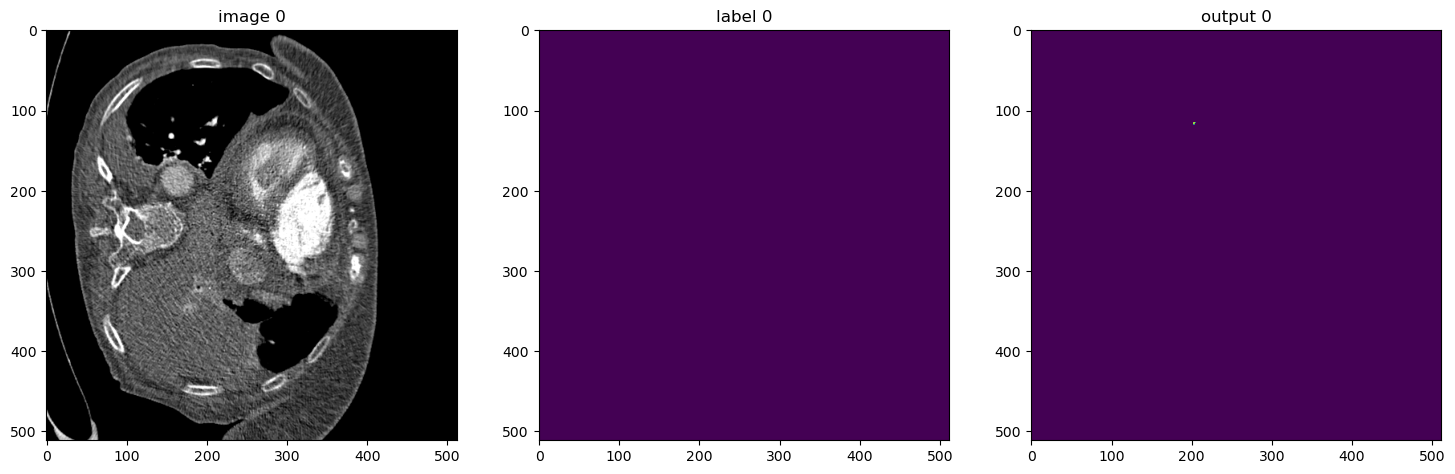

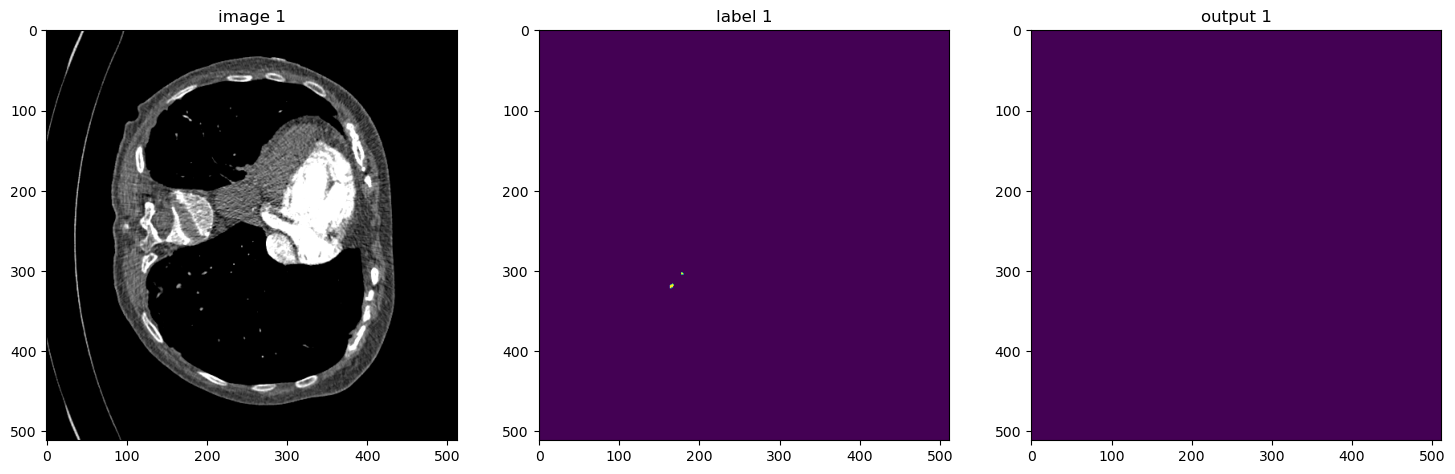

In [69]:
checkpoint = torch.load(os.path.join(run_save_dir, "checkpoint.pth"))
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
        # plot the slice [:, :, 80]
        idx = 174
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :,idx], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, idx])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, idx])
        plt.show()
        if i == 1:
            break

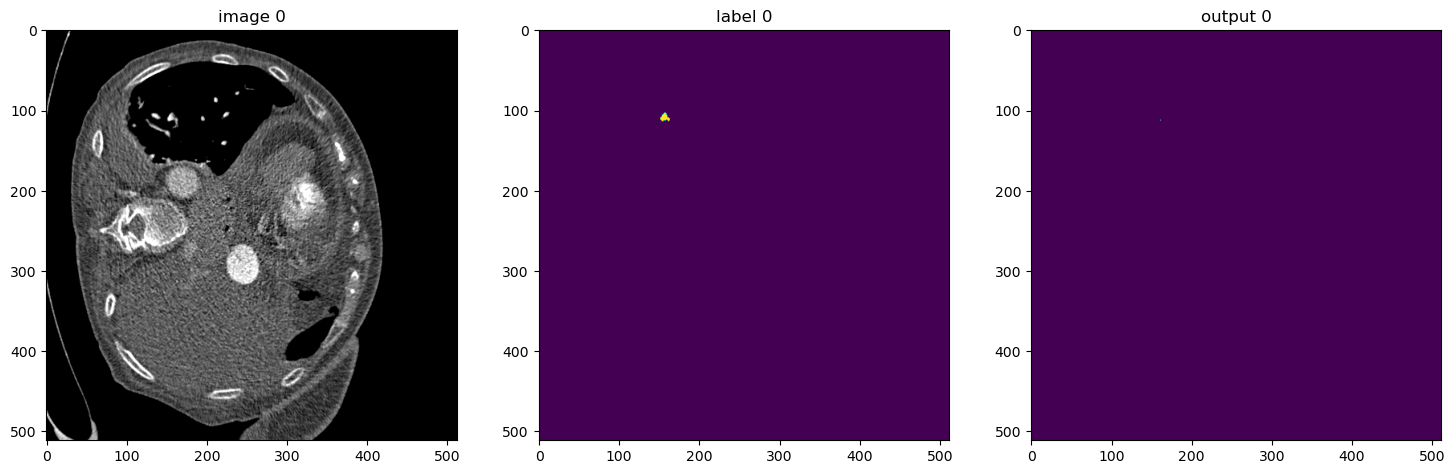

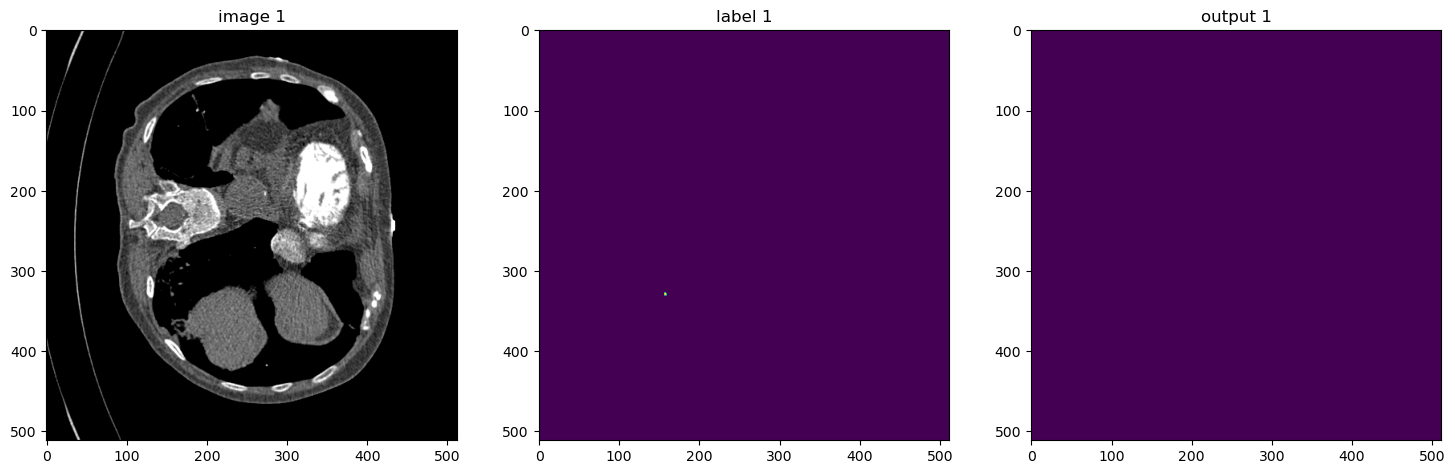

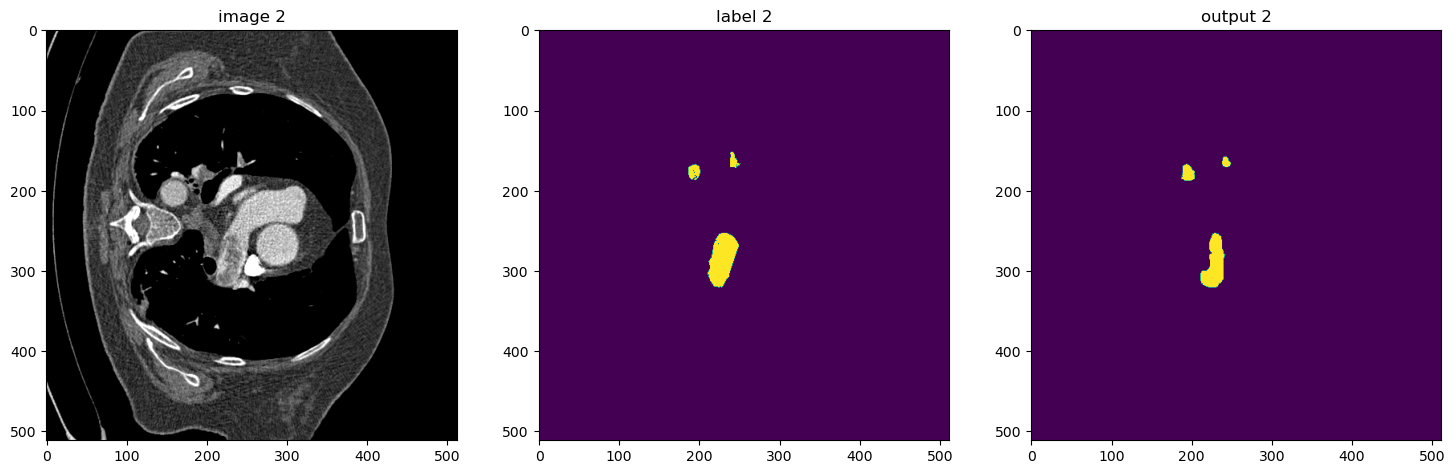

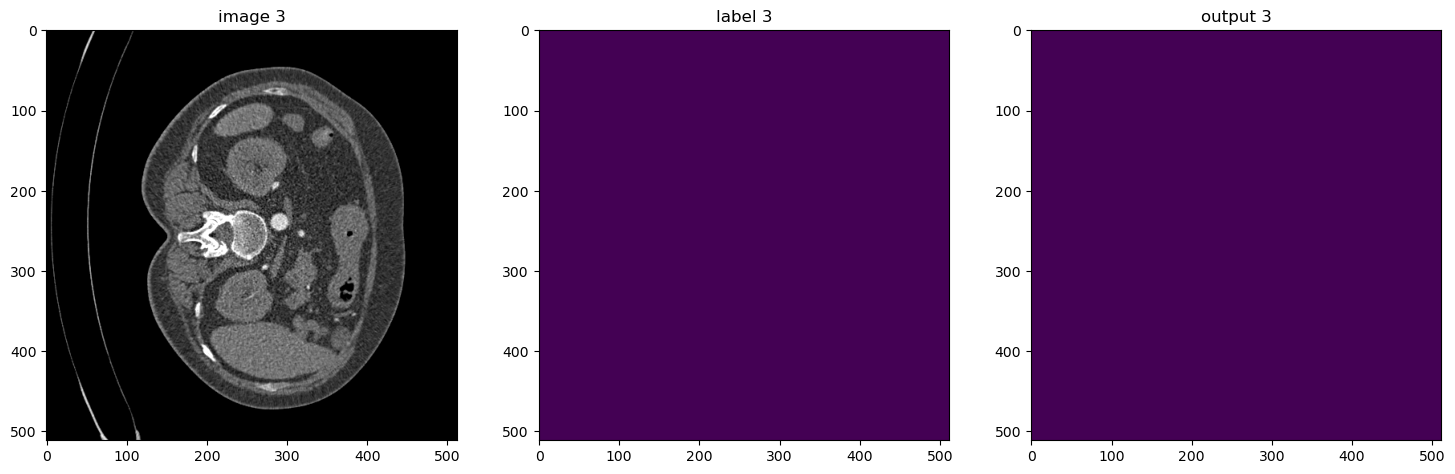

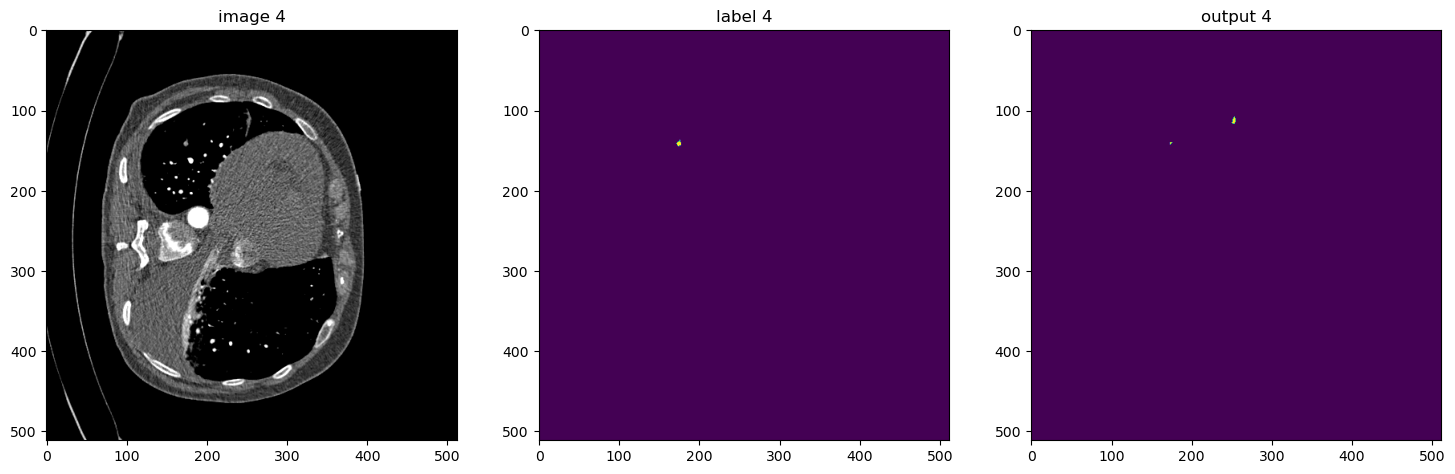

IndexError: index 147 is out of bounds for dimension 4 with size 96

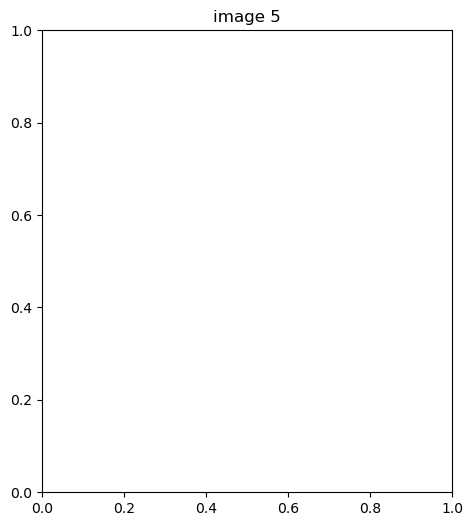

In [70]:
checkpoint = torch.load(os.path.join(run_save_dir, "checkpoint.pth"))
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
        # plot the slice [:, :, 80]
        idx = 147
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :,idx], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, idx])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, idx])
        plt.show()
        if i == 10:
            break

## Generate Prediction Masks for Validation
Note we need to rotate 90 degress and flip along X axis

In [71]:
import os
import torch
import nibabel as nib
import numpy as np
from monai.inferers import sliding_window_inference

# Load model
checkpoint = torch.load(os.path.join(run_save_dir, "checkpoint.pth"), map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()

output_base_dir = os.path.join(run_save_dir, "predictions")
os.makedirs(output_base_dir, exist_ok=True)

with torch.no_grad():
    for i, batch in enumerate(val_loader):
        image = batch["image"].to(device)  # (1, 1, H, W, D)
        image_path = val_loader.dataset.data[i]["image"]
        affine = nib.load(image_path).affine

        # Predict
        val_outputs = sliding_window_inference(image, roi_size=(160, 160, 160), sw_batch_size=4, predictor=model)
        pred = torch.argmax(val_outputs, dim=1).cpu().numpy()[0]  # shape: (H, W, D)
        
        # ✅ Apply rotation and flip
        # pred = np.rot90(pred, k=1, axes=(0, 1))  # Rotate 90° counter-clockwise in XY
        pred = np.flip(pred, axis=0)             # Flip along X-axis
        pred = np.flip(pred, axis=1)             # Flip along X-axis

        print(f"[DEBUG] pred shape: {pred.shape}, unique values: {np.unique(pred)}")

        # Save directly without transformation
        patient_id = os.path.basename(os.path.dirname(image_path))
        os.makedirs(os.path.join(output_base_dir, patient_id), exist_ok=True)
        filename = os.path.basename(image_path).replace(".nii.gz", "_pred.nii.gz")
        save_path = os.path.join(output_base_dir, patient_id, filename)

        nib.save(nib.Nifti1Image(pred.astype(np.uint8), affine), save_path)
        print(f"✅ Saved: {save_path}")


[DEBUG] pred shape: (512, 512, 564), unique values: [0 1]
✅ Saved: ./CADPE-exp2/predictions/images/e0528_pred.nii.gz
[DEBUG] pred shape: (512, 512, 580), unique values: [0 1]
✅ Saved: ./CADPE-exp2/predictions/images/e0560_pred.nii.gz
[DEBUG] pred shape: (512, 512, 366), unique values: [0 1]
✅ Saved: ./CADPE-exp2/predictions/images/e0573_pred.nii.gz
[DEBUG] pred shape: (512, 512, 711), unique values: [0 1]
✅ Saved: ./CADPE-exp2/predictions/images/e0574_pred.nii.gz
[DEBUG] pred shape: (512, 512, 574), unique values: [0 1]
✅ Saved: ./CADPE-exp2/predictions/images/e0588_pred.nii.gz
[DEBUG] pred shape: (512, 512, 96), unique values: [0 1]
✅ Saved: ./CADPE-exp2/predictions/images/e0592_pred.nii.gz
[DEBUG] pred shape: (512, 512, 526), unique values: [0 1]
✅ Saved: ./CADPE-exp2/predictions/images/e0608_pred.nii.gz
[DEBUG] pred shape: (512, 512, 96), unique values: [0 1]
✅ Saved: ./CADPE-exp2/predictions/images/e0641_pred.nii.gz
[DEBUG] pred shape: (512, 512, 395), unique values: [0 1]
✅ Saved:

## Validate CAD-PE model on external validation set (FUMPE)

In [73]:
import glob
import os

external_ct_dir = "../fumpe_data/nifti/CT_scans"
external_gt_dir = "../fumpe_data/nifti/GroundTruth"
external_val_cnt = 10

# Recursively find FLAIR and binary mask pairs
external_image_paths = sorted(glob.glob(os.path.join(external_ct_dir, "**", "*.nii.gz"), recursive=True))
external_label_paths = sorted(glob.glob(os.path.join(external_gt_dir, "**", "*.nii.gz"), recursive=True))

# Make sure they align
assert len(external_image_paths) == len(external_label_paths), "Mismatch in image and label counts!"

external_data_dicts = [{"image": i, "label": l} for i, l in zip(external_image_paths, external_label_paths)]

# Manual split: last N for validation
external_train_files = external_data_dicts[:-external_val_cnt]  # adjust N based on your total case count
external_val_files   = external_data_dicts[-external_val_cnt:]

print(f"✅ Total cases: {len(external_data_dicts)}")
print(f"📊 Training: {len(external_train_files)}  | Validation: {len(external_val_files)}")

✅ Total cases: 35
📊 Training: 25  | Validation: 10


In [74]:
external_val_ds = CacheDataset(data=external_val_files, transform=val_transforms, cache_rate=cache_rate, num_workers=2)
external_val_loader = DataLoader(external_val_ds, batch_size=1, num_workers=2)

Loading dataset: 100%|██████████| 10/10 [01:03<00:00,  6.38s/it]


In [75]:
device = torch.device("cuda:0")

model = UNet(
    spatial_dims=3,
    in_channels=in_channels,
    out_channels=out_channels,
    channels=channels,
    strides=strides,
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

In [76]:
# Load model
checkpoint = torch.load(os.path.join(run_save_dir, "checkpoint.pth"), map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


In [78]:
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.transforms import AsDiscrete, Compose
from monai.data import decollate_batch

# Match your post transforms
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

# Match your loss function and metric
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
dice_metric = DiceMetric(include_background=False, reduction="mean")

val_loss = 0.0
val_steps = 0

model.eval()
with torch.no_grad():
    for val_data in external_val_loader:
        val_inputs, val_labels = val_data["image"].to(device), val_data["label"].to(device)

        # Inference
        val_outputs = sliding_window_inference(
            val_inputs, roi_size=(160, 160, 160), sw_batch_size=4, predictor=model
        )

        # Loss (raw output vs. label)
        loss = loss_function(val_outputs, val_labels)
        val_loss += loss.item()
        val_steps += 1

        # Post-processing for Dice
        val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
        val_labels = [post_label(i) for i in decollate_batch(val_labels)]
        dice_metric(y_pred=val_outputs, y=val_labels)

# Aggregated metrics
val_loss /= val_steps
val_dice = dice_metric.aggregate().item()
dice_metric.reset()

print(f"📊 External Validation Dice (CAD-PE model on FUMPE): {val_dice:.4f}")
print(f"📉 External Validation Loss: {val_loss:.4f}")


📊 External Validation Dice (CAD-PE model on FUMPE): 0.4849
📉 External Validation Loss: 0.2863
